In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_ticket_max = 5000000   # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 1/3       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE  + '''.KEY],
['''     + TABLE_ENTETE  + '''.''' + TABLE_MAGASIN + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(nbr_ticket_max) + '''
AND [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY],
[Recette_entete_ticket.Magasin.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 5000000
AND [Article_meti_HIST.Univers.KEY] != 388
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~212secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                                   392                          2   
1                     

In [9]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 1s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [19]:
univers_correspondance = {}
deleted = set()
for item in df_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{3: 2}


In [20]:
start = time()

transactions      = []
actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    
    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            transactions.append(tuple(l))
        actual_key_ticket = key_tic
        l = []
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
transactions.append(tuple(l))
print(transactions[:20])

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(394.0, 394.0, 394.0), (297.0,), (403.0, 13.0, 13.0), (211.0, 362.0, 174.0), (437.0, 437.0), (294.0, 357.0), (396.0, 351.0), (92.0, 360.0, 216.0), (297.0,), (297.0,), (297.0, 62.0, 122.0, 473.0, 475.0, 471.0), (437.0,), (296.0, 297.0, 220.0, 92.0, 296.0, 296.0), (188.0, 362.0, 394.0, 394.0), (294.0, 297.0), (360.0, 406.0), (456.0, 454.0, 468.0, 189.0, 189.0, 210.0, 210.0), (250.0, 129.0), (321.0, 457.0, 454.0, 361.0, 476.0, 272.0), (400.0, 394.0, 134.0)]
Time Taken to load transaction: ~6secondes


In [21]:
start = time()
rec_article = {}
N = len(transactions)

for t in transactions:
    for art in set(t):
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N
print(N)

print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

1706303
Time Taken to load recurence: ~8secondes


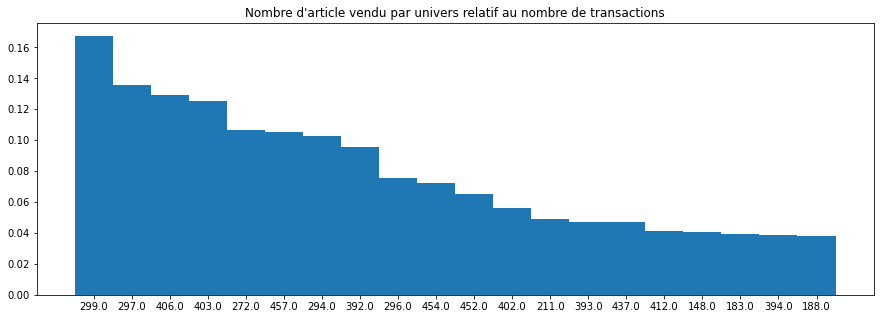

In [22]:
fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
            ,list(rec_article.values())[:min(20, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [23]:
if do_analysis:
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [24]:
start = time()

min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

0.002336448598130841
Time Taken to run Apriori Algorithm : ~29secondes


In [25]:
print(len(rules))
print(sum([r.support for r in rules])*0.05)
for rule in sorted(rules, key=lambda rule: rule.support):
    print(rule)

30
0.007400795755501806
{408.0, 412.0} -> {402.0} (conf: 0.436, supp: 0.002, lift: 7.809, conv: 1.675)
{272.0, 437.0} -> {299.0} (conf: 0.452, supp: 0.002, lift: 2.699, conv: 1.519)
{296.0, 439.0} -> {299.0} (conf: 0.533, supp: 0.002, lift: 3.182, conv: 1.782)
{437.0, 439.0} -> {299.0} (conf: 0.642, supp: 0.003, lift: 3.837, conv: 2.329)
{148.0, 406.0} -> {403.0} (conf: 0.364, supp: 0.003, lift: 2.898, conv: 1.374)
{148.0, 403.0} -> {406.0} (conf: 0.350, supp: 0.003, lift: 2.705, conv: 1.339)
{288.0} -> {297.0} (conf: 0.345, supp: 0.003, lift: 2.548, conv: 1.320)
{327.0} -> {454.0} (conf: 0.334, supp: 0.003, lift: 4.610, conv: 1.392)
{62.0, 475.0} -> {297.0} (conf: 0.378, supp: 0.003, lift: 2.788, conv: 1.389)
{294.0, 403.0} -> {406.0} (conf: 0.334, supp: 0.003, lift: 2.582, conv: 1.307)
{271.0} -> {272.0} (conf: 0.580, supp: 0.003, lift: 5.440, conv: 2.128)
{448.0} -> {297.0} (conf: 0.964, supp: 0.003, lift: 7.113, conv: 23.760)
{56.0} -> {183.0} (conf: 0.341, supp: 0.003, lift: 8.730

In [26]:
conn = engine.connect()

for rule in sorted(rules, key=lambda rule: rule.lift):
#     if (not 272 in rule.lhs) and (not 272 in rule.rhs) and (not 271 in rule.lhs) and (not 271 in rule.rhs): 
#         continue

    print("\n\nRule : ", rule)
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.lhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))
    print('->')
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.rhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))

conn.close()



Rule :  {198.0} -> {299.0} (conf: 0.346, supp: 0.007, lift: 2.065, conv: 1.272)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.382, supp: 0.004, lift: 2.281, conv: 1.347)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.423, supp: 0.003, lift: 2.528, conv: 1.444)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEU

In [27]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1601secondes


## Panier d'Articles par magasin

In [28]:
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    Magasin.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [16]:
all_mag_key = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_tra = {mag_key:[] for mag_key in all_mag_key}

start = time()

actual_key_ticket = -1
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    key_mag  = item[2]

    if actual_key_ticket != key_tic:
        if actual_key_ticket != -1:
            all_mag_tra[key_mag].append(tuple(l))
        actual_key_ticket = key_tic
        l = []

    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(key_univ)
all_mag_tra[key_mag].append(tuple(l))

# environ 10s
print("Time Taken to run load transaction : ~" + str(int(time() - start)) + "secondes") 

Time Taken to run load transaction : ~12secondes


102366
To less data ...
124956
To less data ...
84899
To less data ...
53338
To less data ...
70709
To less data ...
82197
To less data ...
92205
To less data ...
74186
To less data ...
133208
To less data ...
89089
To less data ...
128501
To less data ...
128631
To less data ...
101147
To less data ...
77446
To less data ...
122943
To less data ...
148499
To less data ...
93001
To less data ...
90964
To less data ...
91447
To less data ...
104339
To less data ...
146162
To less data ...
33964
To less data ...
174885


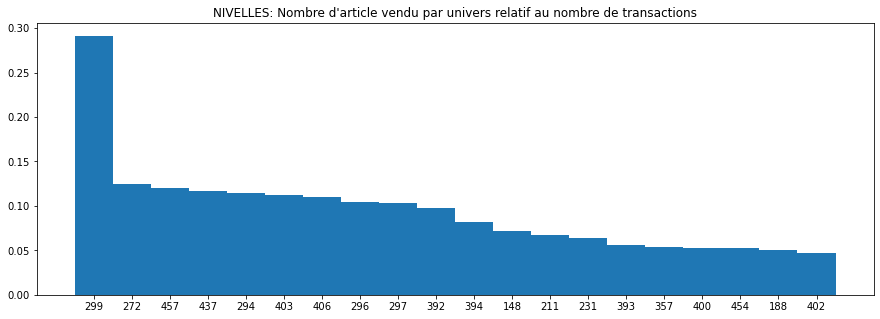

0.002506265664160401
Running Apriori
12
{198} -> {299} (conf: 0.338, supp: 0.005, lift: 2.179, conv: 1.276)
{437} -> {299} (conf: 0.370, supp: 0.032, lift: 2.389, conv: 1.342)
{439} -> {299} (conf: 0.497, supp: 0.018, lift: 3.204, conv: 1.679)
{301} -> {299} (conf: 0.561, supp: 0.004, lift: 3.621, conv: 1.927)
{475} -> {297} (conf: 0.337, supp: 0.004, lift: 3.870, conv: 1.378)
{299, 439} -> {437} (conf: 0.385, supp: 0.007, lift: 4.458, conv: 1.485)
{271} -> {272} (conf: 0.503, supp: 0.003, lift: 4.678, conv: 1.797)
{52} -> {294} (conf: 0.402, supp: 0.003, lift: 4.761, conv: 1.531)
{74} -> {294} (conf: 0.432, supp: 0.005, lift: 5.114, conv: 1.611)
{437, 439} -> {299} (conf: 0.813, supp: 0.007, lift: 5.246, conv: 4.526)
{27} -> {294} (conf: 0.479, supp: 0.004, lift: 5.678, conv: 1.759)
{408} -> {402} (conf: 0.381, supp: 0.004, lift: 9.836, conv: 1.552)
Time Taken to run Apriori Algorithm : ~2secondes


Rule :  {198} -> {299} (conf: 0.338, supp: 0.005, lift: 2.179, conv: 1.276)
 Univ_KEY 

In [17]:
conn = engine.connect()
for mag_key in all_mag_key:
    start    = time()
    mag_lib  = all_mag_lib[mag_key]
    mag_tran = all_mag_tra[mag_key]
    

    mag_rec_article = {}

    for t in mag_tran:
        for art in t:
            if not str(art) in mag_rec_article.keys():
                mag_rec_article[str(art)] = 0
            mag_rec_article[str(art)]+=1

    for k in mag_rec_article.keys():
        mag_rec_article[k]/= len(mag_tran)
    print(len(mag_tran))
    
    
    mag_rec_article = {k: v for k, v in sorted(mag_rec_article.items(), key=lambda item: item[1], reverse = True)}
    mag_nbr_univ = len(mag_rec_article.keys())
    
    if len(mag_tran) < mag_nbr_univ**2:
        print("To less data ...")
        continue
    
    fig = plt.figure(figsize=(15, 5))
    plt.bar(list(mag_rec_article.keys())[:min(20, mag_nbr_univ)]
                ,list(mag_rec_article.values())[:min(20, mag_nbr_univ)],1)

    plt.title(mag_lib + ": Nombre d'article vendu par univers relatif au nombre de transactions")

    if save_fig:
        plt.savefig(save_folder+"/MAG-"+str(mag_key)+"-"+mag_lib+"-Proportion-Article.jpg")
    plt.show()
    
    min_supp = 1/mag_nbr_univ if min_support == 0 else min_support
    print(min_supp)
 
    print("Running Apriori")
    _, mag_rules = apriori(mag_tran, min_support=min_supp, min_confidence=min_confidence)
    
    print(len(mag_rules))
    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print(rule)

    # environ 5s   
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    

    for rule in sorted(mag_rules, key=lambda rule: rule.lift):
        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

conn.close()    


In [18]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~322secondes


## Isolation du tabacs dans les transactions

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY],
['''     + RECETTE_DETAIL + ''']
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(30000000) + '''
AND [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
AND [Recette_entete_ticket.CONSOMMATEUR.KEY] != -1
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY],
[Recette_detail_ticket.Total_net_ttc_ligne]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 30000000
AND [Article_meti_HIST.Univers.KEY] != 388
AND [Recette_entete_ticket.CONSOMMATEUR.KEY] != -1
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~228secondes
         Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0                                

In [5]:
# start = time()

# print(len(transactions))

# tabac_transactions = []
# i = 0
# for t in transactions:
#     if tabac_key in t:
#         tabac_transactions.append(t)
# print(len(tabac_transactions))

# print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

In [14]:
start = time()

tabac_key = 272
# if tabac_key in deleted:
#     tabac_key = univers_correspondance[key_univ]
accessoire_tabac_key = 271
# if tabac_key in deleted:
#     accessoire_tabac_key = univers_correspondance[key_univ]

all_univ = set()
tabac_transactions  = []
actual_key_ticket = -1

CA_tabac = 0
CA = 0

for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]
    if actual_key_ticket != key_tic:
        if actual_key_ticket!= -1 and tabac_key in l:
            tabac_transactions.append(tuple(l))
            CA += rec_ticket
        actual_key_ticket = key_tic
        l = []
        rec_ticket = 0
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(int(key_univ))
    if key_univ != tabac_key and key_univ != accessoire_tabac_key:
        rec_ticket += rec_lig
    else:
        CA_tabac += rec_lig
    
    all_univ.add(key_univ)

if tabac_key in l:
    tabac_transactions.append(tuple(l))
    CA += rec_ticket   
    
print(tabac_transactions[:20])
print(len(tabac_transactions))
# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(321, 457, 454, 361, 476, 272), (465, 272, 135, 135), (272,), (272, 297), (151, 299, 301, 299, 301, 142, 403, 403, 454, 246, 457, 457, 225, 225, 134, 134, 272, 360, 272, 144, 144), (327, 413, 272, 272, 272, 122, 327, 392), (119, 357, 272), (272, 437), (129, 120, 437, 437, 394, 272), (210, 272), (149, 316, 403, 147, 147, 147, 412, 272, 402, 147), (272,), (211, 272, 437), (272, 272), (294, 294, 272, 403, 74, 299, 299, 299, 225), (400, 357, 370, 57, 129, 416, 120, 403, 272), (272, 272, 272, 250, 392, 294, 215, 305), (272,), (272, 457, 392), (392, 471, 272, 431)]
181994
Time Taken to load transaction: ~15secondes


In [15]:
start = time()

nbr_univ = len(all_univ)
min_supp = 1/nbr_univ if min_support == 0 else min_support
print(min_supp)
                     
_, rules = apriori(tabac_transactions, min_support=min_supp, min_confidence=min_confidence)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
print(len(rules))

0.00234192037470726
Time Taken to run Apriori Algorithm : ~4secondes
1085


In [37]:
conn = engine.connect()
def print_rules(rules, removed_key = -1):
    for rule in sorted(rules, key=lambda rule: rule.lift):
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()
print_rules(rules, tabac_key)



Rule :  {198.0} -> {299.0} (conf: 0.346, supp: 0.007, lift: 2.065, conv: 1.272)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.382, supp: 0.004, lift: 2.281, conv: 1.347)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.423, supp: 0.003, lift: 2.528, conv: 1.444)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEU

In [17]:
nbr_article_sans_tabac = [0 for _ in range(len(tabac_transactions))]
for i in range(len(tabac_transactions)):
    for item in tabac_transactions[i]:
        if item != tabac_key:
            nbr_article_sans_tabac[i] += 1
            
nbr_article_sans_tabac_et_derive = [0 for _ in range(len(tabac_transactions))]
for i in range(len(tabac_transactions)):
    for item in tabac_transactions[i]:
        if item != tabac_key and item != accessoire_tabac_key:
            nbr_article_sans_tabac_et_derive[i] += 1

In [29]:
print("Proportion d'achat de tabacs :", end = ' ')
print(round(len(tabac_transactions)*100/len(transactions),2), '%')
print("Nombre moyen d'achat en plus du tabacs:", end = ' ')
print(round(sum(nbr_article_sans_tabac)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac])*100/len(tabac_transactions), 2), '%')
print("Nombre moyen d'achat en plus du tabacs & dérivés:", end = ' ')
print(round(sum(nbr_article_sans_tabac_et_derive)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs & dérivé seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac_et_derive])*100/len(tabac_transactions), 2), '%')

Proportion d'achat de tabacs : 10.67 %
Nombre moyen d'achat en plus du tabacs: 5.45
Proportion d'achat de tabacs seul: 3.23 %
Nombre moyen d'achat en plus du tabacs & dérivés: 5.42
Proportion d'achat de tabacs & dérivé seul: 3.36 %


In [30]:
print(round(CA,2))
print(round(CA/len(tabac_transactions),2))
print(round(CA/sum(nbr_article_sans_tabac),2))
print(round(CA_tabac,2))
print(round(CA_tabac/(len(tabac_transactions)),2))

3769865.5
20.71
3.8
2049358.55
11.26


Time Taken to load recurence: ~30secondes


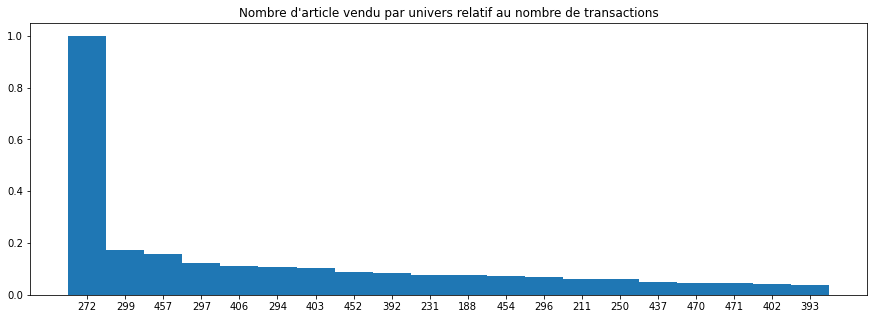

In [31]:
strat = time()
rec_article = {}
N = len(tabac_transactions)

for t in tabac_transactions:
    for art in set(t):
        if not str(art) in rec_article.keys():
            rec_article[str(art)] = 0
        rec_article[str(art)]+=1

for k in rec_article.keys():
    rec_article[k]/= N

print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

fig = plt.figure(figsize=(15, 5))

rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

nbr_univ = len(rec_article.keys())

plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
            ,list(rec_article.values())[:min(20, nbr_univ)],1)
        
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
# if save_fig:
#     plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
plt.show()

In [34]:
start = time()

univ_transactions  = {i:[] for i in all_univ}
univ_CA = {i:0 for i in all_univ}
univ_CA_sans_univ = {i:0 for i in all_univ}

actual_key_ticket = -1        
art_trans  = []
CA_trans   = {}
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]

    if actual_key_ticket != key_tic:  
        for k in CA_trans.keys():
            univ_transactions[k].append(tuple(art_trans))
            univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
            
        actual_key_ticket = key_tic
        art_trans  = []
        CA_trans   = {}

        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
        
    art_trans.append(int(key_univ))
    if not key_univ in CA_trans.keys():
        CA_trans[key_univ] = 0
    CA_trans[key_univ] += rec_lig
    univ_CA[key_univ] += rec_lig

    
for k in art_trans:
    univ_transactions[k].append(tuple(art_trans))
    univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    univ_CA[k] += CA_trans[k]

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes")    

Time Taken to load transaction: ~32secondes


==============1.0===================
Proportion d'achat de univs 1.0 :  0.01 %
Nombre moyen d'achat en plus du univs 1.0 :  5.73
Proportion d'achat de univs 1.0 seul: 7.34 %
CA sans 1.0 :  6840.98
CA moyen sans 1.0 :  62.76
CA de 1.0 :  4846.1
CA moyen de 1.0 :  44.46


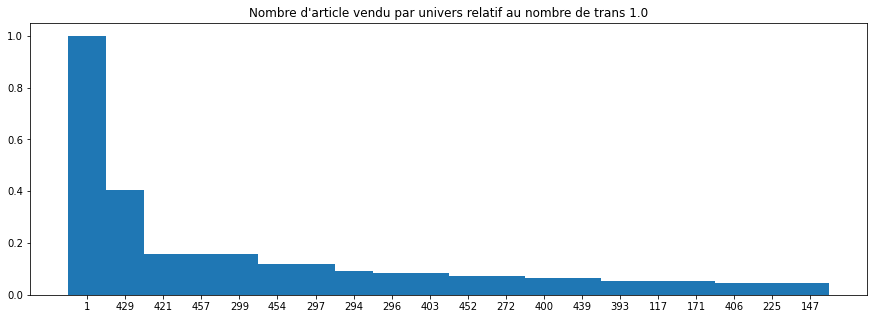

==============2.0===================
Proportion d'achat de univs 2.0 :  0.01 %
Nombre moyen d'achat en plus du univs 2.0 :  5.04
Proportion d'achat de univs 2.0 seul: 1.36 %
CA sans 2.0 :  3781.39
CA moyen sans 2.0 :  17.11
CA de 2.0 :  885.29
CA moyen de 2.0 :  4.01


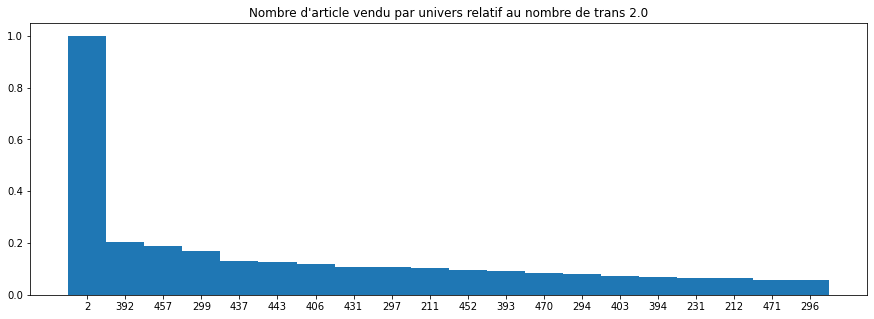

==============4.0===================
Proportion d'achat de univs 4.0 :  0.02 %
Nombre moyen d'achat en plus du univs 4.0 :  10.19
Proportion d'achat de univs 4.0 seul: 2.35 %
CA sans 4.0 :  10664.16
CA moyen sans 4.0 :  31.27
CA de 4.0 :  1452.82
CA moyen de 4.0 :  4.26


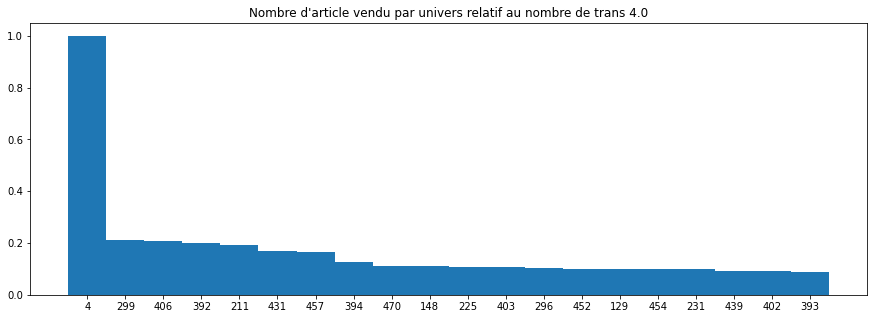

==============5.0===================
Proportion d'achat de univs 5.0 :  0.11 %
Nombre moyen d'achat en plus du univs 5.0 :  5.56
Proportion d'achat de univs 5.0 seul: 2.17 %
CA sans 5.0 :  33955.31
CA moyen sans 5.0 :  18.41
CA de 5.0 :  4495.18
CA moyen de 5.0 :  2.44


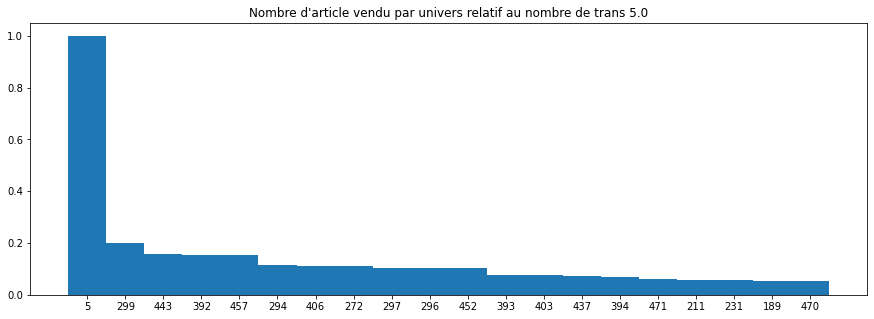

==============7.0===================
NO DATA 
==============9.0===================
Proportion d'achat de univs 9.0 :  0.58 %
Nombre moyen d'achat en plus du univs 9.0 :  10.34
Proportion d'achat de univs 9.0 seul: 1.48 %
CA sans 9.0 :  400606.24
CA moyen sans 9.0 :  40.51
CA de 9.0 :  25085.91
CA moyen de 9.0 :  2.54


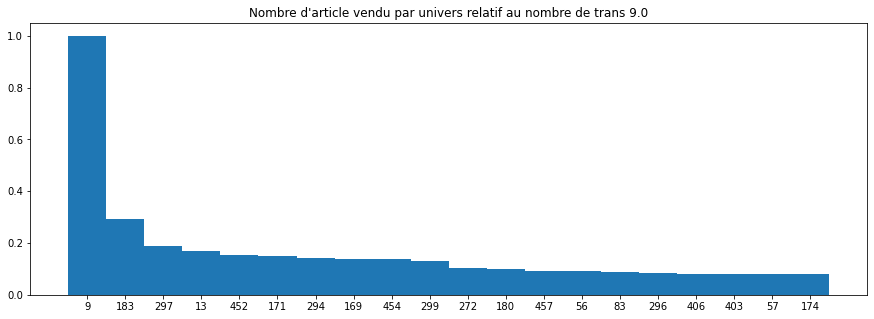

==============10.0===================
Proportion d'achat de univs 10.0 :  0.9 %
Nombre moyen d'achat en plus du univs 10.0 :  10.84
Proportion d'achat de univs 10.0 seul: 0.32 %
CA sans 10.0 :  661622.91
CA moyen sans 10.0 :  42.96
CA de 10.0 :  45705.84
CA moyen de 10.0 :  2.97


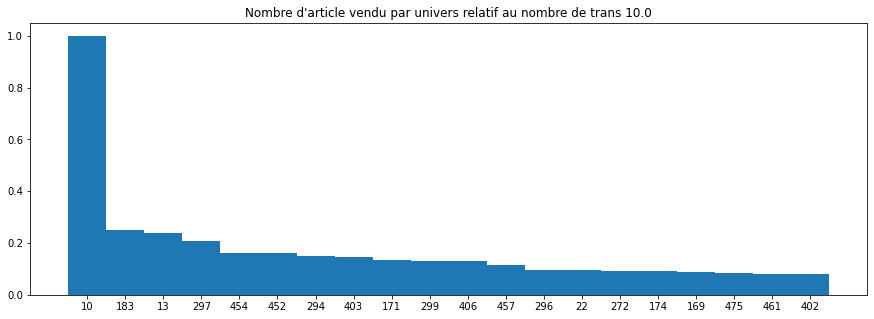

==============12.0===================
Proportion d'achat de univs 12.0 :  0.11 %
Nombre moyen d'achat en plus du univs 12.0 :  11.15
Proportion d'achat de univs 12.0 seul: 0.53 %
CA sans 12.0 :  86699.62
CA moyen sans 12.0 :  46.02
CA de 12.0 :  8766.03
CA moyen de 12.0 :  4.65


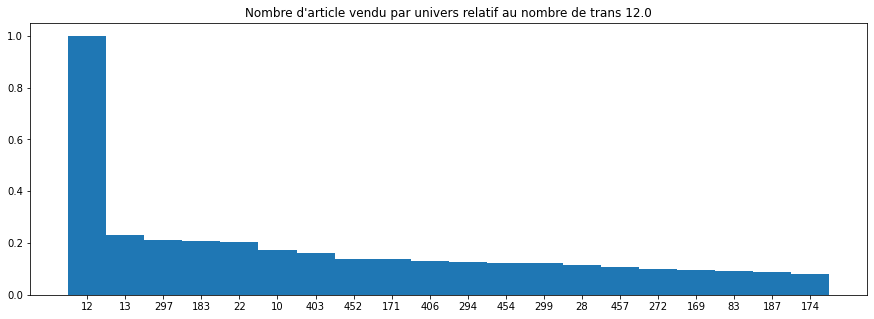

==============13.0===================
Proportion d'achat de univs 13.0 :  3.35 %
Nombre moyen d'achat en plus du univs 13.0 :  9.25
Proportion d'achat de univs 13.0 seul: 1.38 %
CA sans 13.0 :  2108036.76
CA moyen sans 13.0 :  36.86
CA de 13.0 :  201000.21
CA moyen de 13.0 :  3.51


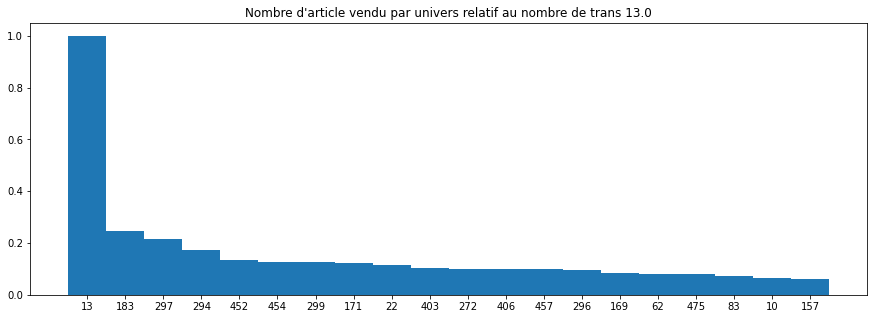

==============14.0===================
Proportion d'achat de univs 14.0 :  0.01 %
Nombre moyen d'achat en plus du univs 14.0 :  9.17
Proportion d'achat de univs 14.0 seul: 0.92 %
CA sans 14.0 :  4342.29
CA moyen sans 14.0 :  39.84
CA de 14.0 :  557.22
CA moyen de 14.0 :  5.11


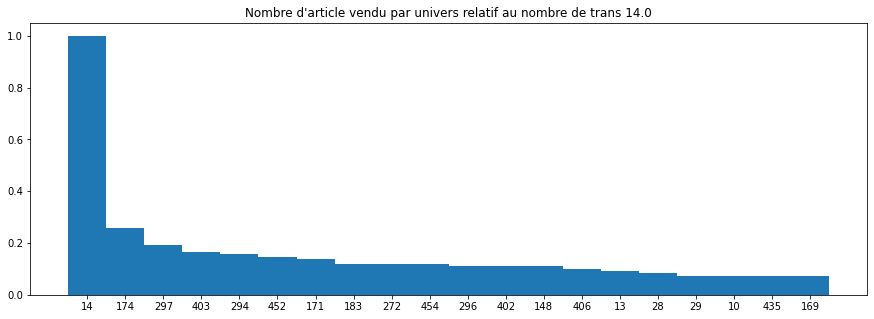

==============15.0===================
Proportion d'achat de univs 15.0 :  0.01 %
Nombre moyen d'achat en plus du univs 15.0 :  11.75
Proportion d'achat de univs 15.0 seul: 3.77 %
CA sans 15.0 :  4885.19
CA moyen sans 15.0 :  46.09
CA de 15.0 :  315.68
CA moyen de 15.0 :  2.98


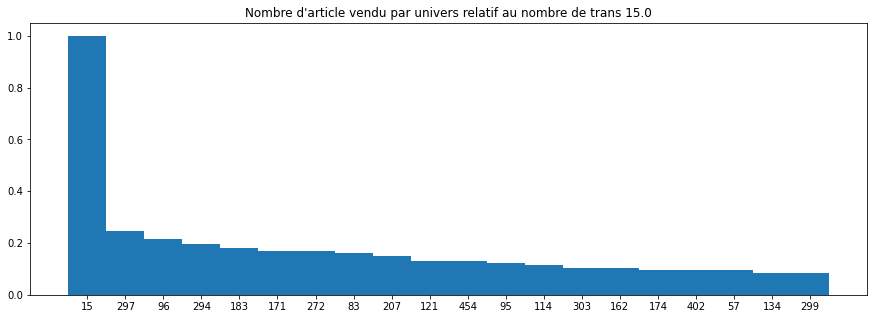

==============16.0===================
Proportion d'achat de univs 16.0 :  0.17 %
Nombre moyen d'achat en plus du univs 16.0 :  9.31
Proportion d'achat de univs 16.0 seul: 2.15 %
CA sans 16.0 :  111331.81
CA moyen sans 16.0 :  37.49
CA de 16.0 :  8577.94
CA moyen de 16.0 :  2.89


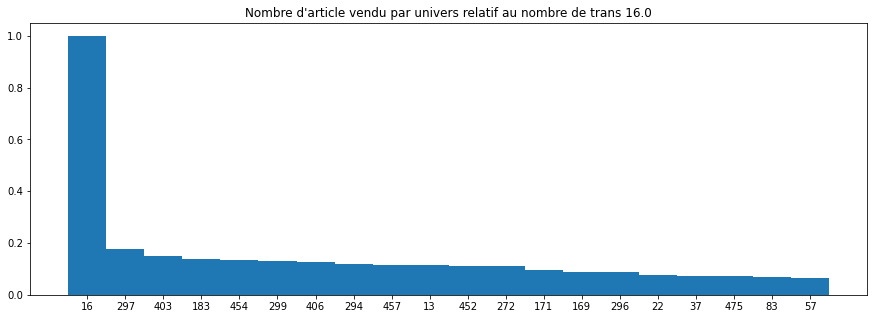

==============17.0===================
Proportion d'achat de univs 17.0 :  0.2 %
Nombre moyen d'achat en plus du univs 17.0 :  9.43
Proportion d'achat de univs 17.0 seul: 4.01 %
CA sans 17.0 :  122559.47
CA moyen sans 17.0 :  35.62
CA de 17.0 :  11159.41
CA moyen de 17.0 :  3.24


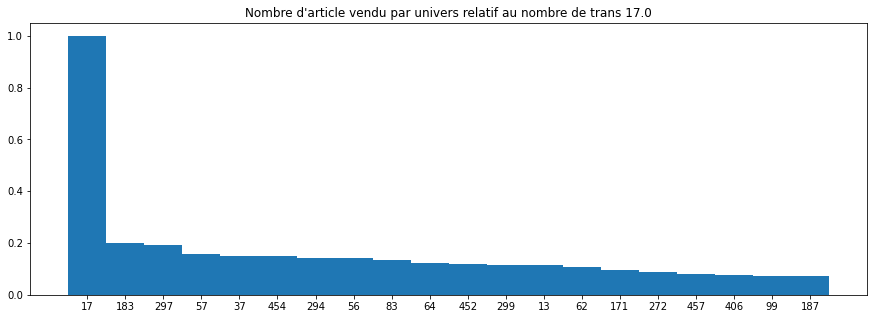

==============18.0===================
Proportion d'achat de univs 18.0 :  1.71 %
Nombre moyen d'achat en plus du univs 18.0 :  10.17
Proportion d'achat de univs 18.0 seul: 1.68 %
CA sans 18.0 :  1135509.63
CA moyen sans 18.0 :  38.96
CA de 18.0 :  113961.11
CA moyen de 18.0 :  3.91


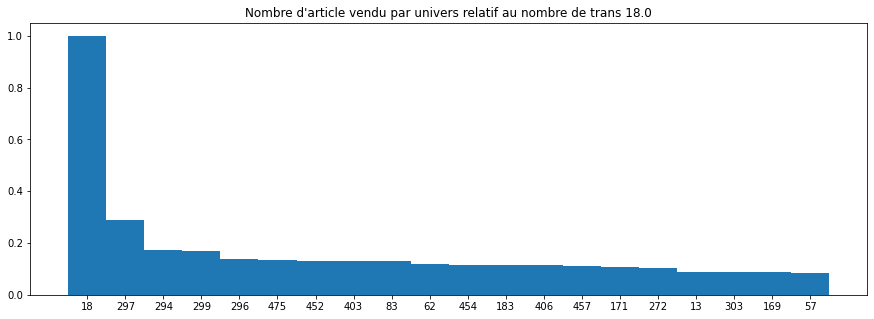

==============19.0===================
Proportion d'achat de univs 19.0 :  0.39 %
Nombre moyen d'achat en plus du univs 19.0 :  10.43
Proportion d'achat de univs 19.0 seul: 1.43 %
CA sans 19.0 :  273984.5
CA moyen sans 19.0 :  40.74
CA de 19.0 :  18434.29
CA moyen de 19.0 :  2.74


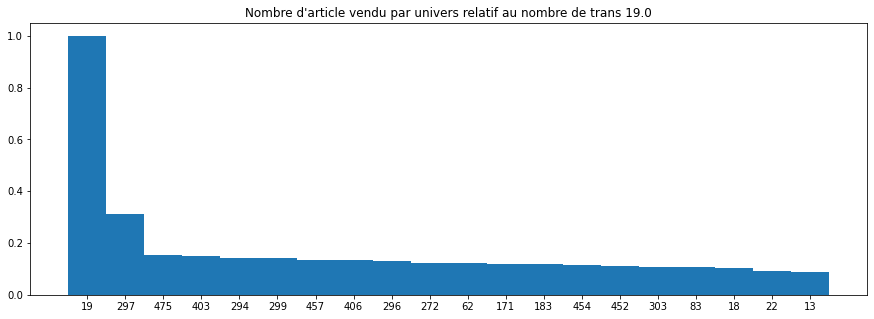

==============20.0===================
Proportion d'achat de univs 20.0 :  0.05 %
Nombre moyen d'achat en plus du univs 20.0 :  11.07
Proportion d'achat de univs 20.0 seul: 0.75 %
CA sans 20.0 :  38456.25
CA moyen sans 20.0 :  48.07
CA de 20.0 :  2563.28
CA moyen de 20.0 :  3.2


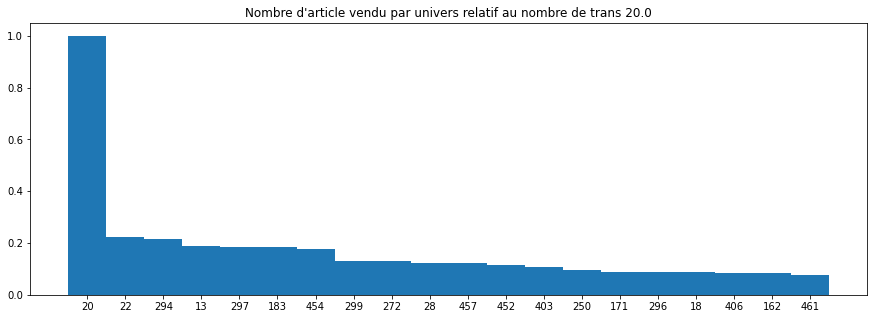

==============22.0===================
Proportion d'achat de univs 22.0 :  2.93 %
Nombre moyen d'achat en plus du univs 22.0 :  9.12
Proportion d'achat de univs 22.0 seul: 1.5 %
CA sans 22.0 :  1798690.86
CA moyen sans 22.0 :  35.96
CA de 22.0 :  387189.03
CA moyen de 22.0 :  7.74


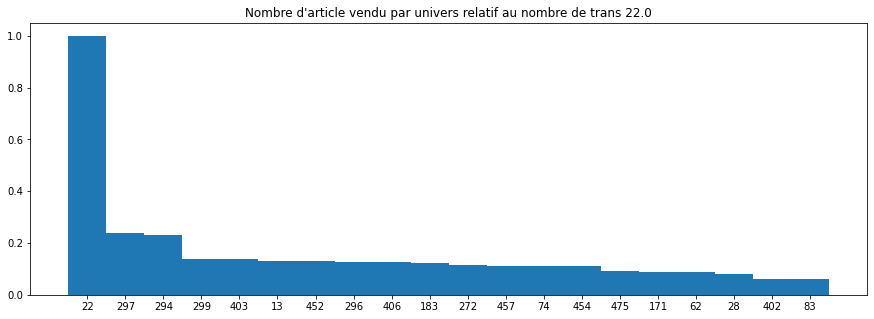

==============23.0===================
Proportion d'achat de univs 23.0 :  0.06 %
Nombre moyen d'achat en plus du univs 23.0 :  11.59
Proportion d'achat de univs 23.0 seul: 1.1 %
CA sans 23.0 :  50438.1
CA moyen sans 23.0 :  46.4
CA de 23.0 :  11008.52
CA moyen de 23.0 :  10.13


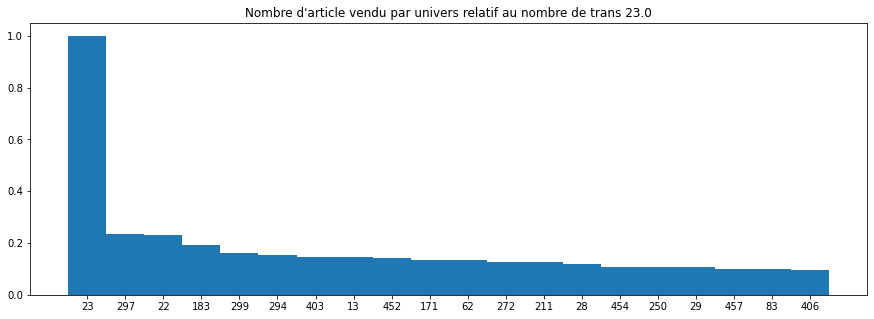

==============24.0===================
Proportion d'achat de univs 24.0 :  0.31 %
Nombre moyen d'achat en plus du univs 24.0 :  10.49
Proportion d'achat de univs 24.0 seul: 1.38 %
CA sans 24.0 :  217309.26
CA moyen sans 24.0 :  41.69
CA de 24.0 :  35385.0
CA moyen de 24.0 :  6.79


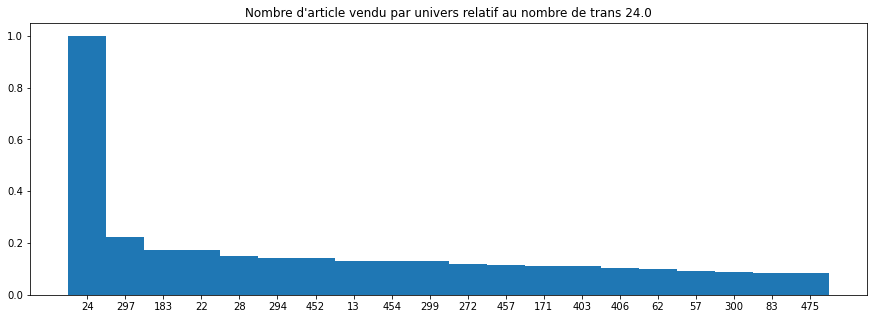

==============25.0===================
Proportion d'achat de univs 25.0 :  0.44 %
Nombre moyen d'achat en plus du univs 25.0 :  9.8
Proportion d'achat de univs 25.0 seul: 1.93 %
CA sans 25.0 :  288437.17
CA moyen sans 25.0 :  38.39
CA de 25.0 :  55607.67
CA moyen de 25.0 :  7.4


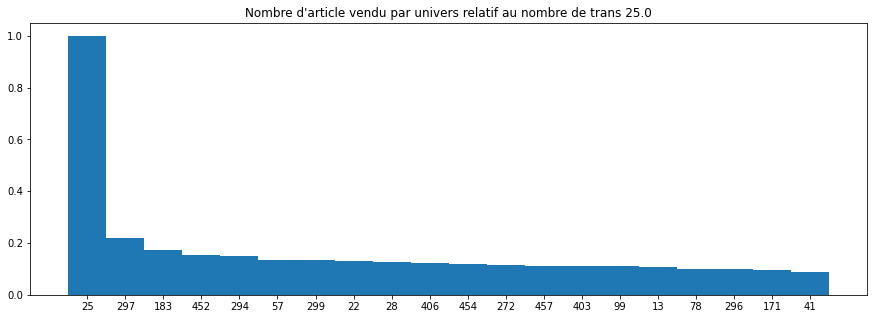

==============27.0===================
Proportion d'achat de univs 27.0 :  1.11 %
Nombre moyen d'achat en plus du univs 27.0 :  7.99
Proportion d'achat de univs 27.0 seul: 0.92 %
CA sans 27.0 :  554654.58
CA moyen sans 27.0 :  29.31
CA de 27.0 :  64492.68
CA moyen de 27.0 :  3.41


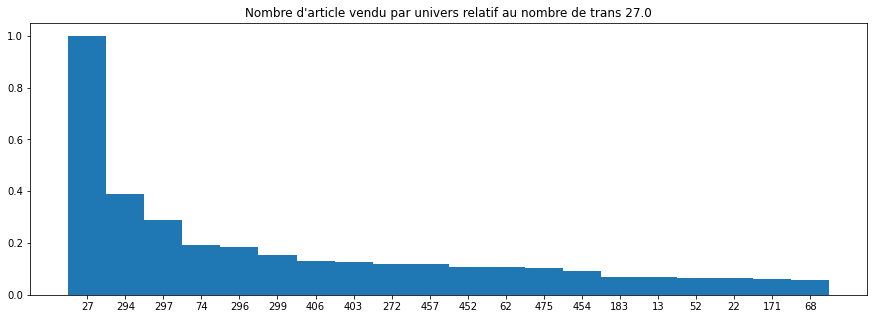

==============28.0===================
Proportion d'achat de univs 28.0 :  1.66 %
Nombre moyen d'achat en plus du univs 28.0 :  9.3
Proportion d'achat de univs 28.0 seul: 2.01 %
CA sans 28.0 :  1073216.87
CA moyen sans 28.0 :  37.78
CA de 28.0 :  207932.15
CA moyen de 28.0 :  7.32


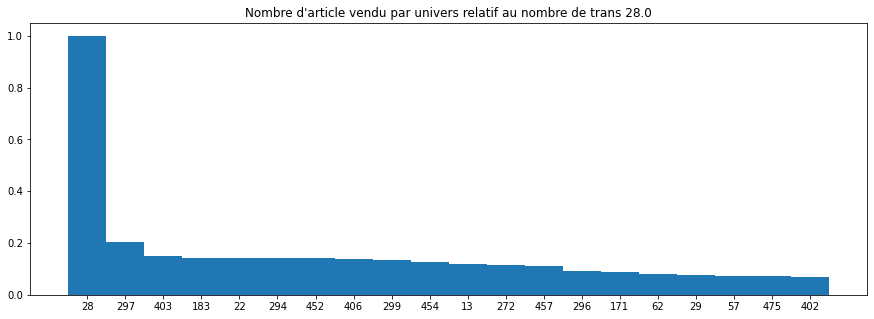

==============29.0===================
Proportion d'achat de univs 29.0 :  0.9 %
Nombre moyen d'achat en plus du univs 29.0 :  10.13
Proportion d'achat de univs 29.0 seul: 1.58 %
CA sans 29.0 :  624239.94
CA moyen sans 29.0 :  40.64
CA de 29.0 :  102273.85
CA moyen de 29.0 :  6.66


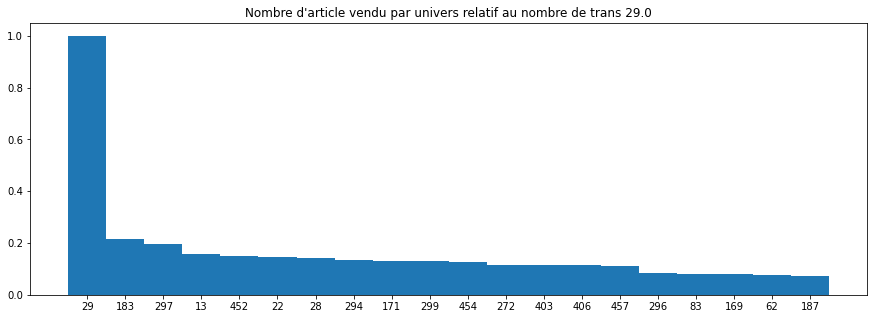

==============30.0===================
Proportion d'achat de univs 30.0 :  0.09 %
Nombre moyen d'achat en plus du univs 30.0 :  11.79
Proportion d'achat de univs 30.0 seul: 1.07 %
CA sans 30.0 :  72214.73
CA moyen sans 30.0 :  45.56
CA de 30.0 :  7000.83
CA moyen de 30.0 :  4.42


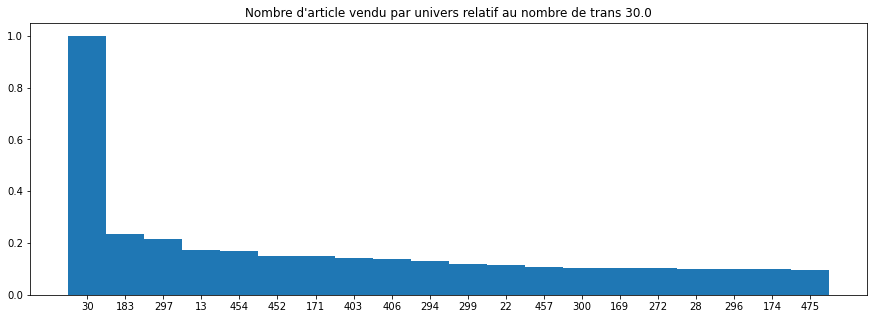

==============31.0===================
Proportion d'achat de univs 31.0 :  0.11 %
Nombre moyen d'achat en plus du univs 31.0 :  11.18
Proportion d'achat de univs 31.0 seul: 0.48 %
CA sans 31.0 :  93909.74
CA moyen sans 31.0 :  49.77
CA de 31.0 :  15419.55
CA moyen de 31.0 :  8.17


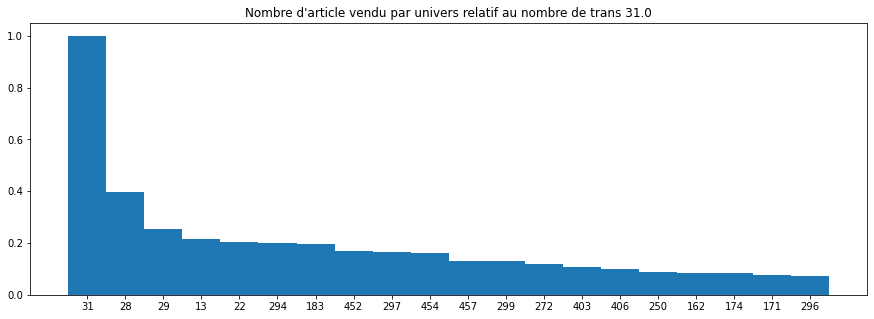

==============32.0===================
Proportion d'achat de univs 32.0 :  0.0 %
Nombre moyen d'achat en plus du univs 32.0 :  9.51
Proportion d'achat de univs 32.0 seul: 2.35 %
CA sans 32.0 :  3479.76
CA moyen sans 32.0 :  40.94
CA de 32.0 :  1122.5
CA moyen de 32.0 :  13.21


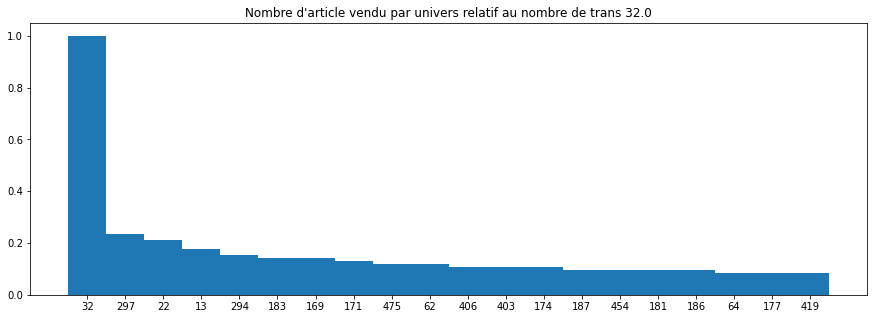

==============34.0===================
Proportion d'achat de univs 34.0 :  0.02 %
Nombre moyen d'achat en plus du univs 34.0 :  10.5
Proportion d'achat de univs 34.0 seul: 1.12 %
CA sans 34.0 :  16791.36
CA moyen sans 34.0 :  47.03
CA de 34.0 :  2747.77
CA moyen de 34.0 :  7.7


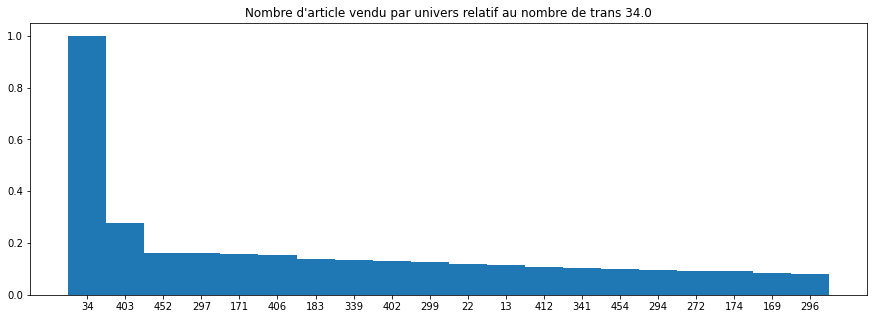

==============35.0===================
Proportion d'achat de univs 35.0 :  0.13 %
Nombre moyen d'achat en plus du univs 35.0 :  11.85
Proportion d'achat de univs 35.0 seul: 1.09 %
CA sans 35.0 :  106160.3
CA moyen sans 35.0 :  48.34
CA de 35.0 :  29253.43
CA moyen de 35.0 :  13.32


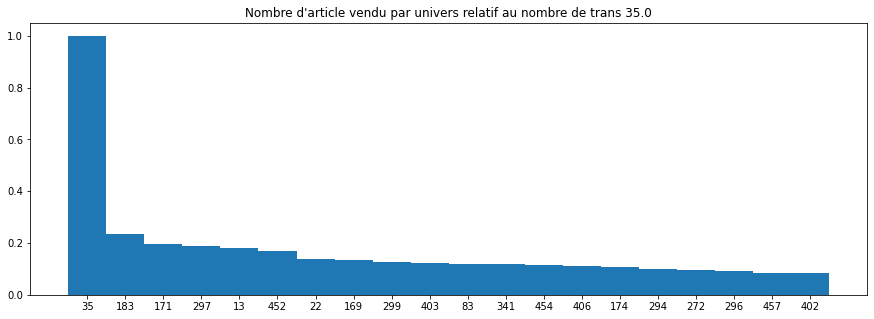

==============36.0===================
NO DATA 
==============37.0===================
Proportion d'achat de univs 37.0 :  1.12 %
Nombre moyen d'achat en plus du univs 37.0 :  9.49
Proportion d'achat de univs 37.0 seul: 2.18 %
CA sans 37.0 :  705202.93
CA moyen sans 37.0 :  36.99
CA de 37.0 :  62109.89
CA moyen de 37.0 :  3.26


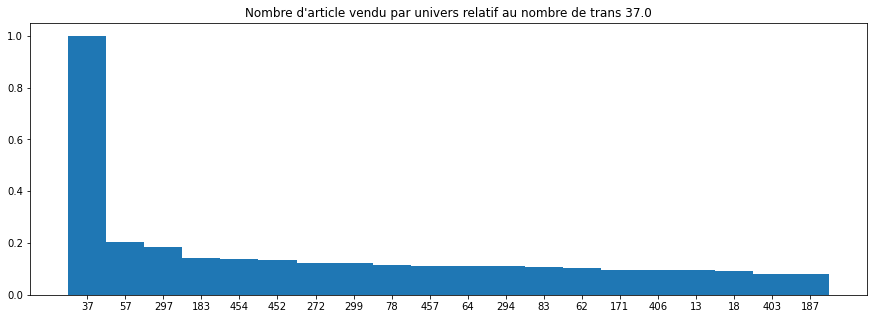

==============38.0===================
Proportion d'achat de univs 38.0 :  0.08 %
Nombre moyen d'achat en plus du univs 38.0 :  11.64
Proportion d'achat de univs 38.0 seul: 1.58 %
CA sans 38.0 :  65399.96
CA moyen sans 38.0 :  46.88
CA de 38.0 :  4458.48
CA moyen de 38.0 :  3.2


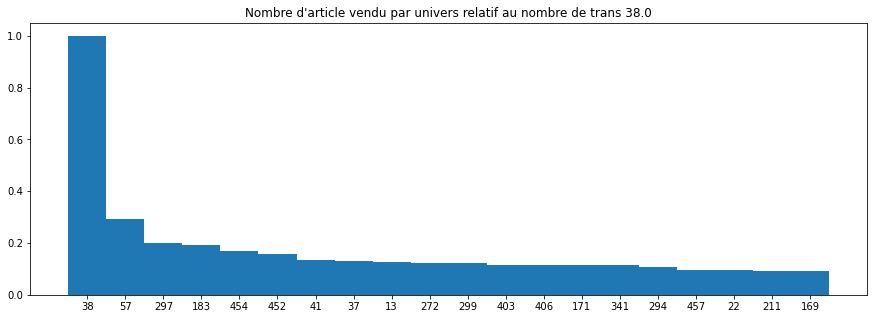

==============39.0===================
Proportion d'achat de univs 39.0 :  0.35 %
Nombre moyen d'achat en plus du univs 39.0 :  10.27
Proportion d'achat de univs 39.0 seul: 1.9 %
CA sans 39.0 :  244979.37
CA moyen sans 39.0 :  40.78
CA de 39.0 :  31749.38
CA moyen de 39.0 :  5.29


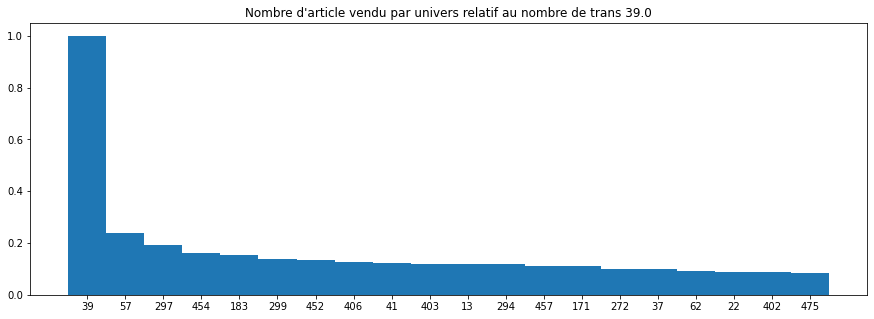

==============41.0===================
Proportion d'achat de univs 41.0 :  0.73 %
Nombre moyen d'achat en plus du univs 41.0 :  10.03
Proportion d'achat de univs 41.0 seul: 1.38 %
CA sans 41.0 :  506403.62
CA moyen sans 41.0 :  40.49
CA de 41.0 :  60176.72
CA moyen de 41.0 :  4.81


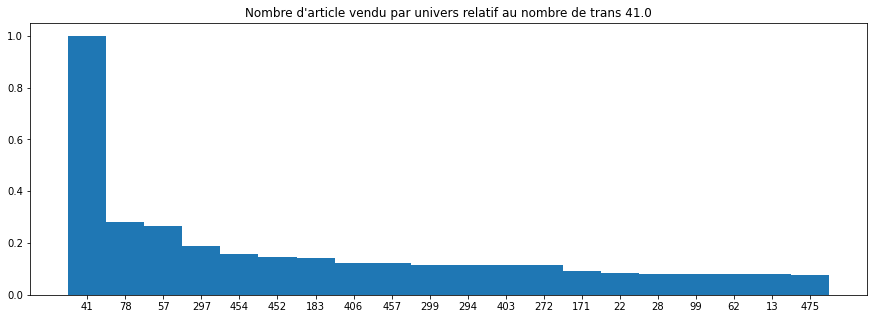

==============42.0===================
Proportion d'achat de univs 42.0 :  0.01 %
Nombre moyen d'achat en plus du univs 42.0 :  10.36
Proportion d'achat de univs 42.0 seul: 2.22 %
CA sans 42.0 :  8915.14
CA moyen sans 42.0 :  39.62
CA de 42.0 :  844.84
CA moyen de 42.0 :  3.75


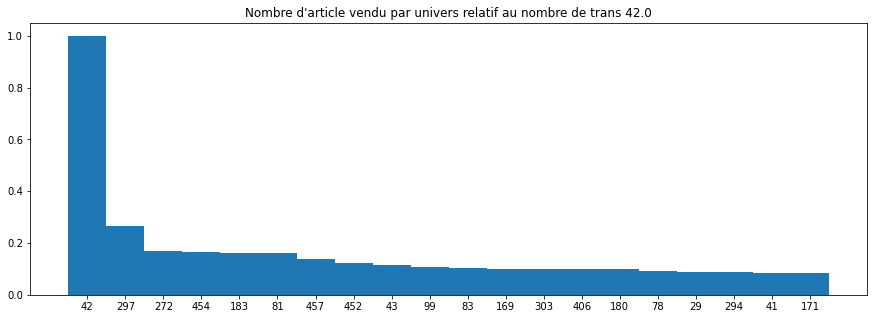

==============43.0===================
Proportion d'achat de univs 43.0 :  0.23 %
Nombre moyen d'achat en plus du univs 43.0 :  9.54
Proportion d'achat de univs 43.0 seul: 2.34 %
CA sans 43.0 :  154716.7
CA moyen sans 43.0 :  40.19
CA de 43.0 :  15555.03
CA moyen de 43.0 :  4.04


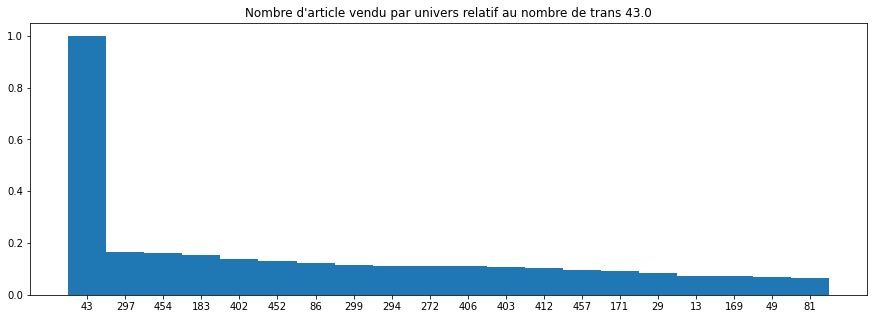

==============44.0===================
Proportion d'achat de univs 44.0 :  0.08 %
Nombre moyen d'achat en plus du univs 44.0 :  10.27
Proportion d'achat de univs 44.0 seul: 0.31 %
CA sans 44.0 :  53794.2
CA moyen sans 44.0 :  41.77
CA de 44.0 :  7087.98
CA moyen de 44.0 :  5.5


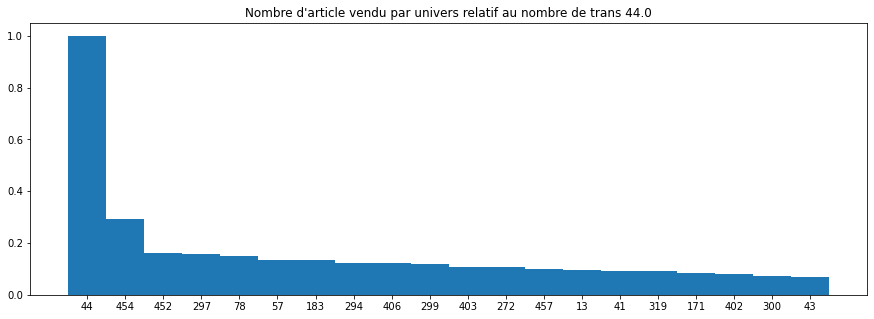

==============45.0===================
Proportion d'achat de univs 45.0 :  0.2 %
Nombre moyen d'achat en plus du univs 45.0 :  10.11
Proportion d'achat de univs 45.0 seul: 1.69 %
CA sans 45.0 :  136946.03
CA moyen sans 45.0 :  39.31
CA de 45.0 :  10957.05
CA moyen de 45.0 :  3.14


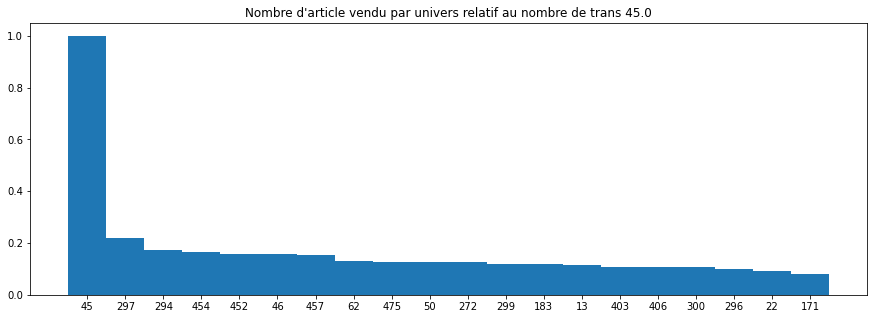

==============46.0===================
Proportion d'achat de univs 46.0 :  0.51 %
Nombre moyen d'achat en plus du univs 46.0 :  10.3
Proportion d'achat de univs 46.0 seul: 1.23 %
CA sans 46.0 :  354971.23
CA moyen sans 46.0 :  40.53
CA de 46.0 :  31540.24
CA moyen de 46.0 :  3.6


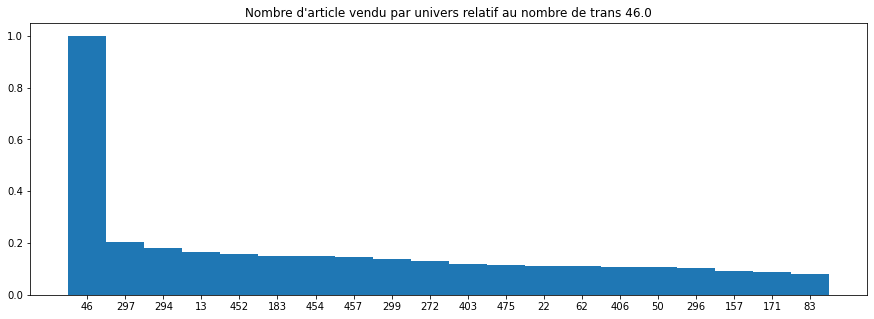

==============47.0===================
Proportion d'achat de univs 47.0 :  0.18 %
Nombre moyen d'achat en plus du univs 47.0 :  10.5
Proportion d'achat de univs 47.0 seul: 1.68 %
CA sans 47.0 :  128925.93
CA moyen sans 47.0 :  42.59
CA de 47.0 :  9684.26
CA moyen de 47.0 :  3.2


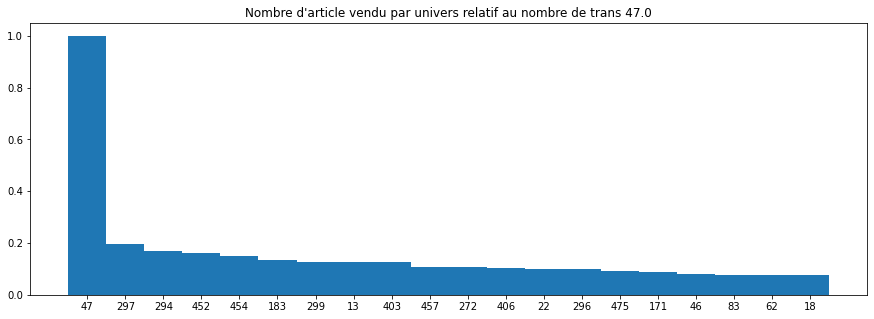

==============48.0===================
Proportion d'achat de univs 48.0 :  0.04 %
Nombre moyen d'achat en plus du univs 48.0 :  10.06
Proportion d'achat de univs 48.0 seul: 1.03 %
CA sans 48.0 :  25788.66
CA moyen sans 48.0 :  38.09
CA de 48.0 :  2836.68
CA moyen de 48.0 :  4.19


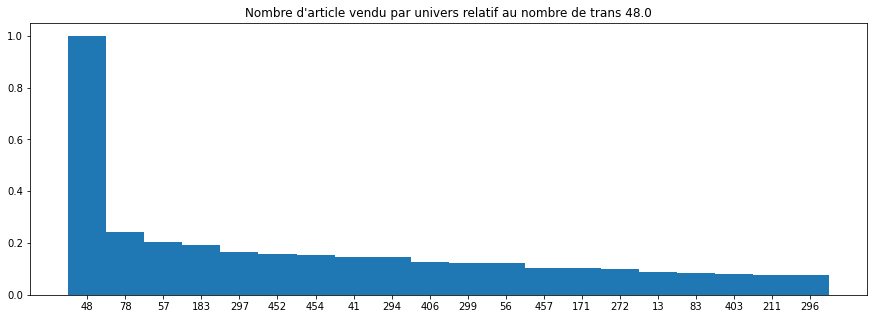

==============49.0===================
Proportion d'achat de univs 49.0 :  0.17 %
Nombre moyen d'achat en plus du univs 49.0 :  9.49
Proportion d'achat de univs 49.0 seul: 2.7 %
CA sans 49.0 :  120785.05
CA moyen sans 49.0 :  42.41
CA de 49.0 :  12305.72
CA moyen de 49.0 :  4.32


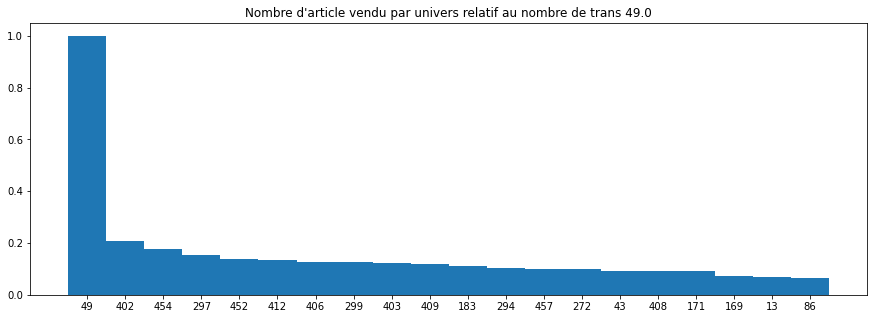

==============50.0===================
Proportion d'achat de univs 50.0 :  0.57 %
Nombre moyen d'achat en plus du univs 50.0 :  9.97
Proportion d'achat de univs 50.0 seul: 1.35 %
CA sans 50.0 :  396729.68
CA moyen sans 50.0 :  40.94
CA de 50.0 :  36907.72
CA moyen de 50.0 :  3.81


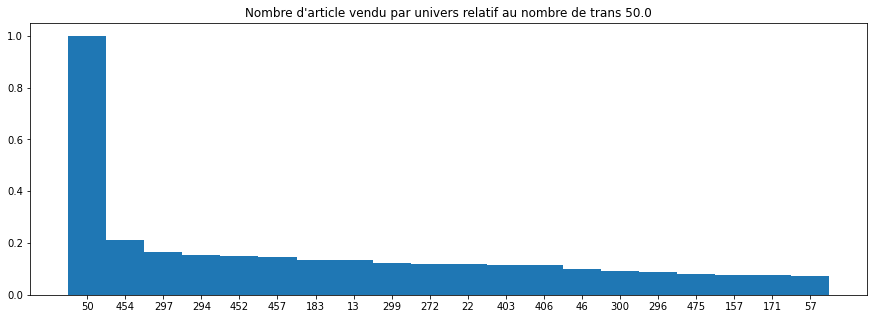

==============51.0===================
NO DATA 
==============52.0===================
Proportion d'achat de univs 52.0 :  1.76 %
Nombre moyen d'achat en plus du univs 52.0 :  10.26
Proportion d'achat de univs 52.0 seul: 0.39 %
CA sans 52.0 :  1205594.82
CA moyen sans 52.0 :  40.22
CA de 52.0 :  146019.71
CA moyen de 52.0 :  4.87


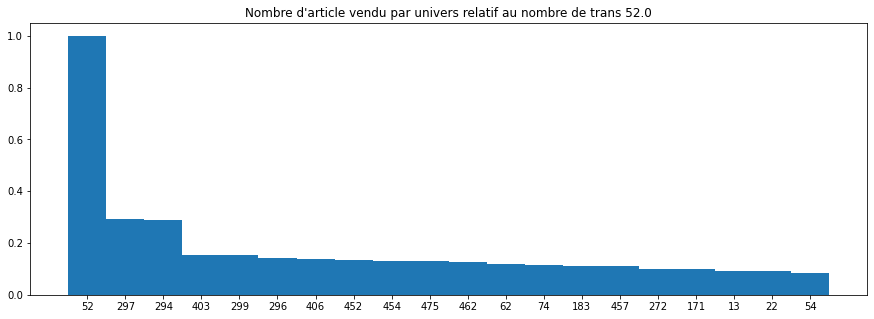

==============53.0===================
Proportion d'achat de univs 53.0 :  0.23 %
Nombre moyen d'achat en plus du univs 53.0 :  11.01
Proportion d'achat de univs 53.0 seul: 0.43 %
CA sans 53.0 :  176239.96
CA moyen sans 53.0 :  44.83
CA de 53.0 :  18492.98
CA moyen de 53.0 :  4.7


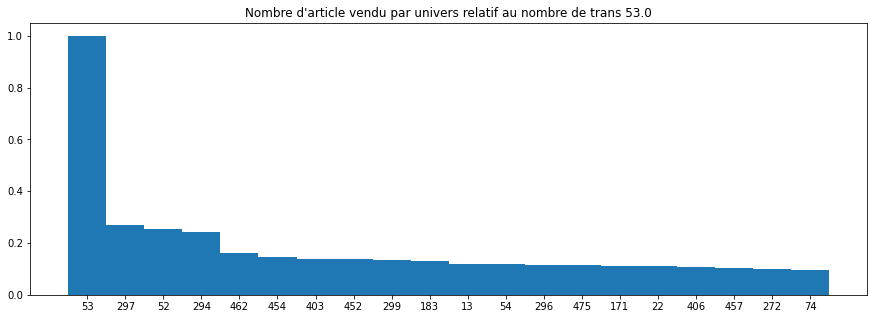

==============54.0===================
Proportion d'achat de univs 54.0 :  1.1 %
Nombre moyen d'achat en plus du univs 54.0 :  10.69
Proportion d'achat de univs 54.0 seul: 0.41 %
CA sans 54.0 :  790788.59
CA moyen sans 54.0 :  42.18
CA de 54.0 :  82719.77
CA moyen de 54.0 :  4.41


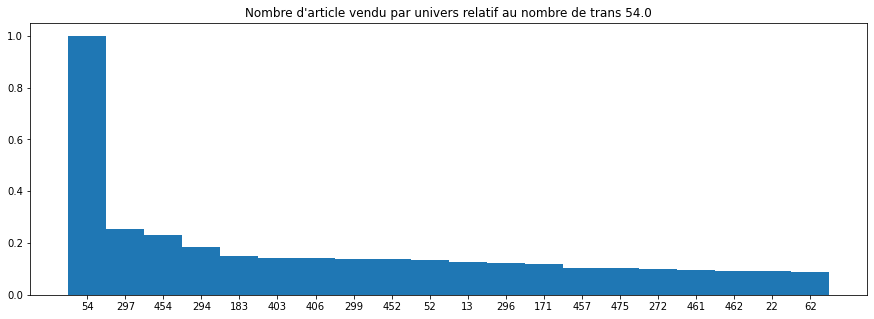

==============55.0===================
Proportion d'achat de univs 55.0 :  0.43 %
Nombre moyen d'achat en plus du univs 55.0 :  11.15
Proportion d'achat de univs 55.0 seul: 0.81 %
CA sans 55.0 :  316117.93
CA moyen sans 55.0 :  43.2
CA de 55.0 :  31038.51
CA moyen de 55.0 :  4.24


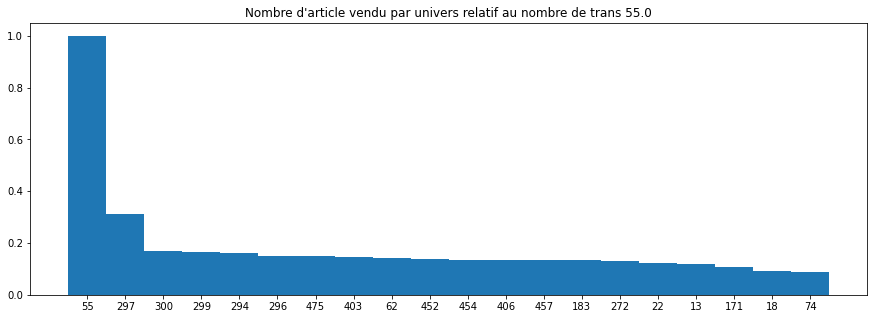

==============56.0===================
Proportion d'achat de univs 56.0 :  0.94 %
Nombre moyen d'achat en plus du univs 56.0 :  10.34
Proportion d'achat de univs 56.0 seul: 0.86 %
CA sans 56.0 :  635121.1
CA moyen sans 56.0 :  39.45
CA de 56.0 :  57333.1
CA moyen de 56.0 :  3.56


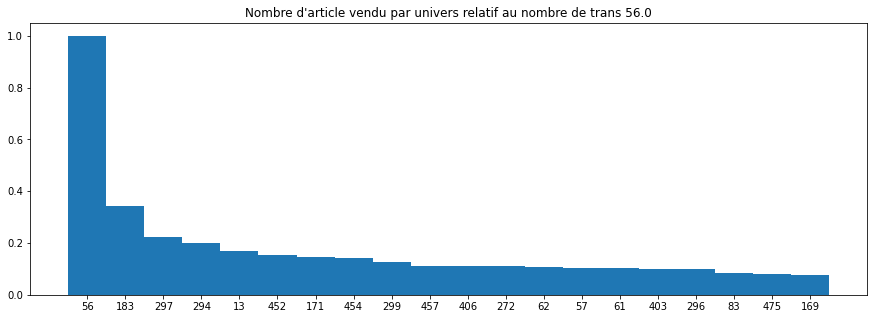

==============57.0===================
Proportion d'achat de univs 57.0 :  2.41 %
Nombre moyen d'achat en plus du univs 57.0 :  8.94
Proportion d'achat de univs 57.0 seul: 2.05 %
CA sans 57.0 :  1478221.17
CA moyen sans 57.0 :  35.94
CA de 57.0 :  197588.91
CA moyen de 57.0 :  4.8


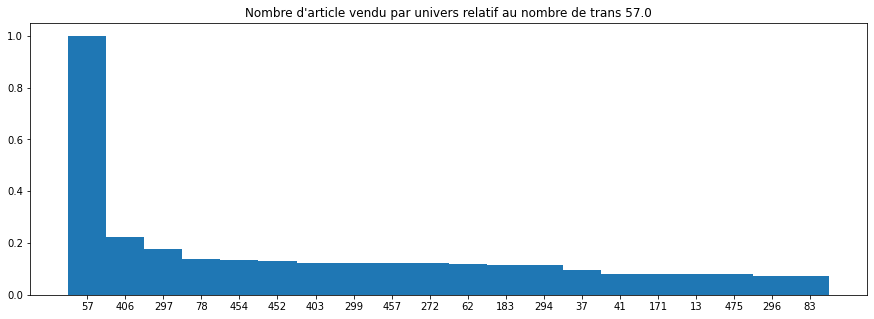

==============58.0===================
Proportion d'achat de univs 58.0 :  0.21 %
Nombre moyen d'achat en plus du univs 58.0 :  9.48
Proportion d'achat de univs 58.0 seul: 2.5 %
CA sans 58.0 :  141911.01
CA moyen sans 58.0 :  38.92
CA de 58.0 :  35863.17
CA moyen de 58.0 :  9.84


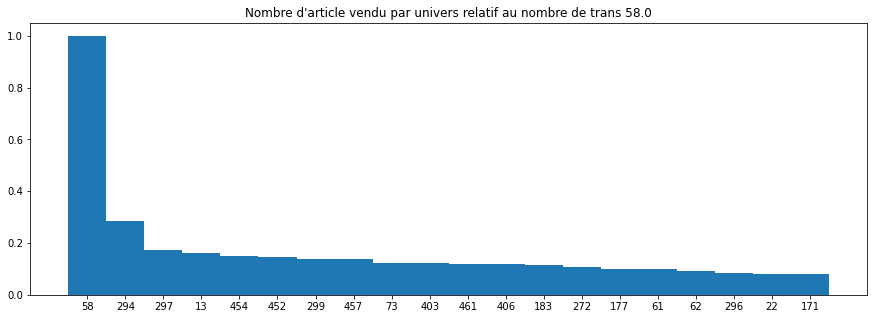

==============59.0===================
Proportion d'achat de univs 59.0 :  0.53 %
Nombre moyen d'achat en plus du univs 59.0 :  10.95
Proportion d'achat de univs 59.0 seul: 1.31 %
CA sans 59.0 :  372460.0
CA moyen sans 59.0 :  41.56
CA de 59.0 :  41589.49
CA moyen de 59.0 :  4.64


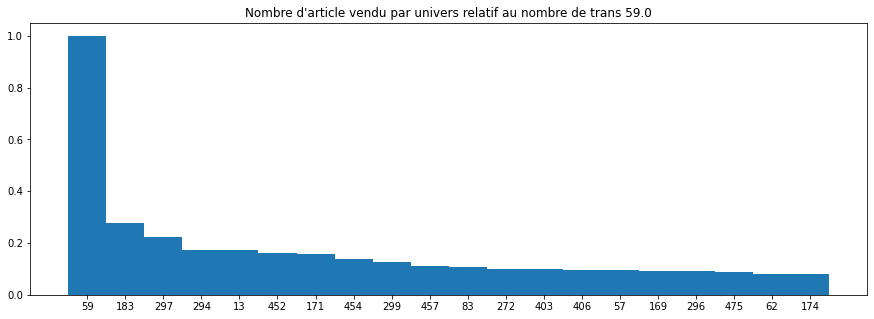

==============60.0===================
Proportion d'achat de univs 60.0 :  0.59 %
Nombre moyen d'achat en plus du univs 60.0 :  10.04
Proportion d'achat de univs 60.0 seul: 0.33 %
CA sans 60.0 :  385006.49
CA moyen sans 60.0 :  38.2
CA de 60.0 :  39277.5
CA moyen de 60.0 :  3.9


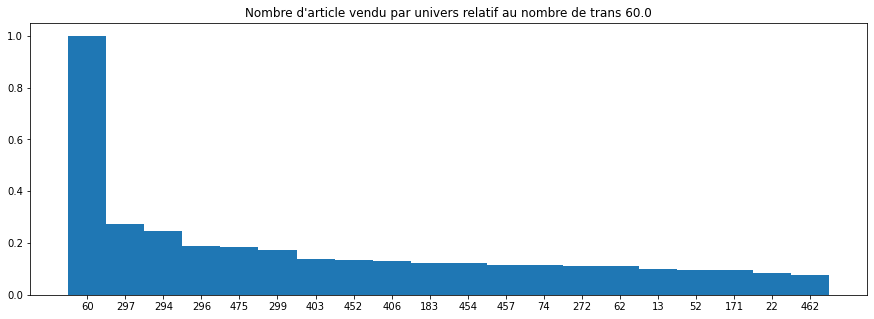

==============61.0===================
Proportion d'achat de univs 61.0 :  1.2 %
Nombre moyen d'achat en plus du univs 61.0 :  10.55
Proportion d'achat de univs 61.0 seul: 0.43 %
CA sans 61.0 :  851199.18
CA moyen sans 61.0 :  41.58
CA de 61.0 :  93413.14
CA moyen de 61.0 :  4.56


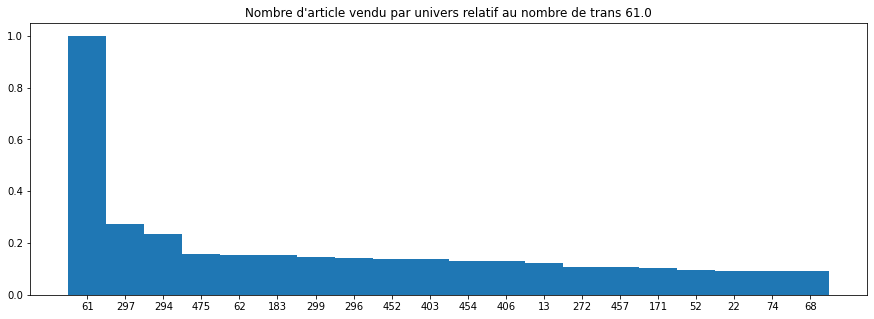

==============62.0===================
Proportion d'achat de univs 62.0 :  2.87 %
Nombre moyen d'achat en plus du univs 62.0 :  9.55
Proportion d'achat de univs 62.0 seul: 0.86 %
CA sans 62.0 :  1782819.05
CA moyen sans 62.0 :  36.39
CA de 62.0 :  217030.43
CA moyen de 62.0 :  4.43


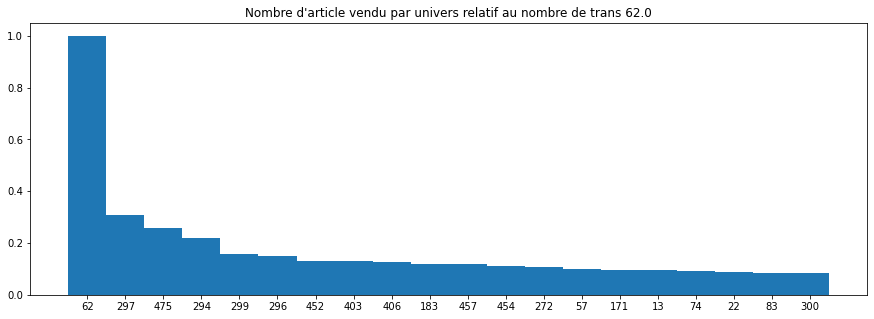

==============63.0===================
Proportion d'achat de univs 63.0 :  0.56 %
Nombre moyen d'achat en plus du univs 63.0 :  10.66
Proportion d'achat de univs 63.0 seul: 0.3 %
CA sans 63.0 :  413275.83
CA moyen sans 63.0 :  43.17
CA de 63.0 :  59868.65
CA moyen de 63.0 :  6.25


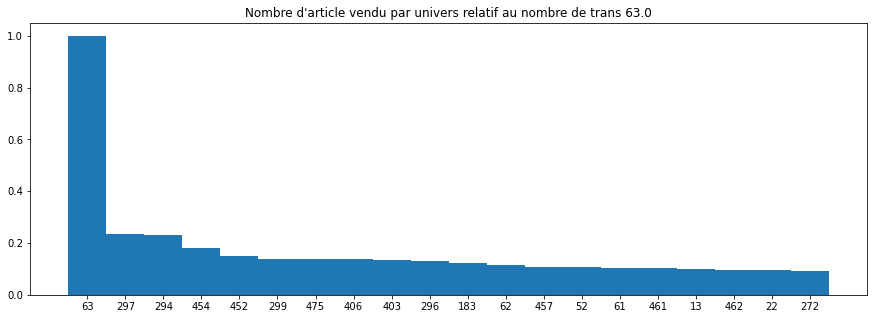

==============64.0===================
Proportion d'achat de univs 64.0 :  1.01 %
Nombre moyen d'achat en plus du univs 64.0 :  9.82
Proportion d'achat de univs 64.0 seul: 1.41 %
CA sans 64.0 :  643318.37
CA moyen sans 64.0 :  37.18
CA de 64.0 :  74821.38
CA moyen de 64.0 :  4.32


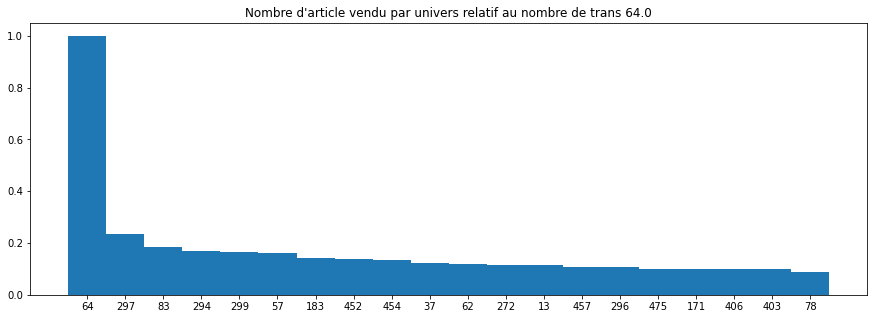

==============65.0===================
Proportion d'achat de univs 65.0 :  0.02 %
Nombre moyen d'achat en plus du univs 65.0 :  10.75
Proportion d'achat de univs 65.0 seul: 1.47 %
CA sans 65.0 :  13220.08
CA moyen sans 65.0 :  48.43
CA de 65.0 :  1966.3
CA moyen de 65.0 :  7.2


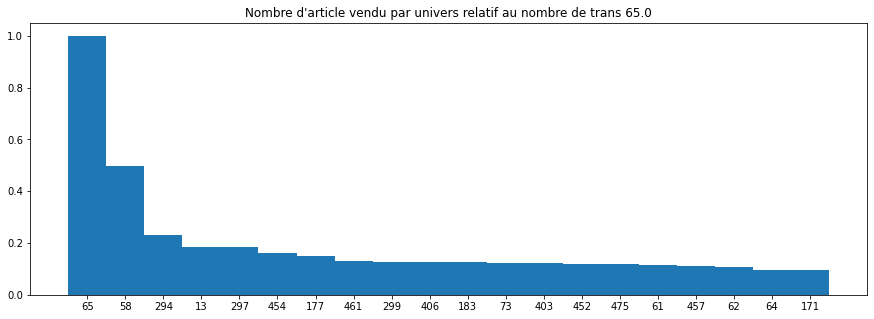

==============66.0===================
Proportion d'achat de univs 66.0 :  0.65 %
Nombre moyen d'achat en plus du univs 66.0 :  9.86
Proportion d'achat de univs 66.0 seul: 0.36 %
CA sans 66.0 :  427577.98
CA moyen sans 66.0 :  38.53
CA de 66.0 :  32949.41
CA moyen de 66.0 :  2.97


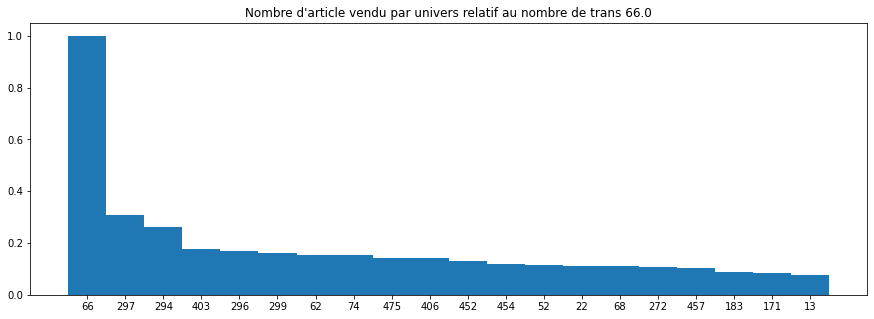

==============67.0===================
Proportion d'achat de univs 67.0 :  0.19 %
Nombre moyen d'achat en plus du univs 67.0 :  9.76
Proportion d'achat de univs 67.0 seul: 0.44 %
CA sans 67.0 :  129132.84
CA moyen sans 67.0 :  40.43
CA de 67.0 :  15386.24
CA moyen de 67.0 :  4.82


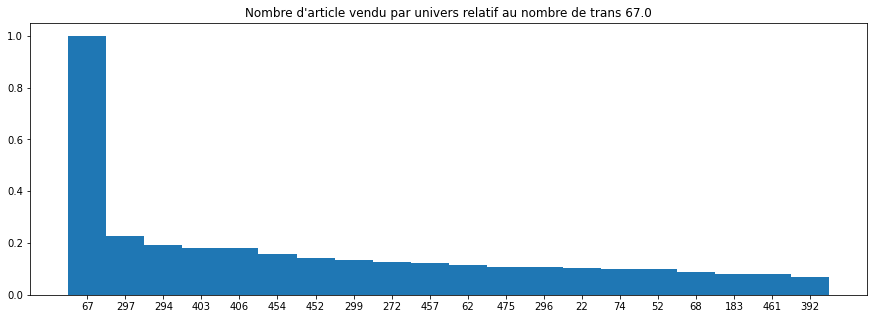

==============68.0===================
Proportion d'achat de univs 68.0 :  1.19 %
Nombre moyen d'achat en plus du univs 68.0 :  10.06
Proportion d'achat de univs 68.0 seul: 0.24 %
CA sans 68.0 :  772175.17
CA moyen sans 68.0 :  38.18
CA de 68.0 :  70751.86
CA moyen de 68.0 :  3.5


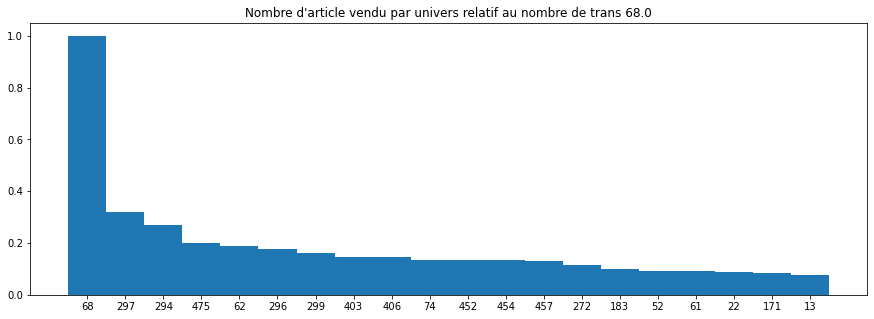

==============69.0===================
Proportion d'achat de univs 69.0 :  0.89 %
Nombre moyen d'achat en plus du univs 69.0 :  9.9
Proportion d'achat de univs 69.0 seul: 0.5 %
CA sans 69.0 :  566801.85
CA moyen sans 69.0 :  37.46
CA de 69.0 :  64584.64
CA moyen de 69.0 :  4.27


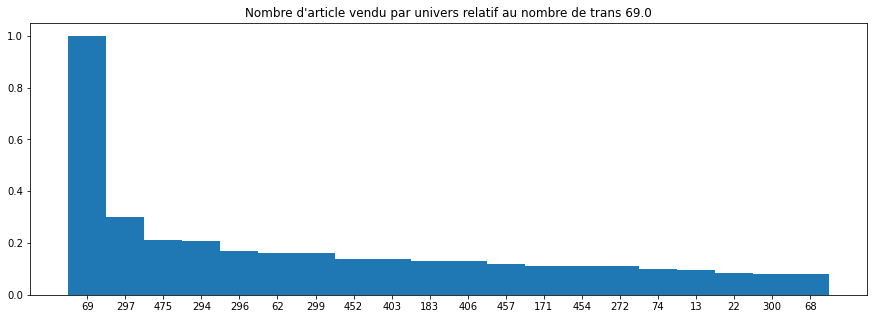

==============70.0===================
Proportion d'achat de univs 70.0 :  0.27 %
Nombre moyen d'achat en plus du univs 70.0 :  10.55
Proportion d'achat de univs 70.0 seul: 0.81 %
CA sans 70.0 :  200655.49
CA moyen sans 70.0 :  43.99
CA de 70.0 :  27171.41
CA moyen de 70.0 :  5.96


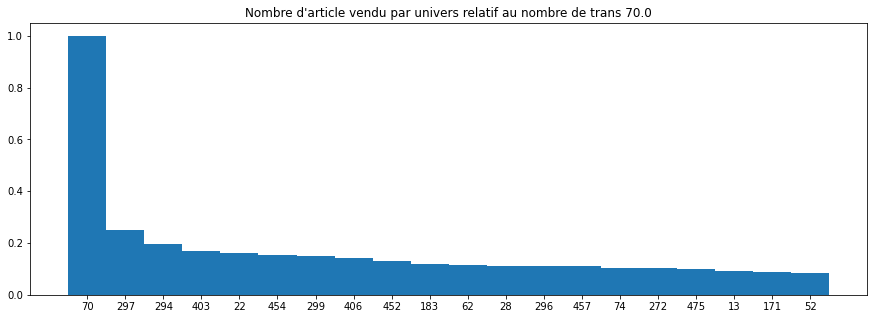

==============72.0===================
Proportion d'achat de univs 72.0 :  0.51 %
Nombre moyen d'achat en plus du univs 72.0 :  9.87
Proportion d'achat de univs 72.0 seul: 0.39 %
CA sans 72.0 :  317889.06
CA moyen sans 72.0 :  36.36
CA de 72.0 :  22977.34
CA moyen de 72.0 :  2.63


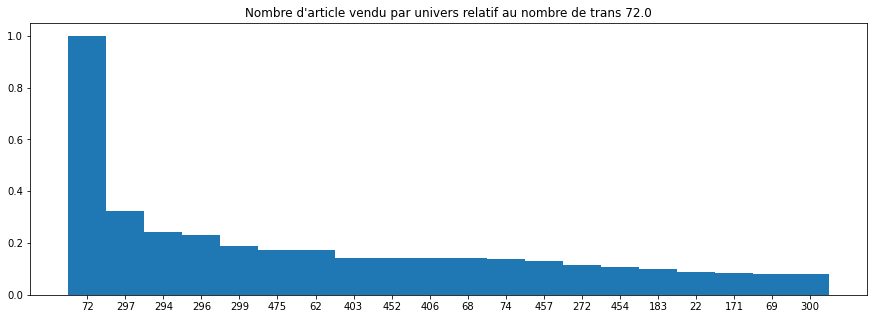

==============73.0===================
Proportion d'achat de univs 73.0 :  0.7 %
Nombre moyen d'achat en plus du univs 73.0 :  10.54
Proportion d'achat de univs 73.0 seul: 0.39 %
CA sans 73.0 :  491548.7
CA moyen sans 73.0 :  41.44
CA de 73.0 :  59260.49
CA moyen de 73.0 :  5.0


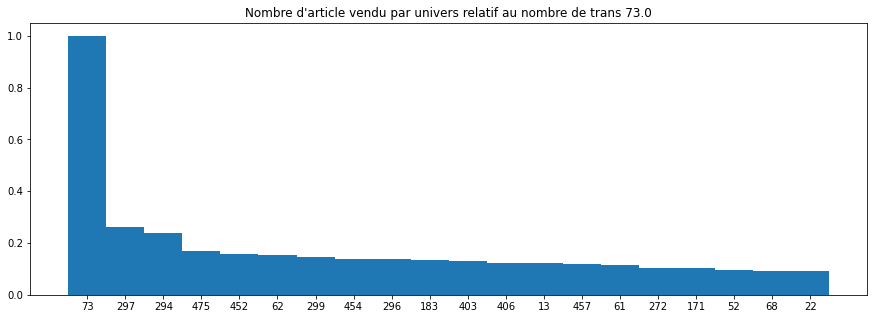

==============74.0===================
Proportion d'achat de univs 74.0 :  2.9 %
Nombre moyen d'achat en plus du univs 74.0 :  8.36
Proportion d'achat de univs 74.0 seul: 0.66 %
CA sans 74.0 :  1554292.74
CA moyen sans 74.0 :  31.37
CA de 74.0 :  218455.33
CA moyen de 74.0 :  4.41


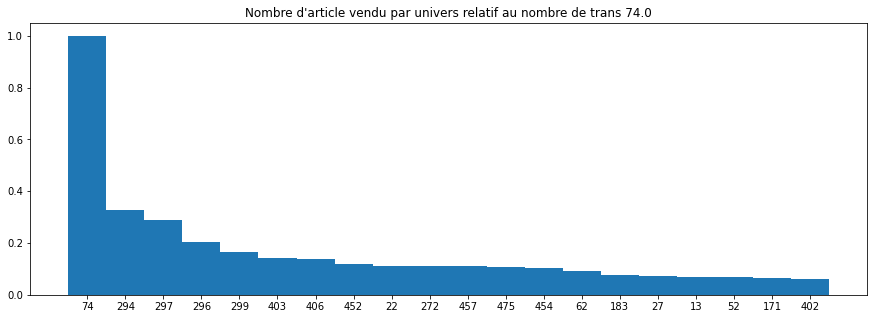

==============75.0===================
Proportion d'achat de univs 75.0 :  0.0 %
Nombre moyen d'achat en plus du univs 75.0 :  10.17
Proportion d'achat de univs 75.0 seul: 2.9 %
CA sans 75.0 :  2622.65
CA moyen sans 75.0 :  38.01
CA de 75.0 :  274.89
CA moyen de 75.0 :  3.98


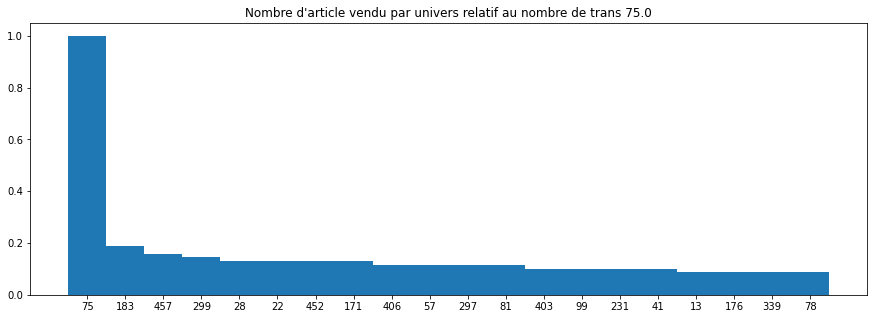

==============76.0===================
Proportion d'achat de univs 76.0 :  0.05 %
Nombre moyen d'achat en plus du univs 76.0 :  9.92
Proportion d'achat de univs 76.0 seul: 5.24 %
CA sans 76.0 :  29624.75
CA moyen sans 76.0 :  37.83
CA de 76.0 :  3911.04
CA moyen de 76.0 :  4.99


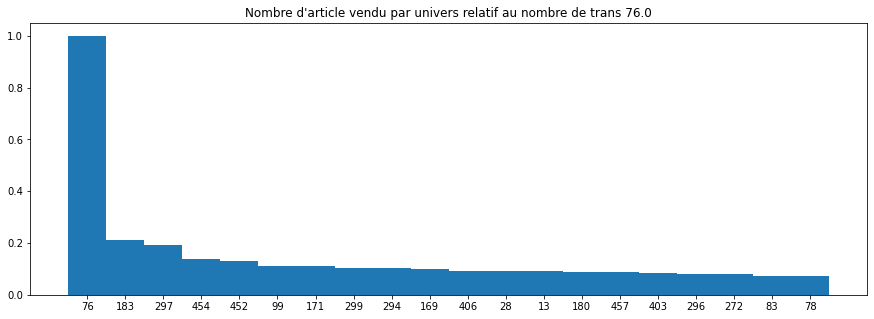

==============77.0===================
Proportion d'achat de univs 77.0 :  0.03 %
Nombre moyen d'achat en plus du univs 77.0 :  10.06
Proportion d'achat de univs 77.0 seul: 1.44 %
CA sans 77.0 :  18505.68
CA moyen sans 77.0 :  38.16
CA de 77.0 :  2238.94
CA moyen de 77.0 :  4.62


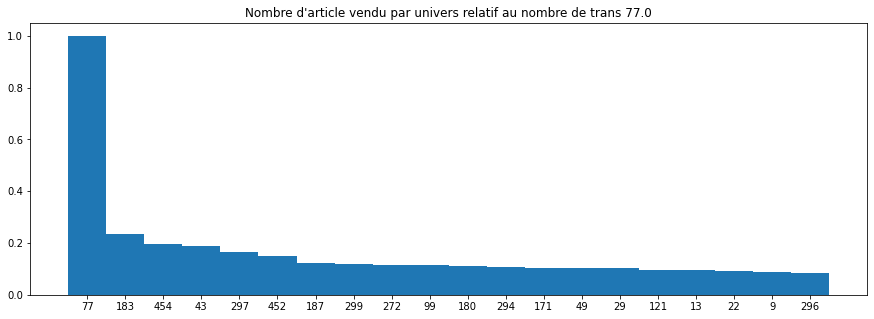

==============78.0===================
Proportion d'achat de univs 78.0 :  1.07 %
Nombre moyen d'achat en plus du univs 78.0 :  9.78
Proportion d'achat de univs 78.0 seul: 1.71 %
CA sans 78.0 :  690794.92
CA moyen sans 78.0 :  37.92
CA de 78.0 :  59259.62
CA moyen de 78.0 :  3.25


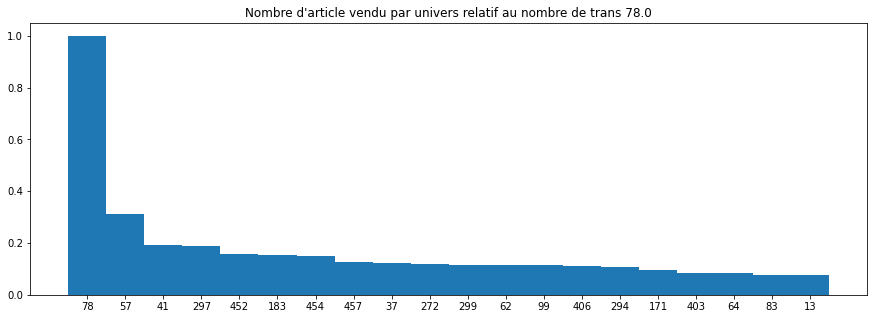

==============79.0===================
Proportion d'achat de univs 79.0 :  0.13 %
Nombre moyen d'achat en plus du univs 79.0 :  10.88
Proportion d'achat de univs 79.0 seul: 1.04 %
CA sans 79.0 :  100646.77
CA moyen sans 79.0 :  43.74
CA de 79.0 :  8884.2
CA moyen de 79.0 :  3.86


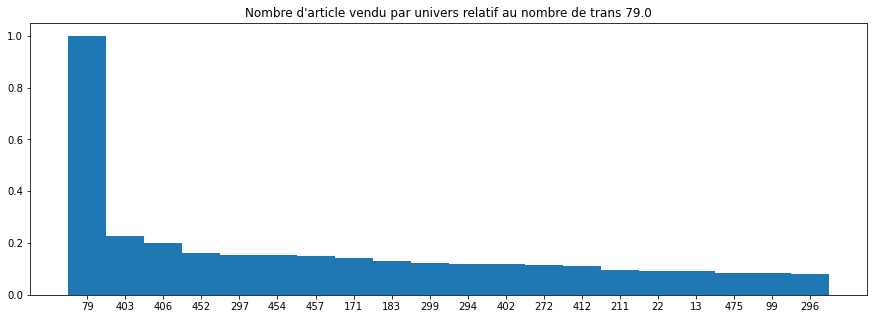

==============80.0===================
Proportion d'achat de univs 80.0 :  0.03 %
Nombre moyen d'achat en plus du univs 80.0 :  11.93
Proportion d'achat de univs 80.0 seul: 0.72 %
CA sans 80.0 :  27027.34
CA moyen sans 80.0 :  48.44
CA de 80.0 :  2804.67
CA moyen de 80.0 :  5.03


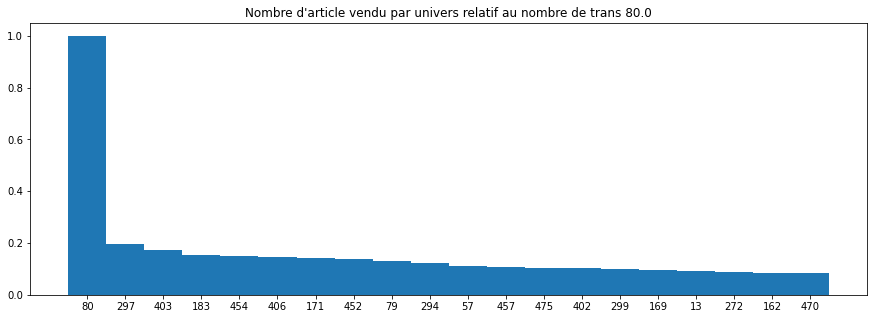

==============81.0===================
Proportion d'achat de univs 81.0 :  0.21 %
Nombre moyen d'achat en plus du univs 81.0 :  10.68
Proportion d'achat de univs 81.0 seul: 2.21 %
CA sans 81.0 :  155394.51
CA moyen sans 81.0 :  42.41
CA de 81.0 :  14592.79
CA moyen de 81.0 :  3.98


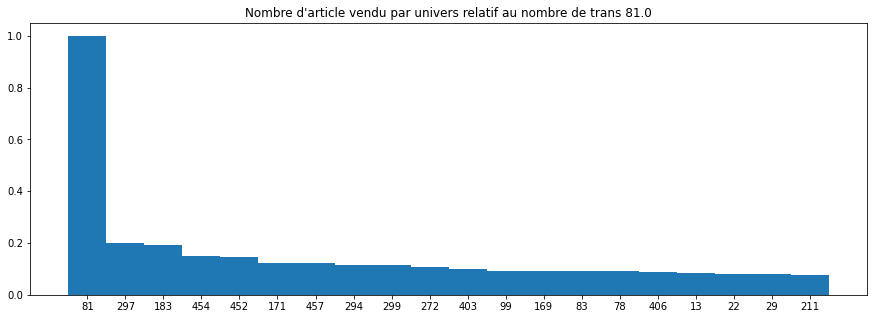

==============82.0===================
Proportion d'achat de univs 82.0 :  0.0 %
Nombre moyen d'achat en plus du univs 82.0 :  8.75
Proportion d'achat de univs 82.0 seul: 0.0 %
CA sans 82.0 :  3206.97
CA moyen sans 82.0 :  53.45
CA de 82.0 :  998.14
CA moyen de 82.0 :  16.64


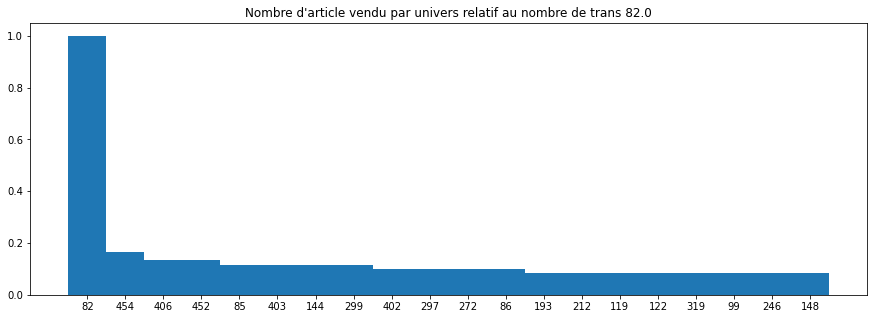

==============83.0===================
Proportion d'achat de univs 83.0 :  2.35 %
Nombre moyen d'achat en plus du univs 83.0 :  9.76
Proportion d'achat de univs 83.0 seul: 2.09 %
CA sans 83.0 :  1490496.72
CA moyen sans 83.0 :  37.22
CA de 83.0 :  148768.16
CA moyen de 83.0 :  3.72


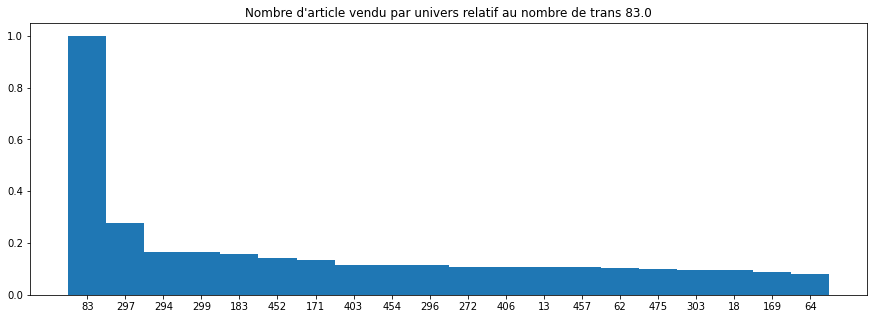

==============84.0===================
Proportion d'achat de univs 84.0 :  0.12 %
Nombre moyen d'achat en plus du univs 84.0 :  10.13
Proportion d'achat de univs 84.0 seul: 2.28 %
CA sans 84.0 :  79905.5
CA moyen sans 84.0 :  38.81
CA de 84.0 :  7969.64
CA moyen de 84.0 :  3.87


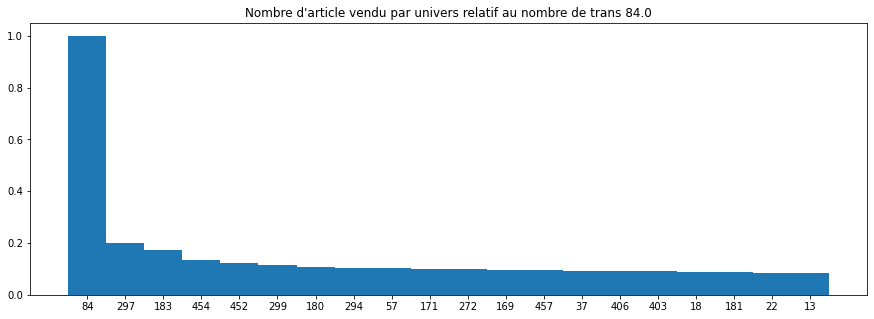

==============85.0===================
Proportion d'achat de univs 85.0 :  0.17 %
Nombre moyen d'achat en plus du univs 85.0 :  10.31
Proportion d'achat de univs 85.0 seul: 1.83 %
CA sans 85.0 :  123372.4
CA moyen sans 85.0 :  41.78
CA de 85.0 :  13072.71
CA moyen de 85.0 :  4.43


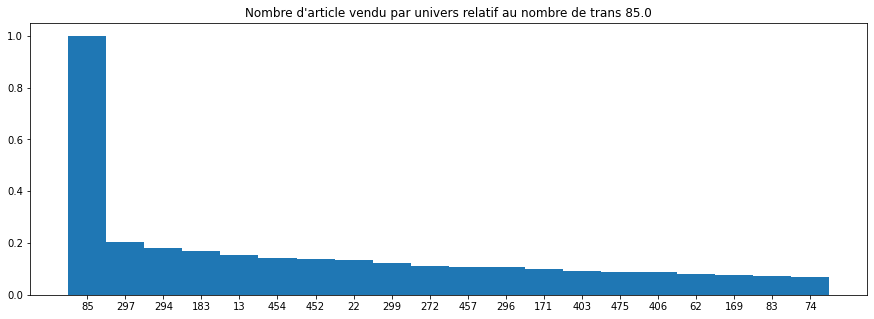

==============86.0===================
Proportion d'achat de univs 86.0 :  0.58 %
Nombre moyen d'achat en plus du univs 86.0 :  9.95
Proportion d'achat de univs 86.0 seul: 2.76 %
CA sans 86.0 :  405917.53
CA moyen sans 86.0 :  41.28
CA de 86.0 :  80919.92
CA moyen de 86.0 :  8.23


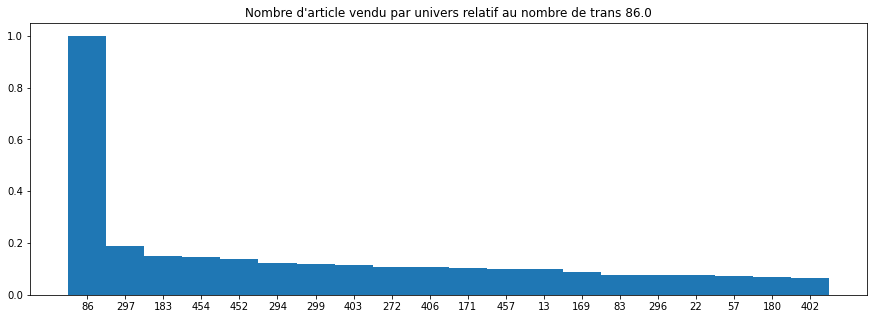

==============88.0===================
Proportion d'achat de univs 88.0 :  0.21 %
Nombre moyen d'achat en plus du univs 88.0 :  11.6
Proportion d'achat de univs 88.0 seul: 2.46 %
CA sans 88.0 :  175129.5
CA moyen sans 88.0 :  47.88
CA de 88.0 :  35325.38
CA moyen de 88.0 :  9.66


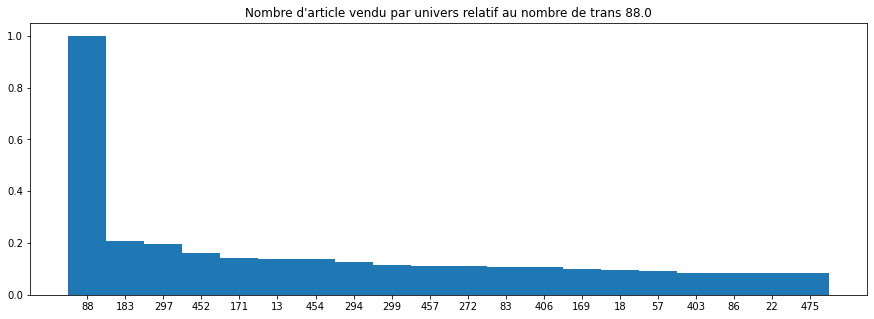

==============89.0===================
Proportion d'achat de univs 89.0 :  0.05 %
Nombre moyen d'achat en plus du univs 89.0 :  6.92
Proportion d'achat de univs 89.0 seul: 11.11 %
CA sans 89.0 :  21674.46
CA moyen sans 89.0 :  27.06
CA de 89.0 :  8612.52
CA moyen de 89.0 :  10.75


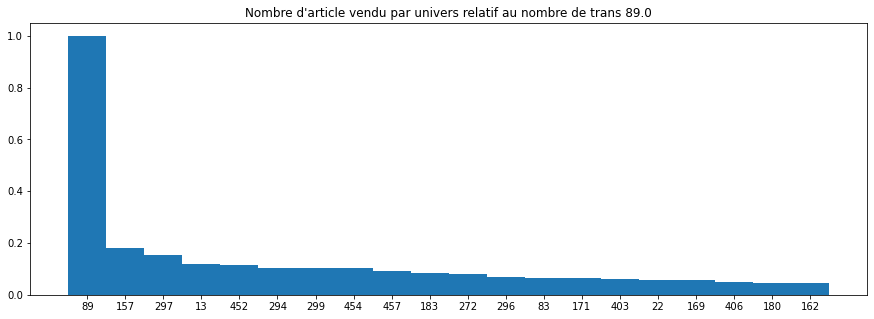

==============90.0===================
Proportion d'achat de univs 90.0 :  0.08 %
Nombre moyen d'achat en plus du univs 90.0 :  8.58
Proportion d'achat de univs 90.0 seul: 2.95 %
CA sans 90.0 :  53843.21
CA moyen sans 90.0 :  38.68
CA de 90.0 :  16757.61
CA moyen de 90.0 :  12.04


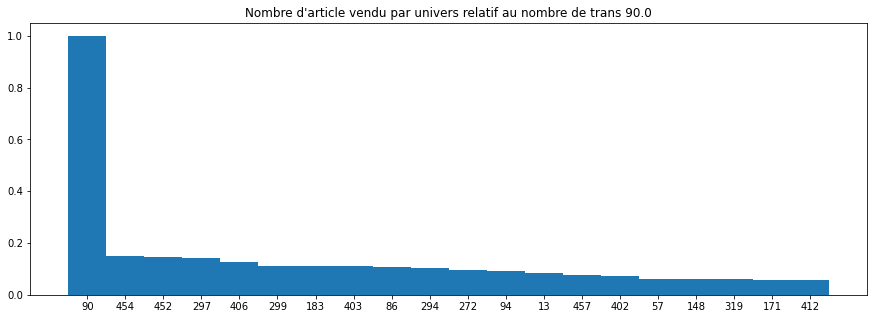

==============91.0===================
Proportion d'achat de univs 91.0 :  0.1 %
Nombre moyen d'achat en plus du univs 91.0 :  9.03
Proportion d'achat de univs 91.0 seul: 4.64 %
CA sans 91.0 :  61142.08
CA moyen sans 91.0 :  37.33
CA de 91.0 :  8907.17
CA moyen de 91.0 :  5.44


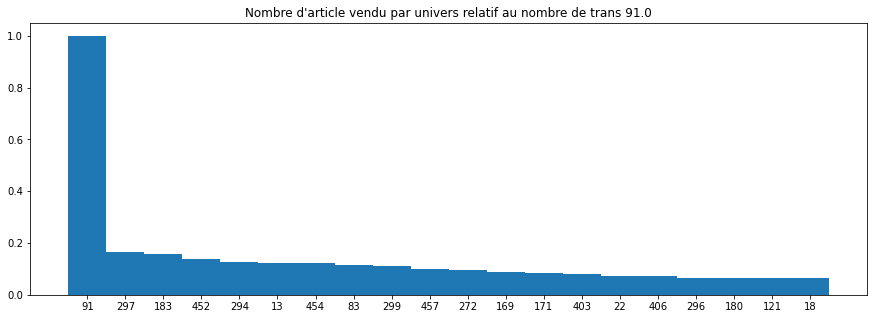

==============92.0===================
Proportion d'achat de univs 92.0 :  0.26 %
Nombre moyen d'achat en plus du univs 92.0 :  9.02
Proportion d'achat de univs 92.0 seul: 0.34 %
CA sans 92.0 :  157919.86
CA moyen sans 92.0 :  36.15
CA de 92.0 :  9280.89
CA moyen de 92.0 :  2.12


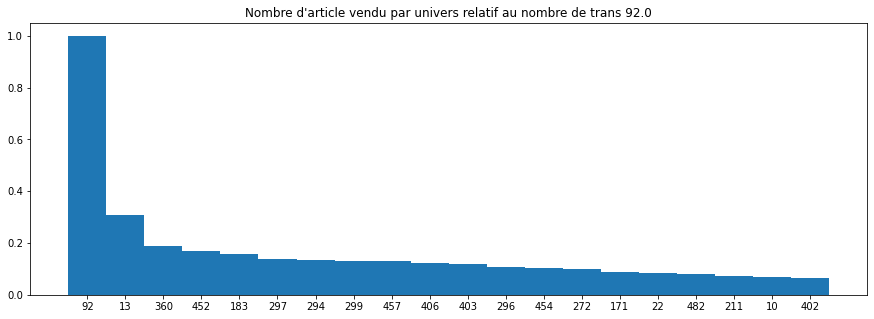

==============93.0===================
Proportion d'achat de univs 93.0 :  0.11 %
Nombre moyen d'achat en plus du univs 93.0 :  10.43
Proportion d'achat de univs 93.0 seul: 1.35 %
CA sans 93.0 :  82921.77
CA moyen sans 93.0 :  43.08
CA de 93.0 :  13211.16
CA moyen de 93.0 :  6.86


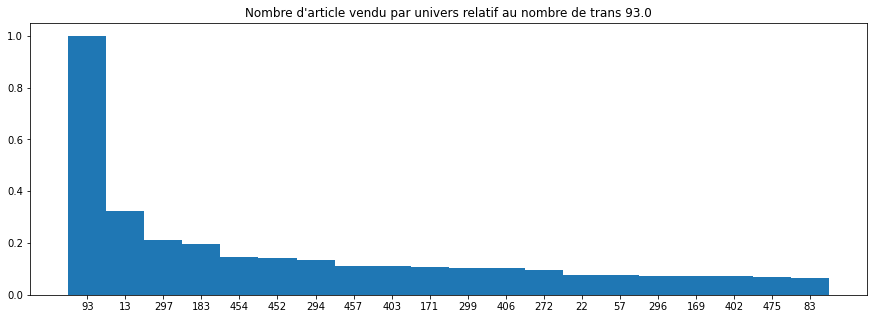

==============94.0===================
Proportion d'achat de univs 94.0 :  0.14 %
Nombre moyen d'achat en plus du univs 94.0 :  10.4
Proportion d'achat de univs 94.0 seul: 1.86 %
CA sans 94.0 :  103110.65
CA moyen sans 94.0 :  42.68
CA de 94.0 :  12239.95
CA moyen de 94.0 :  5.07


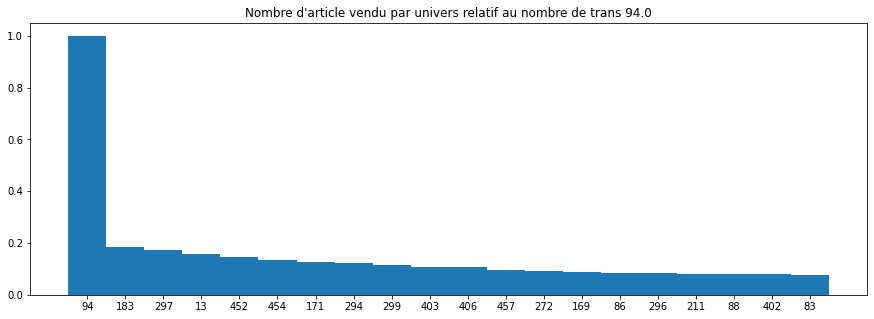

==============95.0===================
Proportion d'achat de univs 95.0 :  0.13 %
Nombre moyen d'achat en plus du univs 95.0 :  9.17
Proportion d'achat de univs 95.0 seul: 3.97 %
CA sans 95.0 :  74032.07
CA moyen sans 95.0 :  34.19
CA de 95.0 :  6313.77
CA moyen de 95.0 :  2.92


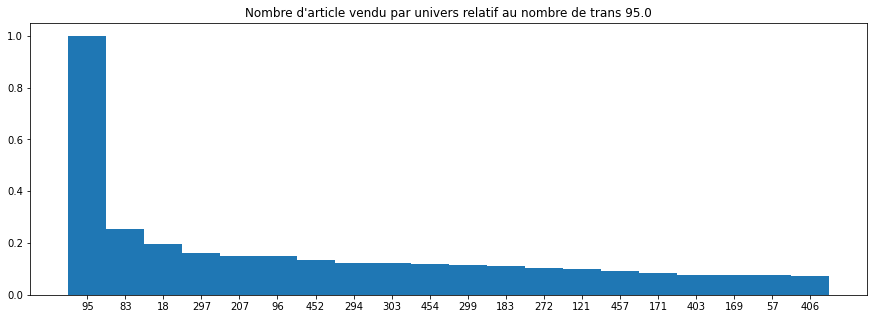

==============96.0===================
Proportion d'achat de univs 96.0 :  0.25 %
Nombre moyen d'achat en plus du univs 96.0 :  9.67
Proportion d'achat de univs 96.0 seul: 2.6 %
CA sans 96.0 :  158157.04
CA moyen sans 96.0 :  36.41
CA de 96.0 :  13933.59
CA moyen de 96.0 :  3.21


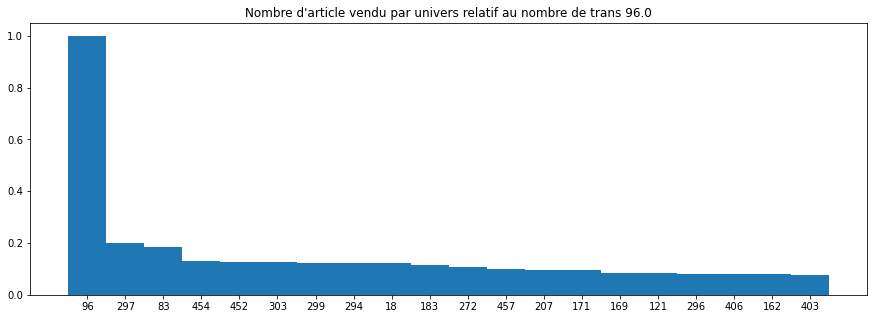

==============98.0===================
Proportion d'achat de univs 98.0 :  0.76 %
Nombre moyen d'achat en plus du univs 98.0 :  9.6
Proportion d'achat de univs 98.0 seul: 1.61 %
CA sans 98.0 :  485269.62
CA moyen sans 98.0 :  37.49
CA de 98.0 :  40231.49
CA moyen de 98.0 :  3.11


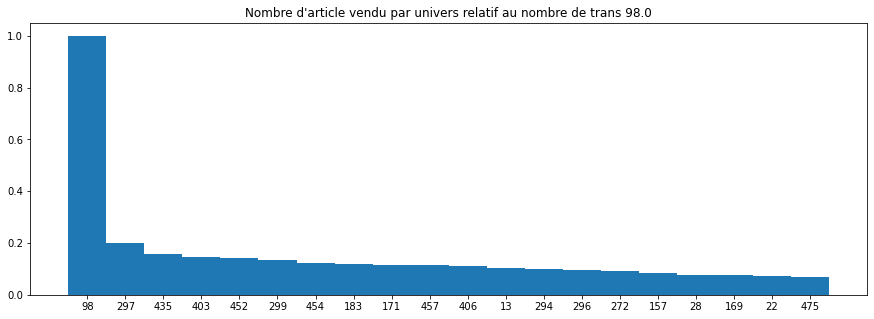

==============99.0===================
Proportion d'achat de univs 99.0 :  0.94 %
Nombre moyen d'achat en plus du univs 99.0 :  10.27
Proportion d'achat de univs 99.0 seul: 1.79 %
CA sans 99.0 :  635286.34
CA moyen sans 99.0 :  39.42
CA de 99.0 :  55801.14
CA moyen de 99.0 :  3.46


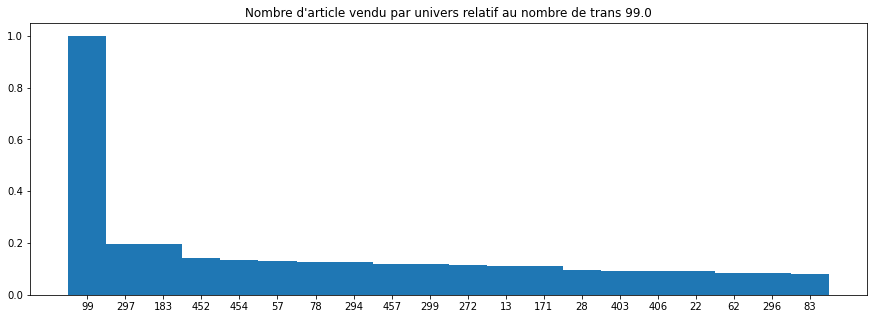

==============100.0===================
Proportion d'achat de univs 100.0 :  0.31 %
Nombre moyen d'achat en plus du univs 100.0 :  9.48
Proportion d'achat de univs 100.0 seul: 1.75 %
CA sans 100.0 :  203989.99
CA moyen sans 100.0 :  37.99
CA de 100.0 :  25498.82
CA moyen de 100.0 :  4.75


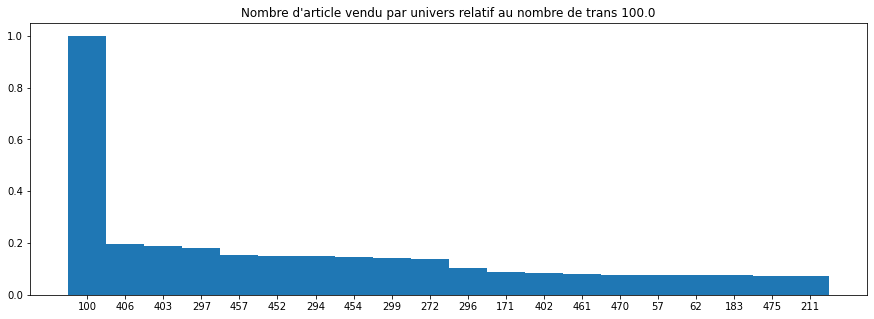

==============101.0===================
Proportion d'achat de univs 101.0 :  0.41 %
Nombre moyen d'achat en plus du univs 101.0 :  11.43
Proportion d'achat de univs 101.0 seul: 0.81 %
CA sans 101.0 :  306365.18
CA moyen sans 101.0 :  43.75
CA de 101.0 :  33446.88
CA moyen de 101.0 :  4.78


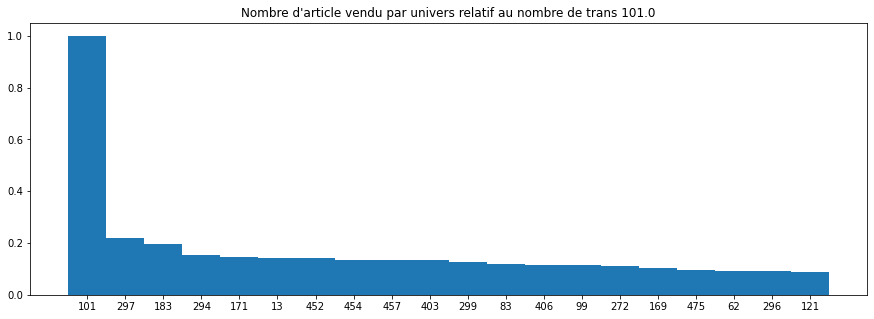

==============102.0===================
Proportion d'achat de univs 102.0 :  0.14 %
Nombre moyen d'achat en plus du univs 102.0 :  9.33
Proportion d'achat de univs 102.0 seul: 1.19 %
CA sans 102.0 :  81152.65
CA moyen sans 102.0 :  34.4
CA de 102.0 :  11768.2
CA moyen de 102.0 :  4.99


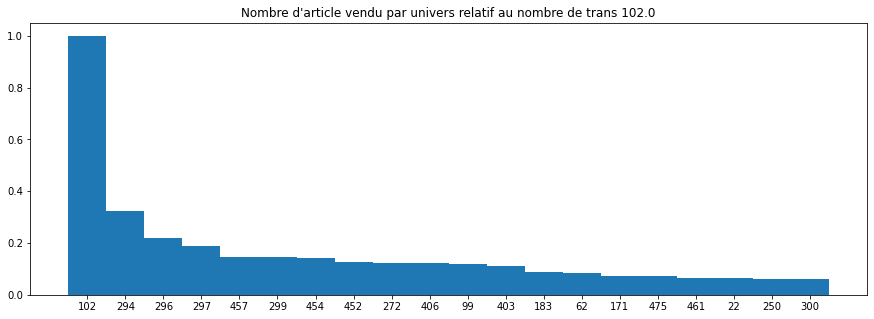

==============105.0===================
Proportion d'achat de univs 105.0 :  0.03 %
Nombre moyen d'achat en plus du univs 105.0 :  8.11
Proportion d'achat de univs 105.0 seul: 4.56 %
CA sans 105.0 :  13400.7
CA moyen sans 105.0 :  30.53
CA de 105.0 :  1675.77
CA moyen de 105.0 :  3.82


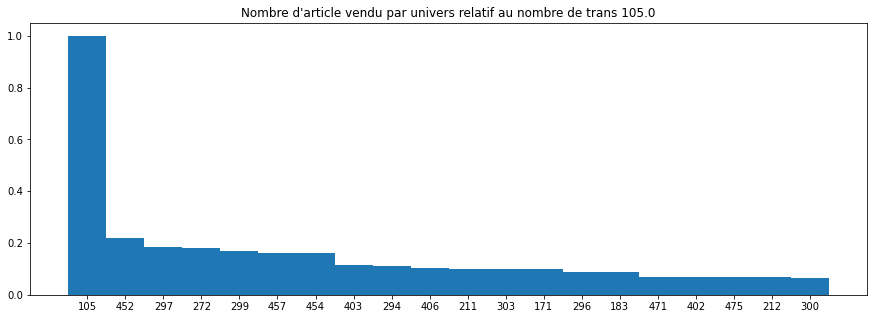

==============106.0===================
Proportion d'achat de univs 106.0 :  0.04 %
Nombre moyen d'achat en plus du univs 106.0 :  8.01
Proportion d'achat de univs 106.0 seul: 4.11 %
CA sans 106.0 :  19392.14
CA moyen sans 106.0 :  28.43
CA de 106.0 :  2875.91
CA moyen de 106.0 :  4.22


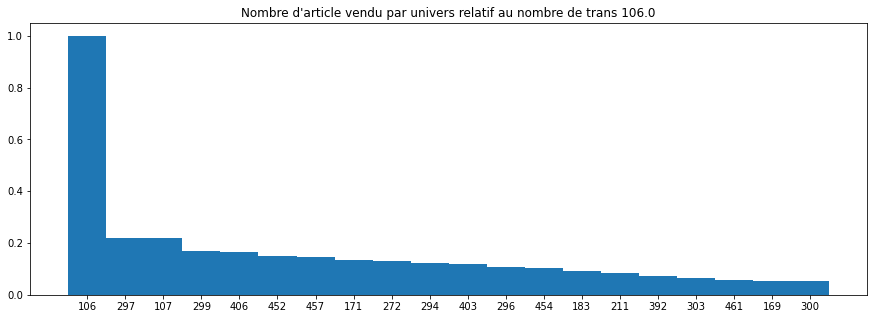

==============107.0===================
Proportion d'achat de univs 107.0 :  0.07 %
Nombre moyen d'achat en plus du univs 107.0 :  9.63
Proportion d'achat de univs 107.0 seul: 1.34 %
CA sans 107.0 :  38635.47
CA moyen sans 107.0 :  34.56
CA de 107.0 :  3528.25
CA moyen de 107.0 :  3.16


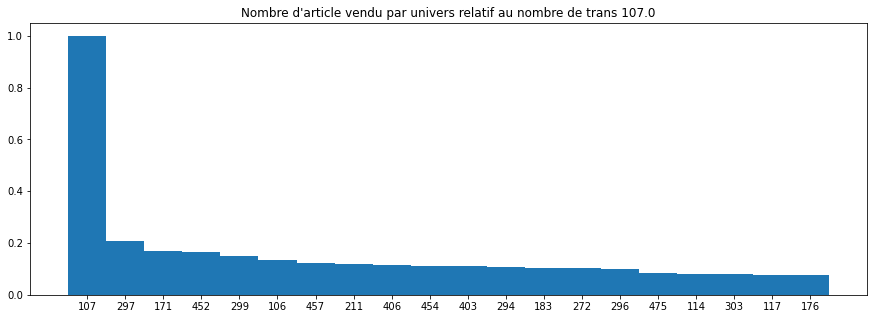

==============108.0===================
Proportion d'achat de univs 108.0 :  0.03 %
Nombre moyen d'achat en plus du univs 108.0 :  6.8
Proportion d'achat de univs 108.0 seul: 3.28 %
CA sans 108.0 :  14007.2
CA moyen sans 108.0 :  28.7
CA de 108.0 :  2595.66
CA moyen de 108.0 :  5.32


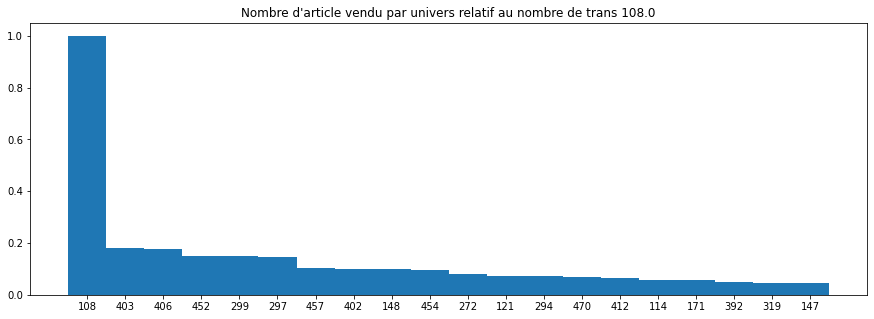

==============109.0===================
Proportion d'achat de univs 109.0 :  0.09 %
Nombre moyen d'achat en plus du univs 109.0 :  8.48
Proportion d'achat de univs 109.0 seul: 1.12 %
CA sans 109.0 :  60794.67
CA moyen sans 109.0 :  37.97
CA de 109.0 :  11225.25
CA moyen de 109.0 :  7.01


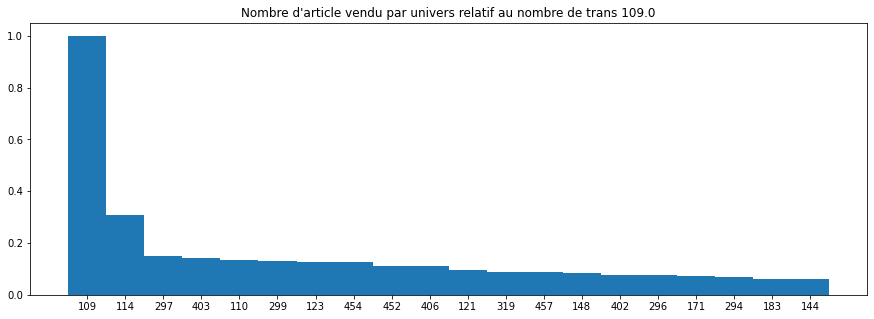

==============110.0===================
Proportion d'achat de univs 110.0 :  1.8 %
Nombre moyen d'achat en plus du univs 110.0 :  8.66
Proportion d'achat de univs 110.0 seul: 0.82 %
CA sans 110.0 :  1002638.71
CA moyen sans 110.0 :  32.7
CA de 110.0 :  101108.89
CA moyen de 110.0 :  3.3


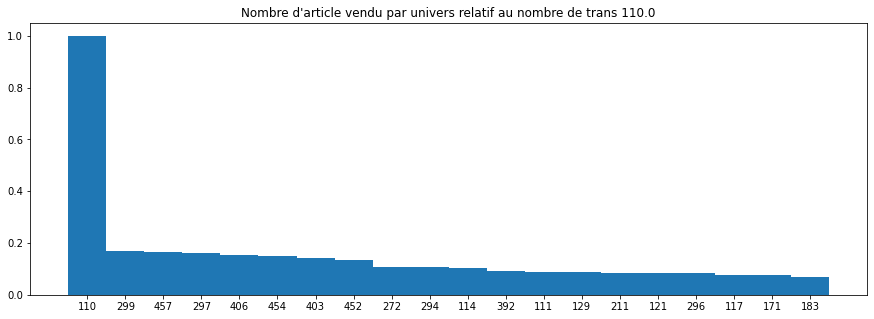

==============111.0===================
Proportion d'achat de univs 111.0 :  1.27 %
Nombre moyen d'achat en plus du univs 111.0 :  9.1
Proportion d'achat de univs 111.0 seul: 0.82 %
CA sans 111.0 :  736117.61
CA moyen sans 111.0 :  34.08
CA de 111.0 :  65458.98
CA moyen de 111.0 :  3.03


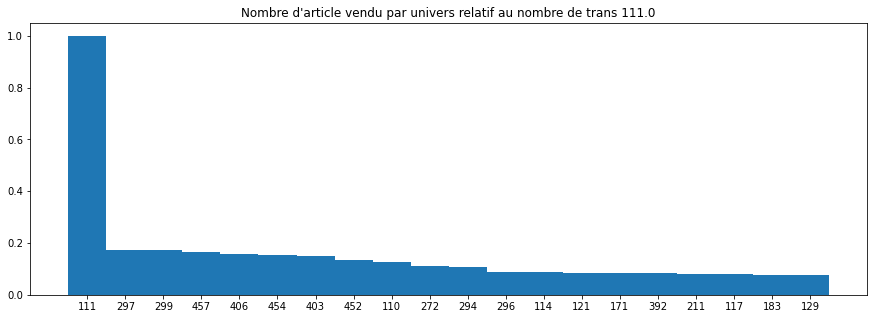

==============112.0===================
Proportion d'achat de univs 112.0 :  0.17 %
Nombre moyen d'achat en plus du univs 112.0 :  8.95
Proportion d'achat de univs 112.0 seul: 1.42 %
CA sans 112.0 :  103499.97
CA moyen sans 112.0 :  35.78
CA de 112.0 :  15193.23
CA moyen de 112.0 :  5.25


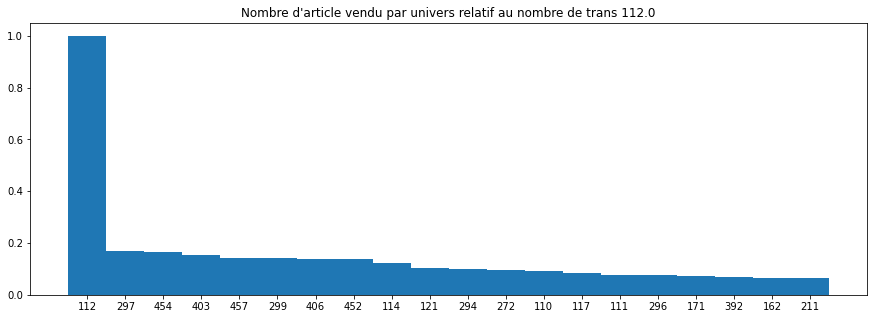

==============113.0===================
Proportion d'achat de univs 113.0 :  0.63 %
Nombre moyen d'achat en plus du univs 113.0 :  7.57
Proportion d'achat de univs 113.0 seul: 1.04 %
CA sans 113.0 :  297140.97
CA moyen sans 113.0 :  27.74
CA de 113.0 :  33151.19
CA moyen de 113.0 :  3.1


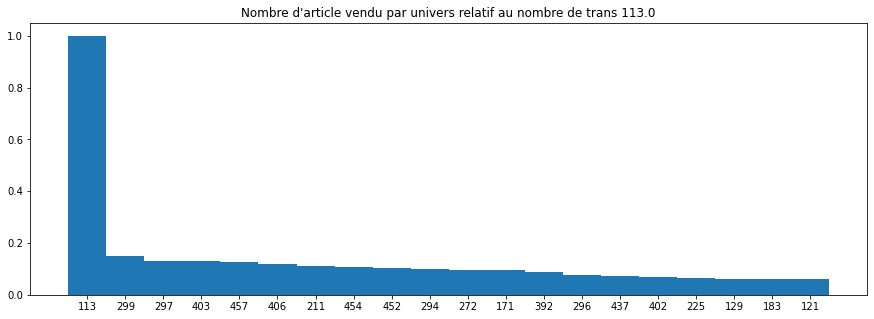

==============114.0===================
Proportion d'achat de univs 114.0 :  1.76 %
Nombre moyen d'achat en plus du univs 114.0 :  9.02
Proportion d'achat de univs 114.0 seul: 1.32 %
CA sans 114.0 :  1083010.34
CA moyen sans 114.0 :  35.98
CA de 114.0 :  134686.16
CA moyen de 114.0 :  4.47


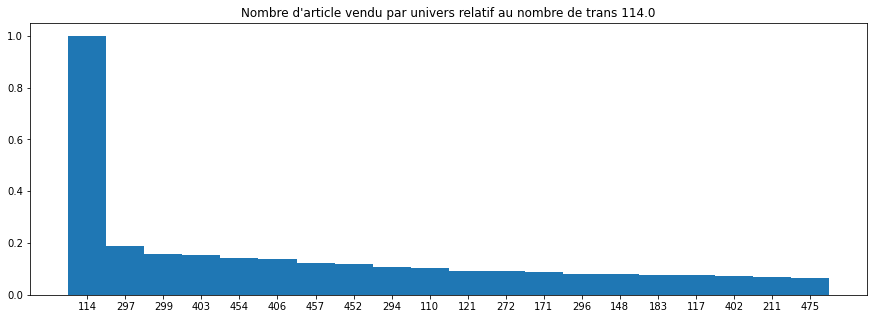

==============115.0===================
Proportion d'achat de univs 115.0 :  0.71 %
Nombre moyen d'achat en plus du univs 115.0 :  9.68
Proportion d'achat de univs 115.0 seul: 0.71 %
CA sans 115.0 :  448941.12
CA moyen sans 115.0 :  37.07
CA de 115.0 :  42960.79
CA moyen de 115.0 :  3.55


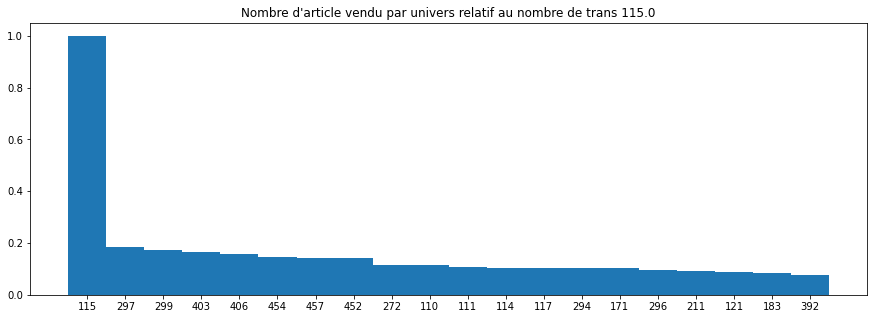

==============116.0===================
Proportion d'achat de univs 116.0 :  0.65 %
Nombre moyen d'achat en plus du univs 116.0 :  7.96
Proportion d'achat de univs 116.0 seul: 1.36 %
CA sans 116.0 :  333419.0
CA moyen sans 116.0 :  29.89
CA de 116.0 :  46414.13
CA moyen de 116.0 :  4.16


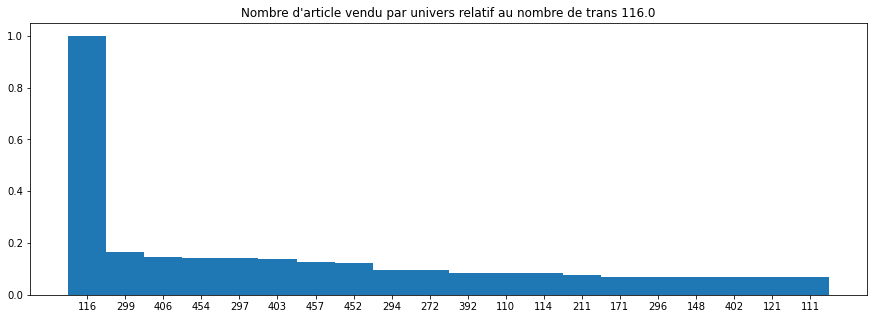

==============117.0===================
Proportion d'achat de univs 117.0 :  2.0 %
Nombre moyen d'achat en plus du univs 117.0 :  8.35
Proportion d'achat de univs 117.0 seul: 0.92 %
CA sans 117.0 :  1098041.76
CA moyen sans 117.0 :  32.12
CA de 117.0 :  109193.39
CA moyen de 117.0 :  3.19


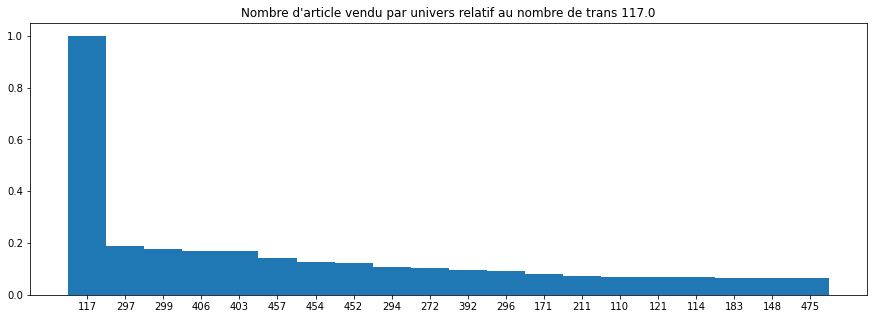

==============118.0===================
Proportion d'achat de univs 118.0 :  0.05 %
Nombre moyen d'achat en plus du univs 118.0 :  9.14
Proportion d'achat de univs 118.0 seul: 2.11 %
CA sans 118.0 :  35866.64
CA moyen sans 118.0 :  39.81
CA de 118.0 :  6546.7
CA moyen de 118.0 :  7.27


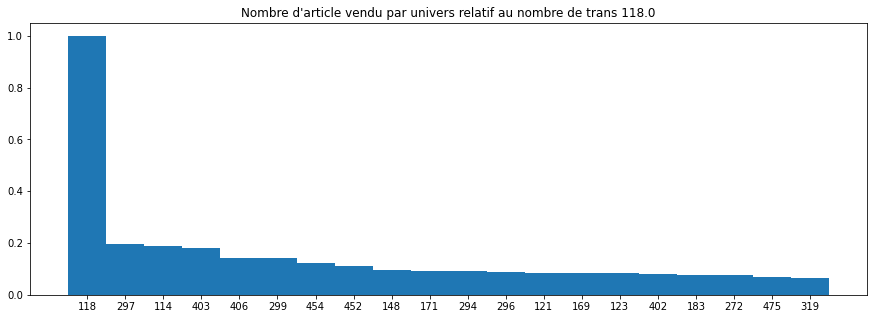

==============119.0===================
Proportion d'achat de univs 119.0 :  0.15 %
Nombre moyen d'achat en plus du univs 119.0 :  8.09
Proportion d'achat de univs 119.0 seul: 2.67 %
CA sans 119.0 :  84834.72
CA moyen sans 119.0 :  33.35
CA de 119.0 :  17440.55
CA moyen de 119.0 :  6.86


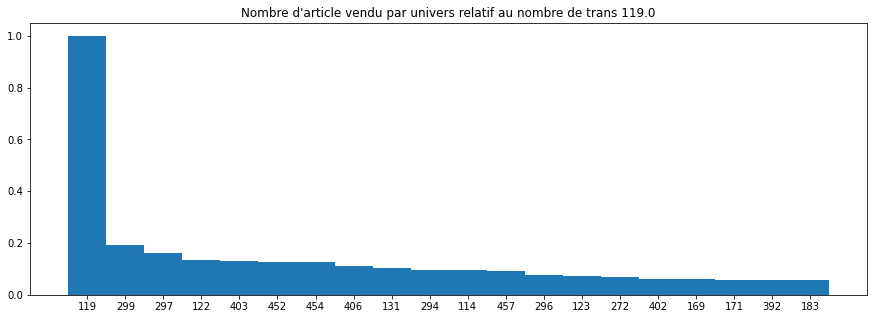

==============120.0===================
Proportion d'achat de univs 120.0 :  1.65 %
Nombre moyen d'achat en plus du univs 120.0 :  6.97
Proportion d'achat de univs 120.0 seul: 1.07 %
CA sans 120.0 :  756505.46
CA moyen sans 120.0 :  26.82
CA de 120.0 :  76051.31
CA moyen de 120.0 :  2.7


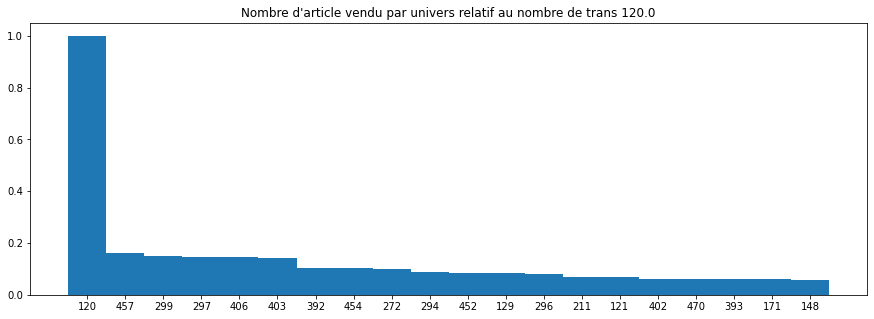

==============121.0===================
Proportion d'achat de univs 121.0 :  2.44 %
Nombre moyen d'achat en plus du univs 121.0 :  8.75
Proportion d'achat de univs 121.0 seul: 1.23 %
CA sans 121.0 :  1445969.83
CA moyen sans 121.0 :  34.78
CA de 121.0 :  213211.53
CA moyen de 121.0 :  5.13


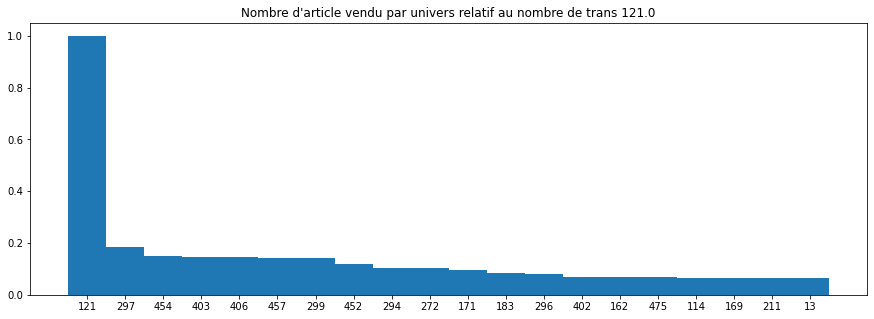

==============122.0===================
Proportion d'achat de univs 122.0 :  0.85 %
Nombre moyen d'achat en plus du univs 122.0 :  8.15
Proportion d'achat de univs 122.0 seul: 2.29 %
CA sans 122.0 :  479956.23
CA moyen sans 122.0 :  33.19
CA de 122.0 :  107764.19
CA moyen de 122.0 :  7.45


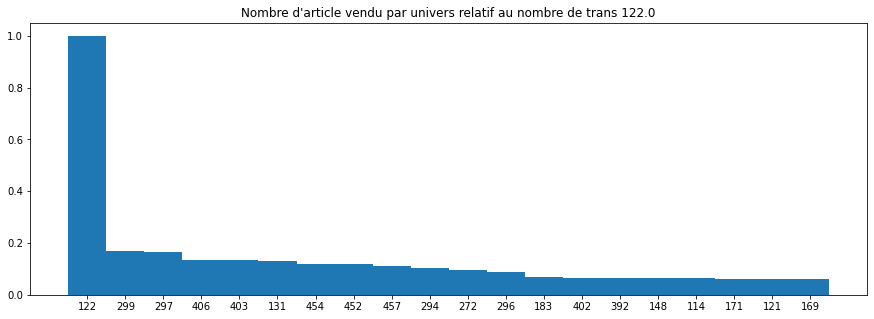

==============123.0===================
Proportion d'achat de univs 123.0 :  0.92 %
Nombre moyen d'achat en plus du univs 123.0 :  8.15
Proportion d'achat de univs 123.0 seul: 3.38 %
CA sans 123.0 :  550274.81
CA moyen sans 123.0 :  35.09
CA de 123.0 :  156158.33
CA moyen de 123.0 :  9.96


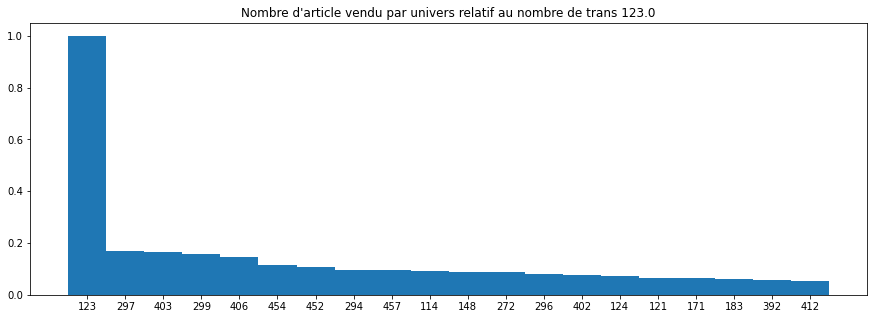

==============124.0===================
Proportion d'achat de univs 124.0 :  0.6 %
Nombre moyen d'achat en plus du univs 124.0 :  8.76
Proportion d'achat de univs 124.0 seul: 1.38 %
CA sans 124.0 :  364129.13
CA moyen sans 124.0 :  35.55
CA de 124.0 :  55650.66
CA moyen de 124.0 :  5.43


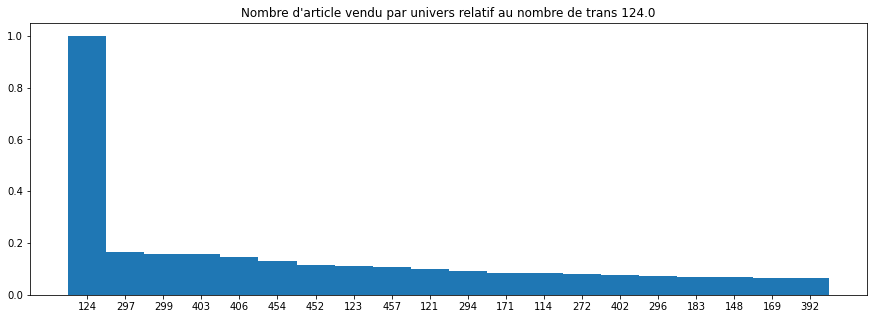

==============125.0===================
Proportion d'achat de univs 125.0 :  0.0 %
Nombre moyen d'achat en plus du univs 125.0 :  8.0
Proportion d'achat de univs 125.0 seul: 1.23 %
CA sans 125.0 :  2896.84
CA moyen sans 125.0 :  35.76
CA de 125.0 :  570.46
CA moyen de 125.0 :  7.04


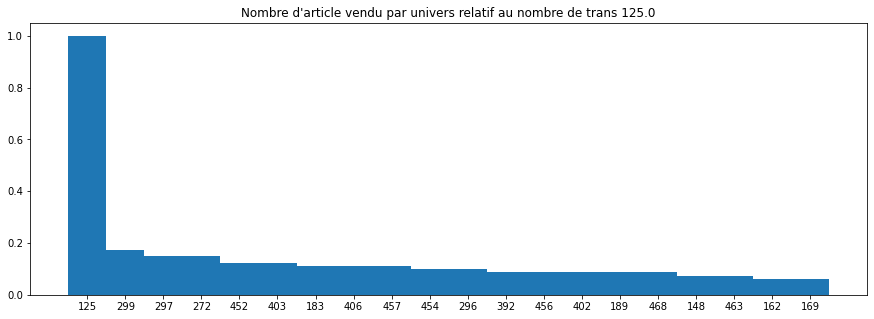

==============126.0===================
Proportion d'achat de univs 126.0 :  0.72 %
Nombre moyen d'achat en plus du univs 126.0 :  6.65
Proportion d'achat de univs 126.0 seul: 1.27 %
CA sans 126.0 :  302946.99
CA moyen sans 126.0 :  24.67
CA de 126.0 :  30414.06
CA moyen de 126.0 :  2.48


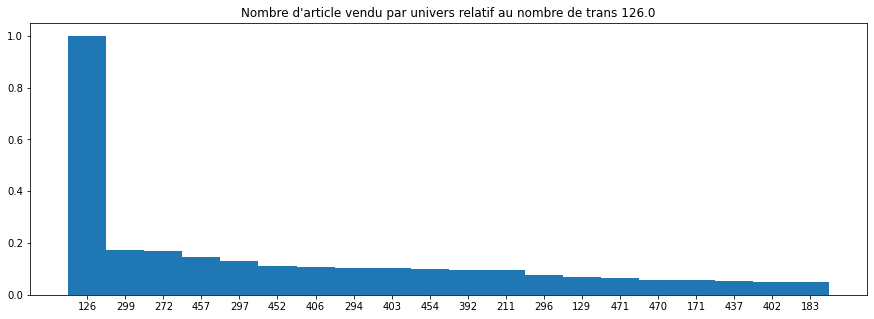

==============127.0===================
Proportion d'achat de univs 127.0 :  0.22 %
Nombre moyen d'achat en plus du univs 127.0 :  7.81
Proportion d'achat de univs 127.0 seul: 1.17 %
CA sans 127.0 :  114937.15
CA moyen sans 127.0 :  31.2
CA de 127.0 :  15683.2
CA moyen de 127.0 :  4.26


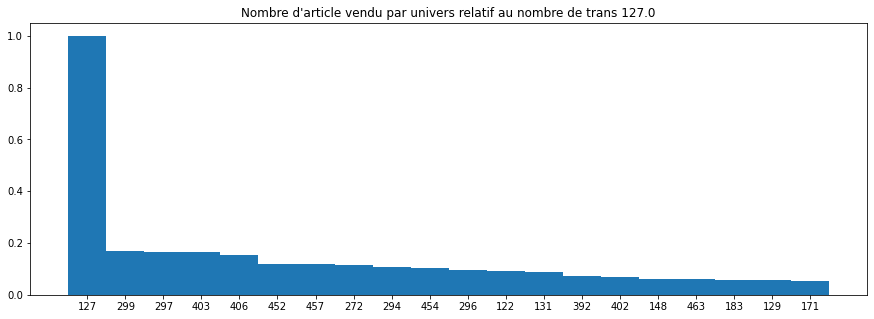

==============128.0===================
Proportion d'achat de univs 128.0 :  0.31 %
Nombre moyen d'achat en plus du univs 128.0 :  8.16
Proportion d'achat de univs 128.0 seul: 1.55 %
CA sans 128.0 :  174710.59
CA moyen sans 128.0 :  32.98
CA de 128.0 :  22493.21
CA moyen de 128.0 :  4.25


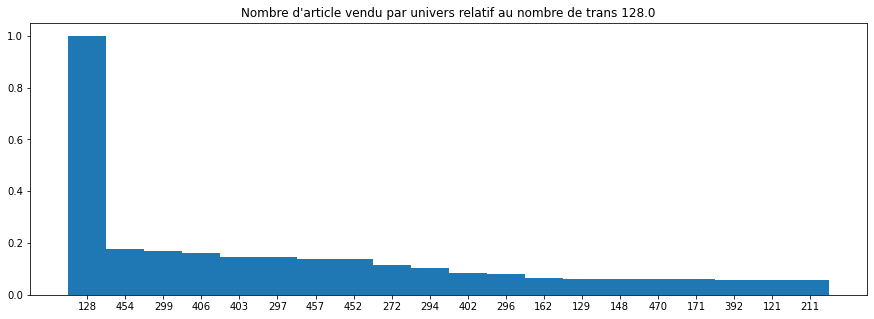

==============129.0===================
Proportion d'achat de univs 129.0 :  2.82 %
Nombre moyen d'achat en plus du univs 129.0 :  6.53
Proportion d'achat de univs 129.0 seul: 0.96 %
CA sans 129.0 :  1150286.53
CA moyen sans 129.0 :  23.94
CA de 129.0 :  109267.93
CA moyen de 129.0 :  2.27


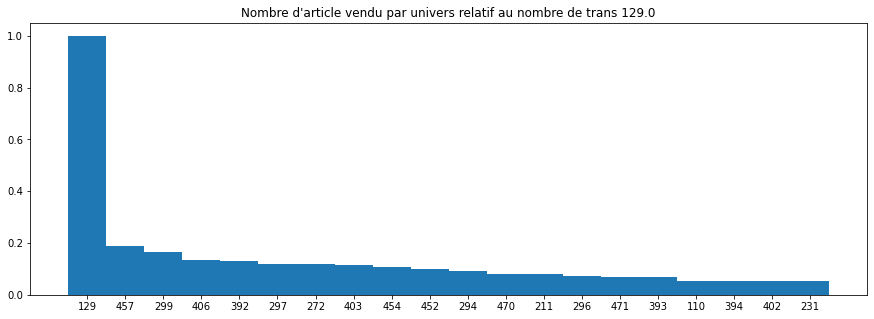

==============130.0===================
Proportion d'achat de univs 130.0 :  0.8 %
Nombre moyen d'achat en plus du univs 130.0 :  8.9
Proportion d'achat de univs 130.0 seul: 0.88 %
CA sans 130.0 :  461873.32
CA moyen sans 130.0 :  34.02
CA de 130.0 :  60316.9
CA moyen de 130.0 :  4.44


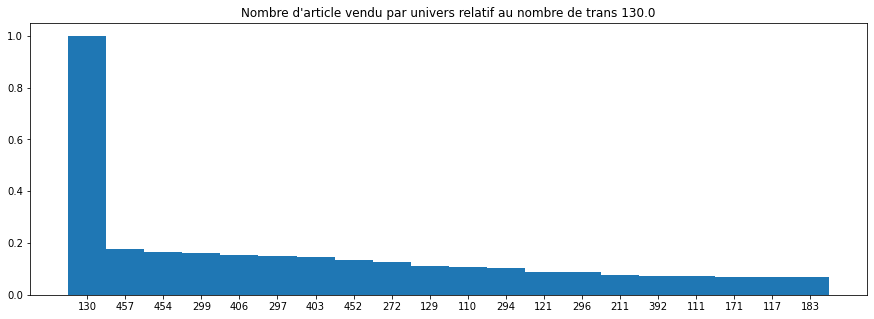

==============131.0===================
Proportion d'achat de univs 131.0 :  0.84 %
Nombre moyen d'achat en plus du univs 131.0 :  7.81
Proportion d'achat de univs 131.0 seul: 1.61 %
CA sans 131.0 :  430638.65
CA moyen sans 131.0 :  30.16
CA de 131.0 :  70085.19
CA moyen de 131.0 :  4.91


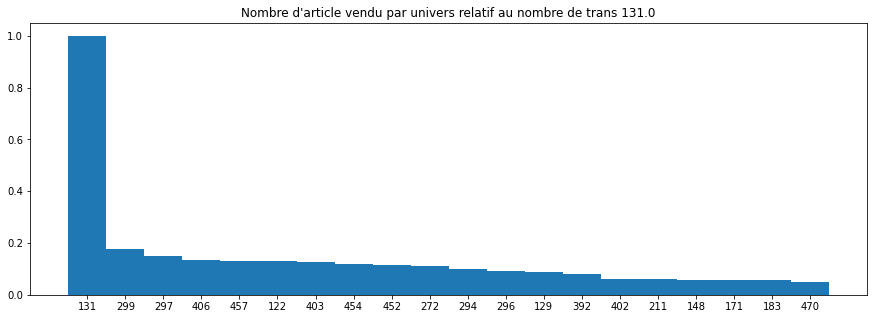

==============132.0===================
Proportion d'achat de univs 132.0 :  0.79 %
Nombre moyen d'achat en plus du univs 132.0 :  7.64
Proportion d'achat de univs 132.0 seul: 0.9 %
CA sans 132.0 :  395364.81
CA moyen sans 132.0 :  29.25
CA de 132.0 :  44576.41
CA moyen de 132.0 :  3.3


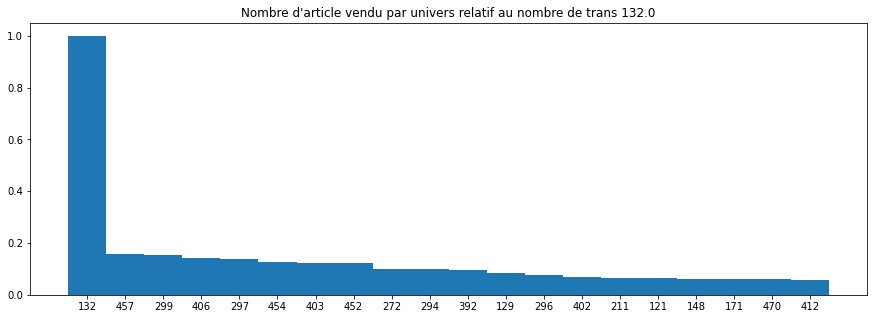

==============133.0===================
Proportion d'achat de univs 133.0 :  0.82 %
Nombre moyen d'achat en plus du univs 133.0 :  10.35
Proportion d'achat de univs 133.0 seul: 1.17 %
CA sans 133.0 :  557057.26
CA moyen sans 133.0 :  39.59
CA de 133.0 :  40696.89
CA moyen de 133.0 :  2.89


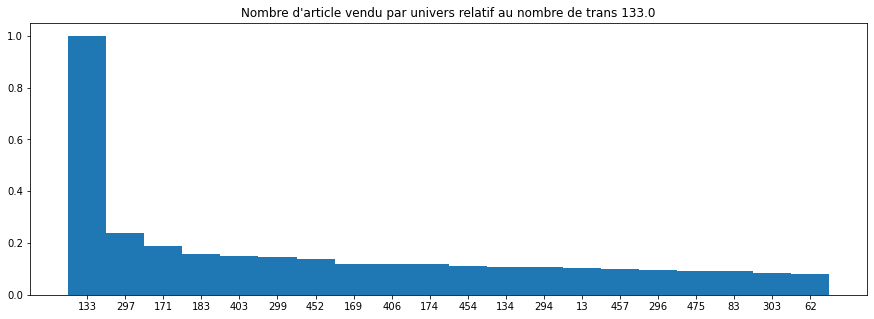

==============134.0===================
Proportion d'achat de univs 134.0 :  1.58 %
Nombre moyen d'achat en plus du univs 134.0 :  8.93
Proportion d'achat de univs 134.0 seul: 1.1 %
CA sans 134.0 :  916699.93
CA moyen sans 134.0 :  33.95
CA de 134.0 :  88439.67
CA moyen de 134.0 :  3.28


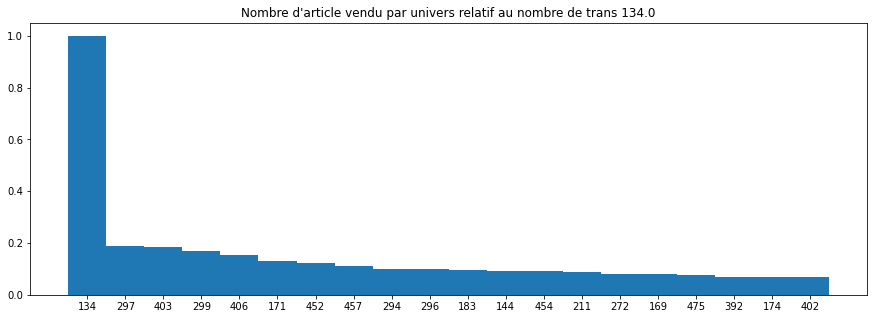

==============135.0===================
Proportion d'achat de univs 135.0 :  0.37 %
Nombre moyen d'achat en plus du univs 135.0 :  7.78
Proportion d'achat de univs 135.0 seul: 1.58 %
CA sans 135.0 :  180369.47
CA moyen sans 135.0 :  28.56
CA de 135.0 :  22977.03
CA moyen de 135.0 :  3.64


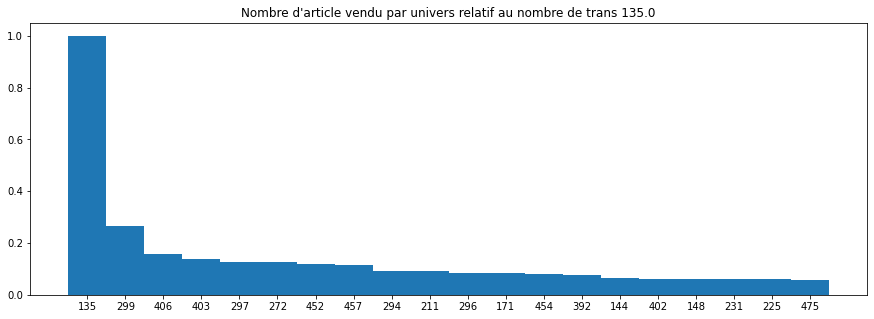

==============136.0===================
Proportion d'achat de univs 136.0 :  0.36 %
Nombre moyen d'achat en plus du univs 136.0 :  10.89
Proportion d'achat de univs 136.0 seul: 0.94 %
CA sans 136.0 :  253360.97
CA moyen sans 136.0 :  41.14
CA de 136.0 :  15484.23
CA moyen de 136.0 :  2.51


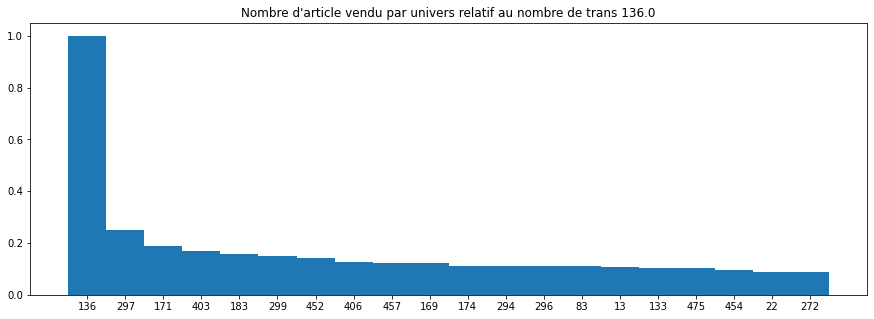

==============137.0===================
Proportion d'achat de univs 137.0 :  0.72 %
Nombre moyen d'achat en plus du univs 137.0 :  8.71
Proportion d'achat de univs 137.0 seul: 0.47 %
CA sans 137.0 :  403346.59
CA moyen sans 137.0 :  33.02
CA de 137.0 :  31214.73
CA moyen de 137.0 :  2.56


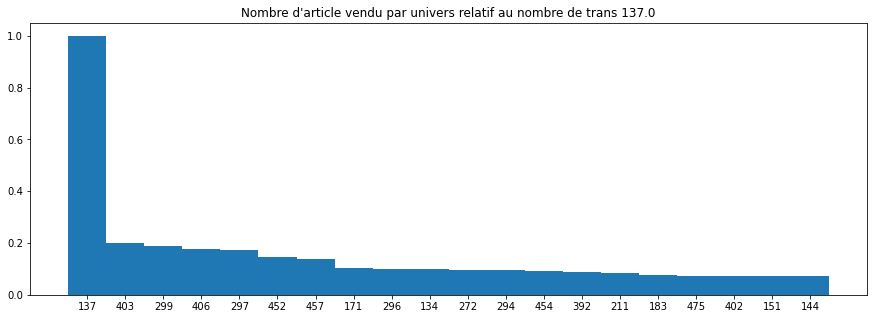

==============138.0===================
Proportion d'achat de univs 138.0 :  0.02 %
Nombre moyen d'achat en plus du univs 138.0 :  9.09
Proportion d'achat de univs 138.0 seul: 1.34 %
CA sans 138.0 :  10500.35
CA moyen sans 138.0 :  35.12
CA de 138.0 :  827.93
CA moyen de 138.0 :  2.77


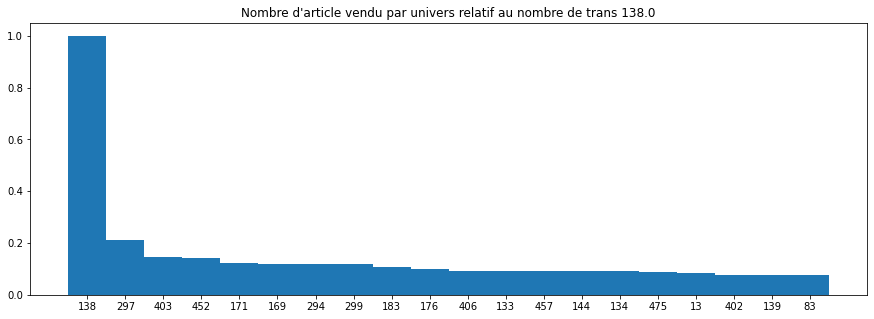

==============139.0===================
Proportion d'achat de univs 139.0 :  0.67 %
Nombre moyen d'achat en plus du univs 139.0 :  9.71
Proportion d'achat de univs 139.0 seul: 0.66 %
CA sans 139.0 :  420956.07
CA moyen sans 139.0 :  36.71
CA de 139.0 :  32299.98
CA moyen de 139.0 :  2.82


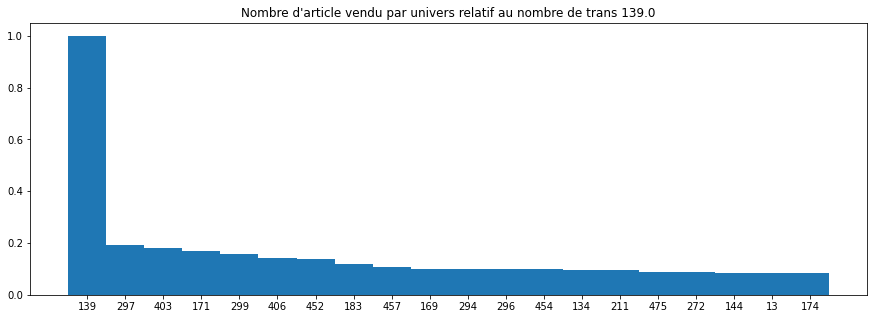

==============140.0===================
Proportion d'achat de univs 140.0 :  0.16 %
Nombre moyen d'achat en plus du univs 140.0 :  9.29
Proportion d'achat de univs 140.0 seul: 1.57 %
CA sans 140.0 :  98626.61
CA moyen sans 140.0 :  35.17
CA de 140.0 :  12733.97
CA moyen de 140.0 :  4.54


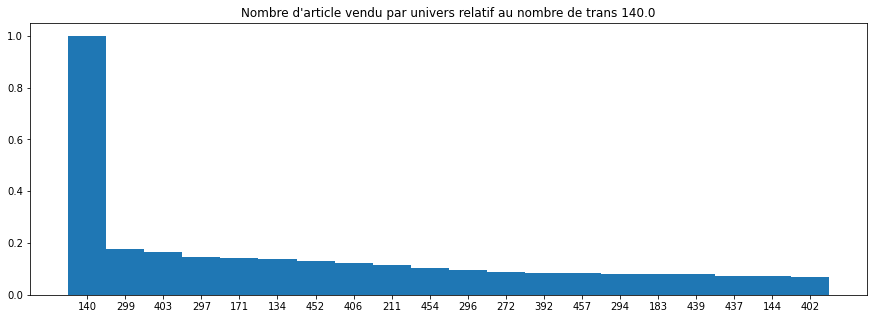

==============141.0===================
Proportion d'achat de univs 141.0 :  0.62 %
Nombre moyen d'achat en plus du univs 141.0 :  9.6
Proportion d'achat de univs 141.0 seul: 0.55 %
CA sans 141.0 :  395162.29
CA moyen sans 141.0 :  37.33
CA de 141.0 :  31327.41
CA moyen de 141.0 :  2.96


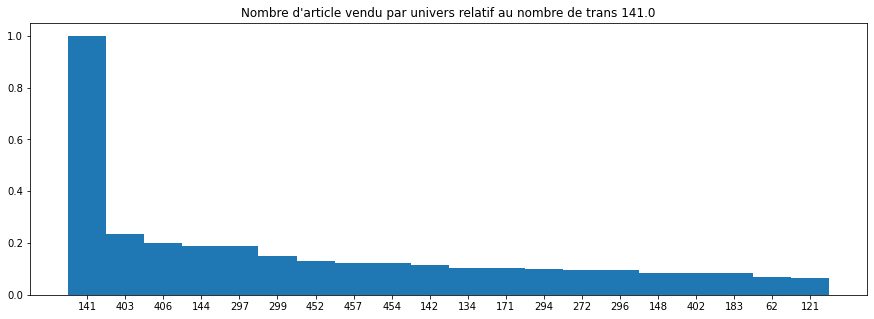

==============142.0===================
Proportion d'achat de univs 142.0 :  1.43 %
Nombre moyen d'achat en plus du univs 142.0 :  7.5
Proportion d'achat de univs 142.0 seul: 1.79 %
CA sans 142.0 :  750276.42
CA moyen sans 142.0 :  30.74
CA de 142.0 :  99321.54
CA moyen de 142.0 :  4.07


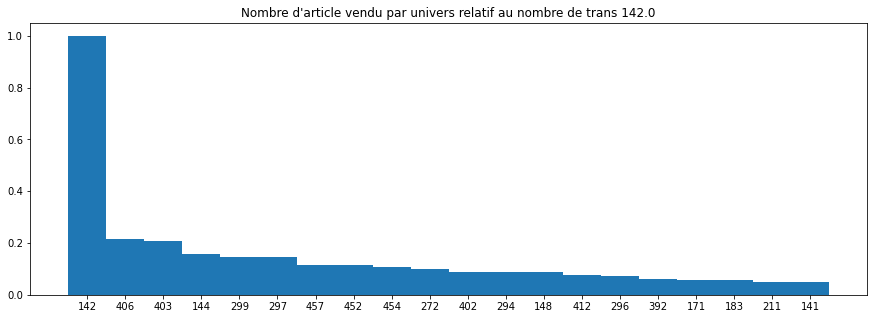

==============143.0===================
Proportion d'achat de univs 143.0 :  0.05 %
Nombre moyen d'achat en plus du univs 143.0 :  8.64
Proportion d'achat de univs 143.0 seul: 2.49 %
CA sans 143.0 :  26220.64
CA moyen sans 143.0 :  32.65
CA de 143.0 :  3112.38
CA moyen de 143.0 :  3.88


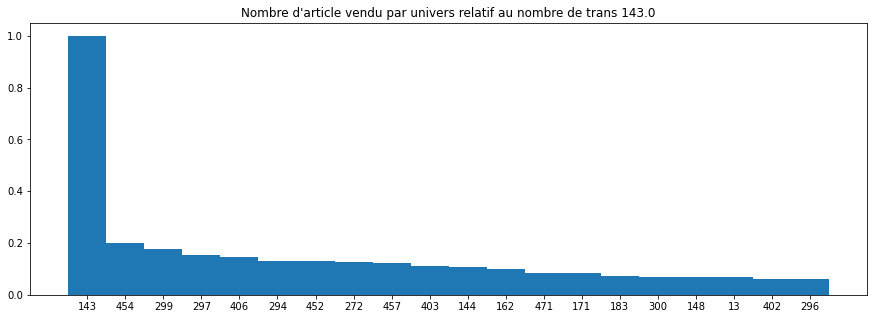

==============144.0===================
Proportion d'achat de univs 144.0 :  2.48 %
Nombre moyen d'achat en plus du univs 144.0 :  7.93
Proportion d'achat de univs 144.0 seul: 1.05 %
CA sans 144.0 :  1341877.61
CA moyen sans 144.0 :  31.65
CA de 144.0 :  179647.68
CA moyen de 144.0 :  4.24


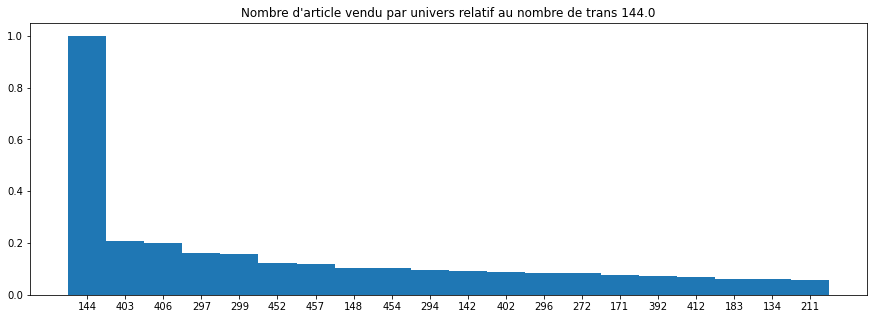

==============145.0===================
Proportion d'achat de univs 145.0 :  0.16 %
Nombre moyen d'achat en plus du univs 145.0 :  9.39
Proportion d'achat de univs 145.0 seul: 2.51 %
CA sans 145.0 :  106846.18
CA moyen sans 145.0 :  39.38
CA de 145.0 :  12374.89
CA moyen de 145.0 :  4.56


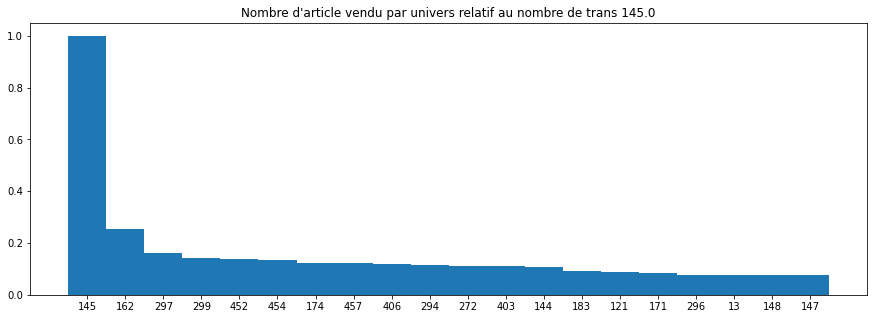

==============146.0===================
NO DATA 
==============147.0===================
Proportion d'achat de univs 147.0 :  2.29 %
Nombre moyen d'achat en plus du univs 147.0 :  6.86
Proportion d'achat de univs 147.0 seul: 4.55 %
CA sans 147.0 :  1103043.15
CA moyen sans 147.0 :  28.21
CA de 147.0 :  326896.87
CA moyen de 147.0 :  8.36


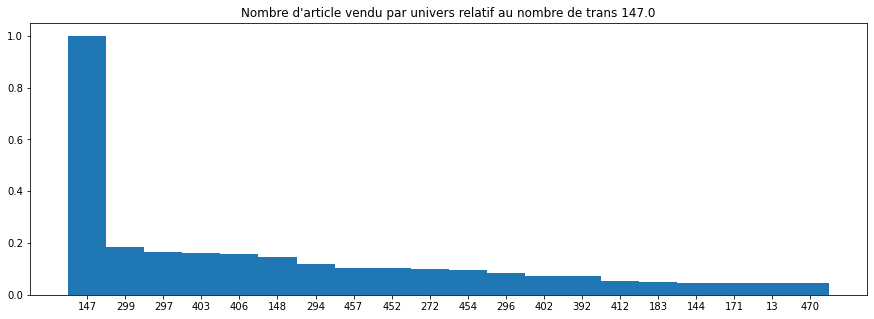

==============148.0===================
Proportion d'achat de univs 148.0 :  4.07 %
Nombre moyen d'achat en plus du univs 148.0 :  6.77
Proportion d'achat de univs 148.0 seul: 2.42 %
CA sans 148.0 :  1935567.77
CA moyen sans 148.0 :  27.86
CA de 148.0 :  337339.95
CA moyen de 148.0 :  4.86


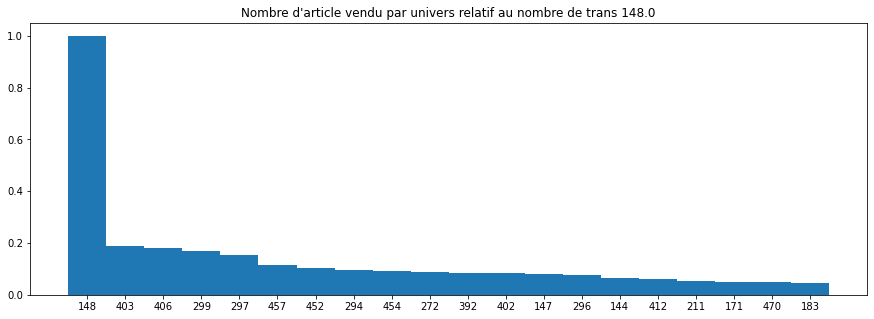

==============149.0===================
Proportion d'achat de univs 149.0 :  0.58 %
Nombre moyen d'achat en plus du univs 149.0 :  7.62
Proportion d'achat de univs 149.0 seul: 2.4 %
CA sans 149.0 :  307855.97
CA moyen sans 149.0 :  31.19
CA de 149.0 :  56816.37
CA moyen de 149.0 :  5.76


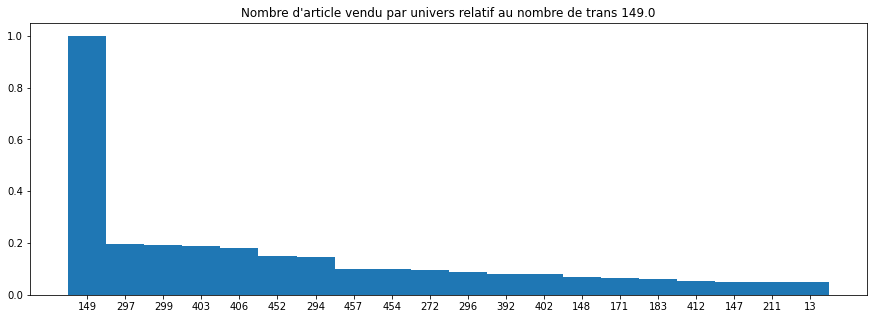

==============150.0===================
Proportion d'achat de univs 150.0 :  0.61 %
Nombre moyen d'achat en plus du univs 150.0 :  8.54
Proportion d'achat de univs 150.0 seul: 1.36 %
CA sans 150.0 :  371283.97
CA moyen sans 150.0 :  35.43
CA de 150.0 :  74754.28
CA moyen de 150.0 :  7.13


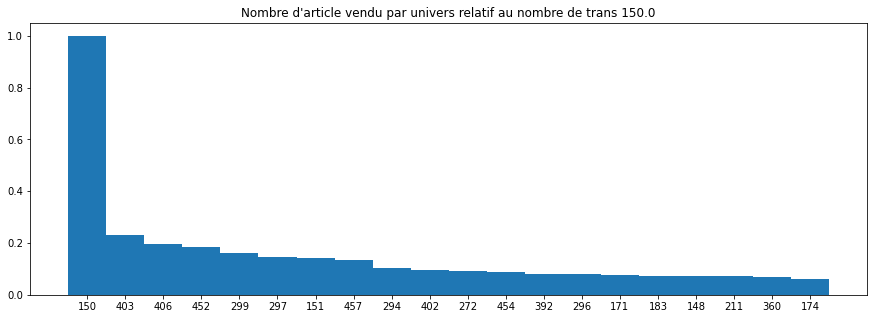

==============151.0===================
Proportion d'achat de univs 151.0 :  2.51 %
Nombre moyen d'achat en plus du univs 151.0 :  7.78
Proportion d'achat de univs 151.0 seul: 0.74 %
CA sans 151.0 :  1328155.79
CA moyen sans 151.0 :  31.03
CA de 151.0 :  216845.47
CA moyen de 151.0 :  5.07


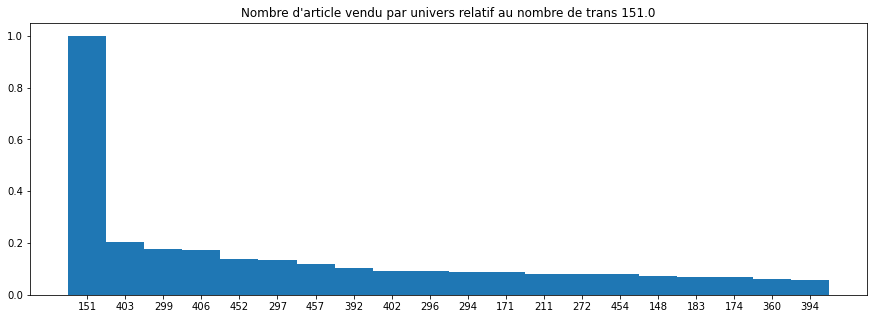

==============152.0===================
Proportion d'achat de univs 152.0 :  0.04 %
Nombre moyen d'achat en plus du univs 152.0 :  9.56
Proportion d'achat de univs 152.0 seul: 2.72 %
CA sans 152.0 :  32954.15
CA moyen sans 152.0 :  44.84
CA de 152.0 :  11576.62
CA moyen de 152.0 :  15.75


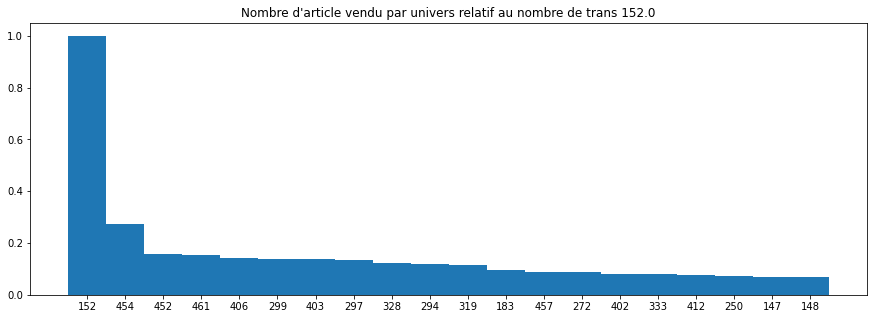

==============153.0===================
Proportion d'achat de univs 153.0 :  0.16 %
Nombre moyen d'achat en plus du univs 153.0 :  8.66
Proportion d'achat de univs 153.0 seul: 1.83 %
CA sans 153.0 :  100281.71
CA moyen sans 153.0 :  35.94
CA de 153.0 :  20967.24
CA moyen de 153.0 :  7.52


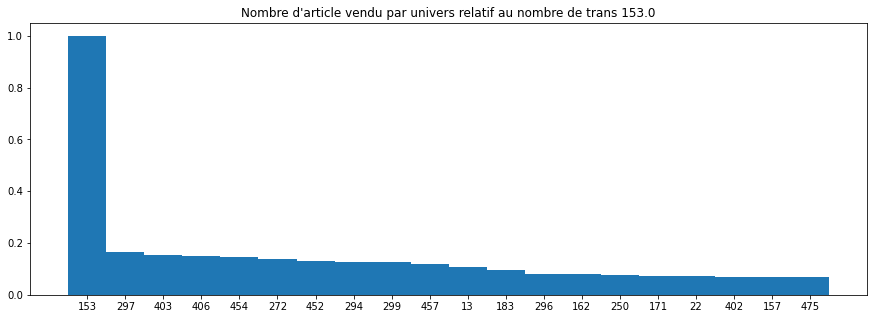

==============154.0===================
Proportion d'achat de univs 154.0 :  1.25 %
Nombre moyen d'achat en plus du univs 154.0 :  6.85
Proportion d'achat de univs 154.0 seul: 5.46 %
CA sans 154.0 :  602216.44
CA moyen sans 154.0 :  28.13
CA de 154.0 :  153881.43
CA moyen de 154.0 :  7.19


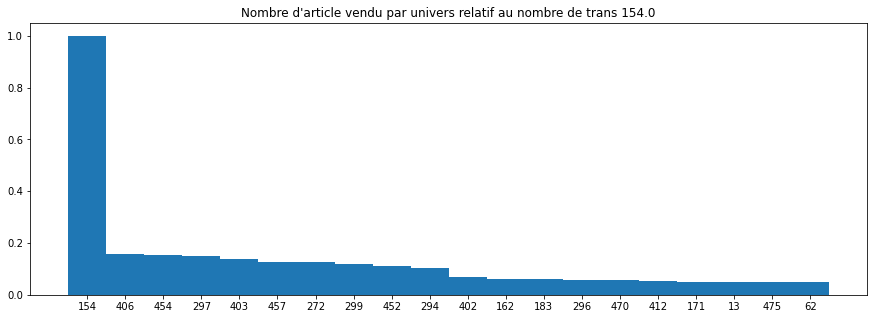

==============155.0===================
Proportion d'achat de univs 155.0 :  0.17 %
Nombre moyen d'achat en plus du univs 155.0 :  10.21
Proportion d'achat de univs 155.0 seul: 1.87 %
CA sans 155.0 :  121576.07
CA moyen sans 155.0 :  42.04
CA de 155.0 :  27327.5
CA moyen de 155.0 :  9.45


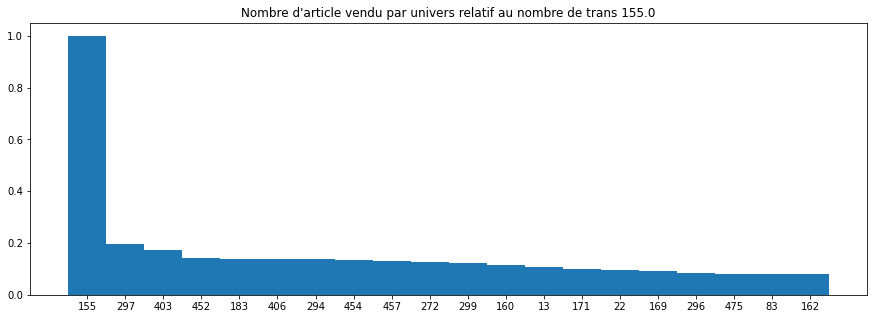

==============156.0===================
Proportion d'achat de univs 156.0 :  0.28 %
Nombre moyen d'achat en plus du univs 156.0 :  10.61
Proportion d'achat de univs 156.0 seul: 2.14 %
CA sans 156.0 :  195275.56
CA moyen sans 156.0 :  41.28
CA de 156.0 :  40342.32
CA moyen de 156.0 :  8.53


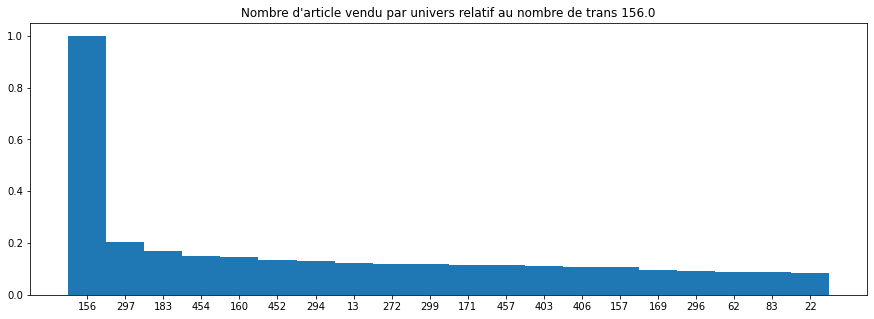

==============157.0===================
Proportion d'achat de univs 157.0 :  1.11 %
Nombre moyen d'achat en plus du univs 157.0 :  7.97
Proportion d'achat de univs 157.0 seul: 4.36 %
CA sans 157.0 :  618608.87
CA moyen sans 157.0 :  32.55
CA de 157.0 :  77218.07
CA moyen de 157.0 :  4.06


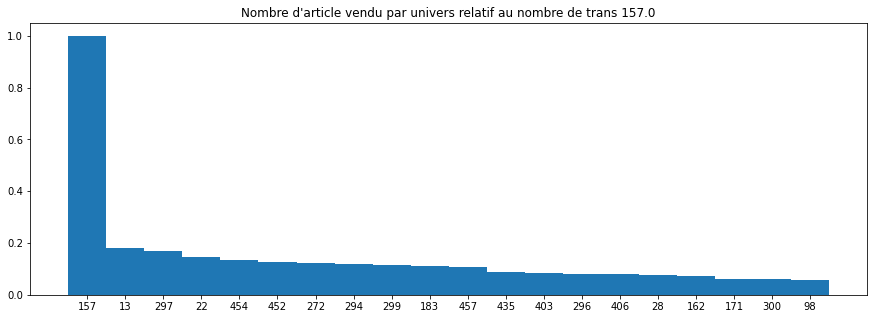

==============158.0===================
Proportion d'achat de univs 158.0 :  0.04 %
Nombre moyen d'achat en plus du univs 158.0 :  8.36
Proportion d'achat de univs 158.0 seul: 2.37 %
CA sans 158.0 :  23717.25
CA moyen sans 158.0 :  35.14
CA de 158.0 :  5103.75
CA moyen de 158.0 :  7.56


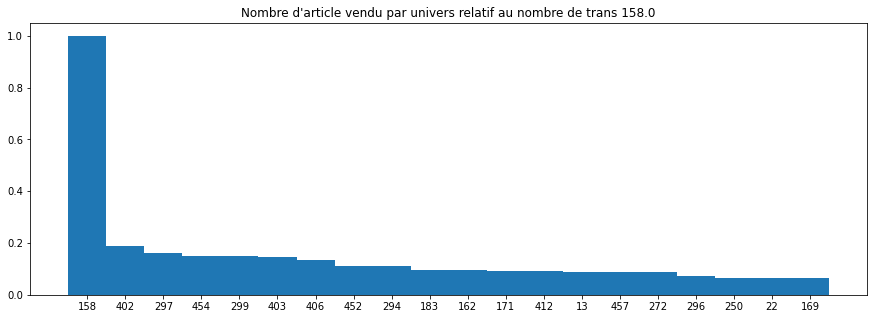

==============159.0===================
Proportion d'achat de univs 159.0 :  0.09 %
Nombre moyen d'achat en plus du univs 159.0 :  9.78
Proportion d'achat de univs 159.0 seul: 0.91 %
CA sans 159.0 :  58459.8
CA moyen sans 159.0 :  38.06
CA de 159.0 :  8223.03
CA moyen de 159.0 :  5.35


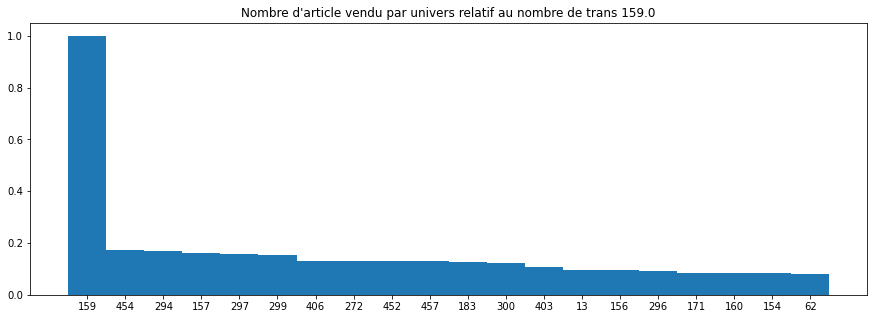

==============160.0===================
Proportion d'achat de univs 160.0 :  0.61 %
Nombre moyen d'achat en plus du univs 160.0 :  9.69
Proportion d'achat de univs 160.0 seul: 1.94 %
CA sans 160.0 :  406356.08
CA moyen sans 160.0 :  38.97
CA de 160.0 :  44869.11
CA moyen de 160.0 :  4.3


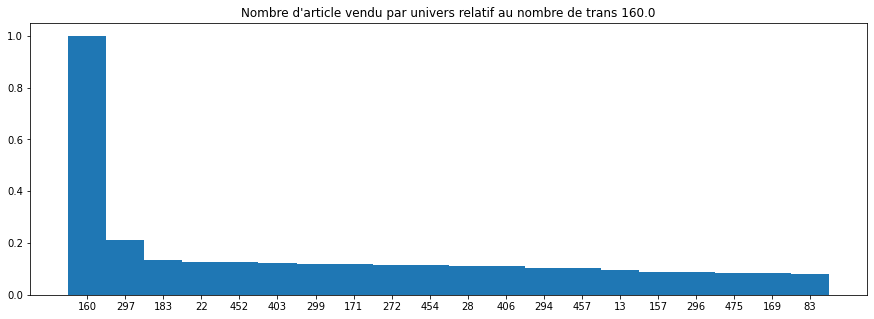

==============161.0===================
Proportion d'achat de univs 161.0 :  0.01 %
Nombre moyen d'achat en plus du univs 161.0 :  10.97
Proportion d'achat de univs 161.0 seul: 0.0 %
CA sans 161.0 :  4534.21
CA moyen sans 161.0 :  46.27
CA de 161.0 :  468.14
CA moyen de 161.0 :  4.78


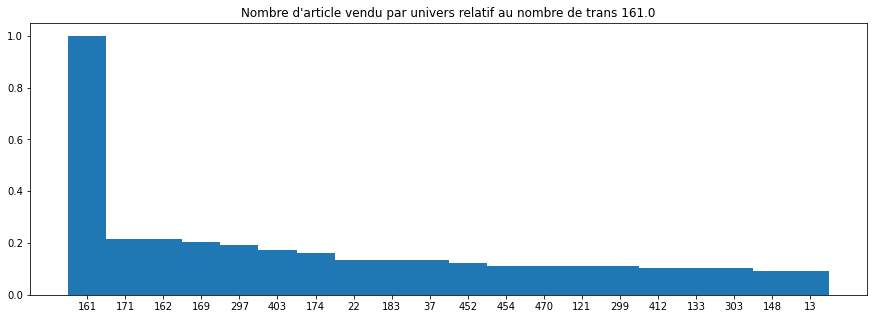

==============162.0===================
Proportion d'achat de univs 162.0 :  2.81 %
Nombre moyen d'achat en plus du univs 162.0 :  7.64
Proportion d'achat de univs 162.0 seul: 5.3 %
CA sans 162.0 :  1477547.96
CA moyen sans 162.0 :  30.84
CA de 162.0 :  446599.59
CA moyen de 162.0 :  9.32


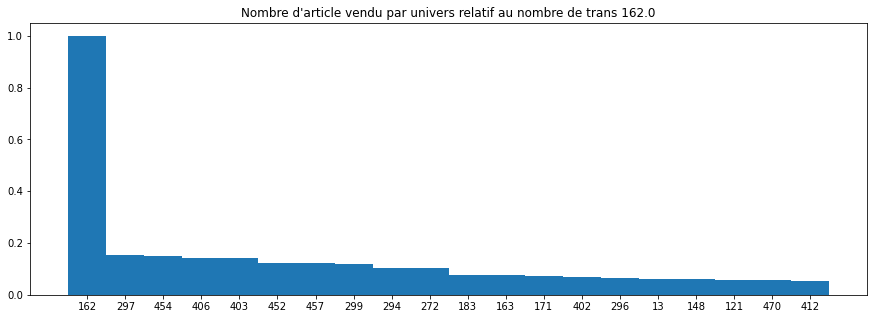

==============163.0===================
Proportion d'achat de univs 163.0 :  0.97 %
Nombre moyen d'achat en plus du univs 163.0 :  7.08
Proportion d'achat de univs 163.0 seul: 3.81 %
CA sans 163.0 :  454381.9
CA moyen sans 163.0 :  27.33
CA de 163.0 :  75214.0
CA moyen de 163.0 :  4.52


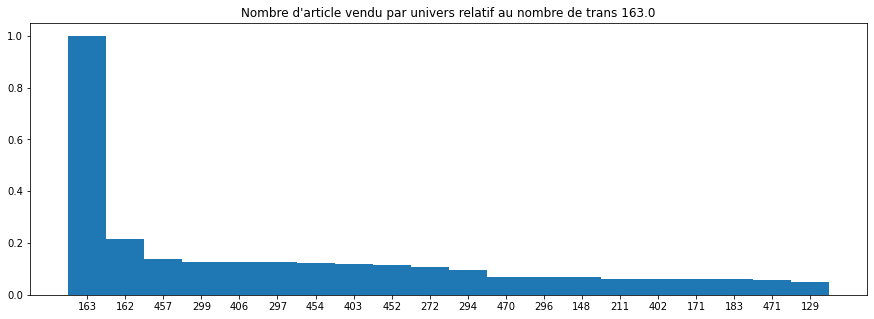

==============164.0===================
Proportion d'achat de univs 164.0 :  0.01 %
Nombre moyen d'achat en plus du univs 164.0 :  7.68
Proportion d'achat de univs 164.0 seul: 4.32 %
CA sans 164.0 :  4956.09
CA moyen sans 164.0 :  35.66
CA de 164.0 :  2858.24
CA moyen de 164.0 :  20.56


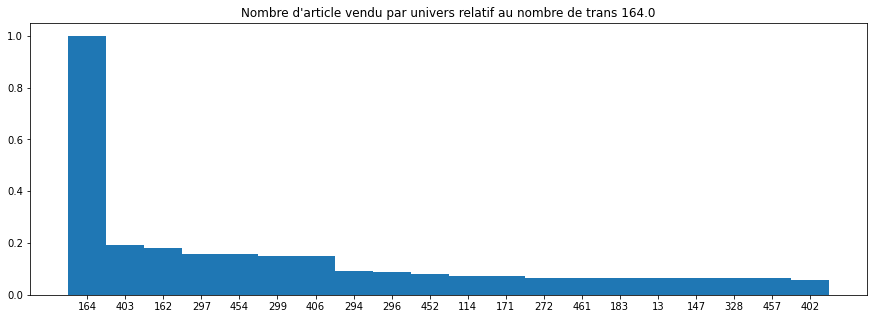

==============165.0===================
Proportion d'achat de univs 165.0 :  0.02 %
Nombre moyen d'achat en plus du univs 165.0 :  7.04
Proportion d'achat de univs 165.0 seul: 6.43 %
CA sans 165.0 :  12977.53
CA moyen sans 165.0 :  33.36
CA de 165.0 :  5346.2
CA moyen de 165.0 :  13.74


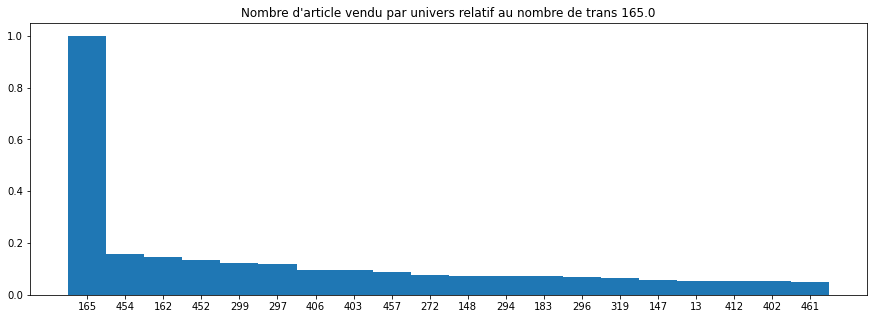

==============167.0===================
Proportion d'achat de univs 167.0 :  0.1 %
Nombre moyen d'achat en plus du univs 167.0 :  6.64
Proportion d'achat de univs 167.0 seul: 5.98 %
CA sans 167.0 :  54606.58
CA moyen sans 167.0 :  32.35
CA de 167.0 :  4937.35
CA moyen de 167.0 :  2.92


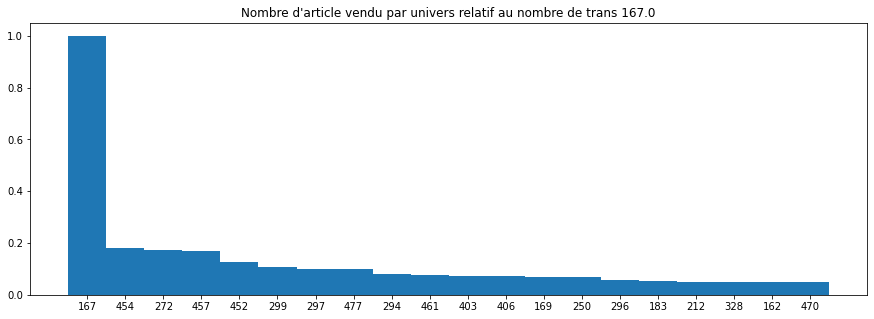

==============168.0===================
Proportion d'achat de univs 168.0 :  0.35 %
Nombre moyen d'achat en plus du univs 168.0 :  11.91
Proportion d'achat de univs 168.0 seul: 0.47 %
CA sans 168.0 :  278438.24
CA moyen sans 168.0 :  46.43
CA de 168.0 :  28792.72
CA moyen de 168.0 :  4.8


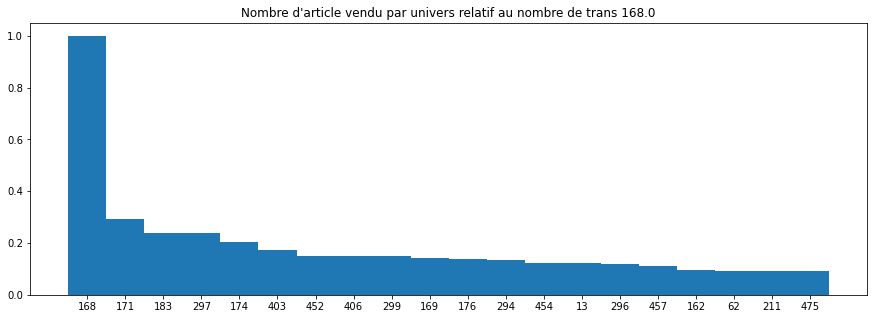

==============169.0===================
Proportion d'achat de univs 169.0 :  2.41 %
Nombre moyen d'achat en plus du univs 169.0 :  10.11
Proportion d'achat de univs 169.0 seul: 0.98 %
CA sans 169.0 :  1624314.75
CA moyen sans 169.0 :  39.51
CA de 169.0 :  144046.74
CA moyen de 169.0 :  3.5


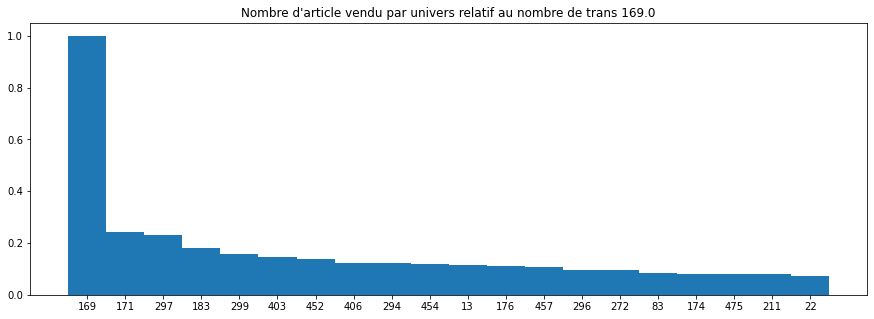

==============170.0===================
Proportion d'achat de univs 170.0 :  0.21 %
Nombre moyen d'achat en plus du univs 170.0 :  11.32
Proportion d'achat de univs 170.0 seul: 0.71 %
CA sans 170.0 :  160853.72
CA moyen sans 170.0 :  44.23
CA de 170.0 :  15498.83
CA moyen de 170.0 :  4.26


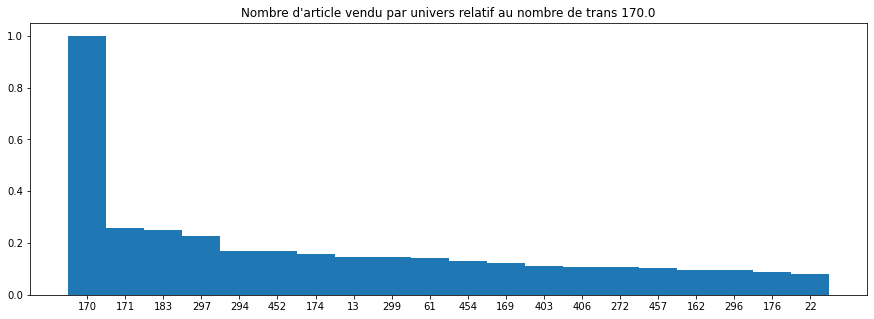

==============171.0===================
Proportion d'achat de univs 171.0 :  3.79 %
Nombre moyen d'achat en plus du univs 171.0 :  9.63
Proportion d'achat de univs 171.0 seul: 0.71 %
CA sans 171.0 :  2393990.1
CA moyen sans 171.0 :  37.03
CA de 171.0 :  197441.09
CA moyen de 171.0 :  3.05


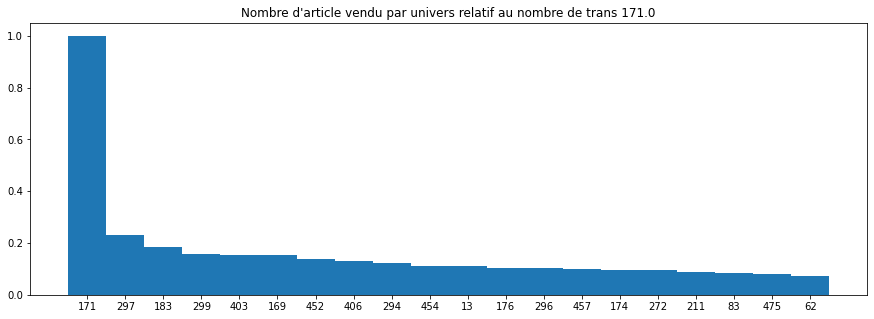

==============172.0===================
Proportion d'achat de univs 172.0 :  0.05 %
Nombre moyen d'achat en plus du univs 172.0 :  11.85
Proportion d'achat de univs 172.0 seul: 0.61 %
CA sans 172.0 :  38262.12
CA moyen sans 172.0 :  46.66
CA de 172.0 :  5753.66
CA moyen de 172.0 :  7.02


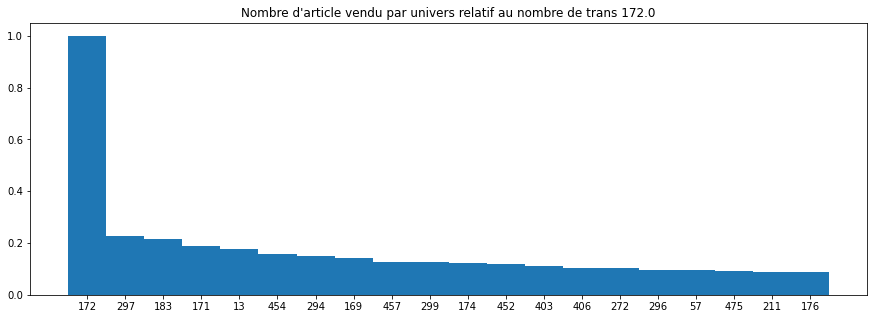

==============173.0===================
Proportion d'achat de univs 173.0 :  0.59 %
Nombre moyen d'achat en plus du univs 173.0 :  11.19
Proportion d'achat de univs 173.0 seul: 0.63 %
CA sans 173.0 :  437744.67
CA moyen sans 173.0 :  43.29
CA de 173.0 :  42106.68
CA moyen de 173.0 :  4.16


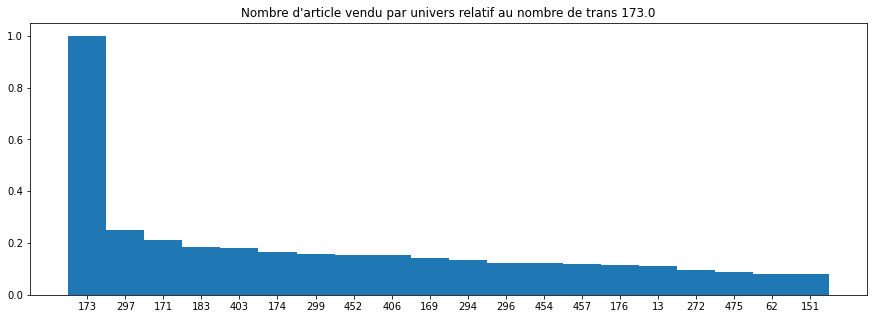

==============174.0===================
Proportion d'achat de univs 174.0 :  1.83 %
Nombre moyen d'achat en plus du univs 174.0 :  10.36
Proportion d'achat de univs 174.0 seul: 0.96 %
CA sans 174.0 :  1250758.17
CA moyen sans 174.0 :  40.14
CA de 174.0 :  185635.56
CA moyen de 174.0 :  5.96


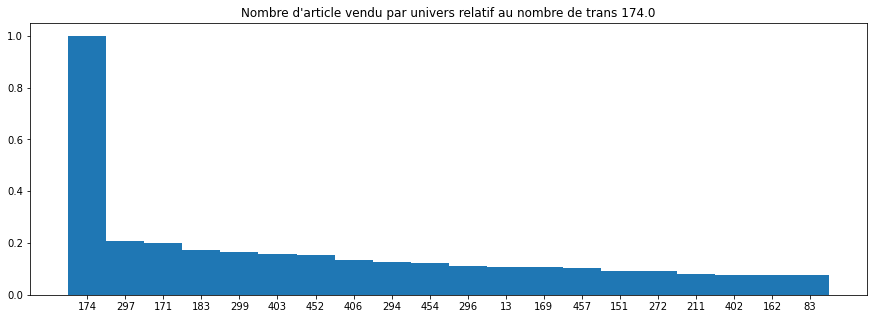

==============175.0===================
Proportion d'achat de univs 175.0 :  0.1 %
Nombre moyen d'achat en plus du univs 175.0 :  11.36
Proportion d'achat de univs 175.0 seul: 0.47 %
CA sans 175.0 :  77467.26
CA moyen sans 175.0 :  45.28
CA de 175.0 :  9200.2
CA moyen de 175.0 :  5.38


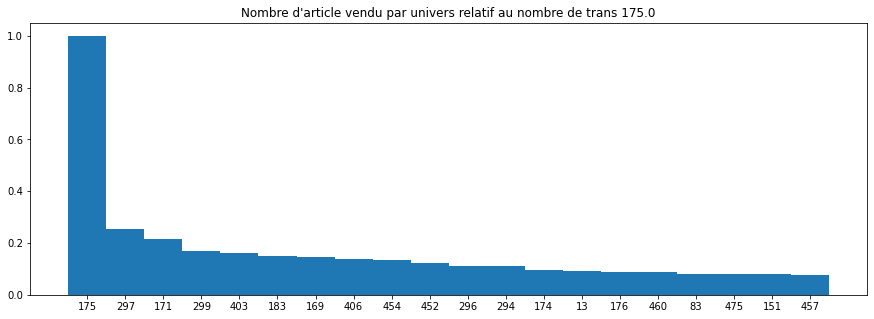

==============176.0===================
Proportion d'achat de univs 176.0 :  1.46 %
Nombre moyen d'achat en plus du univs 176.0 :  10.38
Proportion d'achat de univs 176.0 seul: 0.67 %
CA sans 176.0 :  984830.15
CA moyen sans 176.0 :  39.48
CA de 176.0 :  93012.11
CA moyen de 176.0 :  3.73


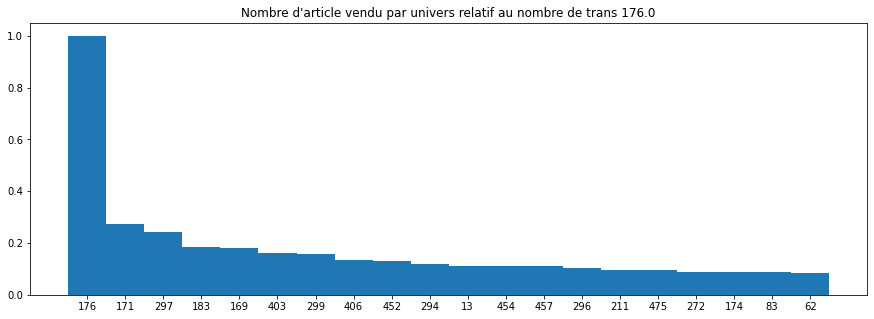

==============177.0===================
Proportion d'achat de univs 177.0 :  0.78 %
Nombre moyen d'achat en plus du univs 177.0 :  9.67
Proportion d'achat de univs 177.0 seul: 2.58 %
CA sans 177.0 :  507193.84
CA moyen sans 177.0 :  38.08
CA de 177.0 :  52544.67
CA moyen de 177.0 :  3.95


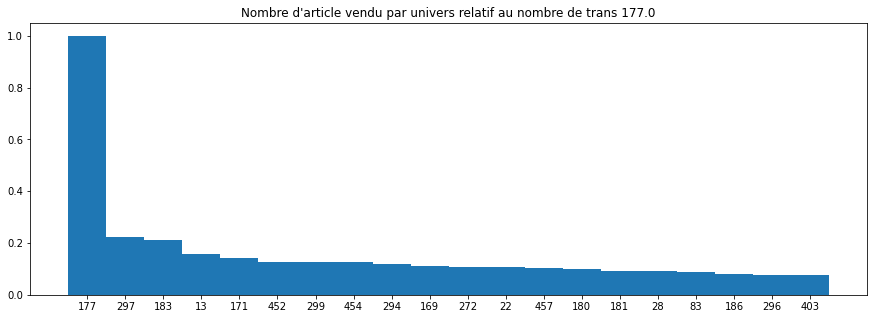

==============178.0===================
Proportion d'achat de univs 178.0 :  0.32 %
Nombre moyen d'achat en plus du univs 178.0 :  10.71
Proportion d'achat de univs 178.0 seul: 0.9 %
CA sans 178.0 :  229443.41
CA moyen sans 178.0 :  42.07
CA de 178.0 :  10908.75
CA moyen de 178.0 :  2.0


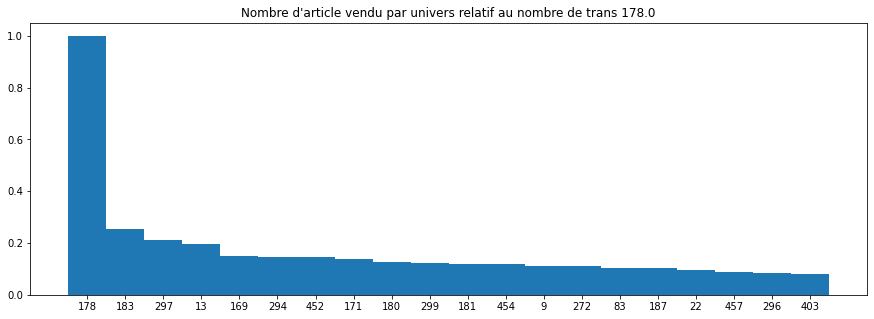

==============179.0===================
NO DATA 
==============180.0===================
Proportion d'achat de univs 180.0 :  0.93 %
Nombre moyen d'achat en plus du univs 180.0 :  10.81
Proportion d'achat de univs 180.0 seul: 1.41 %
CA sans 180.0 :  657836.69
CA moyen sans 180.0 :  41.57
CA de 180.0 :  42012.29
CA moyen de 180.0 :  2.66


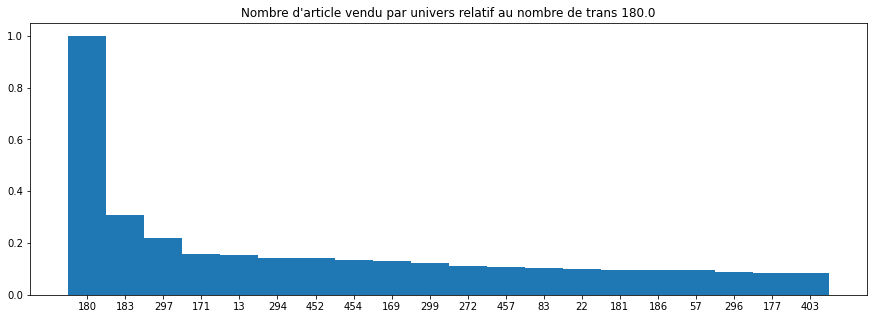

==============181.0===================
Proportion d'achat de univs 181.0 :  1.08 %
Nombre moyen d'achat en plus du univs 181.0 :  10.23
Proportion d'achat de univs 181.0 seul: 1.17 %
CA sans 181.0 :  739796.5
CA moyen sans 181.0 :  40.0
CA de 181.0 :  60357.78
CA moyen de 181.0 :  3.26


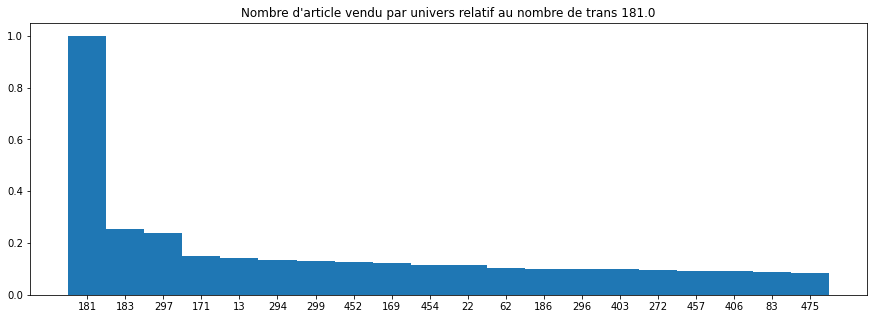

==============182.0===================
Proportion d'achat de univs 182.0 :  0.32 %
Nombre moyen d'achat en plus du univs 182.0 :  11.8
Proportion d'achat de univs 182.0 seul: 0.74 %
CA sans 182.0 :  243458.44
CA moyen sans 182.0 :  45.16
CA de 182.0 :  16060.69
CA moyen de 182.0 :  2.98


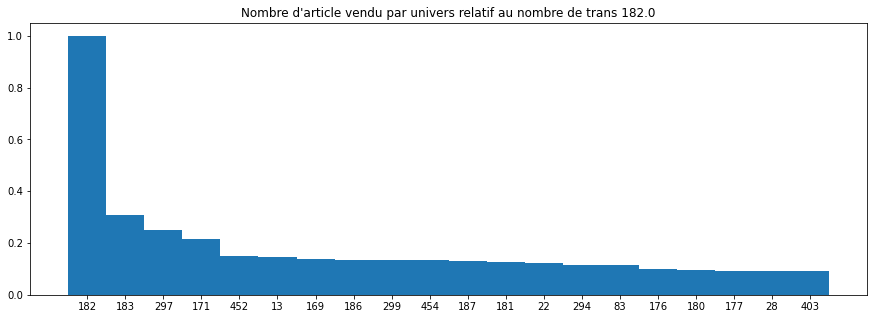

==============183.0===================
Proportion d'achat de univs 183.0 :  3.91 %
Nombre moyen d'achat en plus du univs 183.0 :  10.21
Proportion d'achat de univs 183.0 seul: 0.71 %
CA sans 183.0 :  2644783.77
CA moyen sans 183.0 :  39.63
CA de 183.0 :  230290.34
CA moyen de 183.0 :  3.45


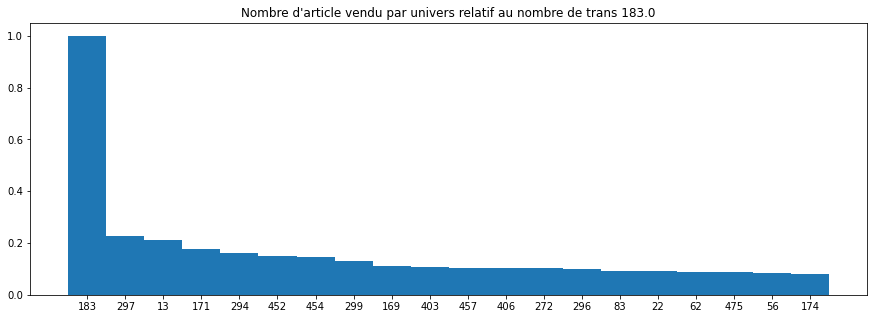

==============184.0===================
Proportion d'achat de univs 184.0 :  0.12 %
Nombre moyen d'achat en plus du univs 184.0 :  13.1
Proportion d'achat de univs 184.0 seul: 0.61 %
CA sans 184.0 :  102835.74
CA moyen sans 184.0 :  51.94
CA de 184.0 :  8208.71
CA moyen de 184.0 :  4.15


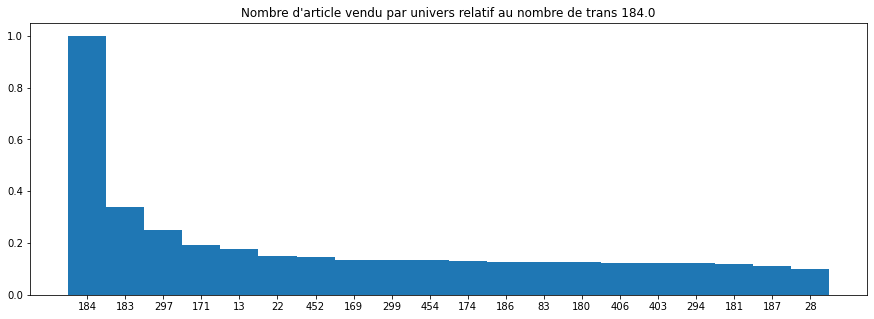

==============186.0===================
Proportion d'achat de univs 186.0 :  0.9 %
Nombre moyen d'achat en plus du univs 186.0 :  10.69
Proportion d'achat de univs 186.0 seul: 1.06 %
CA sans 186.0 :  627274.85
CA moyen sans 186.0 :  40.63
CA de 186.0 :  33919.59
CA moyen de 186.0 :  2.2


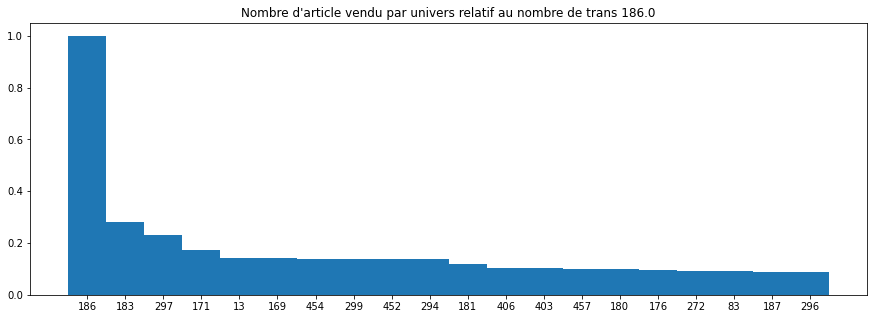

==============187.0===================
Proportion d'achat de univs 187.0 :  0.88 %
Nombre moyen d'achat en plus du univs 187.0 :  10.43
Proportion d'achat de univs 187.0 seul: 1.12 %
CA sans 187.0 :  609673.53
CA moyen sans 187.0 :  40.82
CA de 187.0 :  53342.63
CA moyen de 187.0 :  3.57


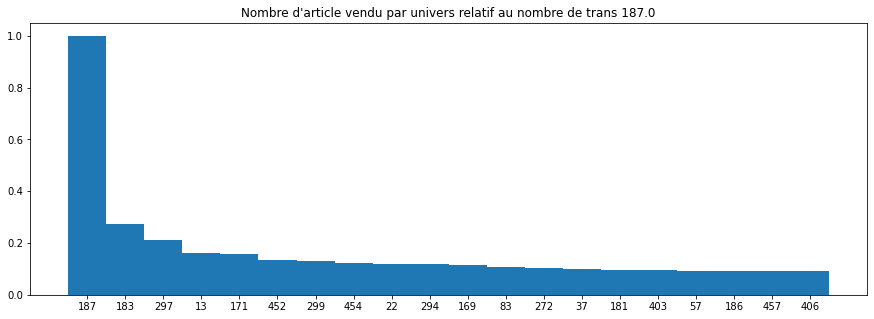

==============188.0===================
Proportion d'achat de univs 188.0 :  3.83 %
Nombre moyen d'achat en plus du univs 188.0 :  5.06
Proportion d'achat de univs 188.0 seul: 10.01 %
CA sans 188.0 :  1387925.89
CA moyen sans 188.0 :  21.21
CA de 188.0 :  409745.54
CA moyen de 188.0 :  6.26


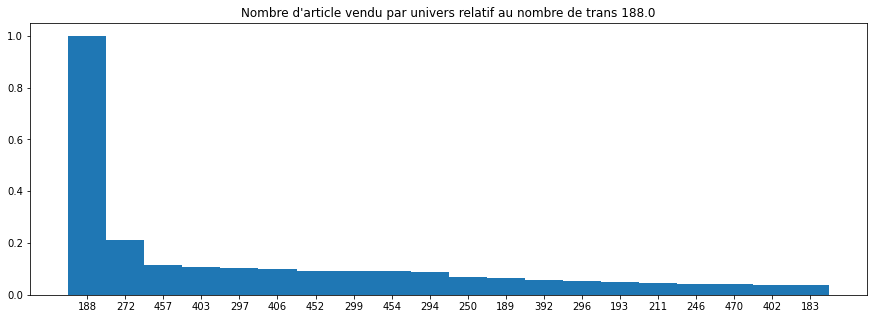

==============189.0===================
Proportion d'achat de univs 189.0 :  2.62 %
Nombre moyen d'achat en plus du univs 189.0 :  5.88
Proportion d'achat de univs 189.0 seul: 6.35 %
CA sans 189.0 :  1070822.6
CA moyen sans 189.0 :  23.97
CA de 189.0 :  252945.8
CA moyen de 189.0 :  5.66


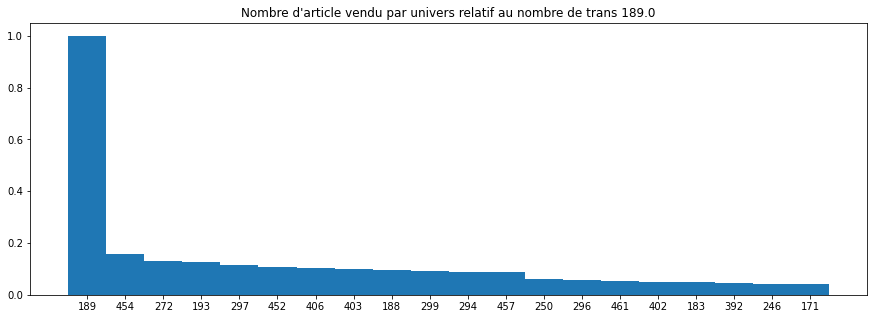

==============190.0===================
Proportion d'achat de univs 190.0 :  0.34 %
Nombre moyen d'achat en plus du univs 190.0 :  6.47
Proportion d'achat de univs 190.0 seul: 5.38 %
CA sans 190.0 :  149209.91
CA moyen sans 190.0 :  25.41
CA de 190.0 :  24127.86
CA moyen de 190.0 :  4.11


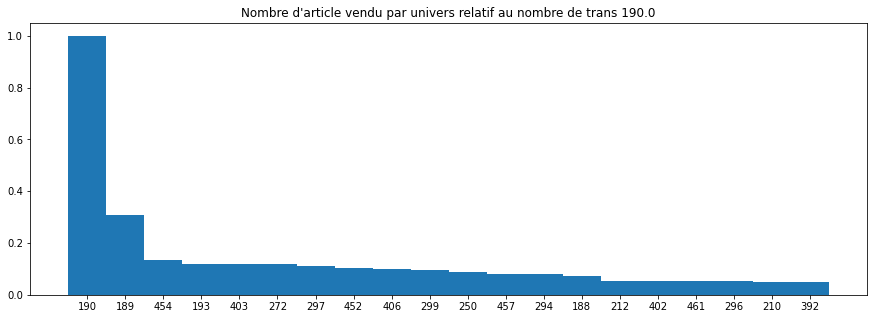

==============191.0===================
Proportion d'achat de univs 191.0 :  0.03 %
Nombre moyen d'achat en plus du univs 191.0 :  5.89
Proportion d'achat de univs 191.0 seul: 3.37 %
CA sans 191.0 :  11782.72
CA moyen sans 191.0 :  23.33
CA de 191.0 :  2156.6
CA moyen de 191.0 :  4.27


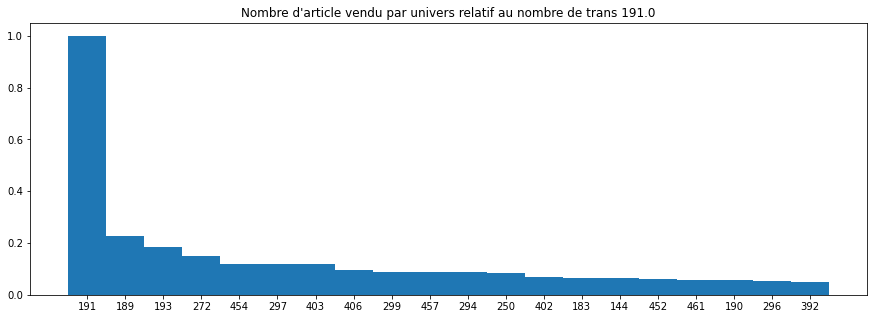

==============192.0===================
Proportion d'achat de univs 192.0 :  0.22 %
Nombre moyen d'achat en plus du univs 192.0 :  7.73
Proportion d'achat de univs 192.0 seul: 2.49 %
CA sans 192.0 :  110972.46
CA moyen sans 192.0 :  29.73
CA de 192.0 :  17689.0
CA moyen de 192.0 :  4.74


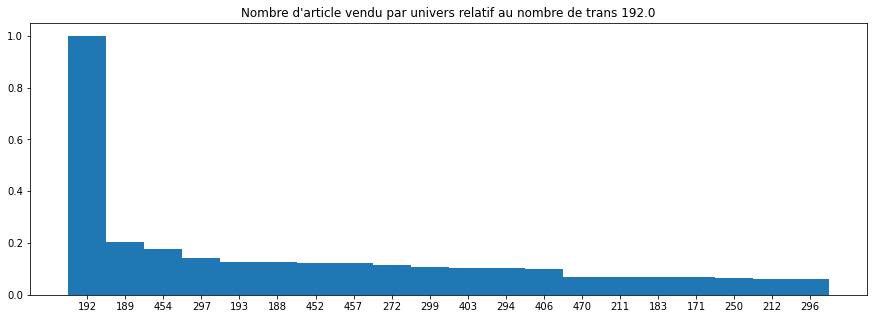

==============193.0===================
Proportion d'achat de univs 193.0 :  1.8 %
Nombre moyen d'achat en plus du univs 193.0 :  6.13
Proportion d'achat de univs 193.0 seul: 5.31 %
CA sans 193.0 :  765865.97
CA moyen sans 193.0 :  24.92
CA de 193.0 :  183378.08
CA moyen de 193.0 :  5.97


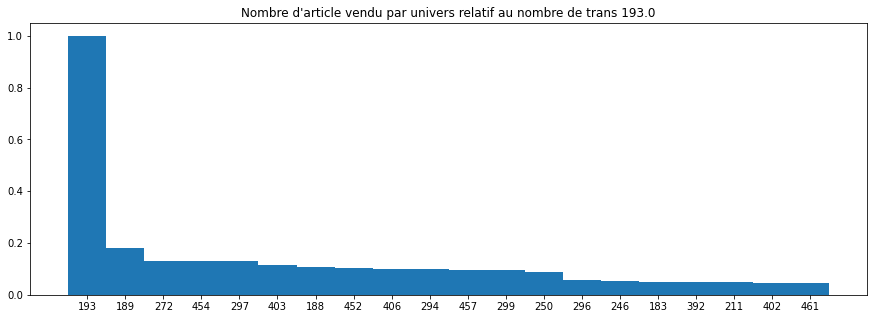

==============194.0===================
Proportion d'achat de univs 194.0 :  0.13 %
Nombre moyen d'achat en plus du univs 194.0 :  7.81
Proportion d'achat de univs 194.0 seul: 4.69 %
CA sans 194.0 :  65498.05
CA moyen sans 194.0 :  29.85
CA de 194.0 :  8160.64
CA moyen de 194.0 :  3.72


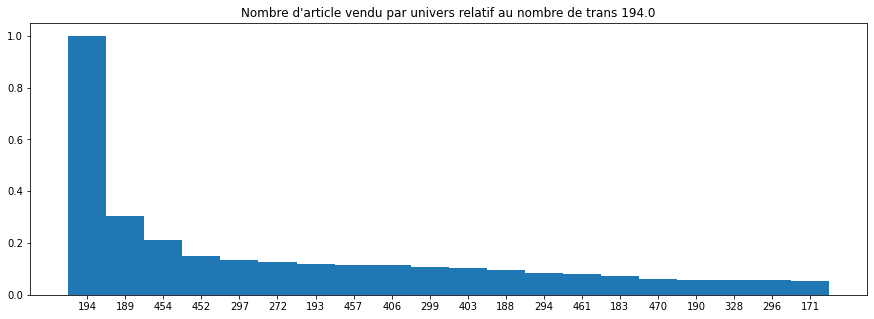

==============195.0===================
Proportion d'achat de univs 195.0 :  0.03 %
Nombre moyen d'achat en plus du univs 195.0 :  7.1
Proportion d'achat de univs 195.0 seul: 2.79 %
CA sans 195.0 :  16306.11
CA moyen sans 195.0 :  28.41
CA de 195.0 :  2836.5
CA moyen de 195.0 :  4.94


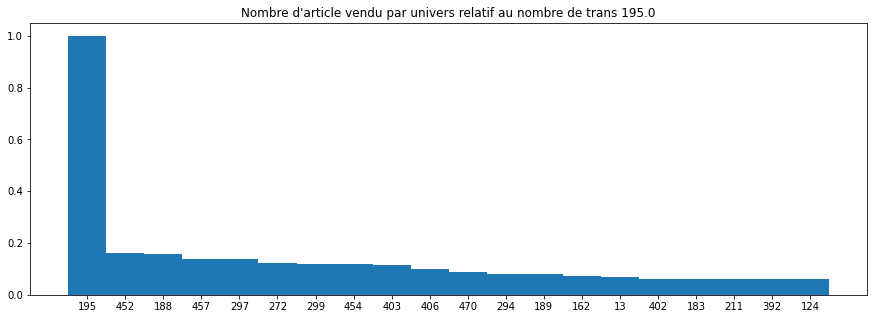

==============196.0===================
Proportion d'achat de univs 196.0 :  0.1 %
Nombre moyen d'achat en plus du univs 196.0 :  9.21
Proportion d'achat de univs 196.0 seul: 4.03 %
CA sans 196.0 :  60324.59
CA moyen sans 196.0 :  35.2
CA de 196.0 :  10544.82
CA moyen de 196.0 :  6.15


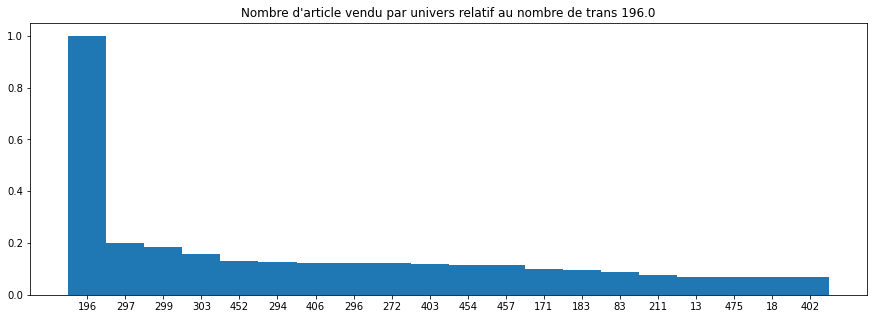

==============197.0===================
Proportion d'achat de univs 197.0 :  0.02 %
Nombre moyen d'achat en plus du univs 197.0 :  11.41
Proportion d'achat de univs 197.0 seul: 1.35 %
CA sans 197.0 :  16204.36
CA moyen sans 197.0 :  43.68
CA de 197.0 :  1435.83
CA moyen de 197.0 :  3.87


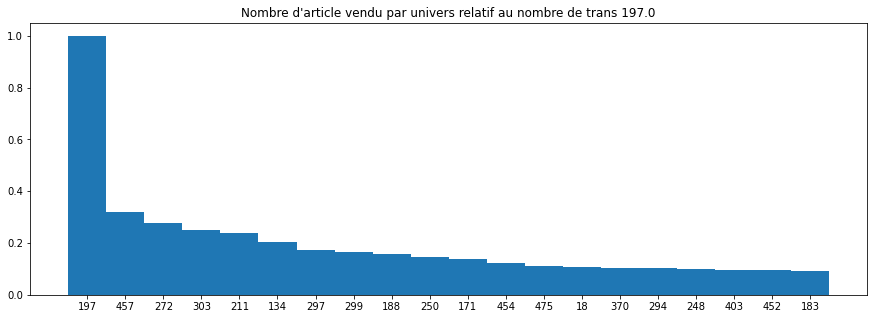

==============198.0===================
Proportion d'achat de univs 198.0 :  2.16 %
Nombre moyen d'achat en plus du univs 198.0 :  6.08
Proportion d'achat de univs 198.0 seul: 2.48 %
CA sans 198.0 :  788322.78
CA moyen sans 198.0 :  21.43
CA de 198.0 :  134815.39
CA moyen de 198.0 :  3.67


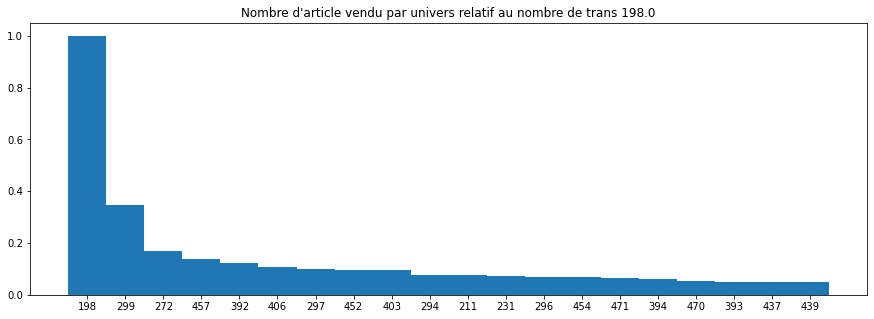

==============199.0===================
Proportion d'achat de univs 199.0 :  0.13 %
Nombre moyen d'achat en plus du univs 199.0 :  8.41
Proportion d'achat de univs 199.0 seul: 5.75 %
CA sans 199.0 :  75641.24
CA moyen sans 199.0 :  33.71
CA de 199.0 :  17212.6
CA moyen de 199.0 :  7.67


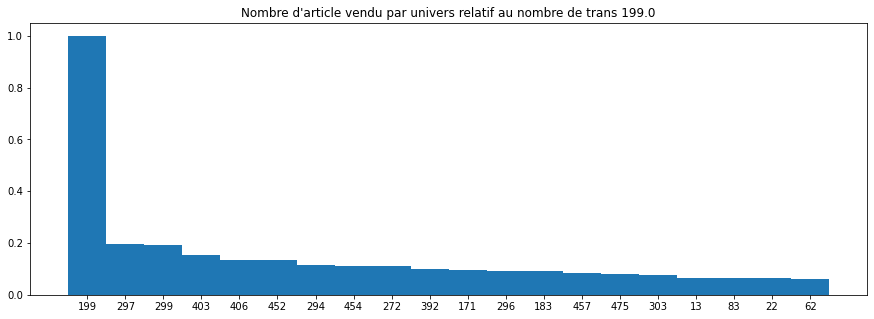

==============200.0===================
Proportion d'achat de univs 200.0 :  0.39 %
Nombre moyen d'achat en plus du univs 200.0 :  9.63
Proportion d'achat de univs 200.0 seul: 3.46 %
CA sans 200.0 :  249550.67
CA moyen sans 200.0 :  37.58
CA de 200.0 :  41151.33
CA moyen de 200.0 :  6.2


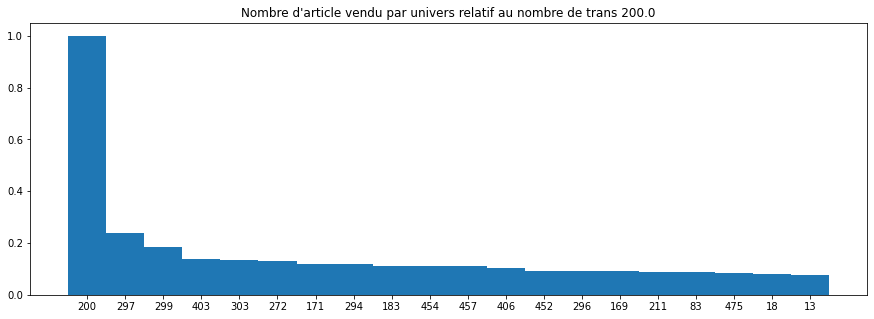

==============201.0===================
Proportion d'achat de univs 201.0 :  0.53 %
Nombre moyen d'achat en plus du univs 201.0 :  8.09
Proportion d'achat de univs 201.0 seul: 3.65 %
CA sans 201.0 :  289204.93
CA moyen sans 201.0 :  31.81
CA de 201.0 :  54375.97
CA moyen de 201.0 :  5.98


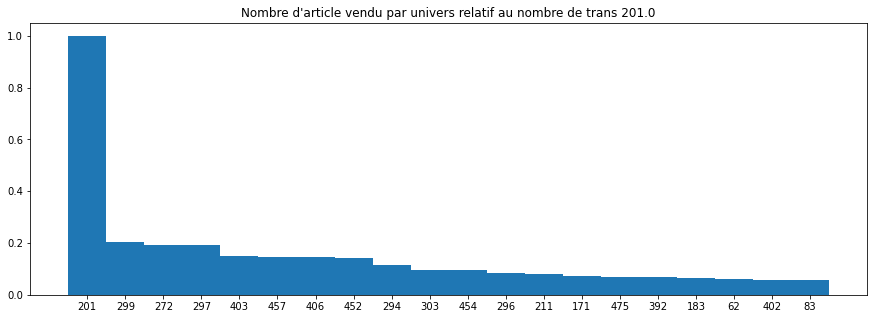

==============202.0===================
NO DATA 
==============203.0===================
Proportion d'achat de univs 203.0 :  0.13 %
Nombre moyen d'achat en plus du univs 203.0 :  9.57
Proportion d'achat de univs 203.0 seul: 1.85 %
CA sans 203.0 :  78523.95
CA moyen sans 203.0 :  36.4
CA de 203.0 :  8130.02
CA moyen de 203.0 :  3.77


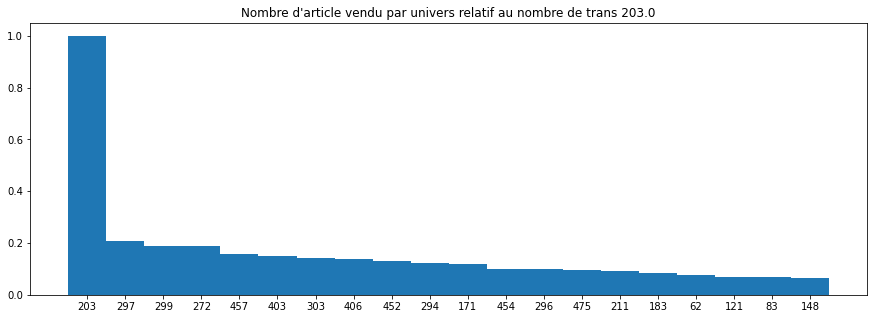

==============204.0===================
Proportion d'achat de univs 204.0 :  0.04 %
Nombre moyen d'achat en plus du univs 204.0 :  10.3
Proportion d'achat de univs 204.0 seul: 1.05 %
CA sans 204.0 :  25718.94
CA moyen sans 204.0 :  38.73
CA de 204.0 :  3548.04
CA moyen de 204.0 :  5.34


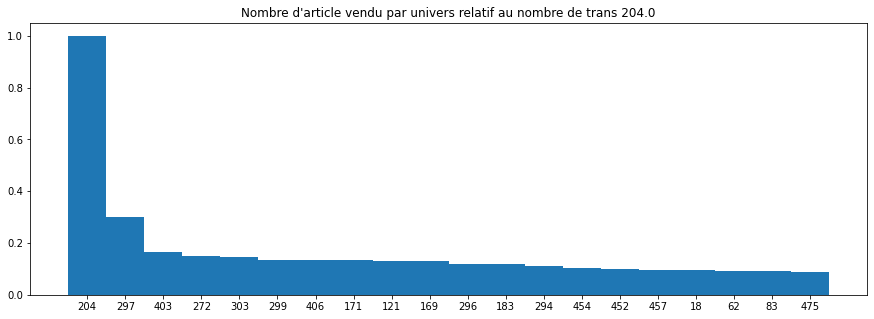

==============205.0===================
NO DATA 
==============206.0===================
Proportion d'achat de univs 206.0 :  0.07 %
Nombre moyen d'achat en plus du univs 206.0 :  11.9
Proportion d'achat de univs 206.0 seul: 1.55 %
CA sans 206.0 :  53749.2
CA moyen sans 206.0 :  46.38
CA de 206.0 :  5132.38
CA moyen de 206.0 :  4.43


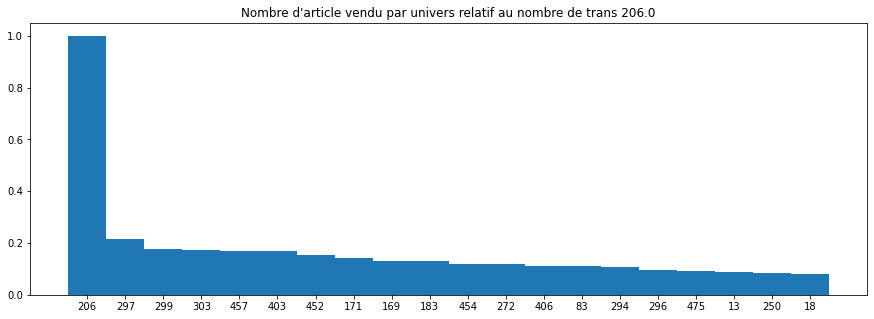

==============207.0===================
Proportion d'achat de univs 207.0 :  0.35 %
Nombre moyen d'achat en plus du univs 207.0 :  9.39
Proportion d'achat de univs 207.0 seul: 2.75 %
CA sans 207.0 :  217741.46
CA moyen sans 207.0 :  36.31
CA de 207.0 :  15889.85
CA moyen de 207.0 :  2.65


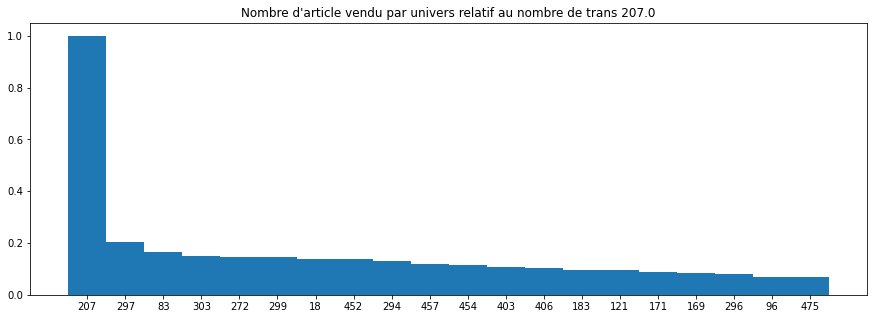

==============208.0===================
Proportion d'achat de univs 208.0 :  0.57 %
Nombre moyen d'achat en plus du univs 208.0 :  5.86
Proportion d'achat de univs 208.0 seul: 6.91 %
CA sans 208.0 :  235090.34
CA moyen sans 208.0 :  24.04
CA de 208.0 :  60624.2
CA moyen de 208.0 :  6.2


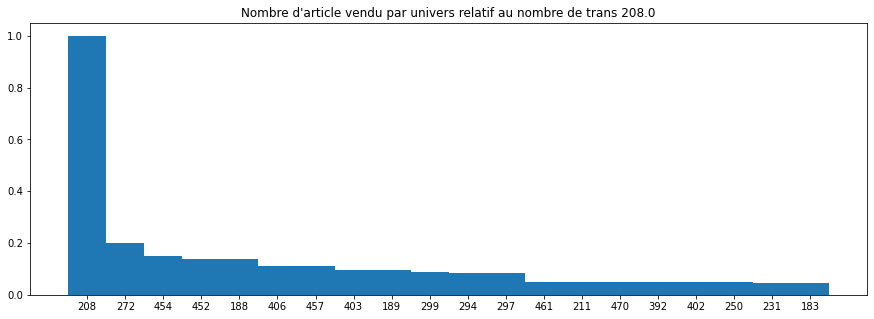

==============209.0===================
Proportion d'achat de univs 209.0 :  0.16 %
Nombre moyen d'achat en plus du univs 209.0 :  7.29
Proportion d'achat de univs 209.0 seul: 5.05 %
CA sans 209.0 :  78424.37
CA moyen sans 209.0 :  28.1
CA de 209.0 :  15505.07
CA moyen de 209.0 :  5.56


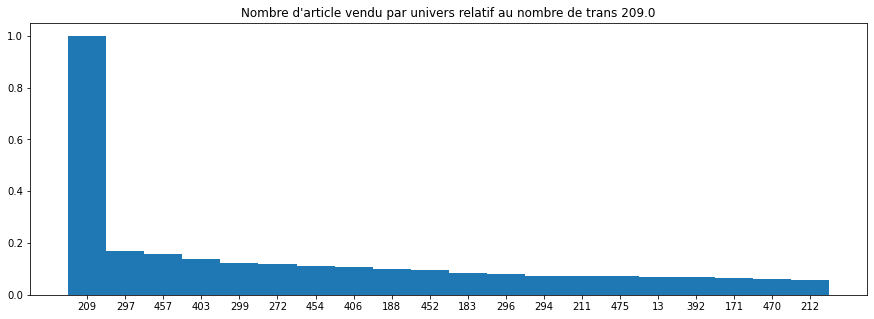

==============210.0===================
Proportion d'achat de univs 210.0 :  0.7 %
Nombre moyen d'achat en plus du univs 210.0 :  5.09
Proportion d'achat de univs 210.0 seul: 11.03 %
CA sans 210.0 :  248007.65
CA moyen sans 210.0 :  20.86
CA de 210.0 :  67439.03
CA moyen de 210.0 :  5.67


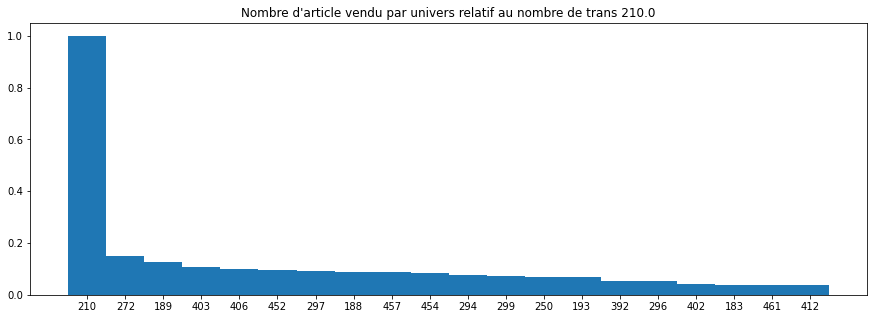

==============211.0===================
Proportion d'achat de univs 211.0 :  4.88 %
Nombre moyen d'achat en plus du univs 211.0 :  6.65
Proportion d'achat de univs 211.0 seul: 1.86 %
CA sans 211.0 :  2043760.53
CA moyen sans 211.0 :  24.54
CA de 211.0 :  198492.52
CA moyen de 211.0 :  2.38


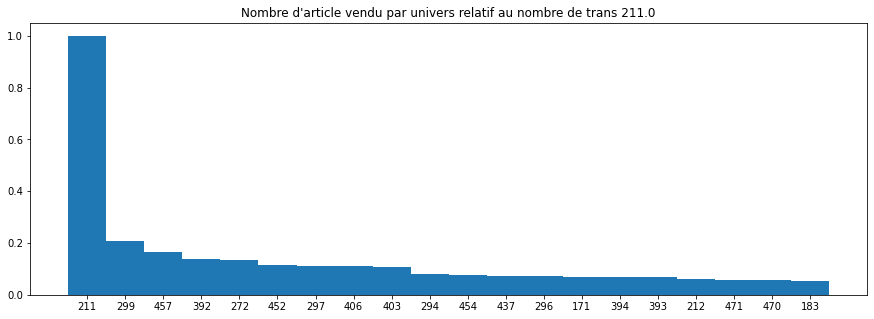

==============212.0===================
Proportion d'achat de univs 212.0 :  2.41 %
Nombre moyen d'achat en plus du univs 212.0 :  7.4
Proportion d'achat de univs 212.0 seul: 1.17 %
CA sans 212.0 :  1182259.56
CA moyen sans 212.0 :  28.75
CA de 212.0 :  97138.28
CA moyen de 212.0 :  2.36


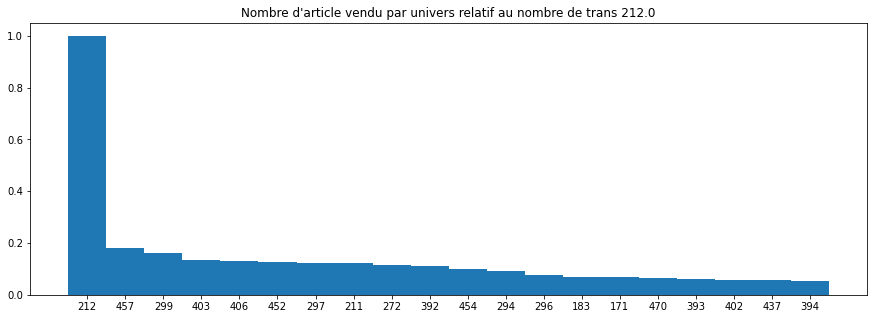

==============215.0===================
Proportion d'achat de univs 215.0 :  0.54 %
Nombre moyen d'achat en plus du univs 215.0 :  9.45
Proportion d'achat de univs 215.0 seul: 1.15 %
CA sans 215.0 :  335249.96
CA moyen sans 215.0 :  36.07
CA de 215.0 :  46337.71
CA moyen de 215.0 :  4.99


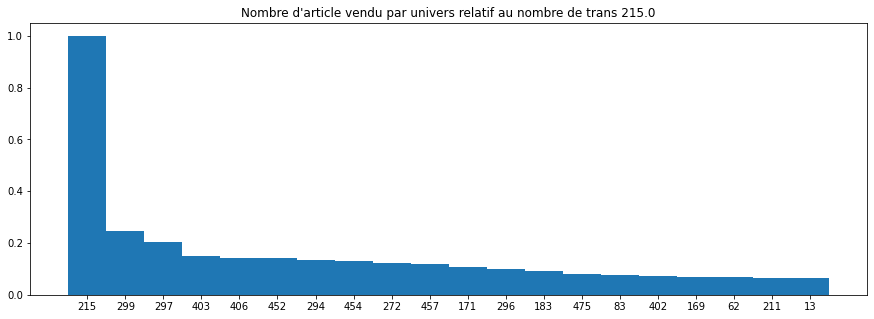

==============216.0===================
Proportion d'achat de univs 216.0 :  0.55 %
Nombre moyen d'achat en plus du univs 216.0 :  6.88
Proportion d'achat de univs 216.0 seul: 0.7 %
CA sans 216.0 :  249210.61
CA moyen sans 216.0 :  26.73
CA de 216.0 :  28309.93
CA moyen de 216.0 :  3.04


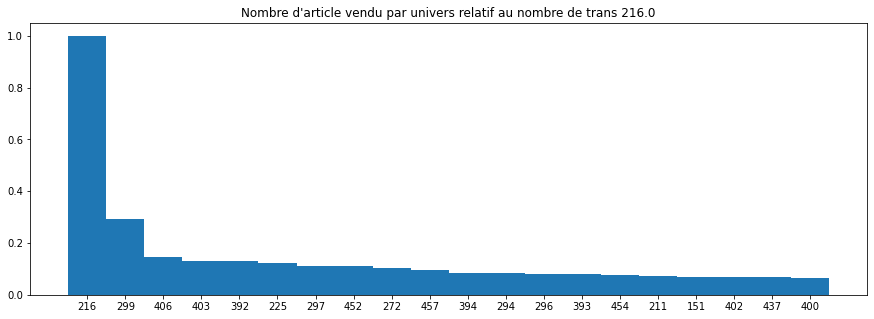

==============219.0===================
Proportion d'achat de univs 219.0 :  0.96 %
Nombre moyen d'achat en plus du univs 219.0 :  9.37
Proportion d'achat de univs 219.0 seul: 1.57 %
CA sans 219.0 :  597714.65
CA moyen sans 219.0 :  36.41
CA de 219.0 :  63784.42
CA moyen de 219.0 :  3.89


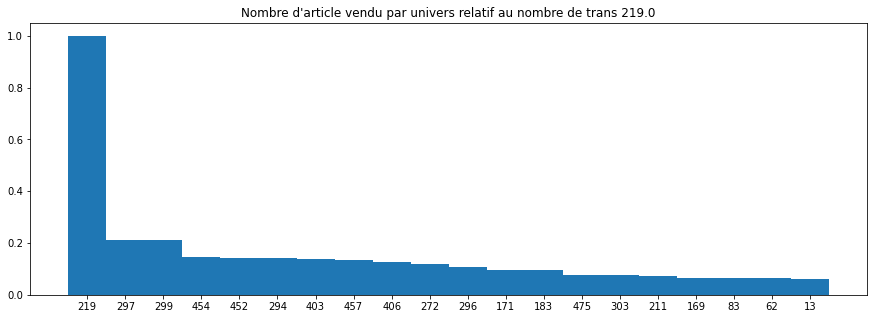

==============220.0===================
Proportion d'achat de univs 220.0 :  0.95 %
Nombre moyen d'achat en plus du univs 220.0 :  7.62
Proportion d'achat de univs 220.0 seul: 1.38 %
CA sans 220.0 :  439504.34
CA moyen sans 220.0 :  27.12
CA de 220.0 :  39718.54
CA moyen de 220.0 :  2.45


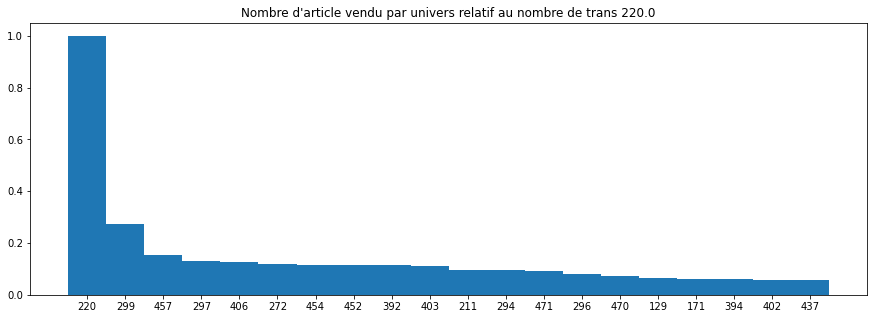

==============222.0===================
Proportion d'achat de univs 222.0 :  0.22 %
Nombre moyen d'achat en plus du univs 222.0 :  7.95
Proportion d'achat de univs 222.0 seul: 1.27 %
CA sans 222.0 :  116866.54
CA moyen sans 222.0 :  30.88
CA de 222.0 :  11526.32
CA moyen de 222.0 :  3.05


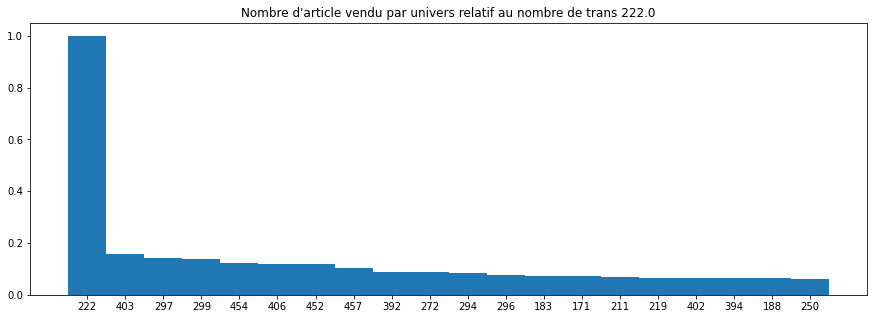

==============223.0===================
Proportion d'achat de univs 223.0 :  0.18 %
Nombre moyen d'achat en plus du univs 223.0 :  9.32
Proportion d'achat de univs 223.0 seul: 2.3 %
CA sans 223.0 :  119827.5
CA moyen sans 223.0 :  38.28
CA de 223.0 :  23945.69
CA moyen de 223.0 :  7.65


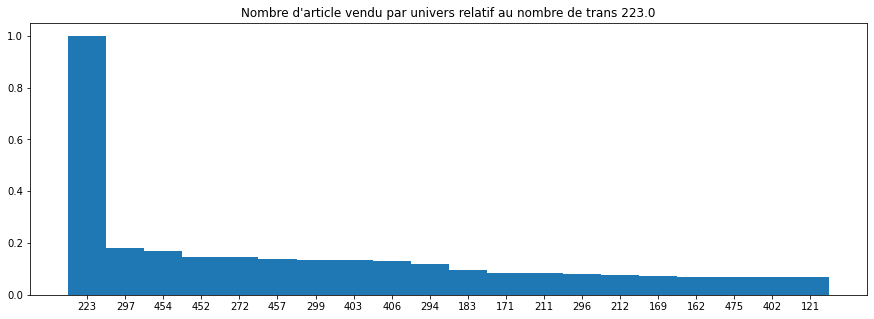

==============224.0===================
Proportion d'achat de univs 224.0 :  0.13 %
Nombre moyen d'achat en plus du univs 224.0 :  8.79
Proportion d'achat de univs 224.0 seul: 1.61 %
CA sans 224.0 :  77076.61
CA moyen sans 224.0 :  33.63
CA de 224.0 :  10752.92
CA moyen de 224.0 :  4.69


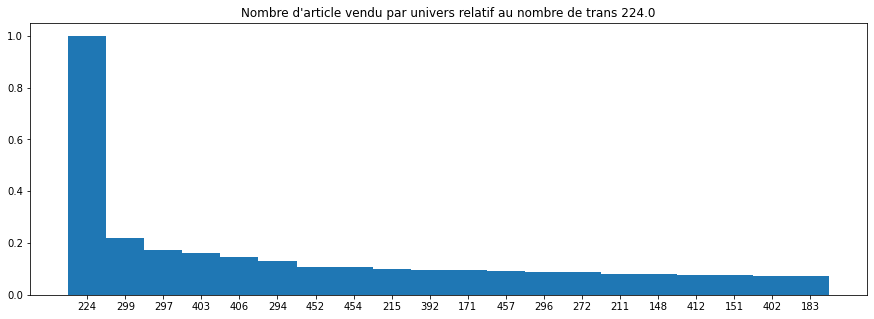

==============225.0===================
Proportion d'achat de univs 225.0 :  1.73 %
Nombre moyen d'achat en plus du univs 225.0 :  6.6
Proportion d'achat de univs 225.0 seul: 1.14 %
CA sans 225.0 :  704729.62
CA moyen sans 225.0 :  23.92
CA de 225.0 :  104979.26
CA moyen de 225.0 :  3.56


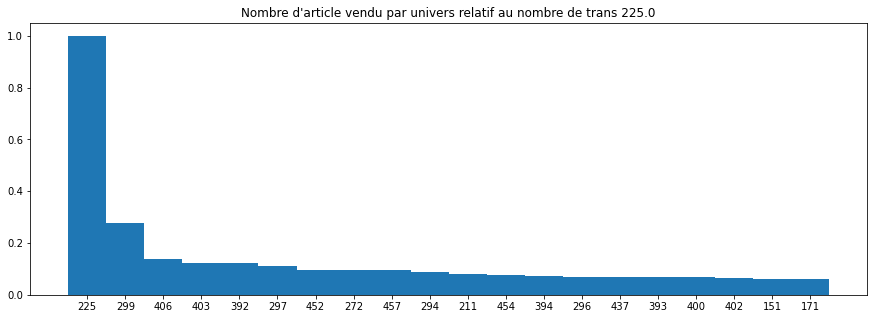

==============228.0===================
Proportion d'achat de univs 228.0 :  0.01 %
Nombre moyen d'achat en plus du univs 228.0 :  6.92
Proportion d'achat de univs 228.0 seul: 0.0 %
CA sans 228.0 :  3685.87
CA moyen sans 228.0 :  27.1
CA de 228.0 :  226.65
CA moyen de 228.0 :  1.67


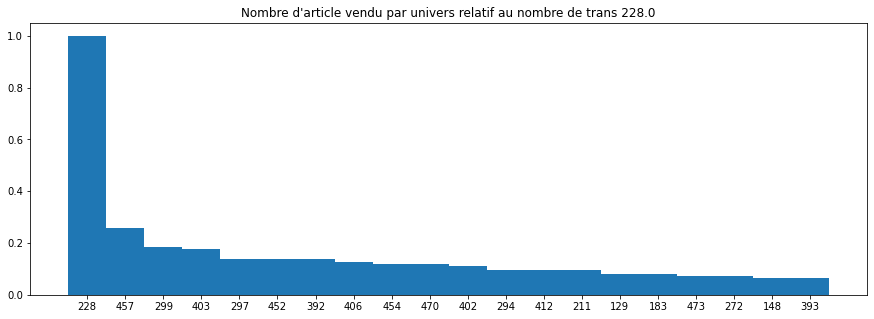

==============231.0===================
Proportion d'achat de univs 231.0 :  3.36 %
Nombre moyen d'achat en plus du univs 231.0 :  5.12
Proportion d'achat de univs 231.0 seul: 4.36 %
CA sans 231.0 :  1107894.91
CA moyen sans 231.0 :  19.31
CA de 231.0 :  174727.49
CA moyen de 231.0 :  3.04


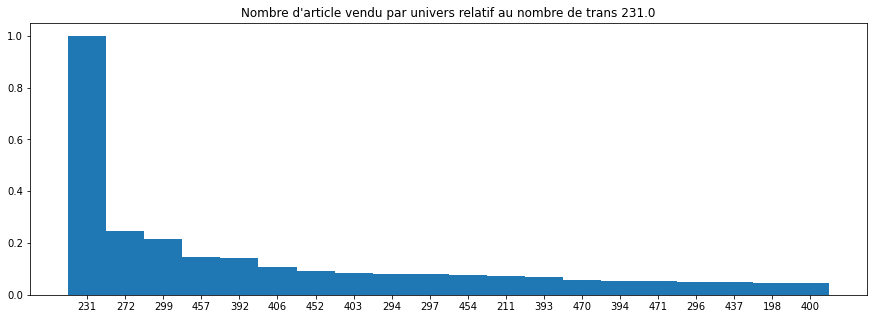

==============232.0===================
Proportion d'achat de univs 232.0 :  0.88 %
Nombre moyen d'achat en plus du univs 232.0 :  6.02
Proportion d'achat de univs 232.0 seul: 1.81 %
CA sans 232.0 :  319559.7
CA moyen sans 232.0 :  21.25
CA de 232.0 :  36026.57
CA moyen de 232.0 :  2.4


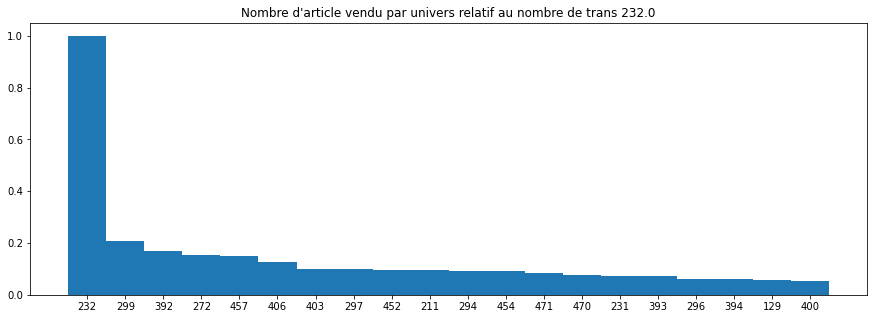

==============233.0===================
Proportion d'achat de univs 233.0 :  0.59 %
Nombre moyen d'achat en plus du univs 233.0 :  6.41
Proportion d'achat de univs 233.0 seul: 1.66 %
CA sans 233.0 :  243875.62
CA moyen sans 233.0 :  24.1
CA de 233.0 :  31474.37
CA moyen de 233.0 :  3.11


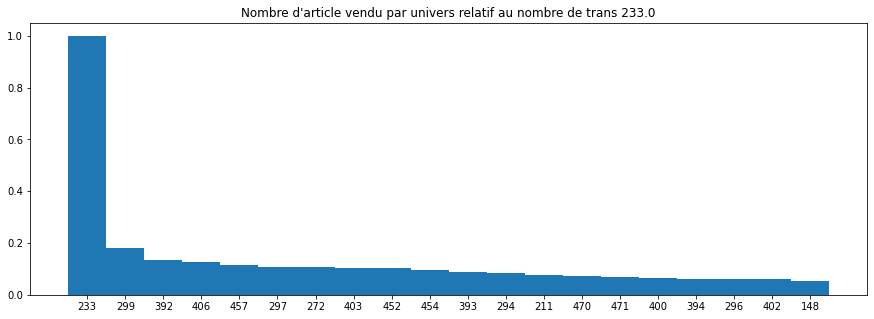

==============235.0===================
Proportion d'achat de univs 235.0 :  0.22 %
Nombre moyen d'achat en plus du univs 235.0 :  7.84
Proportion d'achat de univs 235.0 seul: 0.29 %
CA sans 235.0 :  108094.11
CA moyen sans 235.0 :  28.39
CA de 235.0 :  6226.59
CA moyen de 235.0 :  1.64


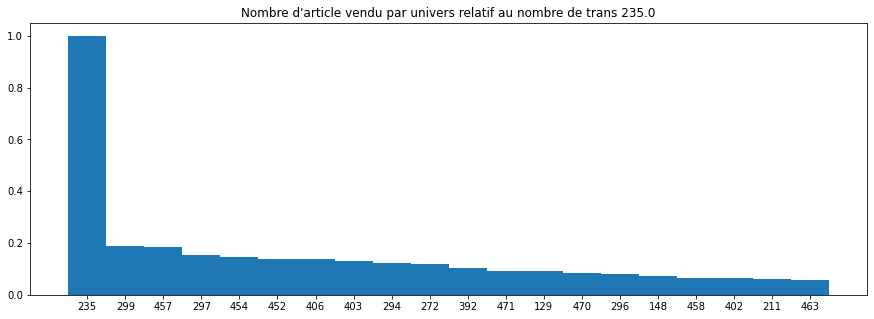

==============236.0===================
Proportion d'achat de univs 236.0 :  0.58 %
Nombre moyen d'achat en plus du univs 236.0 :  6.07
Proportion d'achat de univs 236.0 seul: 4.67 %
CA sans 236.0 :  253579.35
CA moyen sans 236.0 :  25.73
CA de 236.0 :  87646.04
CA moyen de 236.0 :  8.89


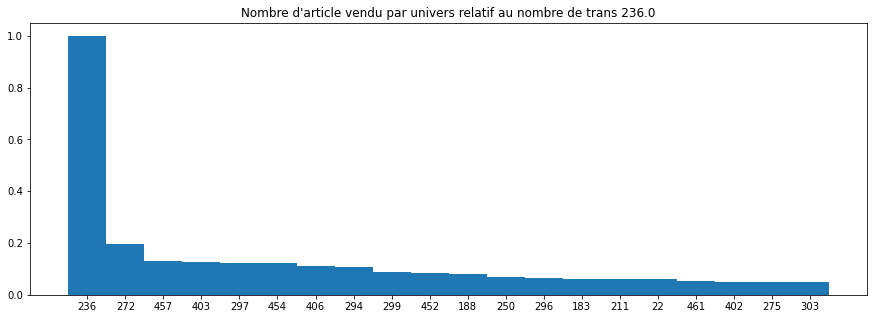

==============237.0===================
NO DATA 
==============238.0===================
Proportion d'achat de univs 238.0 :  0.11 %
Nombre moyen d'achat en plus du univs 238.0 :  6.45
Proportion d'achat de univs 238.0 seul: 5.79 %
CA sans 238.0 :  53536.19
CA moyen sans 238.0 :  28.42
CA de 238.0 :  21845.87
CA moyen de 238.0 :  11.6


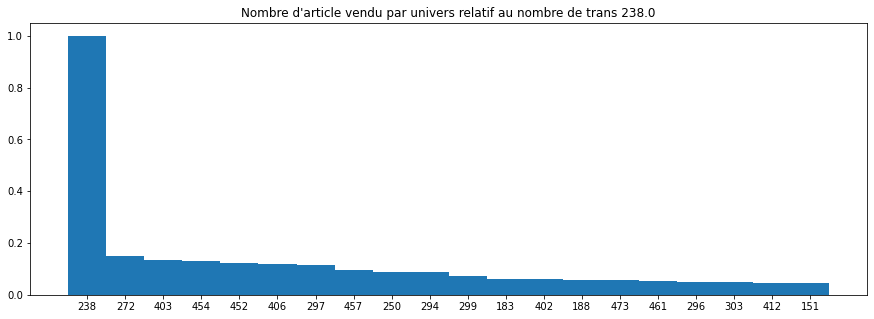

==============239.0===================
Proportion d'achat de univs 239.0 :  0.48 %
Nombre moyen d'achat en plus du univs 239.0 :  6.45
Proportion d'achat de univs 239.0 seul: 5.25 %
CA sans 239.0 :  237927.49
CA moyen sans 239.0 :  29.14
CA de 239.0 :  101893.08
CA moyen de 239.0 :  12.48


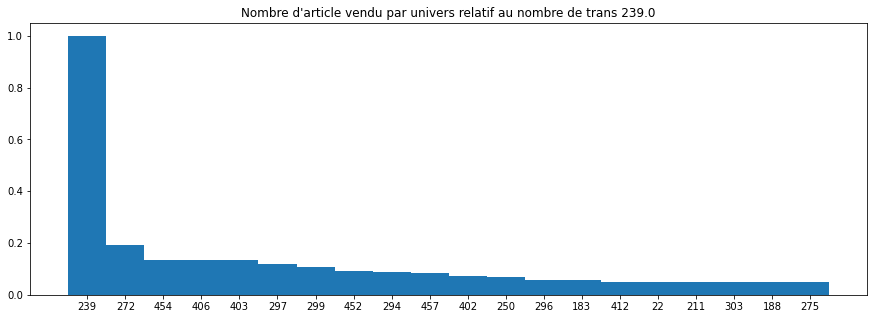

==============240.0===================
Proportion d'achat de univs 240.0 :  0.11 %
Nombre moyen d'achat en plus du univs 240.0 :  7.35
Proportion d'achat de univs 240.0 seul: 5.95 %
CA sans 240.0 :  61666.58
CA moyen sans 240.0 :  33.99
CA de 240.0 :  28221.18
CA moyen de 240.0 :  15.56


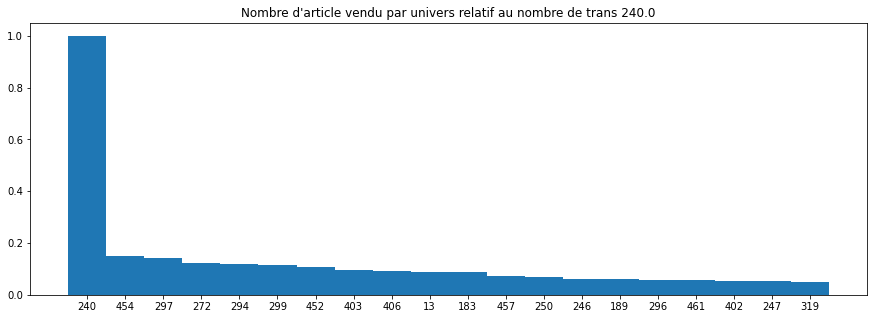

==============241.0===================
Proportion d'achat de univs 241.0 :  0.13 %
Nombre moyen d'achat en plus du univs 241.0 :  7.75
Proportion d'achat de univs 241.0 seul: 2.76 %
CA sans 241.0 :  73201.58
CA moyen sans 241.0 :  34.25
CA de 241.0 :  23128.35
CA moyen de 241.0 :  10.82


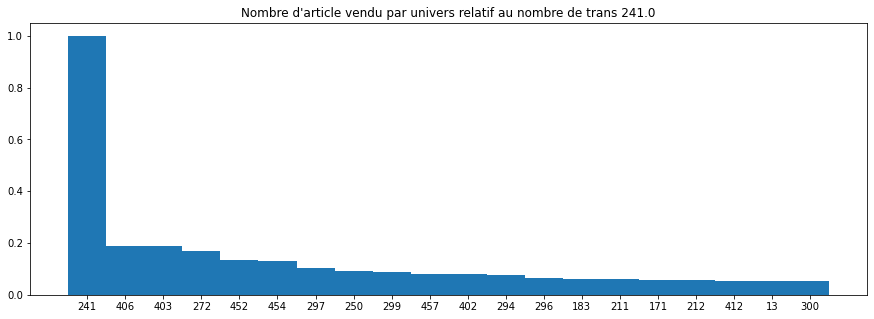

==============242.0===================
Proportion d'achat de univs 242.0 :  0.1 %
Nombre moyen d'achat en plus du univs 242.0 :  7.48
Proportion d'achat de univs 242.0 seul: 4.6 %
CA sans 242.0 :  62596.48
CA moyen sans 242.0 :  35.11
CA de 242.0 :  24714.69
CA moyen de 242.0 :  13.86


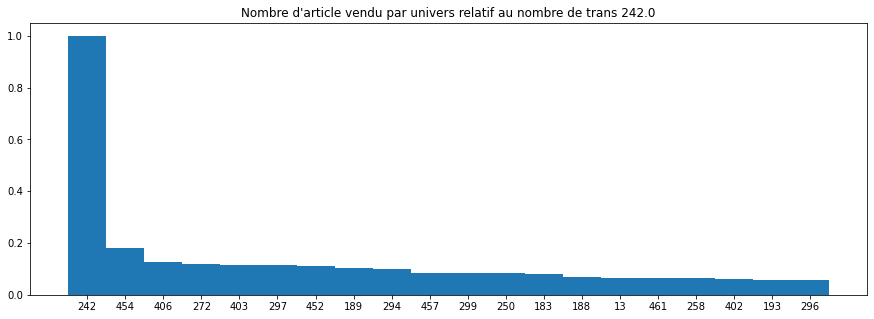

==============243.0===================
Proportion d'achat de univs 243.0 :  0.05 %
Nombre moyen d'achat en plus du univs 243.0 :  5.74
Proportion d'achat de univs 243.0 seul: 6.35 %
CA sans 243.0 :  20859.58
CA moyen sans 243.0 :  25.47
CA de 243.0 :  5254.88
CA moyen de 243.0 :  6.42


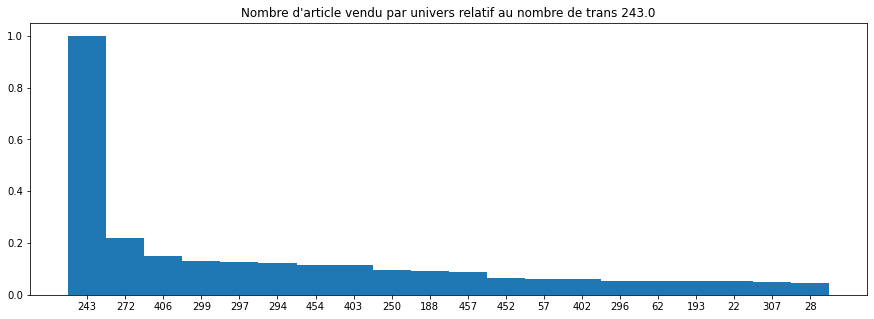

==============244.0===================
Proportion d'achat de univs 244.0 :  0.15 %
Nombre moyen d'achat en plus du univs 244.0 :  6.88
Proportion d'achat de univs 244.0 seul: 6.09 %
CA sans 244.0 :  77356.23
CA moyen sans 244.0 :  31.22
CA de 244.0 :  34024.51
CA moyen de 244.0 :  13.73


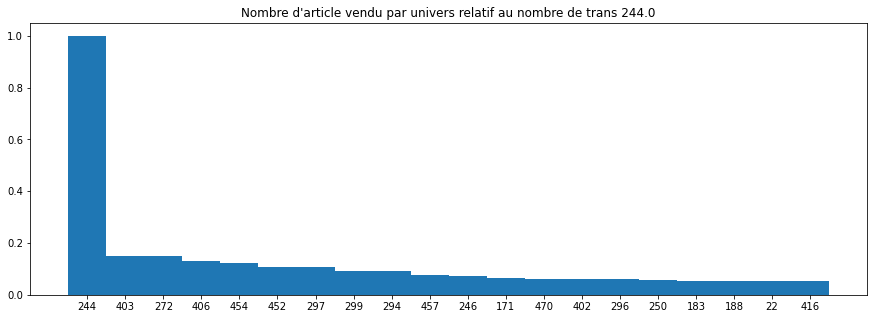

==============245.0===================
Proportion d'achat de univs 245.0 :  0.14 %
Nombre moyen d'achat en plus du univs 245.0 :  6.55
Proportion d'achat de univs 245.0 seul: 5.92 %
CA sans 245.0 :  72991.78
CA moyen sans 245.0 :  30.41
CA de 245.0 :  27141.79
CA moyen de 245.0 :  11.31


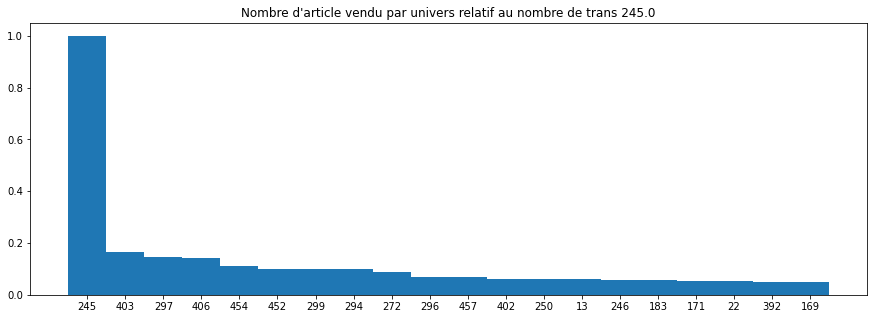

==============246.0===================
Proportion d'achat de univs 246.0 :  2.06 %
Nombre moyen d'achat en plus du univs 246.0 :  6.32
Proportion d'achat de univs 246.0 seul: 6.69 %
CA sans 246.0 :  984894.17
CA moyen sans 246.0 :  27.97
CA de 246.0 :  457084.46
CA moyen de 246.0 :  12.98


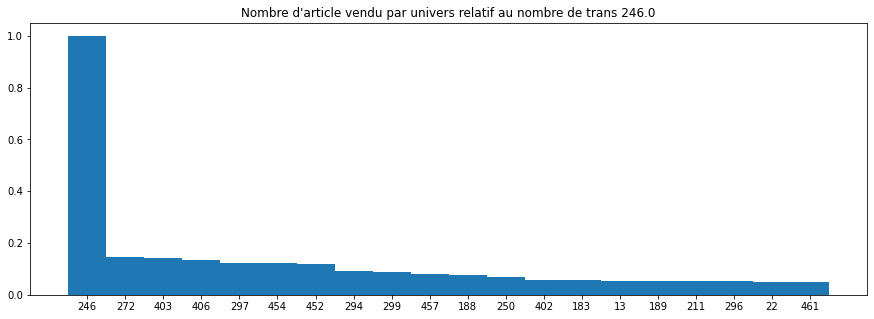

==============247.0===================
Proportion d'achat de univs 247.0 :  0.43 %
Nombre moyen d'achat en plus du univs 247.0 :  7.53
Proportion d'achat de univs 247.0 seul: 4.69 %
CA sans 247.0 :  267249.68
CA moyen sans 247.0 :  36.13
CA de 247.0 :  115973.93
CA moyen de 247.0 :  15.68


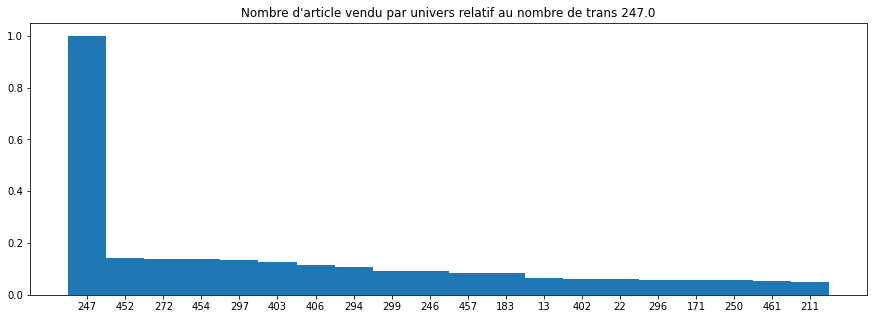

==============248.0===================
Proportion d'achat de univs 248.0 :  0.2 %
Nombre moyen d'achat en plus du univs 248.0 :  6.56
Proportion d'achat de univs 248.0 seul: 5.54 %
CA sans 248.0 :  98140.42
CA moyen sans 248.0 :  29.21
CA de 248.0 :  30818.5
CA moyen de 248.0 :  9.17


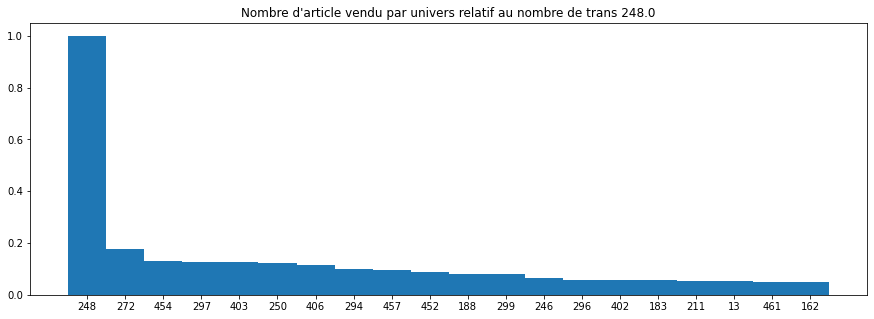

==============249.0===================
Proportion d'achat de univs 249.0 :  0.95 %
Nombre moyen d'achat en plus du univs 249.0 :  6.37
Proportion d'achat de univs 249.0 seul: 5.61 %
CA sans 249.0 :  460784.34
CA moyen sans 249.0 :  28.51
CA de 249.0 :  171463.19
CA moyen de 249.0 :  10.61


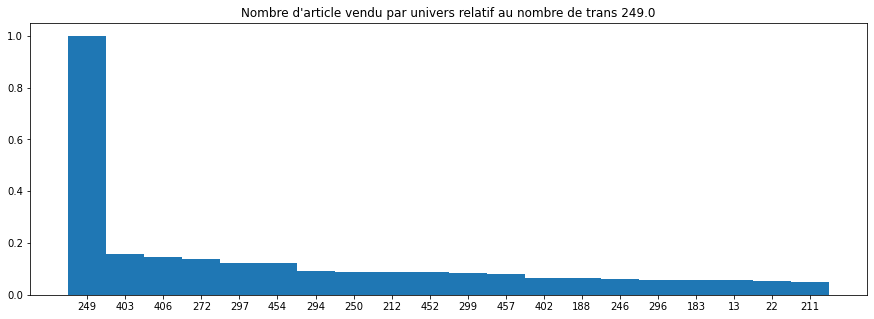

==============250.0===================
Proportion d'achat de univs 250.0 :  3.61 %
Nombre moyen d'achat en plus du univs 250.0 :  5.76
Proportion d'achat de univs 250.0 seul: 7.23 %
CA sans 250.0 :  1514955.86
CA moyen sans 250.0 :  24.62
CA de 250.0 :  620741.51
CA moyen de 250.0 :  10.09


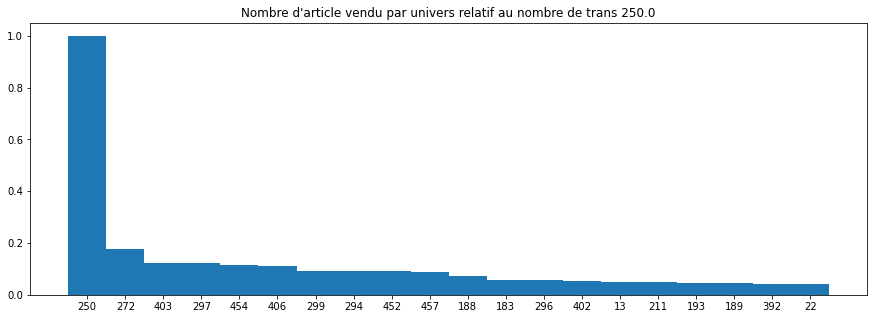

==============251.0===================
Proportion d'achat de univs 251.0 :  0.83 %
Nombre moyen d'achat en plus du univs 251.0 :  6.91
Proportion d'achat de univs 251.0 seul: 6.32 %
CA sans 251.0 :  436299.65
CA moyen sans 251.0 :  30.68
CA de 251.0 :  237242.4
CA moyen de 251.0 :  16.68


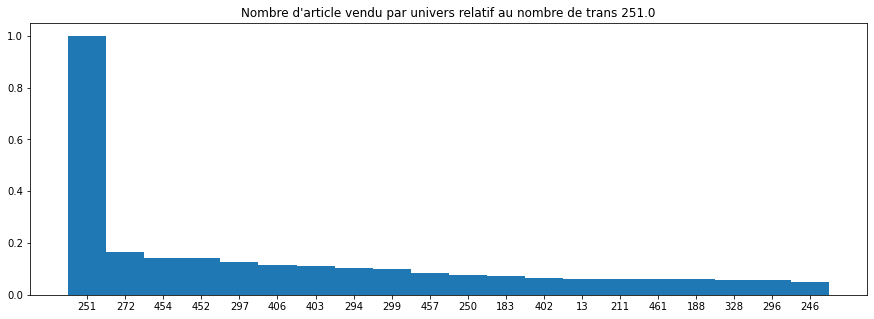

==============252.0===================
Proportion d'achat de univs 252.0 :  0.09 %
Nombre moyen d'achat en plus du univs 252.0 :  6.55
Proportion d'achat de univs 252.0 seul: 6.27 %
CA sans 252.0 :  47360.46
CA moyen sans 252.0 :  31.57
CA de 252.0 :  20327.22
CA moyen de 252.0 :  13.55


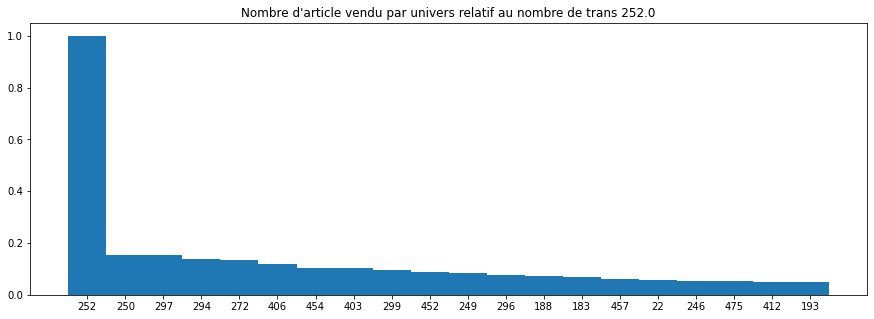

==============253.0===================
Proportion d'achat de univs 253.0 :  0.04 %
Nombre moyen d'achat en plus du univs 253.0 :  6.91
Proportion d'achat de univs 253.0 seul: 3.76 %
CA sans 253.0 :  22105.19
CA moyen sans 253.0 :  29.67
CA de 253.0 :  6307.66
CA moyen de 253.0 :  8.47


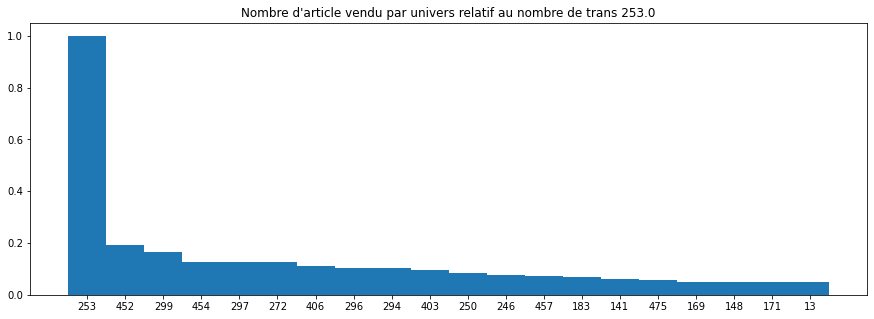

==============254.0===================
Proportion d'achat de univs 254.0 :  0.46 %
Nombre moyen d'achat en plus du univs 254.0 :  5.15
Proportion d'achat de univs 254.0 seul: 6.11 %
CA sans 254.0 :  162872.34
CA moyen sans 254.0 :  20.78
CA de 254.0 :  39946.93
CA moyen de 254.0 :  5.1


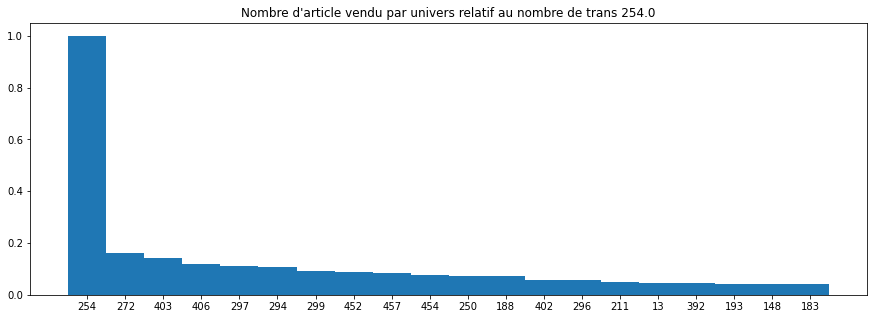

==============255.0===================
Proportion d'achat de univs 255.0 :  0.42 %
Nombre moyen d'achat en plus du univs 255.0 :  7.19
Proportion d'achat de univs 255.0 seul: 5.92 %
CA sans 255.0 :  244727.34
CA moyen sans 255.0 :  34.4
CA de 255.0 :  104880.33
CA moyen de 255.0 :  14.74


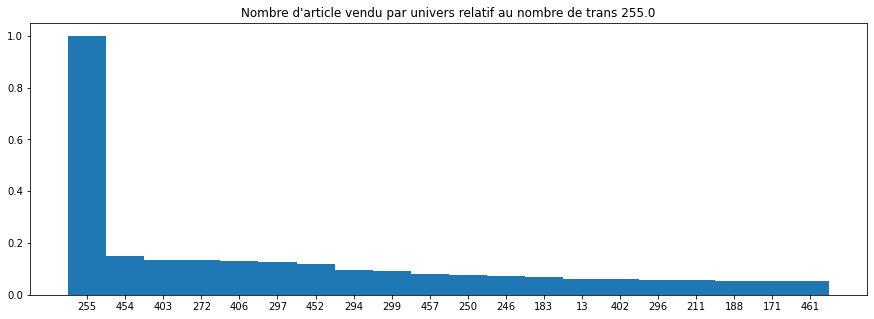

==============256.0===================
Proportion d'achat de univs 256.0 :  0.07 %
Nombre moyen d'achat en plus du univs 256.0 :  7.1
Proportion d'achat de univs 256.0 seul: 5.97 %
CA sans 256.0 :  39737.1
CA moyen sans 256.0 :  32.92
CA de 256.0 :  12277.25
CA moyen de 256.0 :  10.17


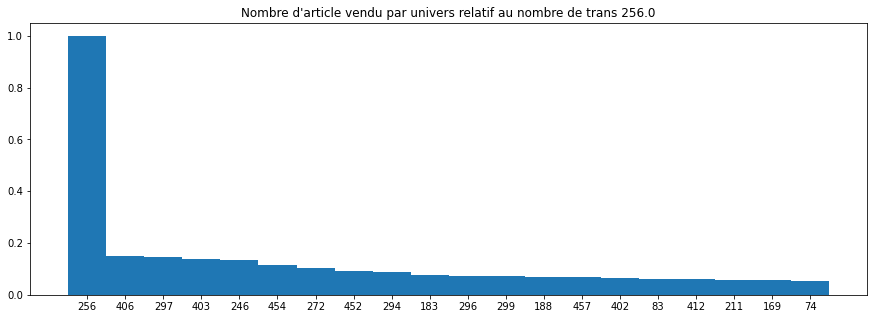

==============258.0===================
Proportion d'achat de univs 258.0 :  0.36 %
Nombre moyen d'achat en plus du univs 258.0 :  7.0
Proportion d'achat de univs 258.0 seul: 5.41 %
CA sans 258.0 :  194811.74
CA moyen sans 258.0 :  31.92
CA de 258.0 :  78927.23
CA moyen de 258.0 :  12.93


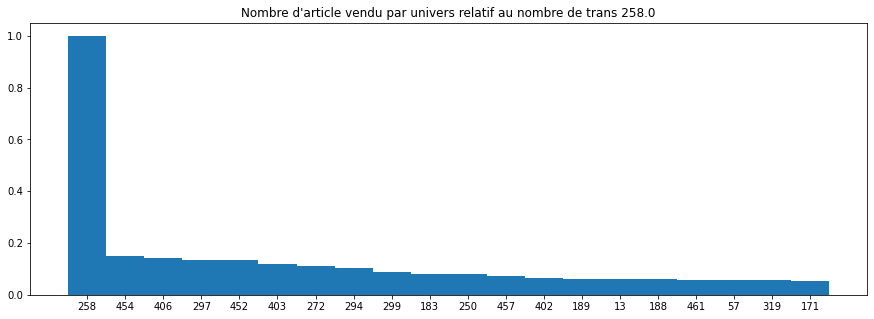

==============259.0===================
Proportion d'achat de univs 259.0 :  0.1 %
Nombre moyen d'achat en plus du univs 259.0 :  5.98
Proportion d'achat de univs 259.0 seul: 8.91 %
CA sans 259.0 :  42926.73
CA moyen sans 259.0 :  24.06
CA de 259.0 :  12490.74
CA moyen de 259.0 :  7.0


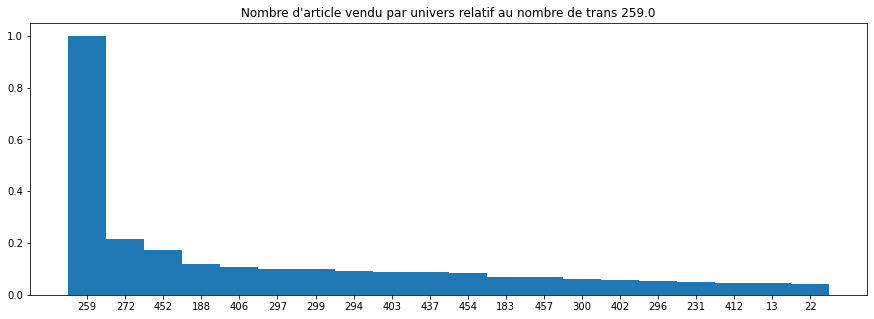

==============261.0===================
NO DATA 
==============262.0===================
Proportion d'achat de univs 262.0 :  0.34 %
Nombre moyen d'achat en plus du univs 262.0 :  6.37
Proportion d'achat de univs 262.0 seul: 4.02 %
CA sans 262.0 :  160484.53
CA moyen sans 262.0 :  27.35
CA de 262.0 :  48010.02
CA moyen de 262.0 :  8.18


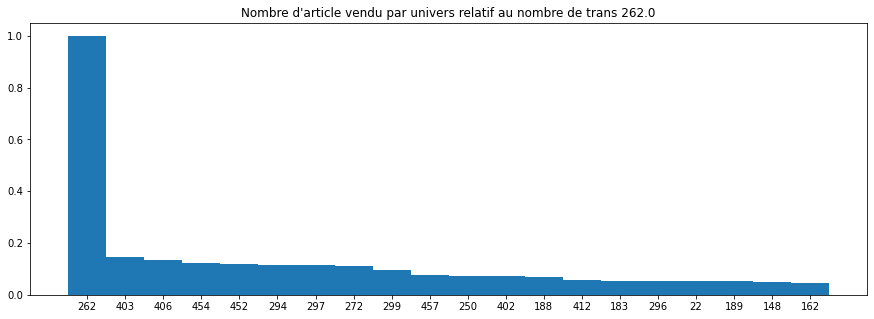

==============263.0===================
Proportion d'achat de univs 263.0 :  0.11 %
Nombre moyen d'achat en plus du univs 263.0 :  7.0
Proportion d'achat de univs 263.0 seul: 5.11 %
CA sans 263.0 :  59975.08
CA moyen sans 263.0 :  30.93
CA de 263.0 :  27863.42
CA moyen de 263.0 :  14.37


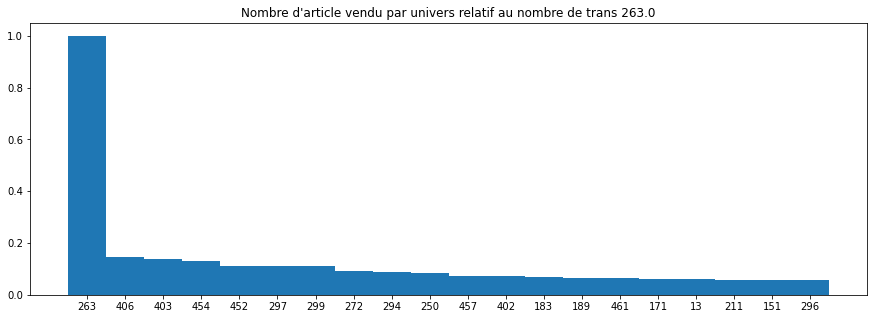

==============264.0===================
Proportion d'achat de univs 264.0 :  0.01 %
Nombre moyen d'achat en plus du univs 264.0 :  7.57
Proportion d'achat de univs 264.0 seul: 5.81 %
CA sans 264.0 :  5966.35
CA moyen sans 264.0 :  34.69
CA de 264.0 :  2665.49
CA moyen de 264.0 :  15.5


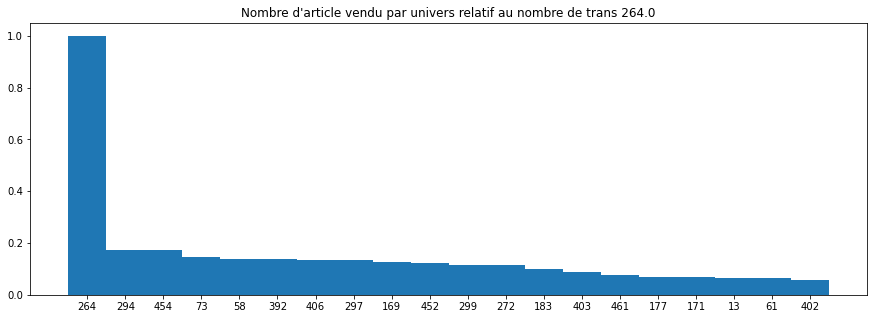

==============265.0===================
NO DATA 
==============266.0===================
Proportion d'achat de univs 266.0 :  0.14 %
Nombre moyen d'achat en plus du univs 266.0 :  6.72
Proportion d'achat de univs 266.0 seul: 6.46 %
CA sans 266.0 :  64836.78
CA moyen sans 266.0 :  27.57
CA de 266.0 :  14669.03
CA moyen de 266.0 :  6.24


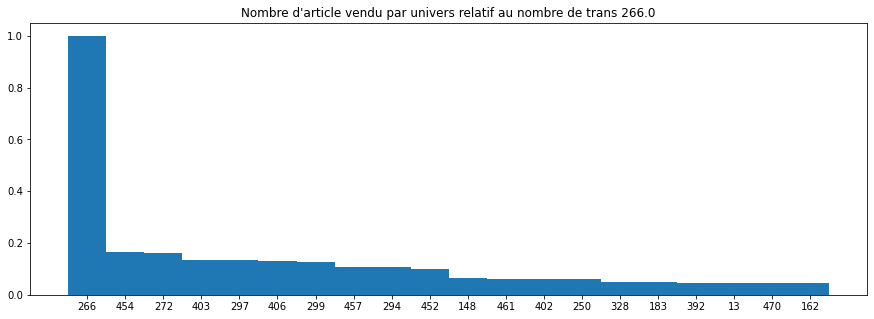

==============267.0===================
Proportion d'achat de univs 267.0 :  0.54 %
Nombre moyen d'achat en plus du univs 267.0 :  7.06
Proportion d'achat de univs 267.0 seul: 8.21 %
CA sans 267.0 :  290230.97
CA moyen sans 267.0 :  31.48
CA de 267.0 :  47164.26
CA moyen de 267.0 :  5.12


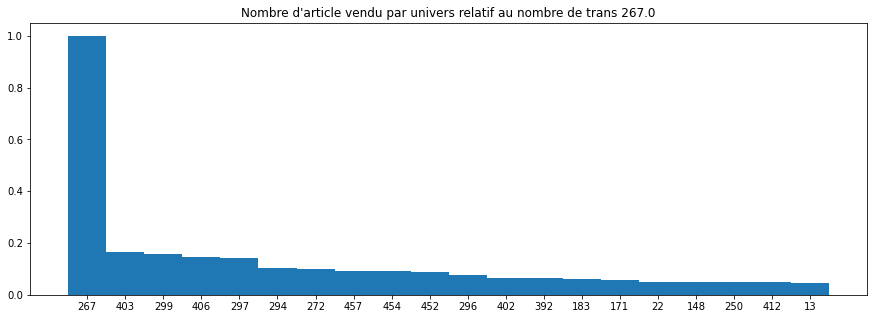

==============268.0===================
Proportion d'achat de univs 268.0 :  0.01 %
Nombre moyen d'achat en plus du univs 268.0 :  8.37
Proportion d'achat de univs 268.0 seul: 4.5 %
CA sans 268.0 :  7285.6
CA moyen sans 268.0 :  36.43
CA de 268.0 :  2638.46
CA moyen de 268.0 :  13.19


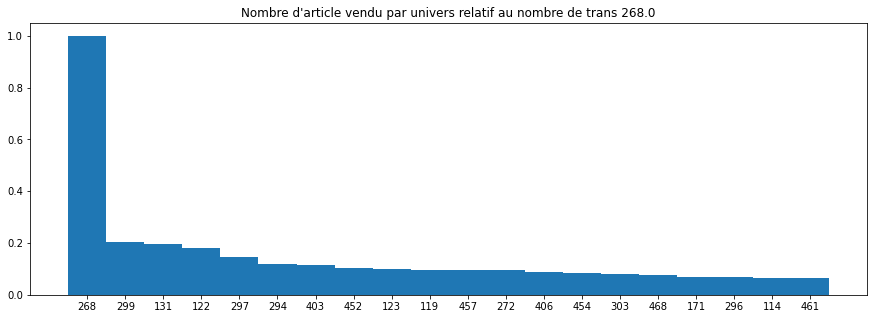

==============269.0===================
Proportion d'achat de univs 269.0 :  0.53 %
Nombre moyen d'achat en plus du univs 269.0 :  5.58
Proportion d'achat de univs 269.0 seul: 13.97 %
CA sans 269.0 :  223004.47
CA moyen sans 269.0 :  24.7
CA de 269.0 :  198421.53
CA moyen de 269.0 :  21.98


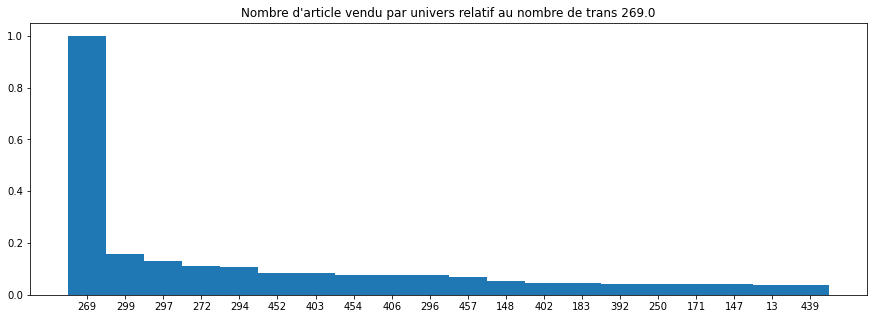

==============270.0===================
Proportion d'achat de univs 270.0 :  0.86 %
Nombre moyen d'achat en plus du univs 270.0 :  7.04
Proportion d'achat de univs 270.0 seul: 2.83 %
CA sans 270.0 :  404468.02
CA moyen sans 270.0 :  27.56
CA de 270.0 :  60717.63
CA moyen de 270.0 :  4.14


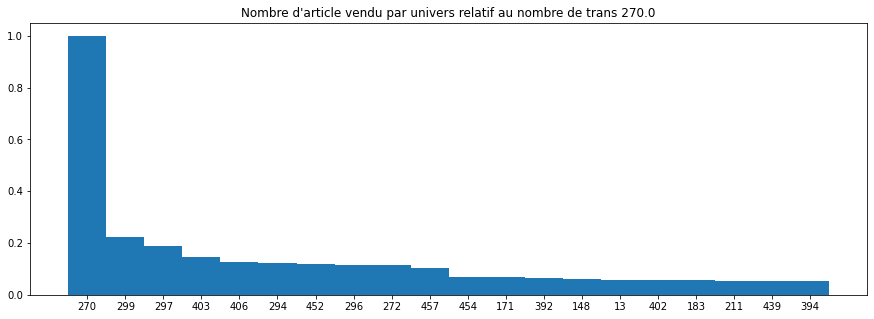

==============271.0===================
Proportion d'achat de univs 271.0 :  0.54 %
Nombre moyen d'achat en plus du univs 271.0 :  6.23
Proportion d'achat de univs 271.0 seul: 1.75 %
CA sans 271.0 :  250082.93
CA moyen sans 271.0 :  27.08
CA de 271.0 :  13755.23
CA moyen de 271.0 :  1.49


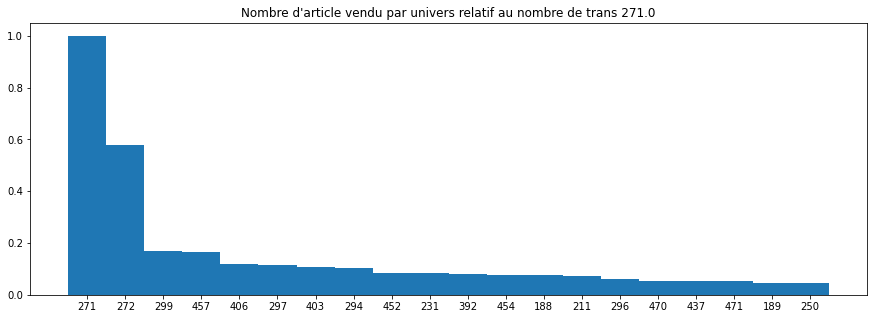

==============272.0===================
Proportion d'achat de univs 272.0 :  10.67 %
Nombre moyen d'achat en plus du univs 272.0 :  5.45
Proportion d'achat de univs 272.0 seul: 3.23 %
CA sans 272.0 :  3776869.49
CA moyen sans 272.0 :  20.75
CA de 272.0 :  2035603.32
CA moyen de 272.0 :  11.19


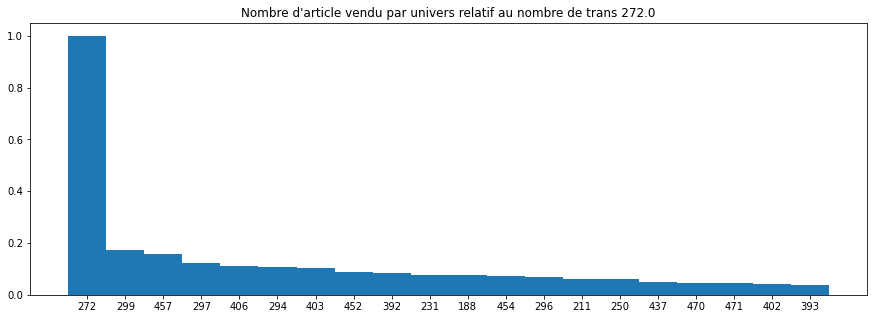

==============273.0===================
Proportion d'achat de univs 273.0 :  0.13 %
Nombre moyen d'achat en plus du univs 273.0 :  7.93
Proportion d'achat de univs 273.0 seul: 5.5 %
CA sans 273.0 :  69417.42
CA moyen sans 273.0 :  31.52
CA de 273.0 :  17982.9
CA moyen de 273.0 :  8.17


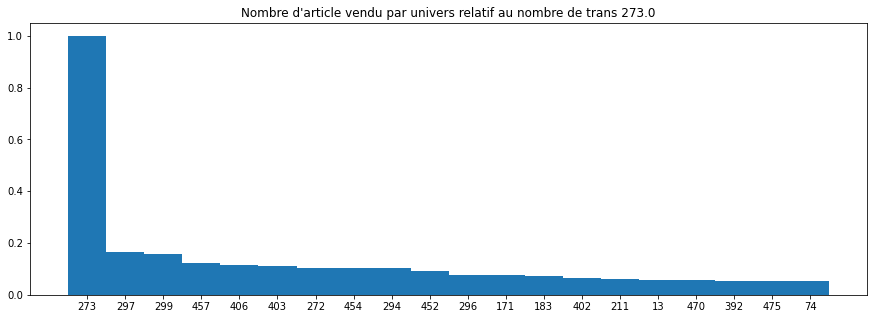

==============275.0===================
Proportion d'achat de univs 275.0 :  0.67 %
Nombre moyen d'achat en plus du univs 275.0 :  8.45
Proportion d'achat de univs 275.0 seul: 2.72 %
CA sans 275.0 :  390151.54
CA moyen sans 275.0 :  33.97
CA de 275.0 :  62091.13
CA moyen de 275.0 :  5.41


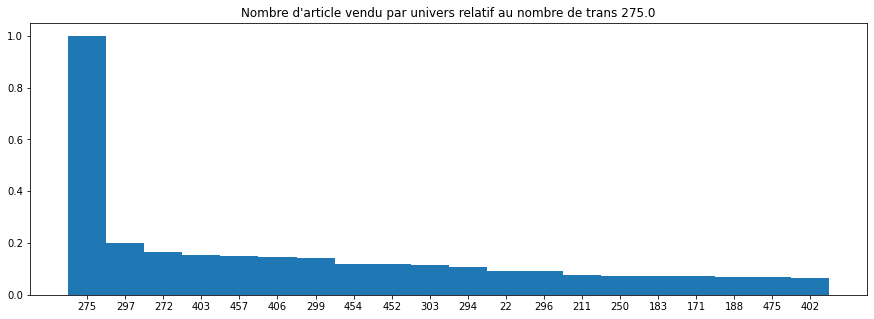

==============276.0===================
Proportion d'achat de univs 276.0 :  0.33 %
Nombre moyen d'achat en plus du univs 276.0 :  9.57
Proportion d'achat de univs 276.0 seul: 2.51 %
CA sans 276.0 :  224639.45
CA moyen sans 276.0 :  39.77
CA de 276.0 :  33850.52
CA moyen de 276.0 :  5.99


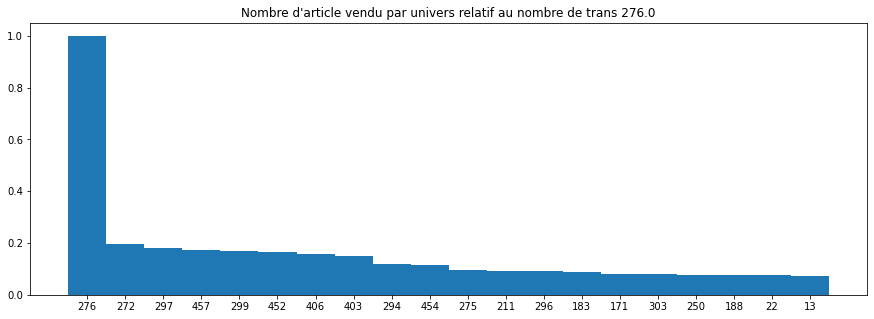

==============277.0===================
Proportion d'achat de univs 277.0 :  0.81 %
Nombre moyen d'achat en plus du univs 277.0 :  7.01
Proportion d'achat de univs 277.0 seul: 5.54 %
CA sans 277.0 :  423429.43
CA moyen sans 277.0 :  30.55
CA de 277.0 :  45836.4
CA moyen de 277.0 :  3.31


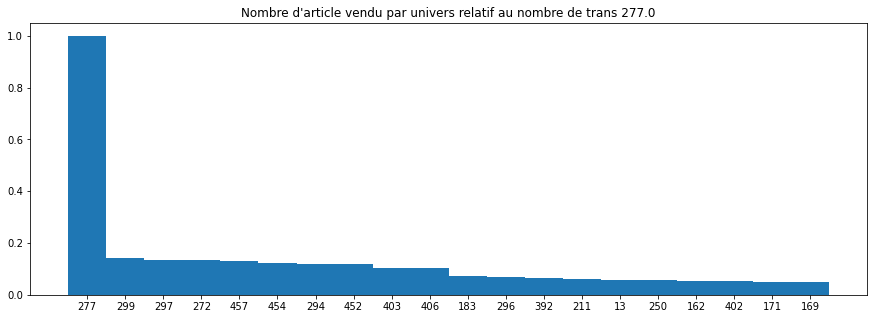

==============278.0===================
Proportion d'achat de univs 278.0 :  0.01 %
Nombre moyen d'achat en plus du univs 278.0 :  7.1
Proportion d'achat de univs 278.0 seul: 5.41 %
CA sans 278.0 :  3707.13
CA moyen sans 278.0 :  33.4
CA de 278.0 :  968.5
CA moyen de 278.0 :  8.73


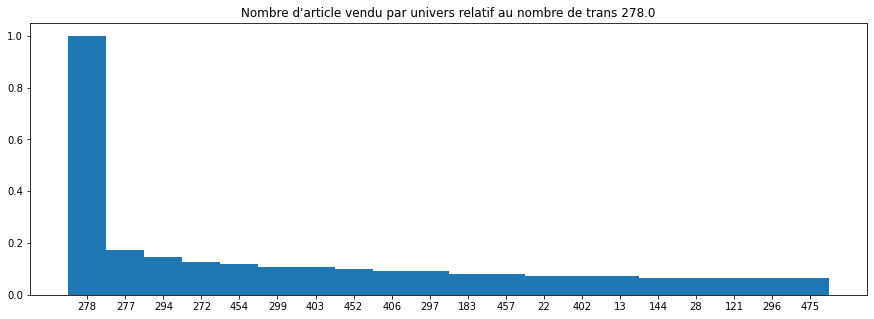

==============279.0===================
NO DATA 
==============286.0===================
Proportion d'achat de univs 286.0 :  0.32 %
Nombre moyen d'achat en plus du univs 286.0 :  10.07
Proportion d'achat de univs 286.0 seul: 2.12 %
CA sans 286.0 :  216852.3
CA moyen sans 286.0 :  39.69
CA de 286.0 :  29275.74
CA moyen de 286.0 :  5.36


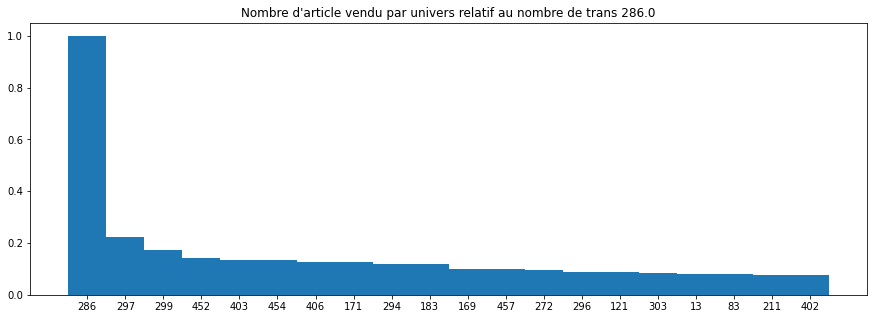

==============287.0===================
Proportion d'achat de univs 287.0 :  1.02 %
Nombre moyen d'achat en plus du univs 287.0 :  10.29
Proportion d'achat de univs 287.0 seul: 1.16 %
CA sans 287.0 :  682061.33
CA moyen sans 287.0 :  39.1
CA de 287.0 :  99035.89
CA moyen de 287.0 :  5.68


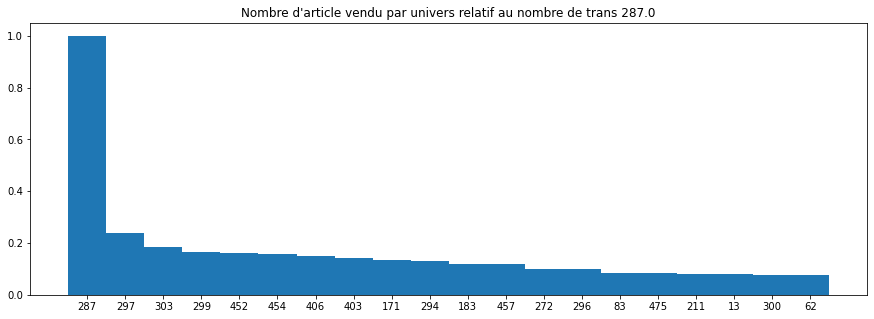

==============288.0===================
Proportion d'achat de univs 288.0 :  0.78 %
Nombre moyen d'achat en plus du univs 288.0 :  10.53
Proportion d'achat de univs 288.0 seul: 0.94 %
CA sans 288.0 :  537049.54
CA moyen sans 288.0 :  40.53
CA de 288.0 :  58935.93
CA moyen de 288.0 :  4.45


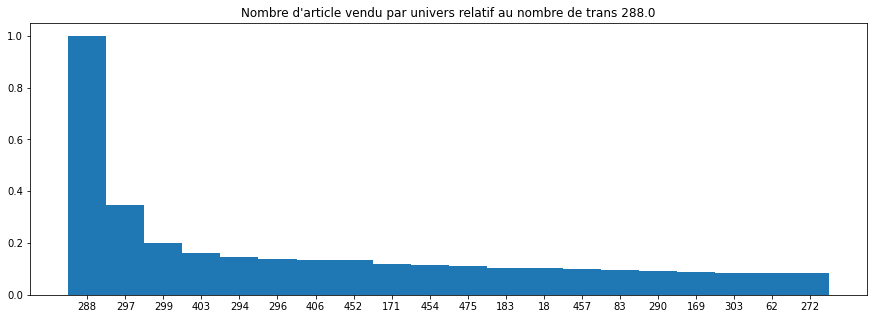

==============289.0===================
Proportion d'achat de univs 289.0 :  0.16 %
Nombre moyen d'achat en plus du univs 289.0 :  10.99
Proportion d'achat de univs 289.0 seul: 1.73 %
CA sans 289.0 :  118840.44
CA moyen sans 289.0 :  42.76
CA de 289.0 :  14774.96
CA moyen de 289.0 :  5.32


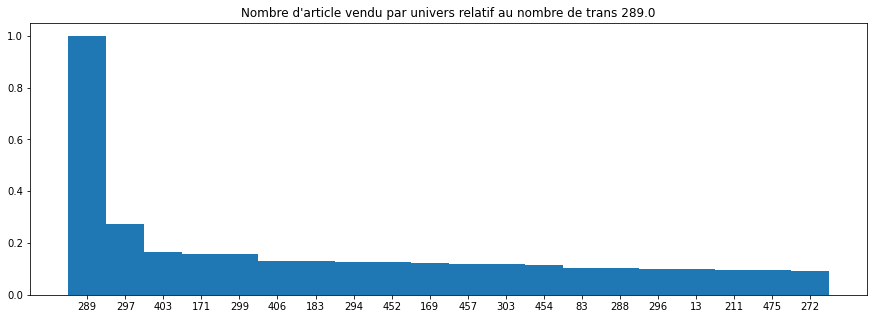

==============290.0===================
Proportion d'achat de univs 290.0 :  0.81 %
Nombre moyen d'achat en plus du univs 290.0 :  9.76
Proportion d'achat de univs 290.0 seul: 1.4 %
CA sans 290.0 :  511530.62
CA moyen sans 290.0 :  36.8
CA de 290.0 :  62796.39
CA moyen de 290.0 :  4.52


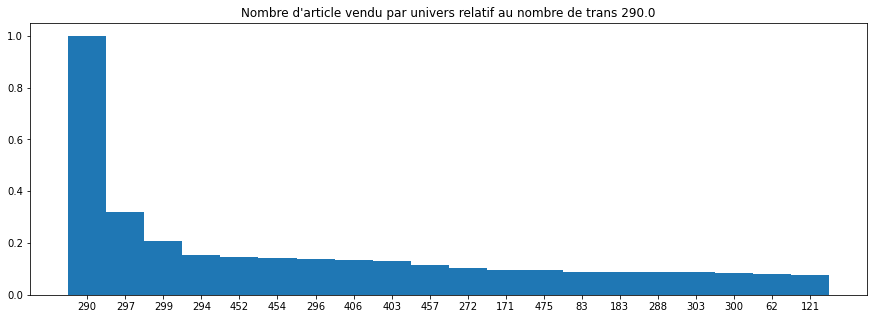

==============291.0===================
Proportion d'achat de univs 291.0 :  0.13 %
Nombre moyen d'achat en plus du univs 291.0 :  10.49
Proportion d'achat de univs 291.0 seul: 1.45 %
CA sans 291.0 :  84077.75
CA moyen sans 291.0 :  39.33
CA de 291.0 :  10576.84
CA moyen de 291.0 :  4.95


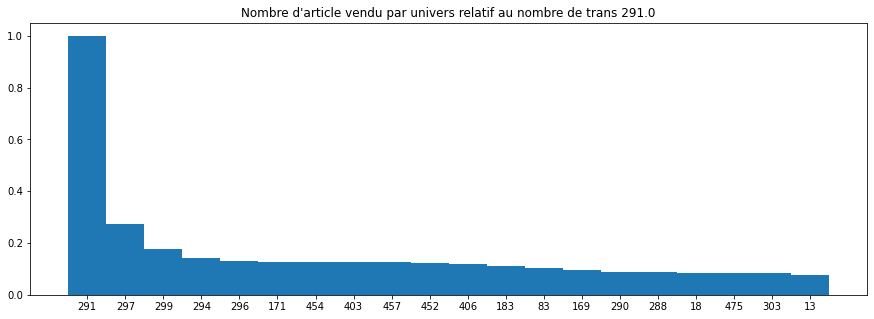

==============292.0===================
Proportion d'achat de univs 292.0 :  0.42 %
Nombre moyen d'achat en plus du univs 292.0 :  10.01
Proportion d'achat de univs 292.0 seul: 0.85 %
CA sans 292.0 :  273247.28
CA moyen sans 292.0 :  38.57
CA de 292.0 :  23672.79
CA moyen de 292.0 :  3.34


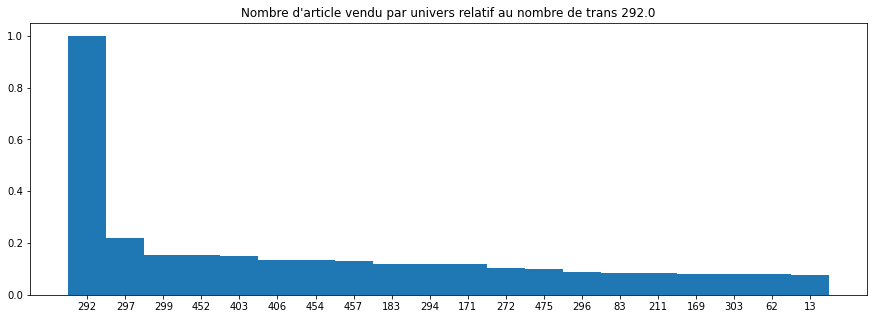

==============293.0===================
Proportion d'achat de univs 293.0 :  0.19 %
Nombre moyen d'achat en plus du univs 293.0 :  11.41
Proportion d'achat de univs 293.0 seul: 0.72 %
CA sans 293.0 :  138086.42
CA moyen sans 293.0 :  42.99
CA de 293.0 :  14876.23
CA moyen de 293.0 :  4.63


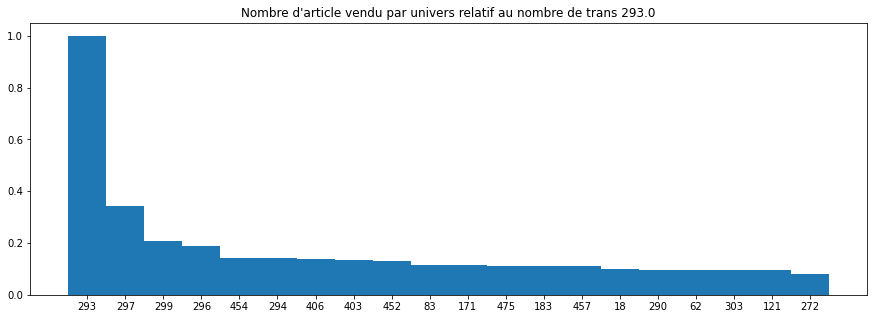

==============294.0===================
Proportion d'achat de univs 294.0 :  10.29 %
Nombre moyen d'achat en plus du univs 294.0 :  6.12
Proportion d'achat de univs 294.0 seul: 4.87 %
CA sans 294.0 :  4075893.45
CA moyen sans 294.0 :  23.21
CA de 294.0 :  374666.36
CA moyen de 294.0 :  2.13


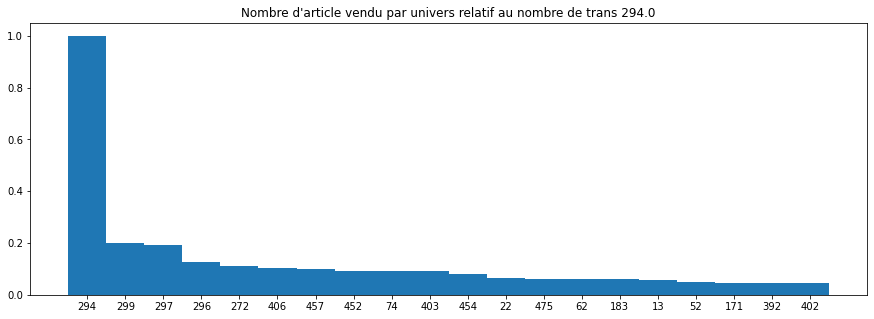

==============296.0===================
Proportion d'achat de univs 296.0 :  7.54 %
Nombre moyen d'achat en plus du univs 296.0 :  6.16
Proportion d'achat de univs 296.0 seul: 3.53 %
CA sans 296.0 :  2833022.6
CA moyen sans 296.0 :  22.01
CA de 296.0 :  359772.43
CA moyen de 296.0 :  2.8


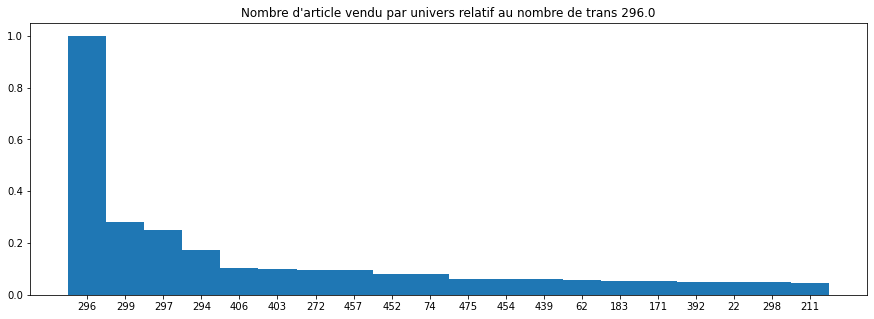

==============297.0===================
Proportion d'achat de univs 297.0 :  13.55 %
Nombre moyen d'achat en plus du univs 297.0 :  6.35
Proportion d'achat de univs 297.0 seul: 6.4 %
CA sans 297.0 :  5546302.98
CA moyen sans 297.0 :  23.99
CA de 297.0 :  715501.43
CA moyen de 297.0 :  3.1


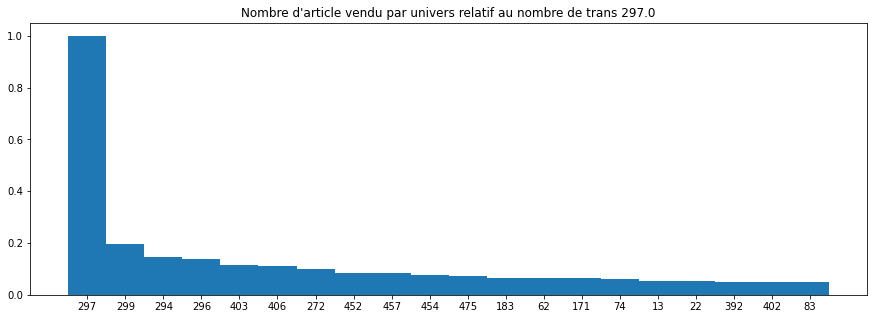

==============298.0===================
Proportion d'achat de univs 298.0 :  1.31 %
Nombre moyen d'achat en plus du univs 298.0 :  6.71
Proportion d'achat de univs 298.0 seul: 2.03 %
CA sans 298.0 :  522551.06
CA moyen sans 298.0 :  23.41
CA de 298.0 :  43061.66
CA moyen de 298.0 :  1.93


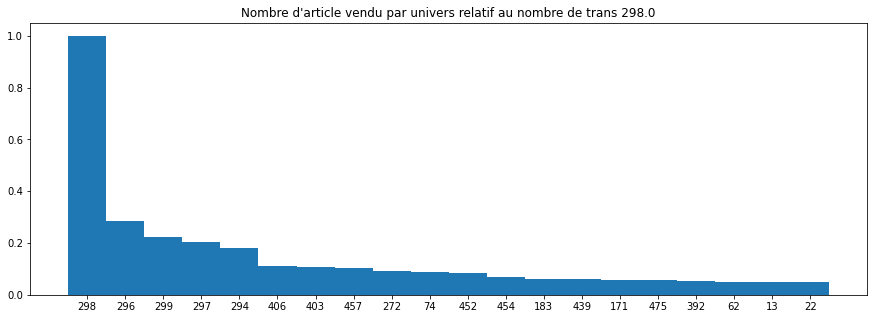

==============299.0===================
Proportion d'achat de univs 299.0 :  16.74 %
Nombre moyen d'achat en plus du univs 299.0 :  4.99
Proportion d'achat de univs 299.0 seul: 4.83 %
CA sans 299.0 :  5251717.91
CA moyen sans 299.0 :  18.38
CA de 299.0 :  852179.08
CA moyen de 299.0 :  2.98


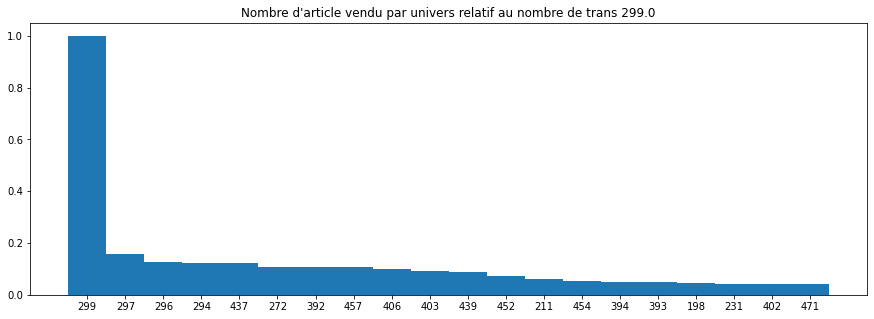

==============300.0===================
Proportion d'achat de univs 300.0 :  2.14 %
Nombre moyen d'achat en plus du univs 300.0 :  9.06
Proportion d'achat de univs 300.0 seul: 1.85 %
CA sans 300.0 :  1318177.78
CA moyen sans 300.0 :  36.11
CA de 300.0 :  134847.35
CA moyen de 300.0 :  3.69


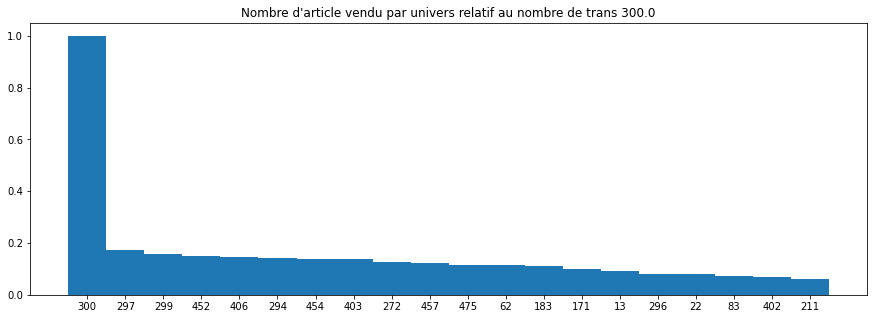

==============301.0===================
Proportion d'achat de univs 301.0 :  0.77 %
Nombre moyen d'achat en plus du univs 301.0 :  7.6
Proportion d'achat de univs 301.0 seul: 1.09 %
CA sans 301.0 :  333368.98
CA moyen sans 301.0 :  25.48
CA de 301.0 :  31805.46
CA moyen de 301.0 :  2.43


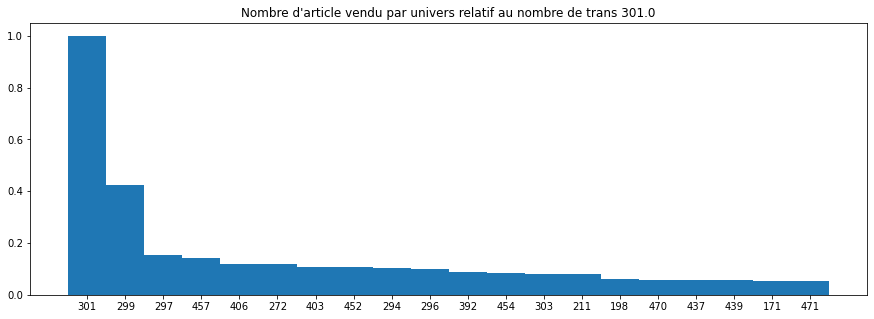

==============302.0===================
Proportion d'achat de univs 302.0 :  0.47 %
Nombre moyen d'achat en plus du univs 302.0 :  9.58
Proportion d'achat de univs 302.0 seul: 2.04 %
CA sans 302.0 :  289294.32
CA moyen sans 302.0 :  36.38
CA de 302.0 :  23059.05
CA moyen de 302.0 :  2.9


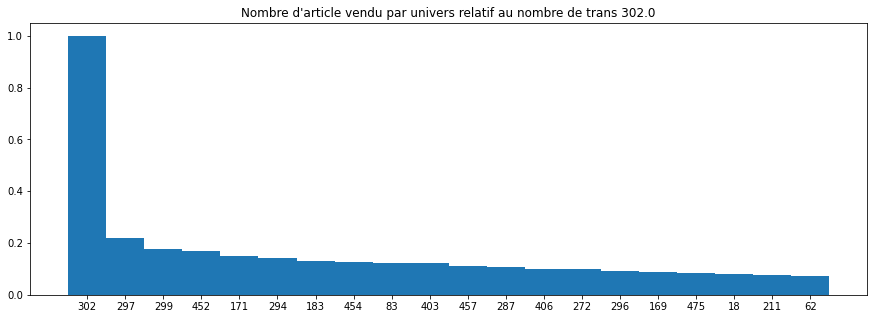

==============303.0===================
Proportion d'achat de univs 303.0 :  2.12 %
Nombre moyen d'achat en plus du univs 303.0 :  9.43
Proportion d'achat de univs 303.0 seul: 1.77 %
CA sans 303.0 :  1318949.16
CA moyen sans 303.0 :  36.49
CA de 303.0 :  102706.36
CA moyen de 303.0 :  2.84


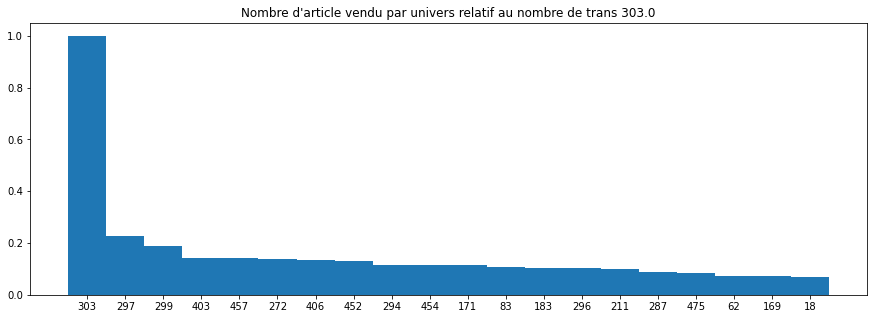

==============304.0===================
Proportion d'achat de univs 304.0 :  0.02 %
Nombre moyen d'achat en plus du univs 304.0 :  14.3
Proportion d'achat de univs 304.0 seul: 0.0 %
CA sans 304.0 :  13336.5
CA moyen sans 304.0 :  45.67
CA de 304.0 :  1083.71
CA moyen de 304.0 :  3.71


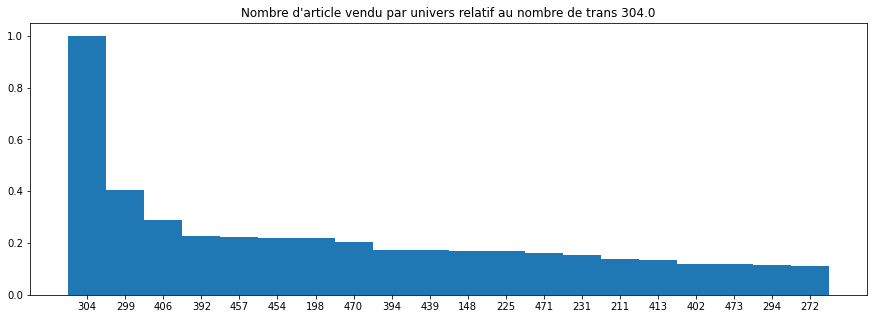

==============305.0===================
Proportion d'achat de univs 305.0 :  0.43 %
Nombre moyen d'achat en plus du univs 305.0 :  6.87
Proportion d'achat de univs 305.0 seul: 4.79 %
CA sans 305.0 :  223678.55
CA moyen sans 305.0 :  30.73
CA de 305.0 :  156297.09
CA moyen de 305.0 :  21.47


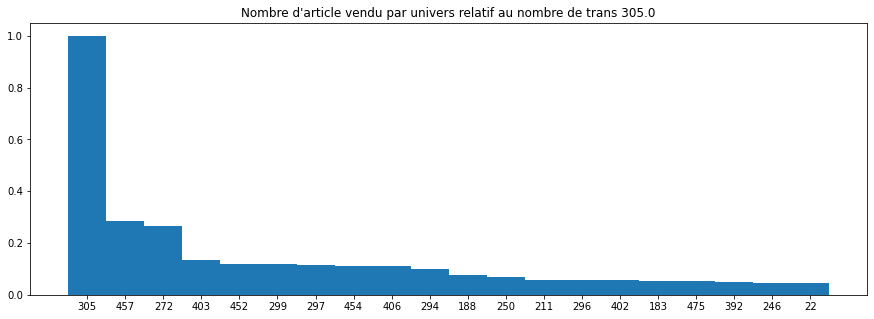

==============306.0===================
Proportion d'achat de univs 306.0 :  0.24 %
Nombre moyen d'achat en plus du univs 306.0 :  6.81
Proportion d'achat de univs 306.0 seul: 3.85 %
CA sans 306.0 :  130939.76
CA moyen sans 306.0 :  31.92
CA de 306.0 :  72040.29
CA moyen de 306.0 :  17.56


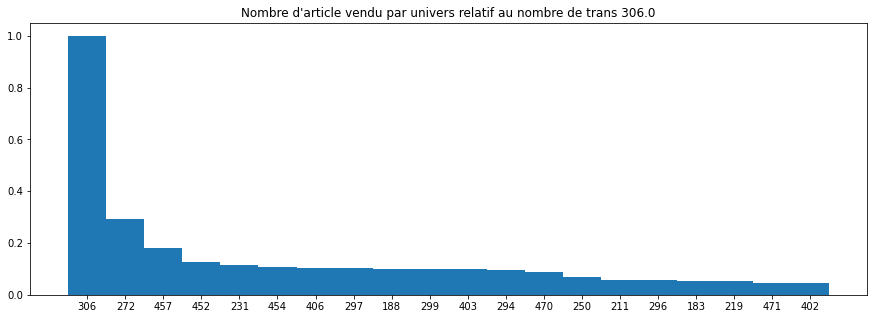

==============307.0===================
Proportion d'achat de univs 307.0 :  0.21 %
Nombre moyen d'achat en plus du univs 307.0 :  6.26
Proportion d'achat de univs 307.0 seul: 5.49 %
CA sans 307.0 :  102342.77
CA moyen sans 307.0 :  27.97
CA de 307.0 :  76233.15
CA moyen de 307.0 :  20.83


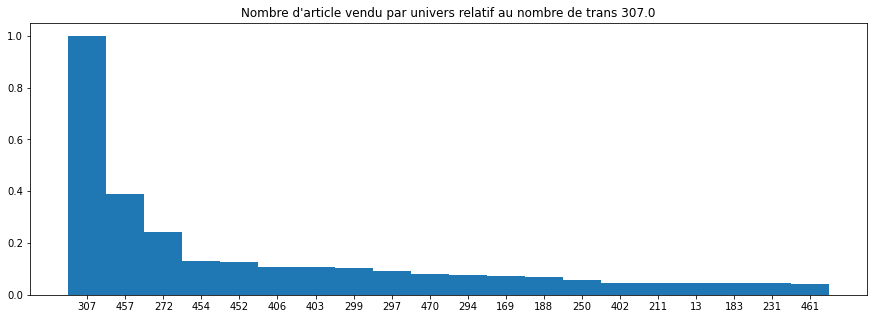

==============308.0===================
Proportion d'achat de univs 308.0 :  0.16 %
Nombre moyen d'achat en plus du univs 308.0 :  8.51
Proportion d'achat de univs 308.0 seul: 5.82 %
CA sans 308.0 :  117848.93
CA moyen sans 308.0 :  43.15
CA de 308.0 :  85943.21
CA moyen de 308.0 :  31.47


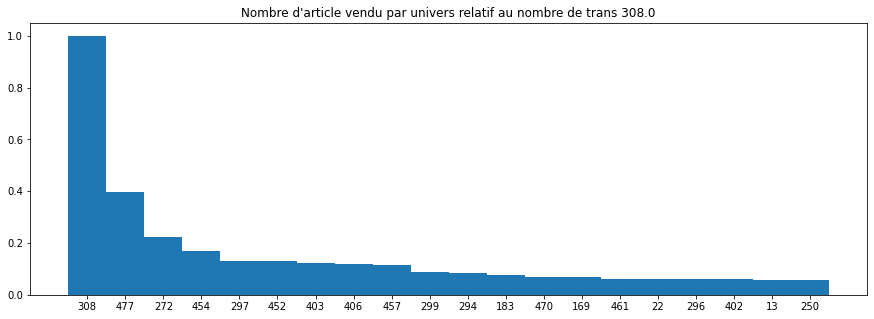

==============309.0===================
Proportion d'achat de univs 309.0 :  0.02 %
Nombre moyen d'achat en plus du univs 309.0 :  6.43
Proportion d'achat de univs 309.0 seul: 2.31 %
CA sans 309.0 :  7279.14
CA moyen sans 309.0 :  24.02
CA de 309.0 :  6013.92
CA moyen de 309.0 :  19.85


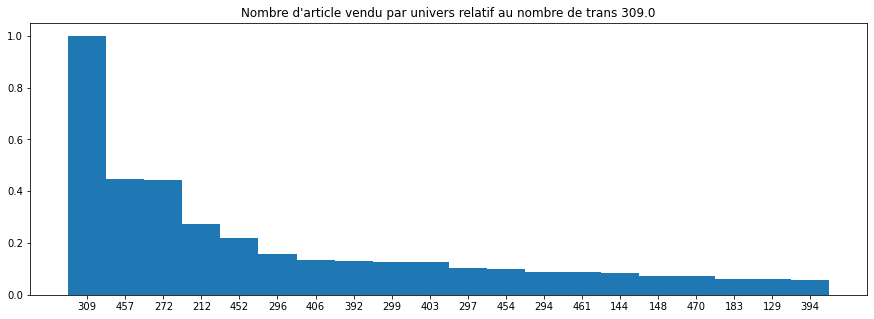

==============310.0===================
Proportion d'achat de univs 310.0 :  0.12 %
Nombre moyen d'achat en plus du univs 310.0 :  8.85
Proportion d'achat de univs 310.0 seul: 3.65 %
CA sans 310.0 :  91608.52
CA moyen sans 310.0 :  43.42
CA de 310.0 :  30512.83
CA moyen de 310.0 :  14.46


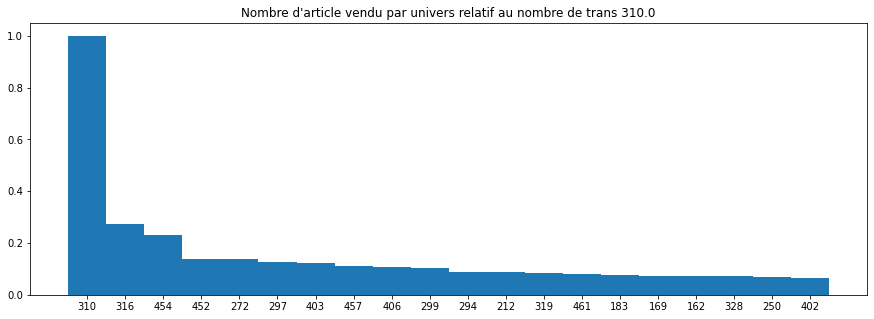

==============311.0===================
Proportion d'achat de univs 311.0 :  0.61 %
Nombre moyen d'achat en plus du univs 311.0 :  5.22
Proportion d'achat de univs 311.0 seul: 5.48 %
CA sans 311.0 :  245174.03
CA moyen sans 311.0 :  23.7
CA de 311.0 :  60912.12
CA moyen de 311.0 :  5.89


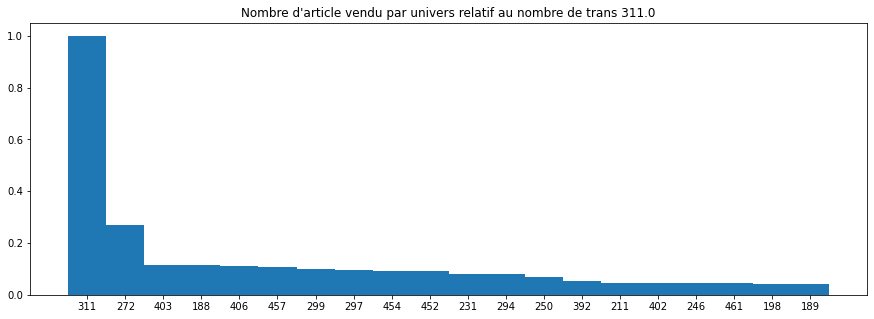

==============312.0===================
Proportion d'achat de univs 312.0 :  0.49 %
Nombre moyen d'achat en plus du univs 312.0 :  7.62
Proportion d'achat de univs 312.0 seul: 4.8 %
CA sans 312.0 :  296478.29
CA moyen sans 312.0 :  35.68
CA de 312.0 :  135882.11
CA moyen de 312.0 :  16.35


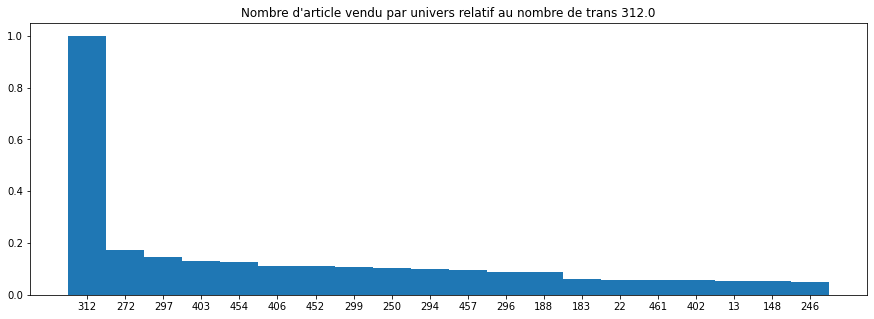

==============313.0===================
Proportion d'achat de univs 313.0 :  0.42 %
Nombre moyen d'achat en plus du univs 313.0 :  6.78
Proportion d'achat de univs 313.0 seul: 11.67 %
CA sans 313.0 :  232413.99
CA moyen sans 313.0 :  32.76
CA de 313.0 :  301049.9
CA moyen de 313.0 :  42.43


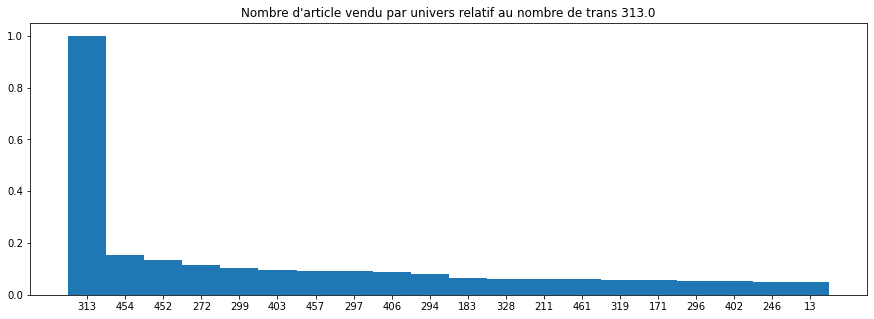

==============314.0===================
Proportion d'achat de univs 314.0 :  0.01 %
Nombre moyen d'achat en plus du univs 314.0 :  6.71
Proportion d'achat de univs 314.0 seul: 11.52 %
CA sans 314.0 :  6610.88
CA moyen sans 314.0 :  34.61
CA de 314.0 :  7662.71
CA moyen de 314.0 :  40.12


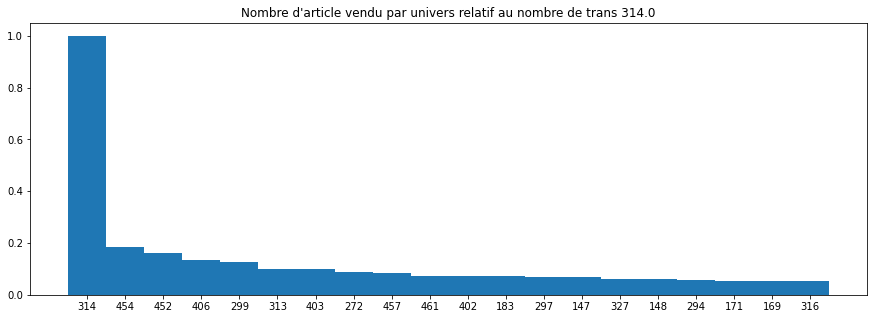

==============315.0===================
Proportion d'achat de univs 315.0 :  0.05 %
Nombre moyen d'achat en plus du univs 315.0 :  6.79
Proportion d'achat de univs 315.0 seul: 11.76 %
CA sans 315.0 :  37690.91
CA moyen sans 315.0 :  41.42
CA de 315.0 :  50343.6
CA moyen de 315.0 :  55.32


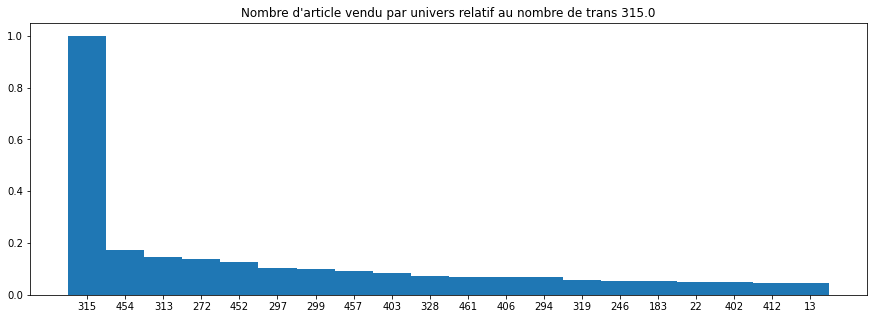

==============316.0===================
Proportion d'achat de univs 316.0 :  0.97 %
Nombre moyen d'achat en plus du univs 316.0 :  6.27
Proportion d'achat de univs 316.0 seul: 7.71 %
CA sans 316.0 :  451702.89
CA moyen sans 316.0 :  27.41
CA de 316.0 :  221493.74
CA moyen de 316.0 :  13.44


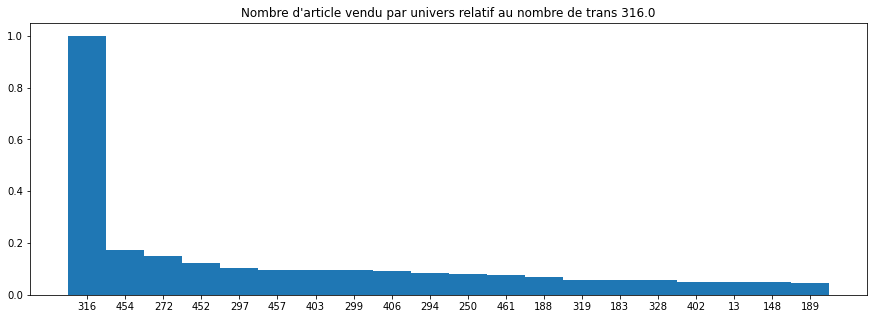

==============317.0===================
Proportion d'achat de univs 317.0 :  0.29 %
Nombre moyen d'achat en plus du univs 317.0 :  6.83
Proportion d'achat de univs 317.0 seul: 4.32 %
CA sans 317.0 :  140020.21
CA moyen sans 317.0 :  27.99
CA de 317.0 :  21921.2
CA moyen de 317.0 :  4.38


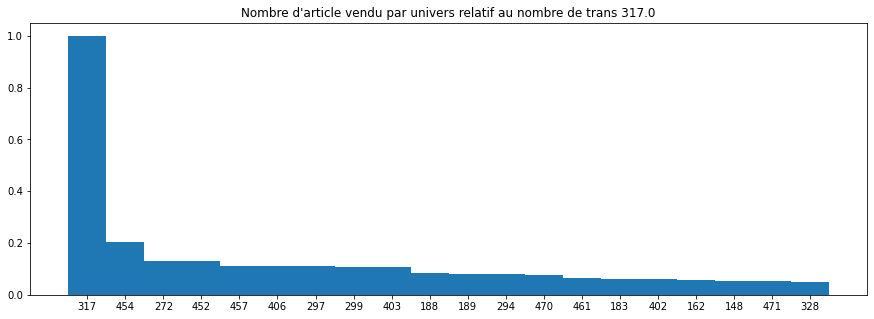

==============318.0===================
Proportion d'achat de univs 318.0 :  0.06 %
Nombre moyen d'achat en plus du univs 318.0 :  6.26
Proportion d'achat de univs 318.0 seul: 9.19 %
CA sans 318.0 :  31343.81
CA moyen sans 318.0 :  28.52
CA de 318.0 :  17880.31
CA moyen de 318.0 :  16.27


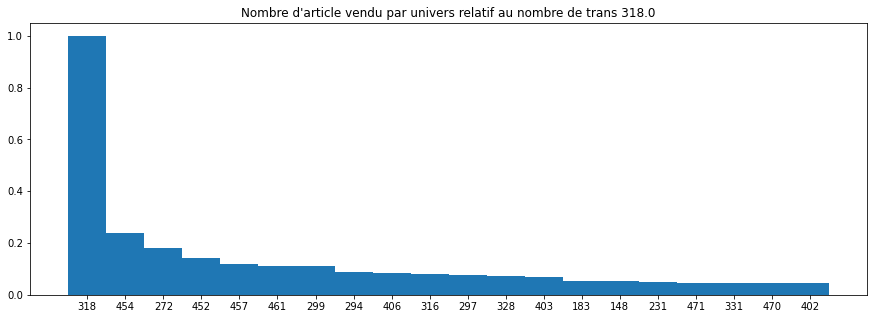

==============319.0===================
Proportion d'achat de univs 319.0 :  1.93 %
Nombre moyen d'achat en plus du univs 319.0 :  9.27
Proportion d'achat de univs 319.0 seul: 0.69 %
CA sans 319.0 :  1256347.88
CA moyen sans 319.0 :  38.12
CA de 319.0 :  132452.47
CA moyen de 319.0 :  4.02


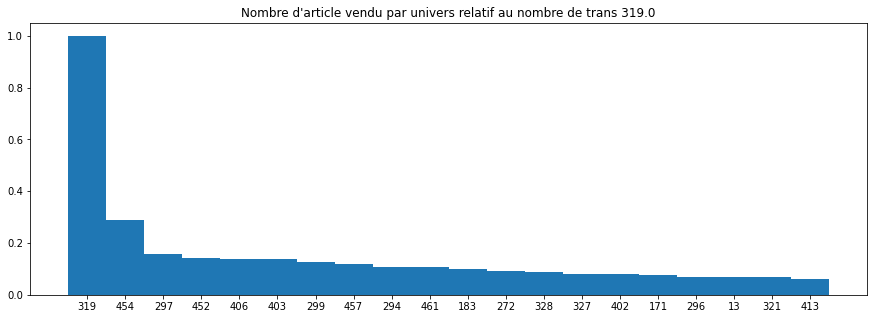

==============320.0===================
Proportion d'achat de univs 320.0 :  0.14 %
Nombre moyen d'achat en plus du univs 320.0 :  10.07
Proportion d'achat de univs 320.0 seul: 0.17 %
CA sans 320.0 :  100312.84
CA moyen sans 320.0 :  41.8
CA de 320.0 :  7756.0
CA moyen de 320.0 :  3.23


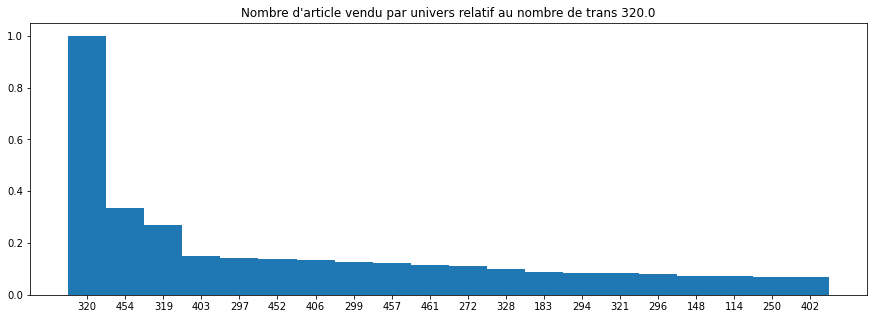

==============321.0===================
Proportion d'achat de univs 321.0 :  1.13 %
Nombre moyen d'achat en plus du univs 321.0 :  8.81
Proportion d'achat de univs 321.0 seul: 0.66 %
CA sans 321.0 :  701207.43
CA moyen sans 321.0 :  36.5
CA de 321.0 :  71692.15
CA moyen de 321.0 :  3.73


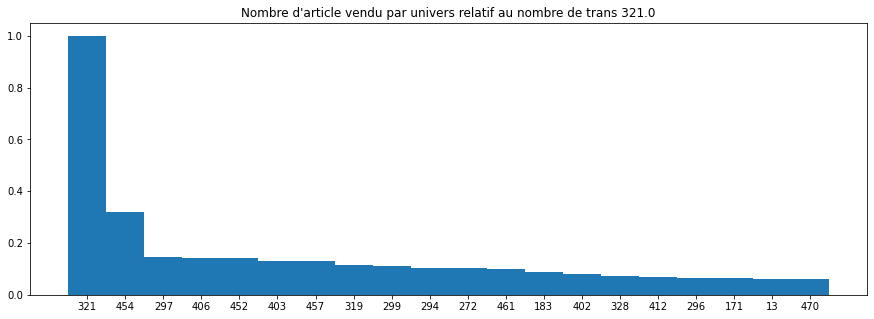

==============322.0===================
Proportion d'achat de univs 322.0 :  0.07 %
Nombre moyen d'achat en plus du univs 322.0 :  8.15
Proportion d'achat de univs 322.0 seul: 0.62 %
CA sans 322.0 :  36238.3
CA moyen sans 322.0 :  32.15
CA de 322.0 :  2992.85
CA moyen de 322.0 :  2.66


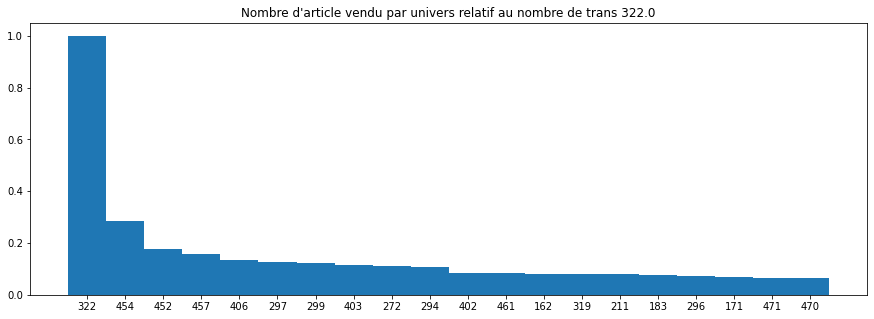

==============323.0===================
Proportion d'achat de univs 323.0 :  0.35 %
Nombre moyen d'achat en plus du univs 323.0 :  9.8
Proportion d'achat de univs 323.0 seul: 0.92 %
CA sans 323.0 :  247405.04
CA moyen sans 323.0 :  41.43
CA de 323.0 :  13905.49
CA moyen de 323.0 :  2.33


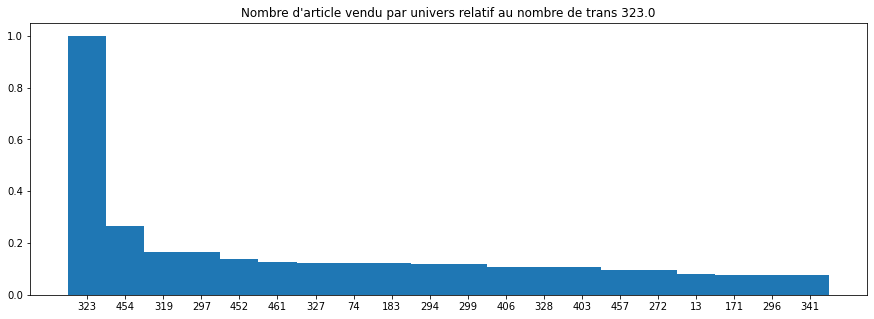

==============324.0===================
Proportion d'achat de univs 324.0 :  0.53 %
Nombre moyen d'achat en plus du univs 324.0 :  7.88
Proportion d'achat de univs 324.0 seul: 0.91 %
CA sans 324.0 :  281457.98
CA moyen sans 324.0 :  30.96
CA de 324.0 :  28313.71
CA moyen de 324.0 :  3.11


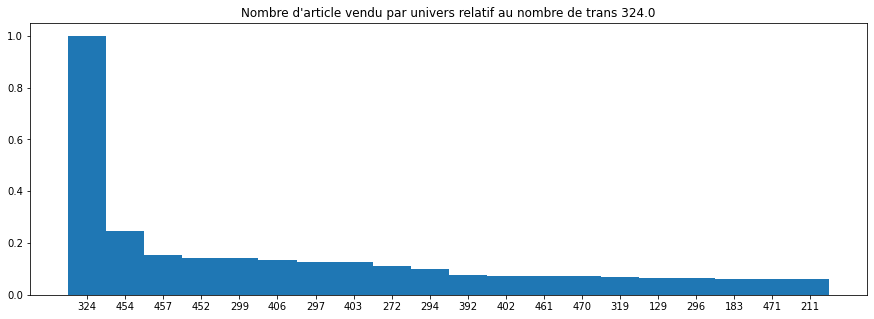

==============326.0===================
Proportion d'achat de univs 326.0 :  0.07 %
Nombre moyen d'achat en plus du univs 326.0 :  9.54
Proportion d'achat de univs 326.0 seul: 1.92 %
CA sans 326.0 :  51958.01
CA moyen sans 326.0 :  45.3
CA de 326.0 :  4977.68
CA moyen de 326.0 :  4.34


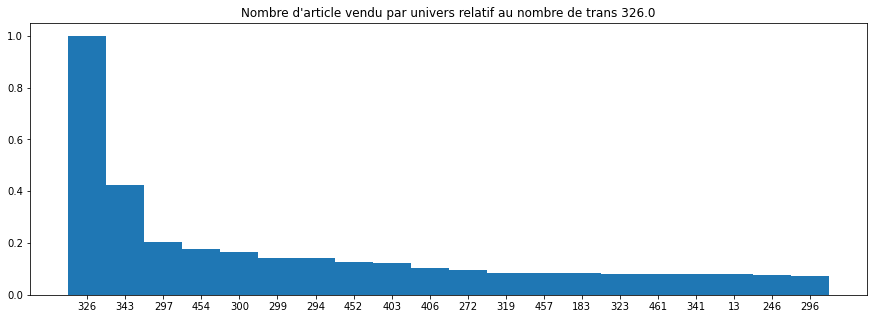

==============327.0===================
Proportion d'achat de univs 327.0 :  0.81 %
Nombre moyen d'achat en plus du univs 327.0 :  9.95
Proportion d'achat de univs 327.0 seul: 0.47 %
CA sans 327.0 :  552457.33
CA moyen sans 327.0 :  39.86
CA de 327.0 :  59482.57
CA moyen de 327.0 :  4.29


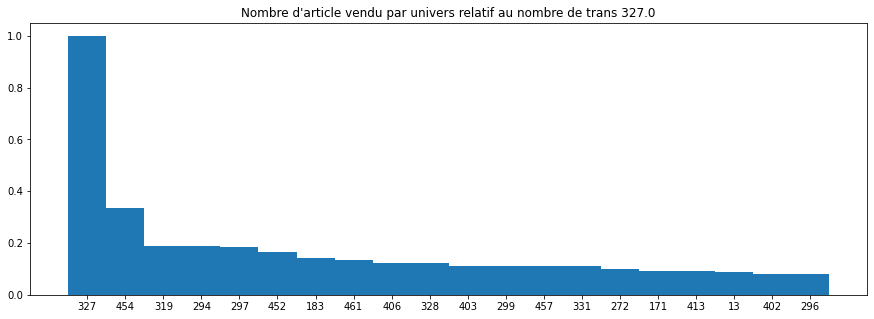

==============328.0===================
Proportion d'achat de univs 328.0 :  1.55 %
Nombre moyen d'achat en plus du univs 328.0 :  10.3
Proportion d'achat de univs 328.0 seul: 0.26 %
CA sans 328.0 :  1119256.82
CA moyen sans 328.0 :  42.38
CA de 328.0 :  107341.95
CA moyen de 328.0 :  4.06


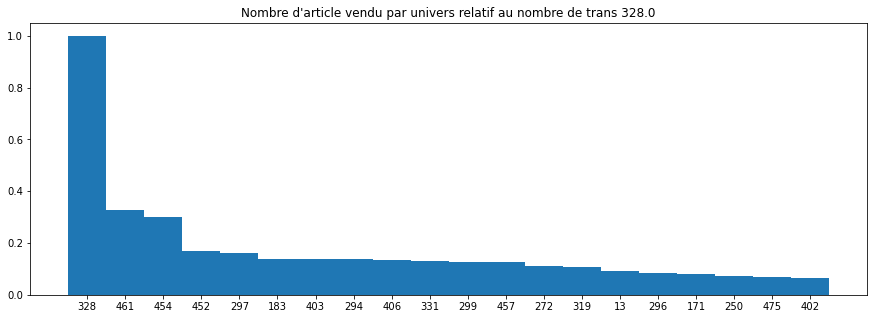

==============329.0===================
Proportion d'achat de univs 329.0 :  0.1 %
Nombre moyen d'achat en plus du univs 329.0 :  11.39
Proportion d'achat de univs 329.0 seul: 0.24 %
CA sans 329.0 :  79333.46
CA moyen sans 329.0 :  47.45
CA de 329.0 :  6715.73
CA moyen de 329.0 :  4.02


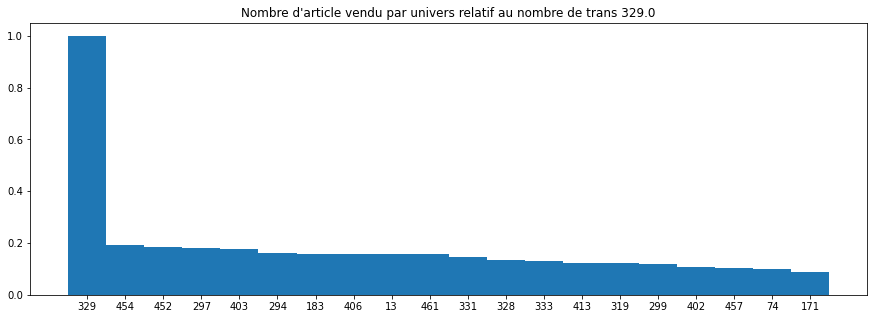

==============330.0===================
Proportion d'achat de univs 330.0 :  0.01 %
Nombre moyen d'achat en plus du univs 330.0 :  8.92
Proportion d'achat de univs 330.0 seul: 0.61 %
CA sans 330.0 :  7584.82
CA moyen sans 330.0 :  45.97
CA de 330.0 :  990.44
CA moyen de 330.0 :  6.0


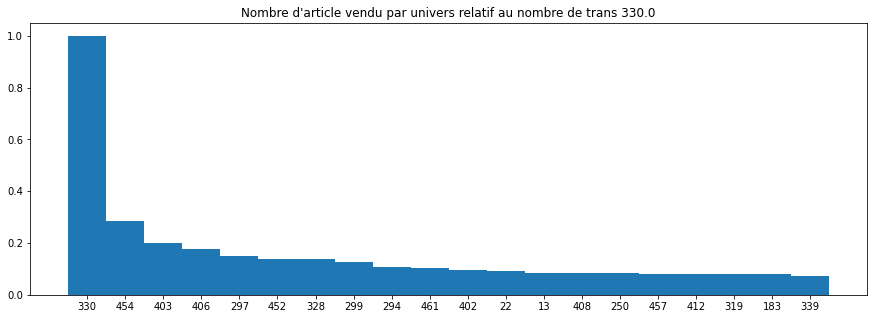

==============331.0===================
Proportion d'achat de univs 331.0 :  0.96 %
Nombre moyen d'achat en plus du univs 331.0 :  10.49
Proportion d'achat de univs 331.0 seul: 0.38 %
CA sans 331.0 :  692620.98
CA moyen sans 331.0 :  42.26
CA de 331.0 :  50792.81
CA moyen de 331.0 :  3.1


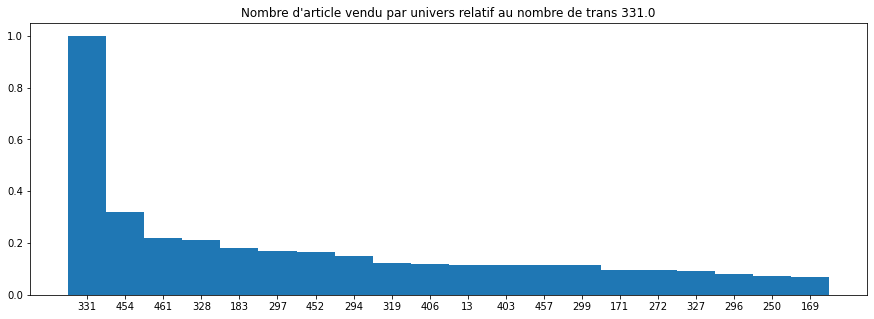

==============332.0===================
Proportion d'achat de univs 332.0 :  0.02 %
Nombre moyen d'achat en plus du univs 332.0 :  9.79
Proportion d'achat de univs 332.0 seul: 0.81 %
CA sans 332.0 :  19141.64
CA moyen sans 332.0 :  51.73
CA de 332.0 :  3256.14
CA moyen de 332.0 :  8.8


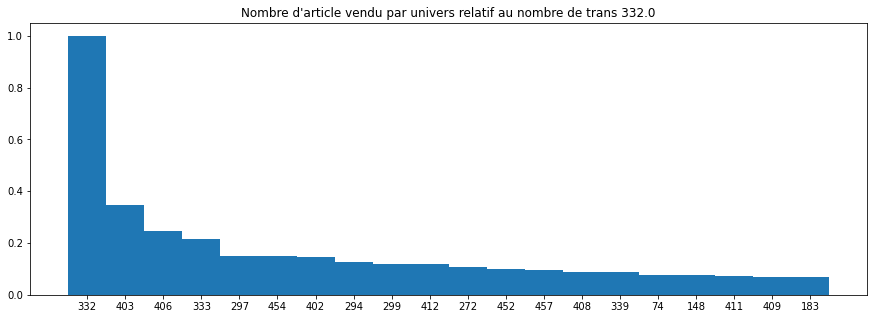

==============333.0===================
Proportion d'achat de univs 333.0 :  0.58 %
Nombre moyen d'achat en plus du univs 333.0 :  9.9
Proportion d'achat de univs 333.0 seul: 0.53 %
CA sans 333.0 :  421610.62
CA moyen sans 333.0 :  42.71
CA de 333.0 :  56426.45
CA moyen de 333.0 :  5.72


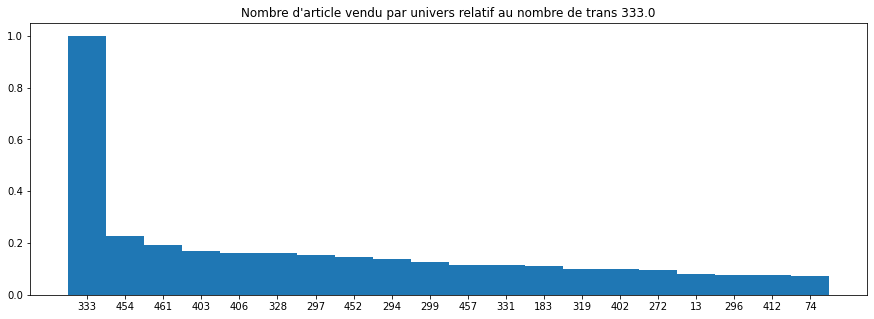

==============334.0===================
Proportion d'achat de univs 334.0 :  0.28 %
Nombre moyen d'achat en plus du univs 334.0 :  8.67
Proportion d'achat de univs 334.0 seul: 2.04 %
CA sans 334.0 :  168084.7
CA moyen sans 334.0 :  35.4
CA de 334.0 :  29750.41
CA moyen de 334.0 :  6.27


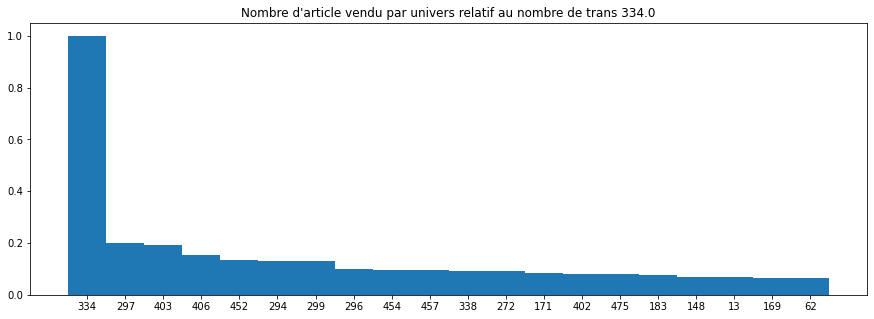

==============335.0===================
Proportion d'achat de univs 335.0 :  0.1 %
Nombre moyen d'achat en plus du univs 335.0 :  8.51
Proportion d'achat de univs 335.0 seul: 0.92 %
CA sans 335.0 :  53320.53
CA moyen sans 335.0 :  32.87
CA de 335.0 :  5514.7
CA moyen de 335.0 :  3.4


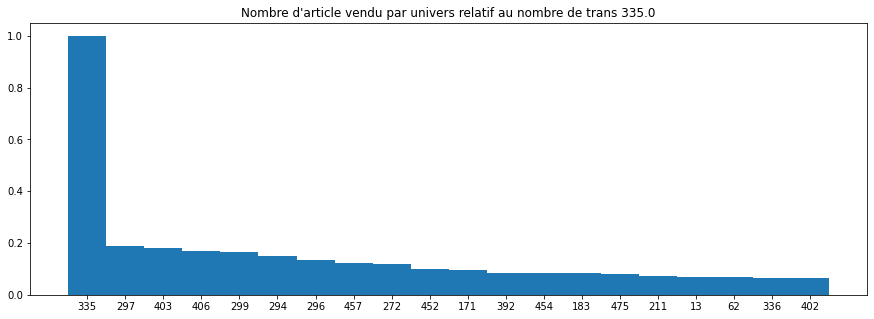

==============336.0===================
Proportion d'achat de univs 336.0 :  0.31 %
Nombre moyen d'achat en plus du univs 336.0 :  8.22
Proportion d'achat de univs 336.0 seul: 1.84 %
CA sans 336.0 :  169572.4
CA moyen sans 336.0 :  31.84
CA de 336.0 :  24363.02
CA moyen de 336.0 :  4.57


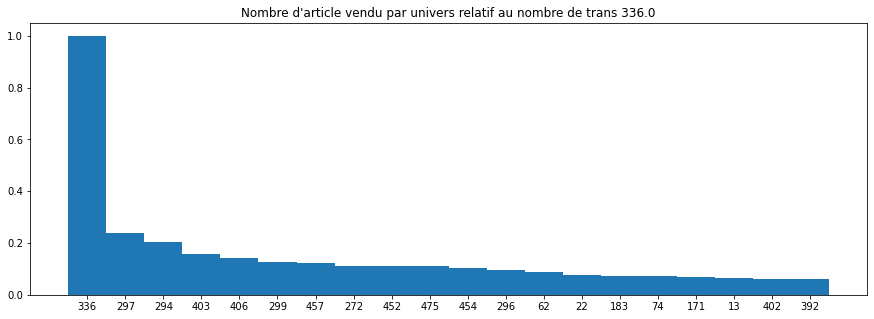

==============337.0===================
Proportion d'achat de univs 337.0 :  0.05 %
Nombre moyen d'achat en plus du univs 337.0 :  9.8
Proportion d'achat de univs 337.0 seul: 0.51 %
CA sans 337.0 :  29350.17
CA moyen sans 337.0 :  37.48
CA de 337.0 :  2277.37
CA moyen de 337.0 :  2.91


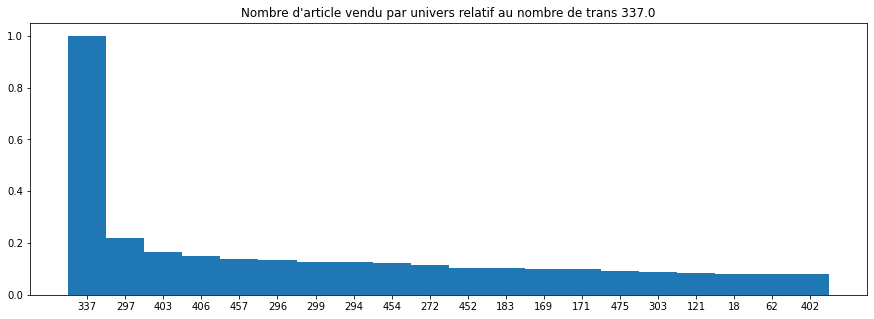

==============338.0===================
Proportion d'achat de univs 338.0 :  0.21 %
Nombre moyen d'achat en plus du univs 338.0 :  10.52
Proportion d'achat de univs 338.0 seul: 0.45 %
CA sans 338.0 :  147232.31
CA moyen sans 338.0 :  41.78
CA de 338.0 :  9708.47
CA moyen de 338.0 :  2.75


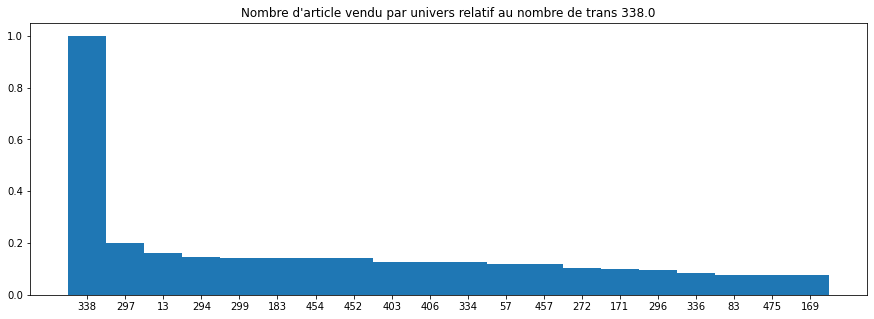

==============339.0===================
Proportion d'achat de univs 339.0 :  0.83 %
Nombre moyen d'achat en plus du univs 339.0 :  10.85
Proportion d'achat de univs 339.0 seul: 0.84 %
CA sans 339.0 :  633431.33
CA moyen sans 339.0 :  44.68
CA de 339.0 :  108408.56
CA moyen de 339.0 :  7.65


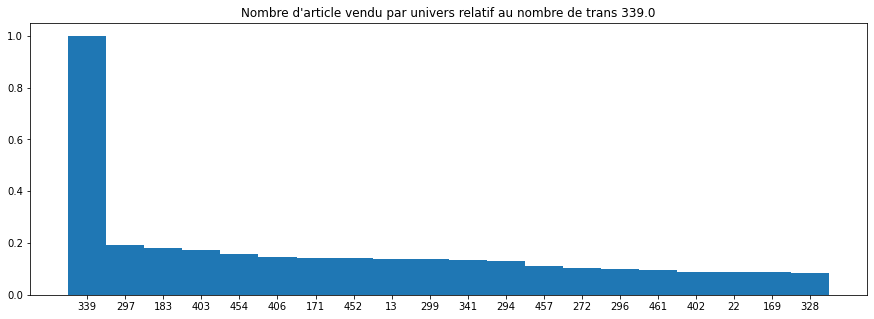

==============341.0===================
Proportion d'achat de univs 341.0 :  1.17 %
Nombre moyen d'achat en plus du univs 341.0 :  10.91
Proportion d'achat de univs 341.0 seul: 1.0 %
CA sans 341.0 :  882693.08
CA moyen sans 341.0 :  44.35
CA de 341.0 :  168557.37
CA moyen de 341.0 :  8.47


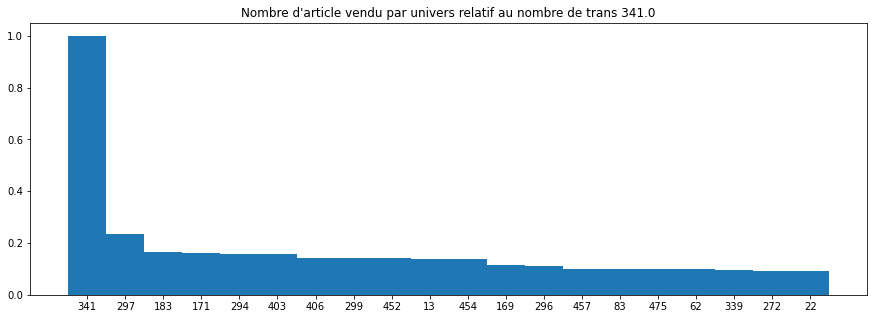

==============342.0===================
Proportion d'achat de univs 342.0 :  0.13 %
Nombre moyen d'achat en plus du univs 342.0 :  10.48
Proportion d'achat de univs 342.0 seul: 1.53 %
CA sans 342.0 :  108849.32
CA moyen sans 342.0 :  47.57
CA de 342.0 :  25268.06
CA moyen de 342.0 :  11.04


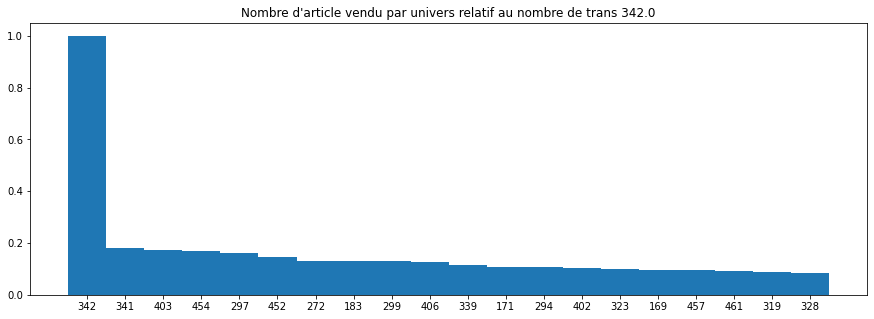

==============343.0===================
Proportion d'achat de univs 343.0 :  0.27 %
Nombre moyen d'achat en plus du univs 343.0 :  10.23
Proportion d'achat de univs 343.0 seul: 1.39 %
CA sans 343.0 :  214813.6
CA moyen sans 343.0 :  46.59
CA de 343.0 :  43112.3
CA moyen de 343.0 :  9.35


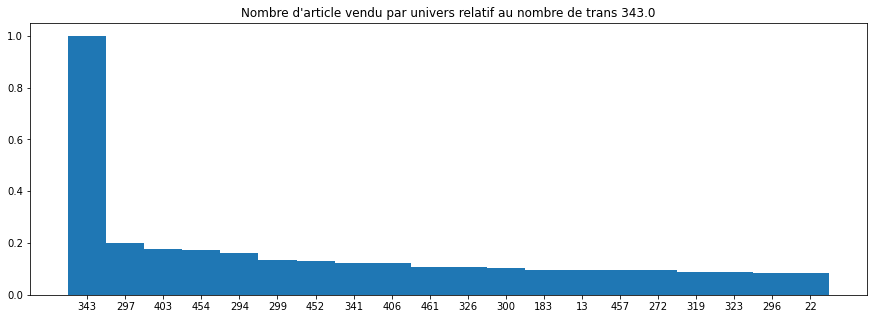

==============344.0===================
Proportion d'achat de univs 344.0 :  0.29 %
Nombre moyen d'achat en plus du univs 344.0 :  7.09
Proportion d'achat de univs 344.0 seul: 9.21 %
CA sans 344.0 :  141152.52
CA moyen sans 344.0 :  29.01
CA de 344.0 :  47513.9
CA moyen de 344.0 :  9.76


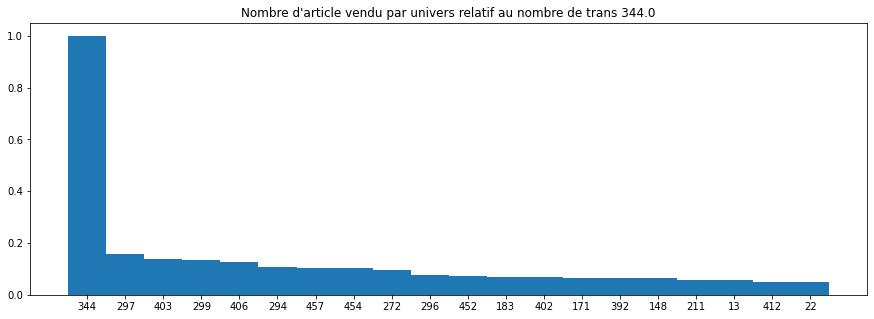

==============347.0===================
Proportion d'achat de univs 347.0 :  0.03 %
Nombre moyen d'achat en plus du univs 347.0 :  9.12
Proportion d'achat de univs 347.0 seul: 0.22 %
CA sans 347.0 :  15579.53
CA moyen sans 347.0 :  34.7
CA de 347.0 :  1914.12
CA moyen de 347.0 :  4.26


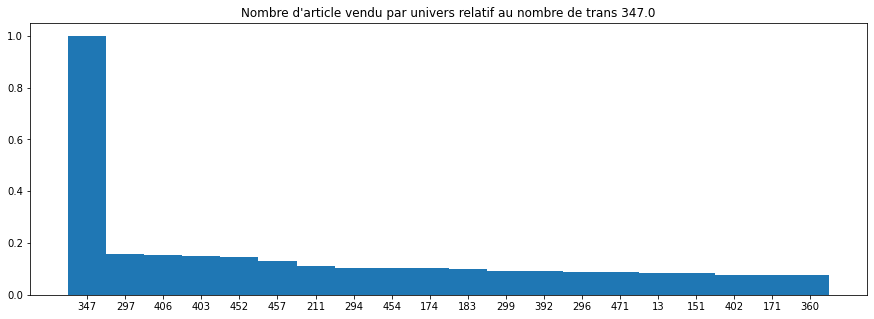

==============348.0===================
Proportion d'achat de univs 348.0 :  0.03 %
Nombre moyen d'achat en plus du univs 348.0 :  5.52
Proportion d'achat de univs 348.0 seul: 1.84 %
CA sans 348.0 :  9057.22
CA moyen sans 348.0 :  20.82
CA de 348.0 :  2013.03
CA moyen de 348.0 :  4.63


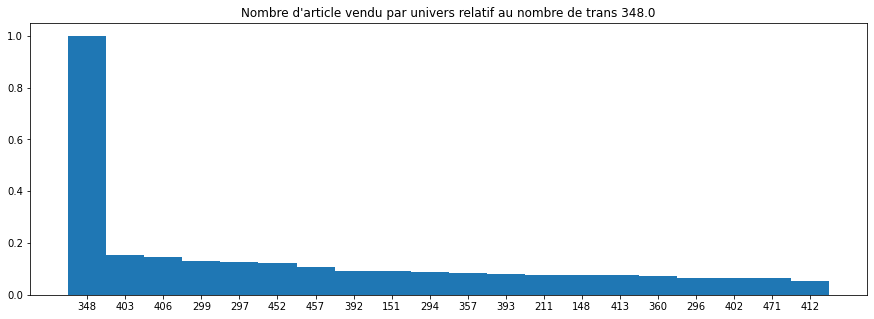

==============350.0===================
Proportion d'achat de univs 350.0 :  0.04 %
Nombre moyen d'achat en plus du univs 350.0 :  5.91
Proportion d'achat de univs 350.0 seul: 4.33 %
CA sans 350.0 :  16044.88
CA moyen sans 350.0 :  23.98
CA de 350.0 :  3802.7
CA moyen de 350.0 :  5.68


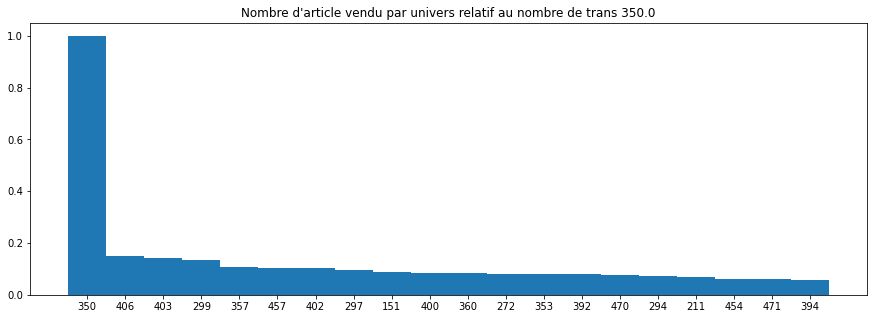

==============351.0===================
Proportion d'achat de univs 351.0 :  0.05 %
Nombre moyen d'achat en plus du univs 351.0 :  5.9
Proportion d'achat de univs 351.0 seul: 4.96 %
CA sans 351.0 :  20553.39
CA moyen sans 351.0 :  23.71
CA de 351.0 :  3992.12
CA moyen de 351.0 :  4.6


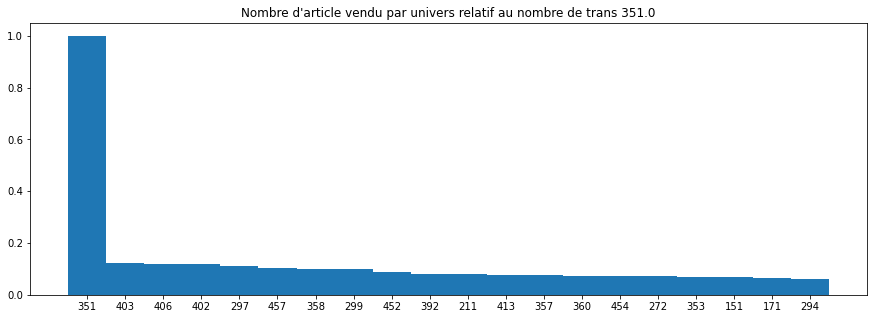

==============353.0===================
Proportion d'achat de univs 353.0 :  0.24 %
Nombre moyen d'achat en plus du univs 353.0 :  6.82
Proportion d'achat de univs 353.0 seul: 2.56 %
CA sans 353.0 :  113939.51
CA moyen sans 353.0 :  27.78
CA de 353.0 :  20256.12
CA moyen de 353.0 :  4.94


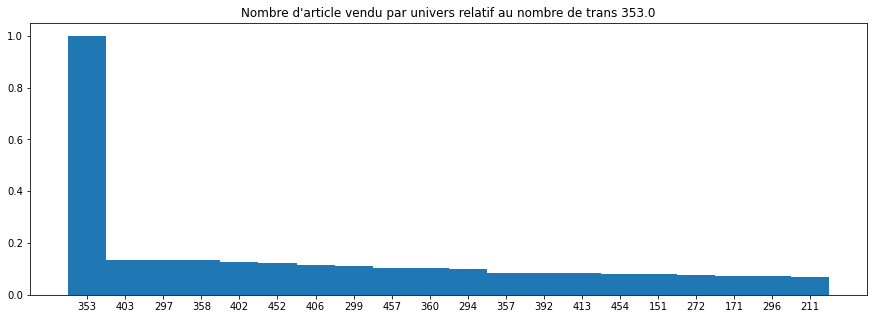

==============354.0===================
NO DATA 
==============355.0===================
Proportion d'achat de univs 355.0 :  0.33 %
Nombre moyen d'achat en plus du univs 355.0 :  5.76
Proportion d'achat de univs 355.0 seul: 6.16 %
CA sans 355.0 :  132797.67
CA moyen sans 355.0 :  23.3
CA de 355.0 :  29055.66
CA moyen de 355.0 :  5.1


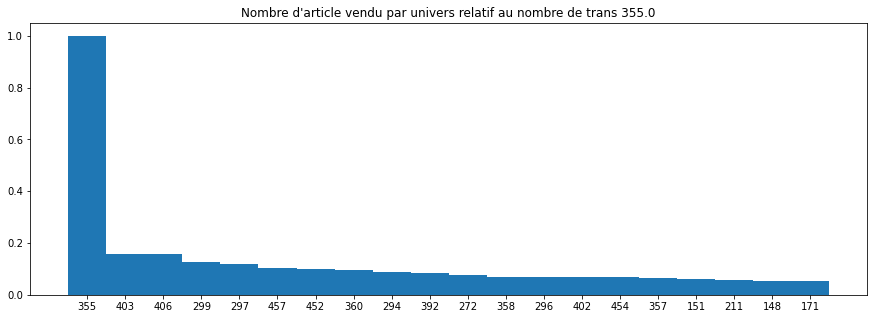

==============356.0===================
Proportion d'achat de univs 356.0 :  0.02 %
Nombre moyen d'achat en plus du univs 356.0 :  4.61
Proportion d'achat de univs 356.0 seul: 10.45 %
CA sans 356.0 :  5509.31
CA moyen sans 356.0 :  19.2
CA de 356.0 :  2315.13
CA moyen de 356.0 :  8.07


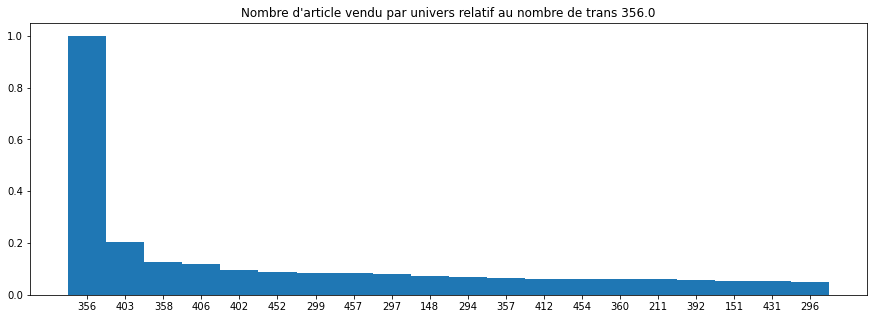

==============357.0===================
Proportion d'achat de univs 357.0 :  2.3 %
Nombre moyen d'achat en plus du univs 357.0 :  4.9
Proportion d'achat de univs 357.0 seul: 9.06 %
CA sans 357.0 :  729230.35
CA moyen sans 357.0 :  18.54
CA de 357.0 :  237410.33
CA moyen de 357.0 :  6.04


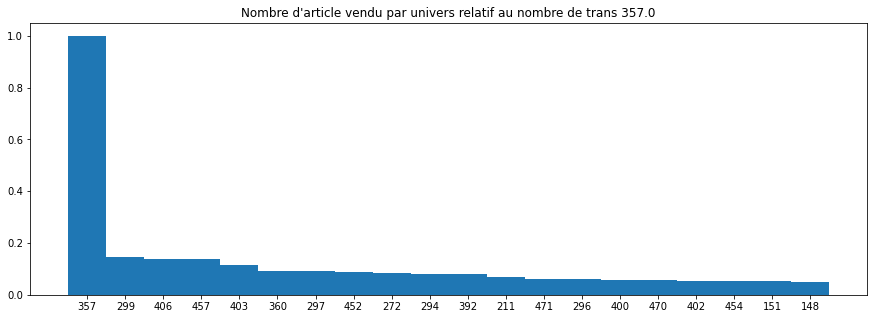

==============358.0===================
Proportion d'achat de univs 358.0 :  0.83 %
Nombre moyen d'achat en plus du univs 358.0 :  5.59
Proportion d'achat de univs 358.0 seul: 7.26 %
CA sans 358.0 :  311454.69
CA moyen sans 358.0 :  21.97
CA de 358.0 :  99523.22
CA moyen de 358.0 :  7.02


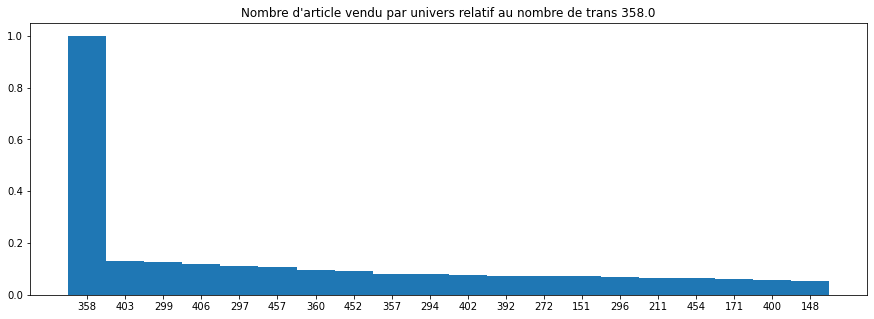

==============359.0===================
Proportion d'achat de univs 359.0 :  0.08 %
Nombre moyen d'achat en plus du univs 359.0 :  5.13
Proportion d'achat de univs 359.0 seul: 8.23 %
CA sans 359.0 :  28859.24
CA moyen sans 359.0 :  21.2
CA de 359.0 :  10746.25
CA moyen de 359.0 :  7.9


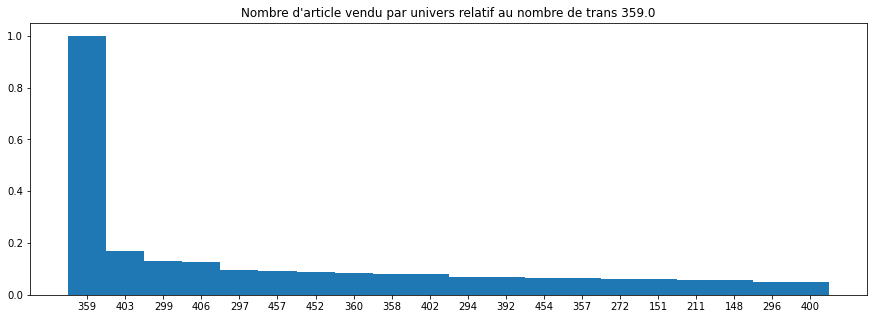

==============360.0===================
Proportion d'achat de univs 360.0 :  2.25 %
Nombre moyen d'achat en plus du univs 360.0 :  5.57
Proportion d'achat de univs 360.0 seul: 6.7 %
CA sans 360.0 :  863720.58
CA moyen sans 360.0 :  22.53
CA de 360.0 :  259642.22
CA moyen de 360.0 :  6.77


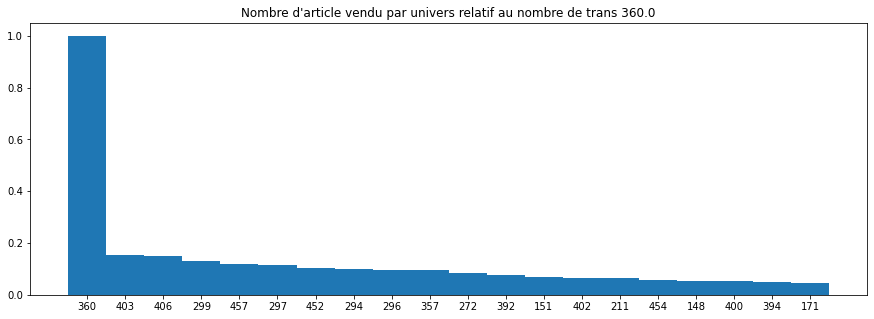

==============361.0===================
Proportion d'achat de univs 361.0 :  0.38 %
Nombre moyen d'achat en plus du univs 361.0 :  5.33
Proportion d'achat de univs 361.0 seul: 7.94 %
CA sans 361.0 :  137071.36
CA moyen sans 361.0 :  20.92
CA de 361.0 :  45537.1
CA moyen de 361.0 :  6.95


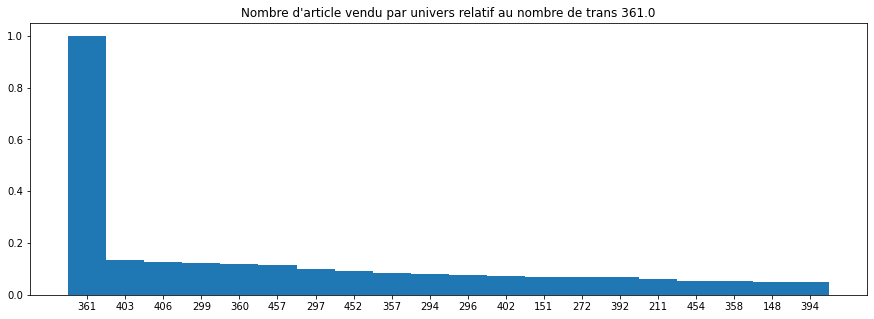

==============362.0===================
Proportion d'achat de univs 362.0 :  0.22 %
Nombre moyen d'achat en plus du univs 362.0 :  4.13
Proportion d'achat de univs 362.0 seul: 9.45 %
CA sans 362.0 :  51834.74
CA moyen sans 362.0 :  13.76
CA de 362.0 :  19604.87
CA moyen de 362.0 :  5.2


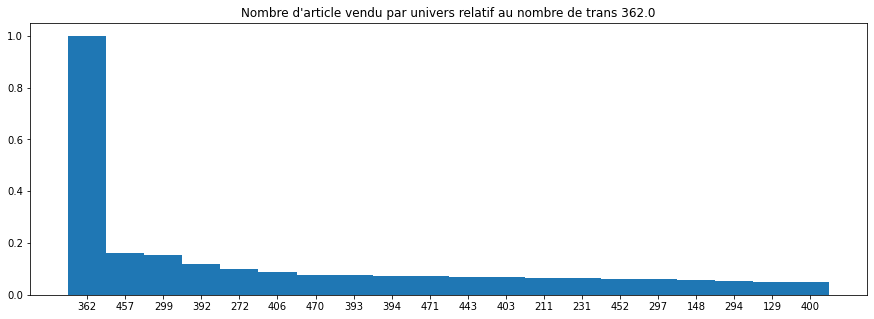

==============363.0===================
Proportion d'achat de univs 363.0 :  0.08 %
Nombre moyen d'achat en plus du univs 363.0 :  5.72
Proportion d'achat de univs 363.0 seul: 4.36 %
CA sans 363.0 :  31921.18
CA moyen sans 363.0 :  22.83
CA de 363.0 :  7634.67
CA moyen de 363.0 :  5.46


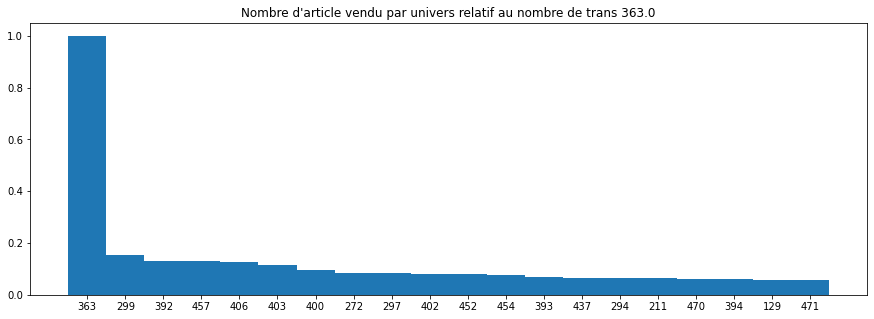

==============366.0===================
Proportion d'achat de univs 366.0 :  0.08 %
Nombre moyen d'achat en plus du univs 366.0 :  11.81
Proportion d'achat de univs 366.0 seul: 2.74 %
CA sans 366.0 :  65250.83
CA moyen sans 366.0 :  49.66
CA de 366.0 :  20610.75
CA moyen de 366.0 :  15.69


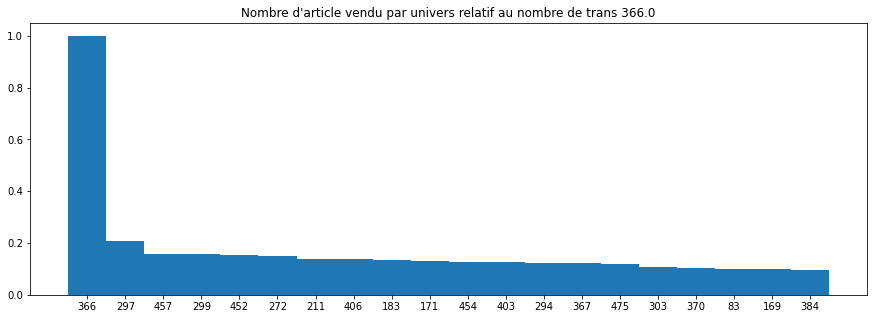

==============367.0===================
Proportion d'achat de univs 367.0 :  0.05 %
Nombre moyen d'achat en plus du univs 367.0 :  11.76
Proportion d'achat de univs 367.0 seul: 2.09 %
CA sans 367.0 :  40227.95
CA moyen sans 367.0 :  49.36
CA de 367.0 :  5808.47
CA moyen de 367.0 :  7.13


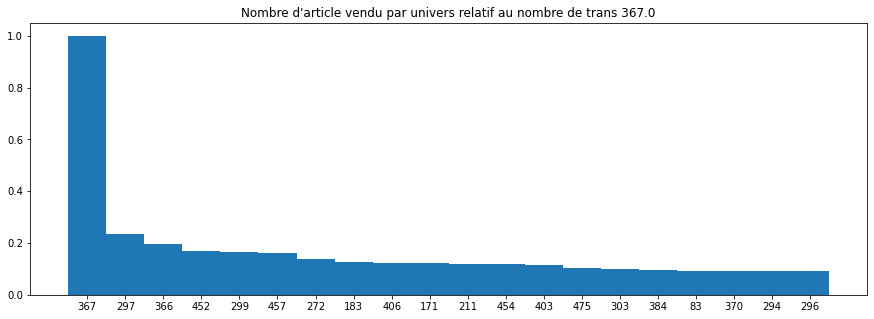

==============368.0===================
Proportion d'achat de univs 368.0 :  0.01 %
Nombre moyen d'achat en plus du univs 368.0 :  12.59
Proportion d'achat de univs 368.0 seul: 4.44 %
CA sans 368.0 :  7605.39
CA moyen sans 368.0 :  56.34
CA de 368.0 :  918.0
CA moyen de 368.0 :  6.8


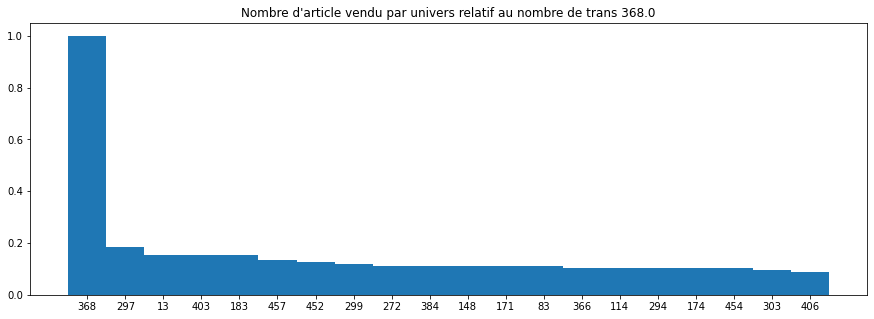

==============369.0===================
Proportion d'achat de univs 369.0 :  0.18 %
Nombre moyen d'achat en plus du univs 369.0 :  10.76
Proportion d'achat de univs 369.0 seul: 1.1 %
CA sans 369.0 :  132936.62
CA moyen sans 369.0 :  42.87
CA de 369.0 :  8943.4
CA moyen de 369.0 :  2.88


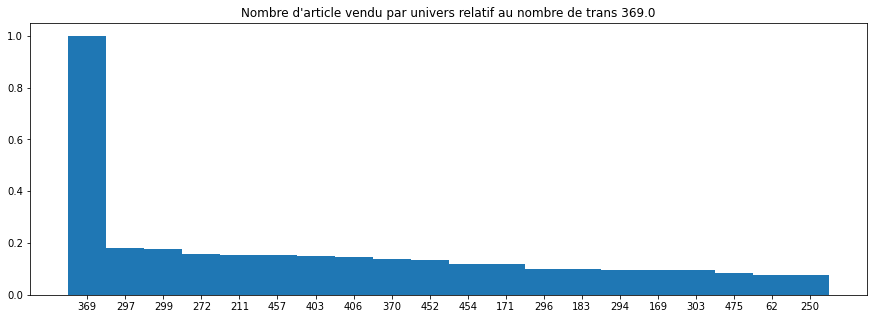

==============370.0===================
Proportion d'achat de univs 370.0 :  0.64 %
Nombre moyen d'achat en plus du univs 370.0 :  10.8
Proportion d'achat de univs 370.0 seul: 1.85 %
CA sans 370.0 :  486051.55
CA moyen sans 370.0 :  44.56
CA de 370.0 :  51181.77
CA moyen de 370.0 :  4.69


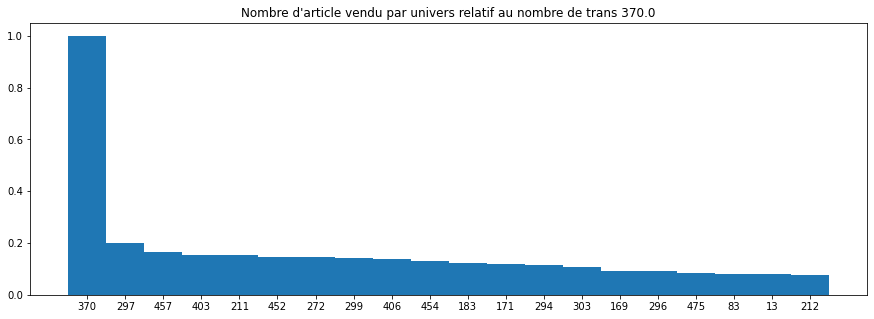

==============372.0===================
Proportion d'achat de univs 372.0 :  0.05 %
Nombre moyen d'achat en plus du univs 372.0 :  10.25
Proportion d'achat de univs 372.0 seul: 2.47 %
CA sans 372.0 :  37718.02
CA moyen sans 372.0 :  40.51
CA de 372.0 :  2123.7
CA moyen de 372.0 :  2.28


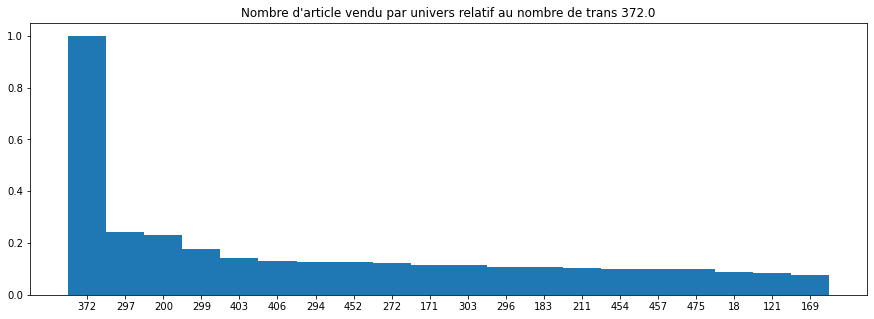

==============373.0===================
Proportion d'achat de univs 373.0 :  0.04 %
Nombre moyen d'achat en plus du univs 373.0 :  9.09
Proportion d'achat de univs 373.0 seul: 4.7 %
CA sans 373.0 :  22440.97
CA moyen sans 373.0 :  35.17
CA de 373.0 :  5898.72
CA moyen de 373.0 :  9.25


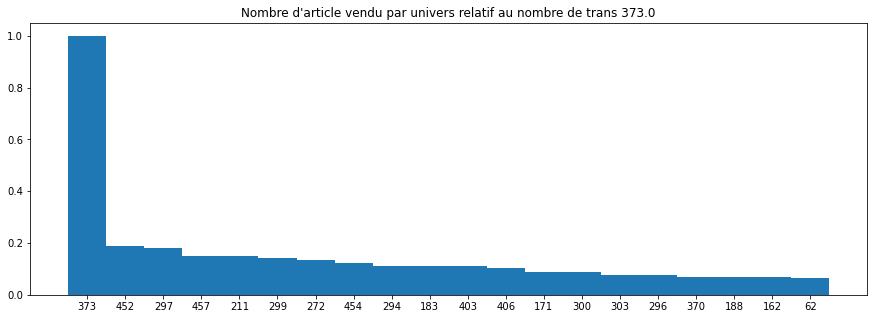

==============374.0===================
Proportion d'achat de univs 374.0 :  0.03 %
Nombre moyen d'achat en plus du univs 374.0 :  10.21
Proportion d'achat de univs 374.0 seul: 1.32 %
CA sans 374.0 :  19198.01
CA moyen sans 374.0 :  42.1
CA de 374.0 :  2884.84
CA moyen de 374.0 :  6.33


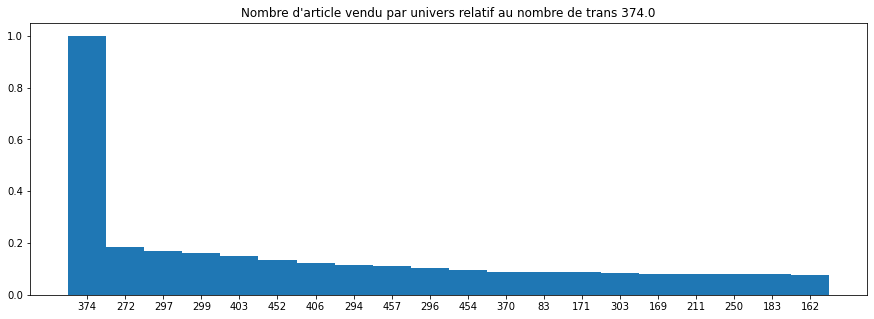

==============375.0===================
Proportion d'achat de univs 375.0 :  0.16 %
Nombre moyen d'achat en plus du univs 375.0 :  10.59
Proportion d'achat de univs 375.0 seul: 1.98 %
CA sans 375.0 :  115971.21
CA moyen sans 375.0 :  43.27
CA de 375.0 :  15252.63
CA moyen de 375.0 :  5.69


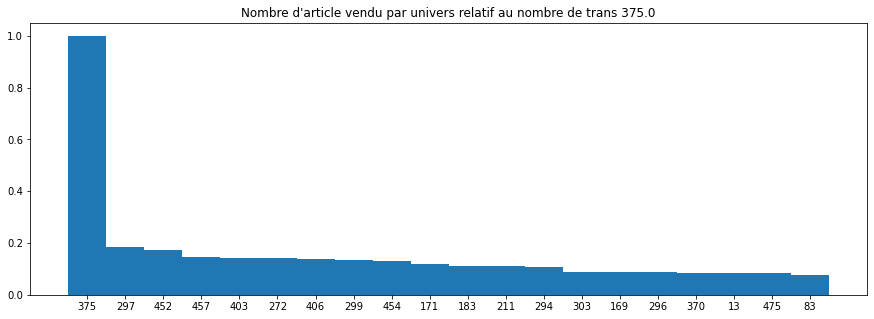

==============376.0===================
Proportion d'achat de univs 376.0 :  0.09 %
Nombre moyen d'achat en plus du univs 376.0 :  9.96
Proportion d'achat de univs 376.0 seul: 1.45 %
CA sans 376.0 :  59787.95
CA moyen sans 376.0 :  41.15
CA de 376.0 :  6873.29
CA moyen de 376.0 :  4.73


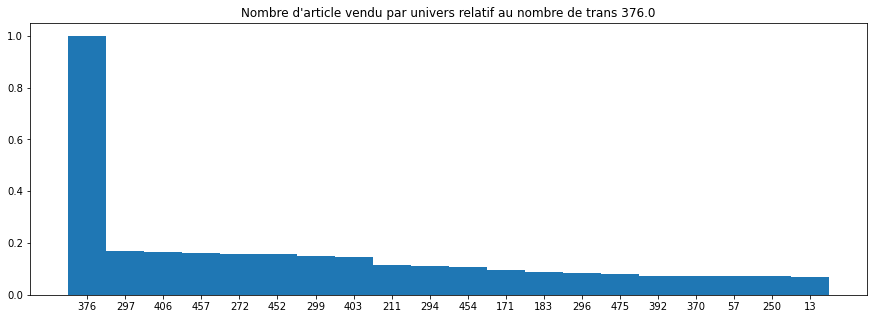

==============377.0===================
Proportion d'achat de univs 377.0 :  0.18 %
Nombre moyen d'achat en plus du univs 377.0 :  8.96
Proportion d'achat de univs 377.0 seul: 2.95 %
CA sans 377.0 :  107742.92
CA moyen sans 377.0 :  35.37
CA de 377.0 :  15019.71
CA moyen de 377.0 :  4.93


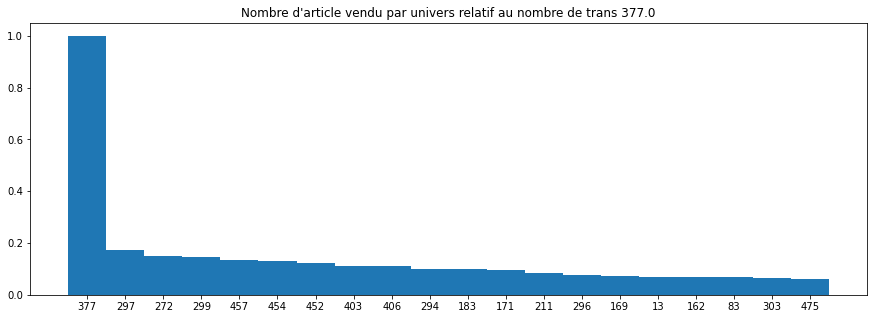

==============378.0===================
Proportion d'achat de univs 378.0 :  0.04 %
Nombre moyen d'achat en plus du univs 378.0 :  9.75
Proportion d'achat de univs 378.0 seul: 1.67 %
CA sans 378.0 :  26475.8
CA moyen sans 378.0 :  40.3
CA de 378.0 :  4247.88
CA moyen de 378.0 :  6.47


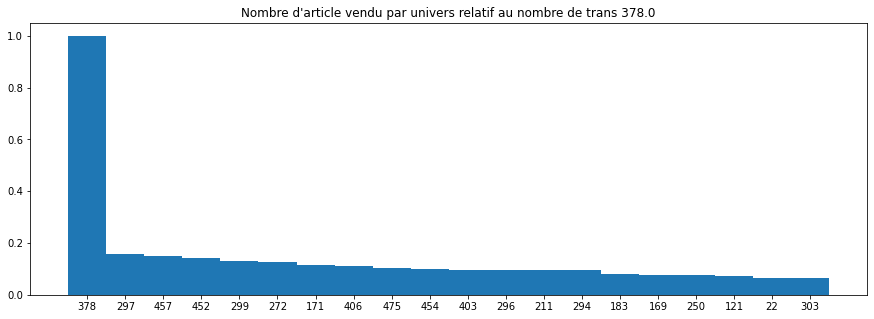

==============379.0===================
Proportion d'achat de univs 379.0 :  0.13 %
Nombre moyen d'achat en plus du univs 379.0 :  11.46
Proportion d'achat de univs 379.0 seul: 0.83 %
CA sans 379.0 :  101383.93
CA moyen sans 379.0 :  46.74
CA de 379.0 :  10997.04
CA moyen de 379.0 :  5.07


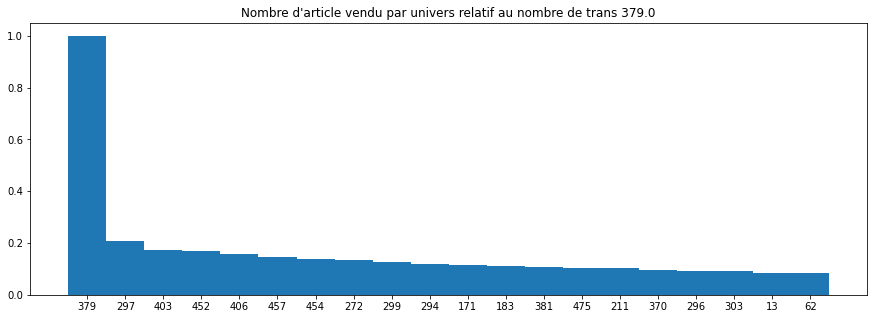

==============380.0===================
Proportion d'achat de univs 380.0 :  0.12 %
Nombre moyen d'achat en plus du univs 380.0 :  12.17
Proportion d'achat de univs 380.0 seul: 0.67 %
CA sans 380.0 :  103776.06
CA moyen sans 380.0 :  49.89
CA de 380.0 :  9931.96
CA moyen de 380.0 :  4.77


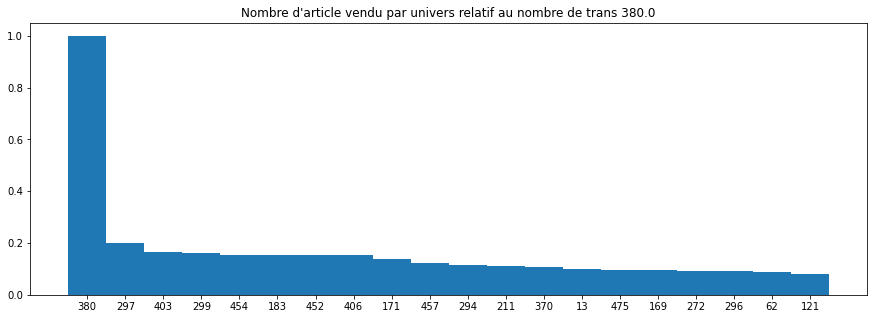

==============381.0===================
Proportion d'achat de univs 381.0 :  0.06 %
Nombre moyen d'achat en plus du univs 381.0 :  11.05
Proportion d'achat de univs 381.0 seul: 0.95 %
CA sans 381.0 :  47801.67
CA moyen sans 381.0 :  45.57
CA de 381.0 :  4913.54
CA moyen de 381.0 :  4.68


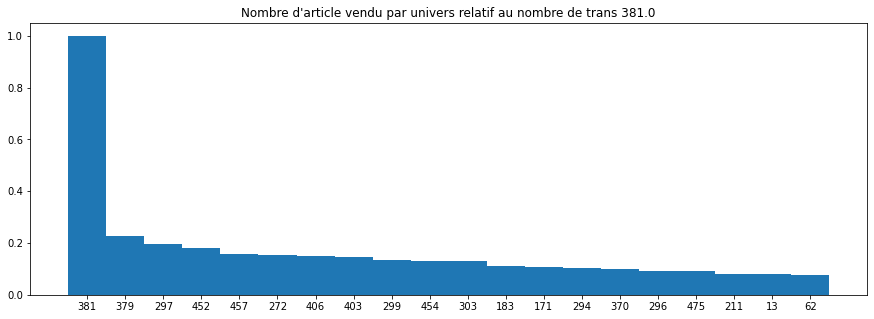

==============382.0===================
Proportion d'achat de univs 382.0 :  0.23 %
Nombre moyen d'achat en plus du univs 382.0 :  12.06
Proportion d'achat de univs 382.0 seul: 0.6 %
CA sans 382.0 :  195885.31
CA moyen sans 382.0 :  48.92
CA de 382.0 :  15936.36
CA moyen de 382.0 :  3.98


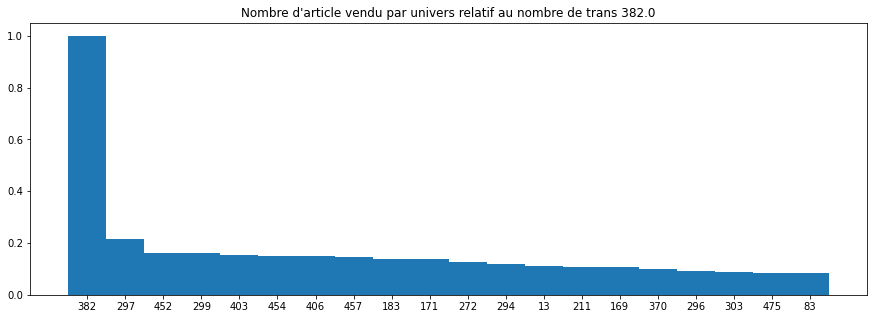

==============384.0===================
Proportion d'achat de univs 384.0 :  0.27 %
Nombre moyen d'achat en plus du univs 384.0 :  11.57
Proportion d'achat de univs 384.0 seul: 2.04 %
CA sans 384.0 :  222063.42
CA moyen sans 384.0 :  47.59
CA de 384.0 :  22396.19
CA moyen de 384.0 :  4.8


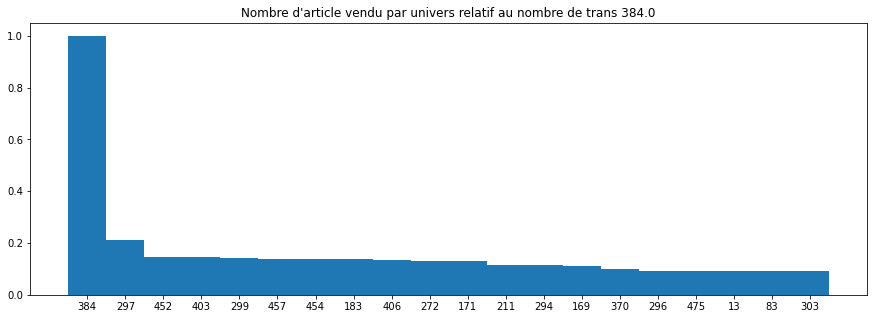

==============386.0===================
Proportion d'achat de univs 386.0 :  0.47 %
Nombre moyen d'achat en plus du univs 386.0 :  6.58
Proportion d'achat de univs 386.0 seul: 4.83 %
CA sans 386.0 :  209536.34
CA moyen sans 386.0 :  26.17
CA de 386.0 :  115447.6
CA moyen de 386.0 :  14.42


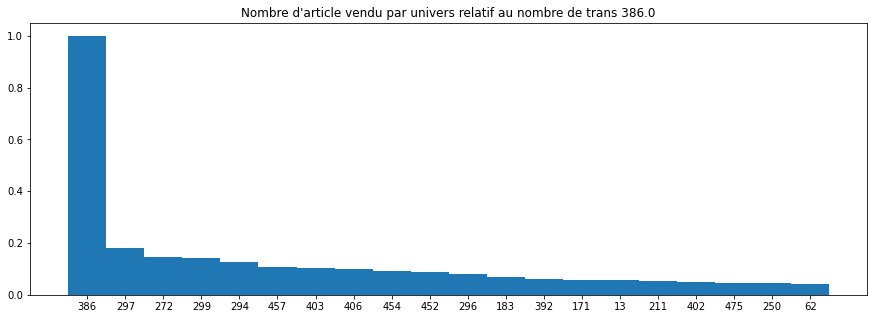

==============387.0===================
Proportion d'achat de univs 387.0 :  0.15 %
Nombre moyen d'achat en plus du univs 387.0 :  10.52
Proportion d'achat de univs 387.0 seul: 2.94 %
CA sans 387.0 :  114968.81
CA moyen sans 387.0 :  43.93
CA de 387.0 :  24692.25
CA moyen de 387.0 :  9.44


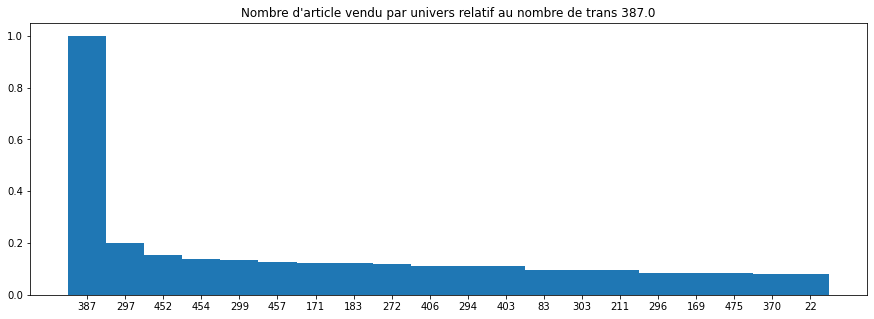

==============390.0===================
NO DATA 
==============391.0===================
Proportion d'achat de univs 391.0 :  0.02 %
Nombre moyen d'achat en plus du univs 391.0 :  5.71
Proportion d'achat de univs 391.0 seul: 3.2 %
CA sans 391.0 :  8868.84
CA moyen sans 391.0 :  21.84
CA de 391.0 :  2131.06
CA moyen de 391.0 :  5.25


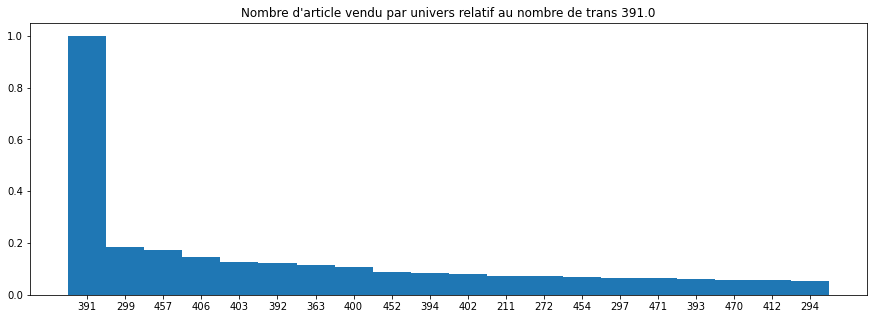

==============392.0===================
Proportion d'achat de univs 392.0 :  9.54 %
Nombre moyen d'achat en plus du univs 392.0 :  3.95
Proportion d'achat de univs 392.0 seul: 12.42 %
CA sans 392.0 :  2215299.21
CA moyen sans 392.0 :  13.61
CA de 392.0 :  688146.44
CA moyen de 392.0 :  4.23


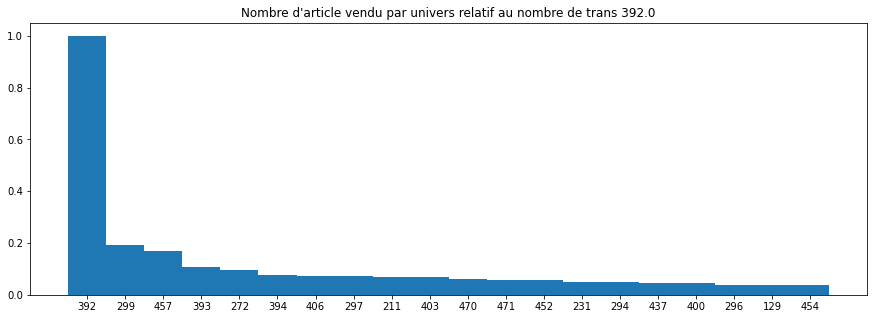

==============393.0===================
Proportion d'achat de univs 393.0 :  4.72 %
Nombre moyen d'achat en plus du univs 393.0 :  3.95
Proportion d'achat de univs 393.0 seul: 11.07 %
CA sans 393.0 :  1078607.33
CA moyen sans 393.0 :  13.4
CA de 393.0 :  396197.82
CA moyen de 393.0 :  4.92


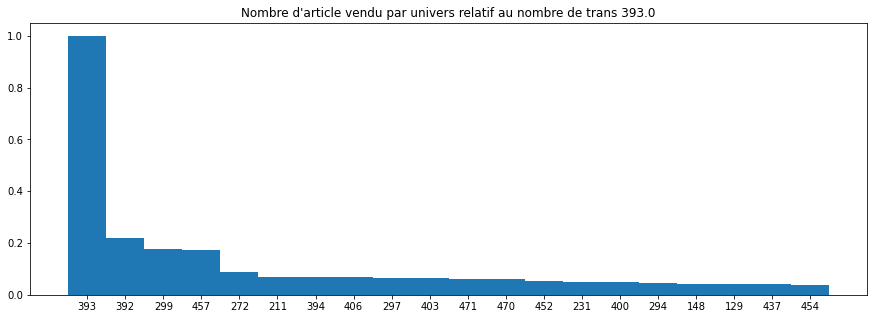

==============394.0===================
Proportion d'achat de univs 394.0 :  3.85 %
Nombre moyen d'achat en plus du univs 394.0 :  4.76
Proportion d'achat de univs 394.0 seul: 5.1 %
CA sans 394.0 :  1114194.67
CA moyen sans 394.0 :  16.97
CA de 394.0 :  187800.67
CA moyen de 394.0 :  2.86


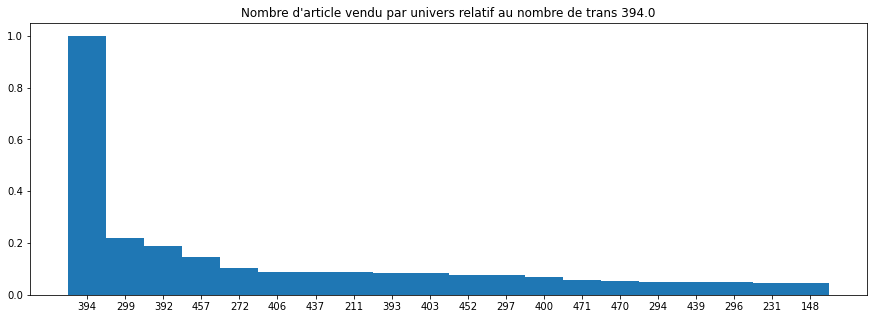

==============395.0===================
Proportion d'achat de univs 395.0 :  0.01 %
Nombre moyen d'achat en plus du univs 395.0 :  3.64
Proportion d'achat de univs 395.0 seul: 5.56 %
CA sans 395.0 :  1266.09
CA moyen sans 395.0 :  11.72
CA de 395.0 :  414.89
CA moyen de 395.0 :  3.84


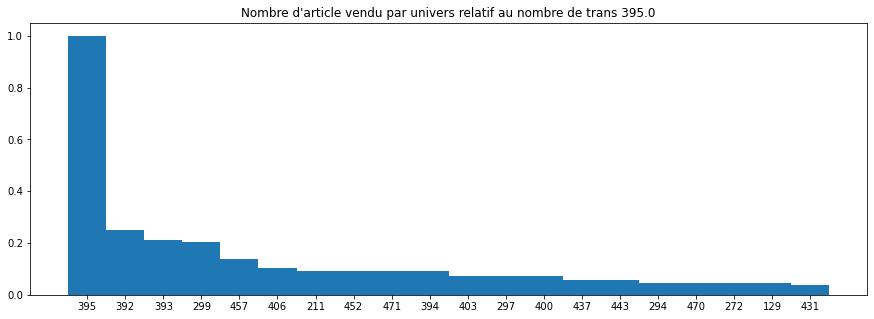

==============396.0===================
Proportion d'achat de univs 396.0 :  1.21 %
Nombre moyen d'achat en plus du univs 396.0 :  5.05
Proportion d'achat de univs 396.0 seul: 5.6 %
CA sans 396.0 :  377381.78
CA moyen sans 396.0 :  18.28
CA de 396.0 :  70472.9
CA moyen de 396.0 :  3.41


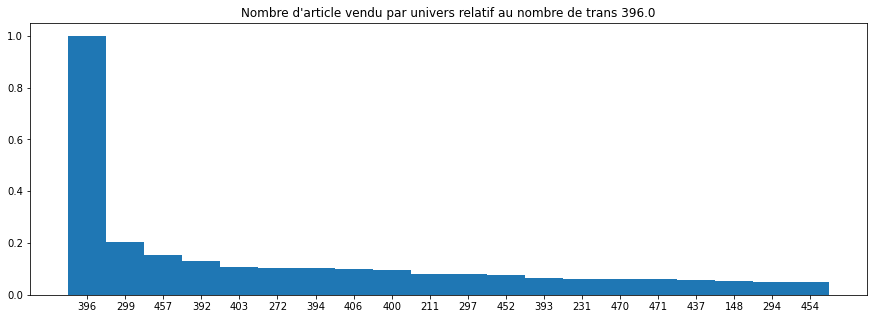

==============397.0===================
Proportion d'achat de univs 397.0 :  0.03 %
Nombre moyen d'achat en plus du univs 397.0 :  4.59
Proportion d'achat de univs 397.0 seul: 5.97 %
CA sans 397.0 :  8997.61
CA moyen sans 397.0 :  16.27
CA de 397.0 :  2359.37
CA moyen de 397.0 :  4.27


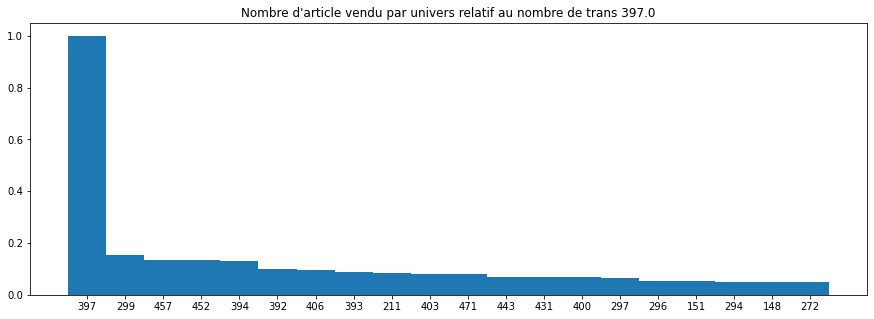

==============400.0===================
Proportion d'achat de univs 400.0 :  3.26 %
Nombre moyen d'achat en plus du univs 400.0 :  4.81
Proportion d'achat de univs 400.0 seul: 6.66 %
CA sans 400.0 :  991343.53
CA moyen sans 400.0 :  17.8
CA de 400.0 :  265221.39
CA moyen de 400.0 :  4.76


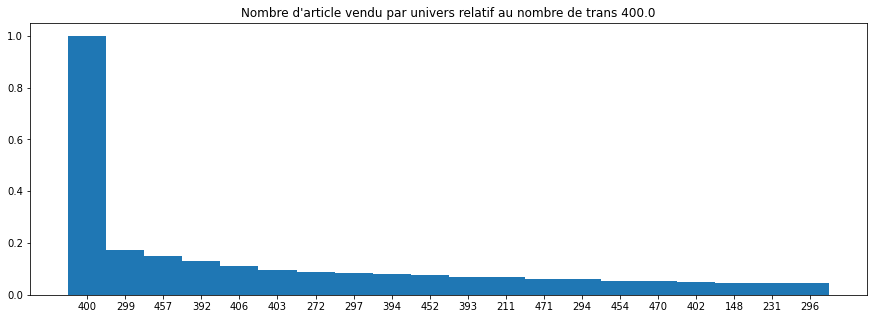

==============402.0===================
Proportion d'achat de univs 402.0 :  5.59 %
Nombre moyen d'achat en plus du univs 402.0 :  6.46
Proportion d'achat de univs 402.0 seul: 3.97 %
CA sans 402.0 :  2772667.23
CA moyen sans 402.0 :  29.07
CA de 402.0 :  849092.42
CA moyen de 402.0 :  8.9


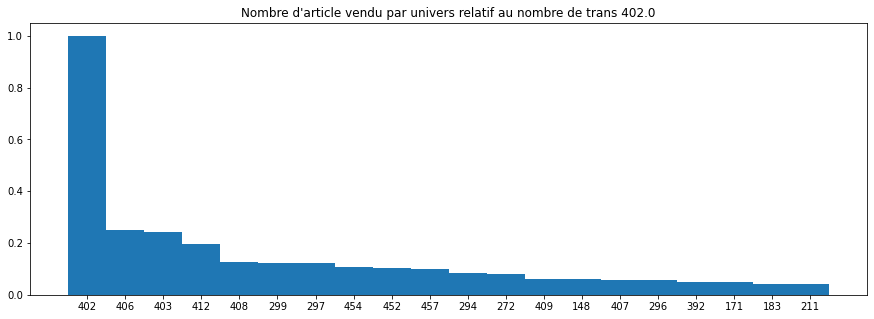

==============403.0===================
Proportion d'achat de univs 403.0 :  12.55 %
Nombre moyen d'achat en plus du univs 403.0 :  5.59
Proportion d'achat de univs 403.0 seul: 7.79 %
CA sans 403.0 :  5108216.0
CA moyen sans 403.0 :  23.86
CA de 403.0 :  2641023.02
CA moyen de 403.0 :  12.34


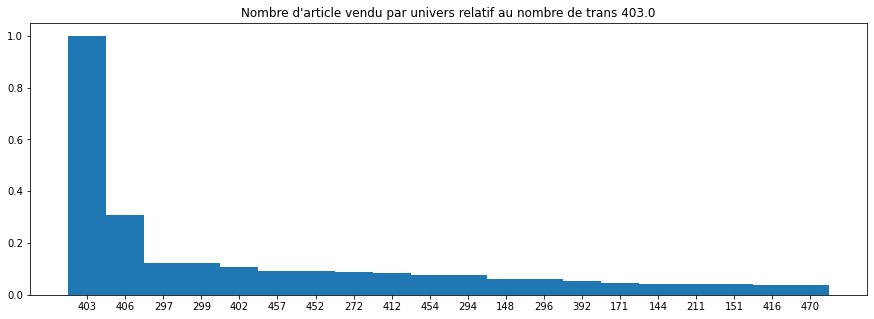

==============404.0===================
Proportion d'achat de univs 404.0 :  0.98 %
Nombre moyen d'achat en plus du univs 404.0 :  8.16
Proportion d'achat de univs 404.0 seul: 2.84 %
CA sans 404.0 :  600021.47
CA moyen sans 404.0 :  35.74
CA de 404.0 :  187356.67
CA moyen de 404.0 :  11.16


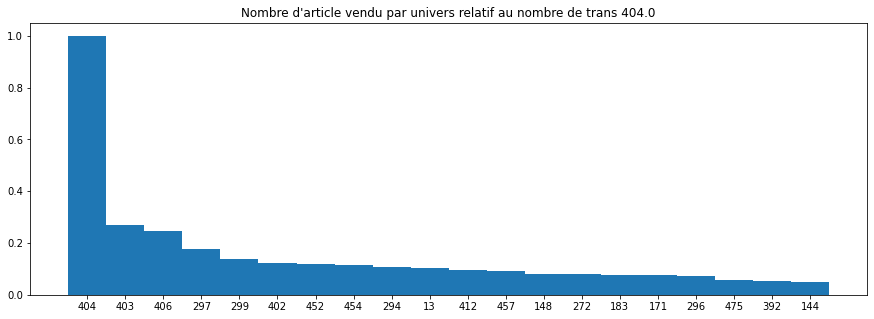

==============405.0===================
Proportion d'achat de univs 405.0 :  1.22 %
Nombre moyen d'achat en plus du univs 405.0 :  7.41
Proportion d'achat de univs 405.0 seul: 4.32 %
CA sans 405.0 :  663745.29
CA moyen sans 405.0 :  31.85
CA de 405.0 :  211513.79
CA moyen de 405.0 :  10.15


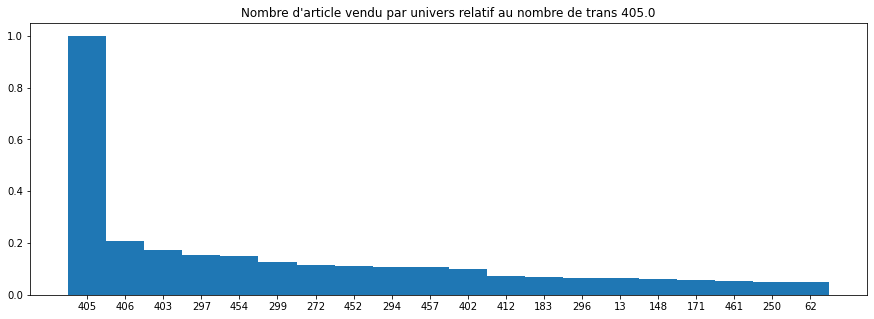

==============406.0===================
Proportion d'achat de univs 406.0 :  12.94 %
Nombre moyen d'achat en plus du univs 406.0 :  5.51
Proportion d'achat de univs 406.0 seul: 7.51 %
CA sans 406.0 :  5169206.72
CA moyen sans 406.0 :  23.42
CA de 406.0 :  2339506.03
CA moyen de 406.0 :  10.6


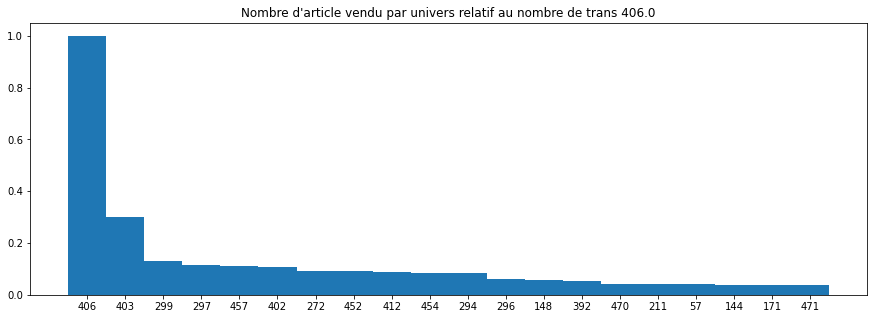

==============407.0===================
Proportion d'achat de univs 407.0 :  1.4 %
Nombre moyen d'achat en plus du univs 407.0 :  6.74
Proportion d'achat de univs 407.0 seul: 3.92 %
CA sans 407.0 :  745679.03
CA moyen sans 407.0 :  31.32
CA de 407.0 :  209570.06
CA moyen de 407.0 :  8.8


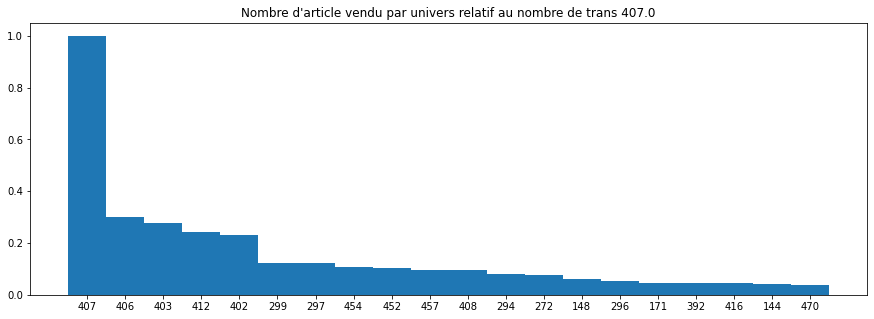

==============408.0===================
Proportion d'achat de univs 408.0 :  1.84 %
Nombre moyen d'achat en plus du univs 408.0 :  7.68
Proportion d'achat de univs 408.0 seul: 0.96 %
CA sans 408.0 :  1150768.14
CA moyen sans 408.0 :  36.72
CA de 408.0 :  250113.05
CA moyen de 408.0 :  7.98


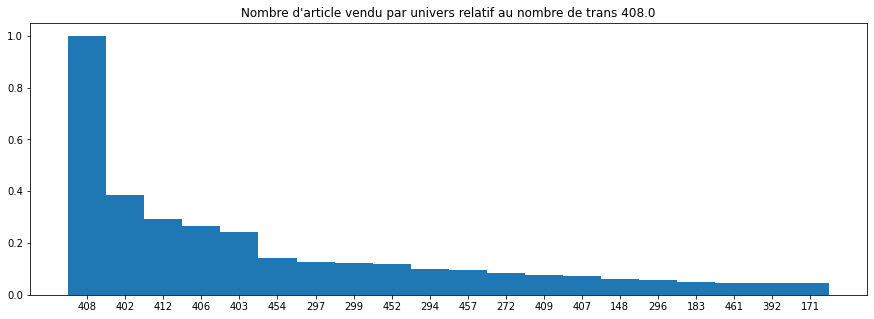

==============409.0===================
Proportion d'achat de univs 409.0 :  1.89 %
Nombre moyen d'achat en plus du univs 409.0 :  6.37
Proportion d'achat de univs 409.0 seul: 4.93 %
CA sans 409.0 :  881396.24
CA moyen sans 409.0 :  27.35
CA de 409.0 :  462233.86
CA moyen de 409.0 :  14.34


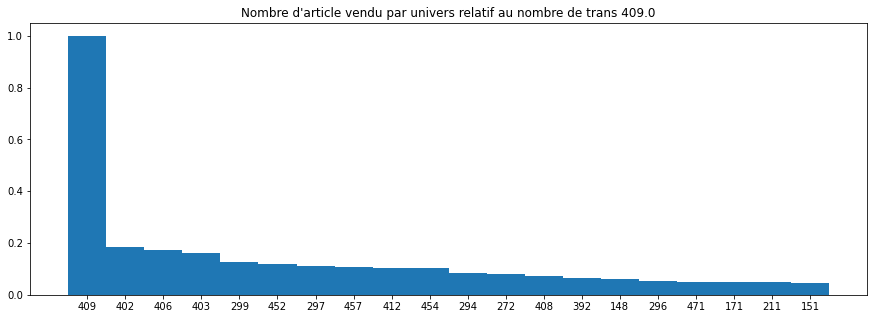

==============410.0===================
Proportion d'achat de univs 410.0 :  0.2 %
Nombre moyen d'achat en plus du univs 410.0 :  6.54
Proportion d'achat de univs 410.0 seul: 5.31 %
CA sans 410.0 :  107073.73
CA moyen sans 410.0 :  30.91
CA de 410.0 :  27588.08
CA moyen de 410.0 :  7.96


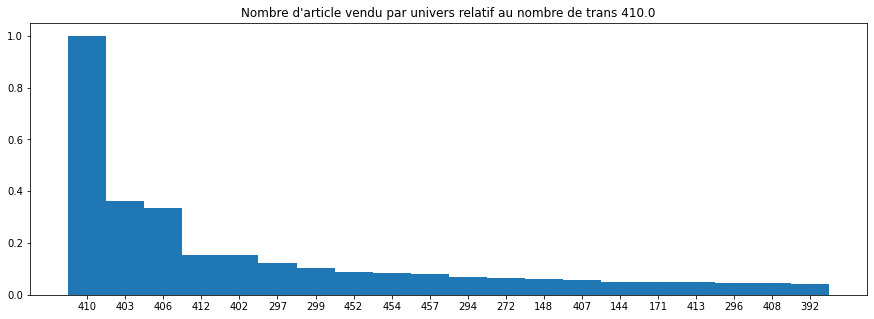

==============411.0===================
Proportion d'achat de univs 411.0 :  0.75 %
Nombre moyen d'achat en plus du univs 411.0 :  7.31
Proportion d'achat de univs 411.0 seul: 3.26 %
CA sans 411.0 :  440142.81
CA moyen sans 411.0 :  34.2
CA de 411.0 :  140523.72
CA moyen de 411.0 :  10.92


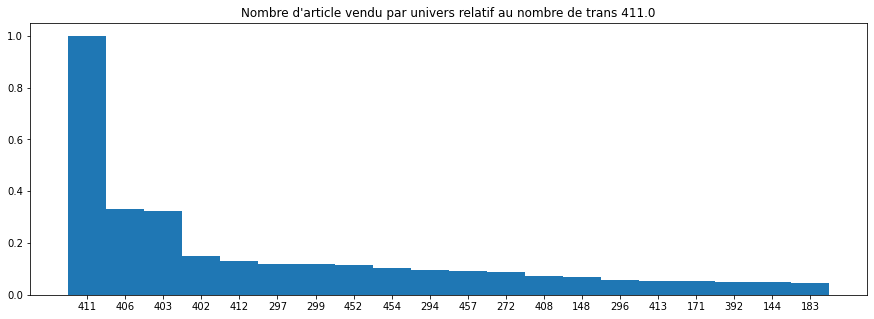

==============412.0===================
Proportion d'achat de univs 412.0 :  4.13 %
Nombre moyen d'achat en plus du univs 412.0 :  6.43
Proportion d'achat de univs 412.0 seul: 4.16 %
CA sans 412.0 :  2088757.48
CA moyen sans 412.0 :  29.67
CA de 412.0 :  632111.25
CA moyen de 412.0 :  8.98


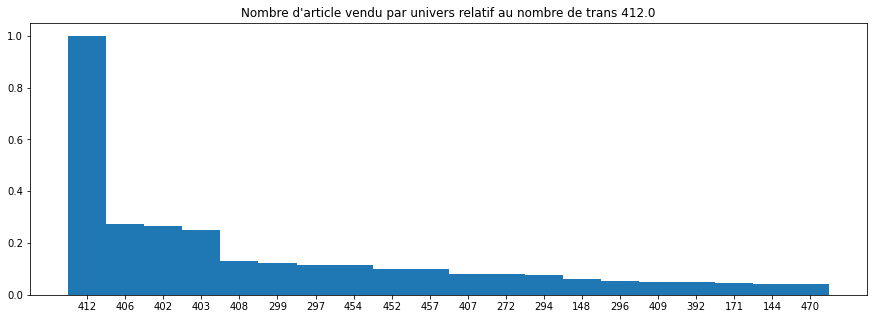

==============413.0===================
Proportion d'achat de univs 413.0 :  1.39 %
Nombre moyen d'achat en plus du univs 413.0 :  8.22
Proportion d'achat de univs 413.0 seul: 1.5 %
CA sans 413.0 :  825103.91
CA moyen sans 413.0 :  34.88
CA de 413.0 :  171459.94
CA moyen de 413.0 :  7.25


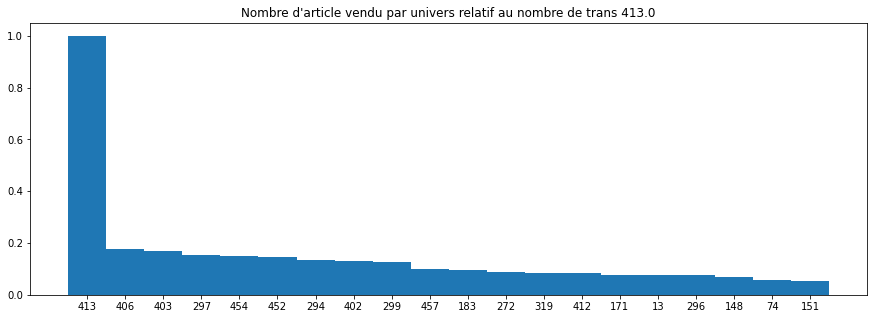

==============416.0===================
Proportion d'achat de univs 416.0 :  1.18 %
Nombre moyen d'achat en plus du univs 416.0 :  8.17
Proportion d'achat de univs 416.0 seul: 1.64 %
CA sans 416.0 :  760524.02
CA moyen sans 416.0 :  37.7
CA de 416.0 :  108377.32
CA moyen de 416.0 :  5.37


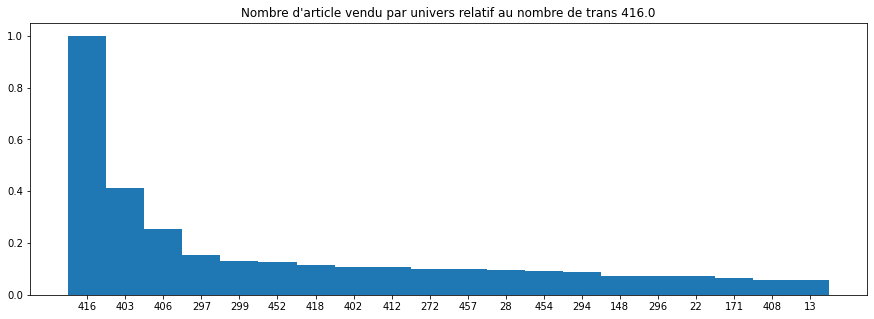

==============417.0===================
Proportion d'achat de univs 417.0 :  0.07 %
Nombre moyen d'achat en plus du univs 417.0 :  8.08
Proportion d'achat de univs 417.0 seul: 1.0 %
CA sans 417.0 :  45034.25
CA moyen sans 417.0 :  37.37
CA de 417.0 :  6315.46
CA moyen de 417.0 :  5.24


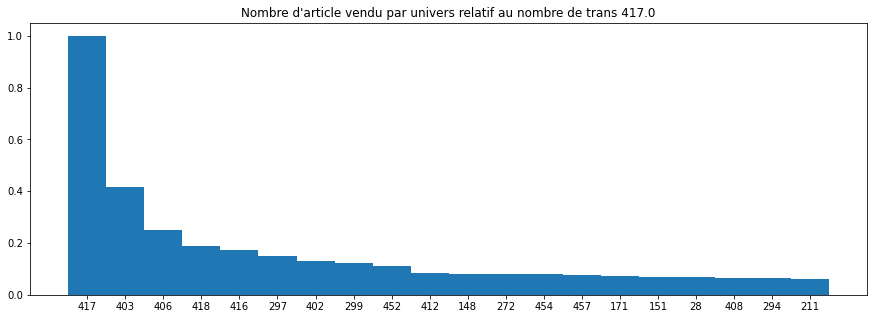

==============418.0===================
Proportion d'achat de univs 418.0 :  0.93 %
Nombre moyen d'achat en plus du univs 418.0 :  8.04
Proportion d'achat de univs 418.0 seul: 1.44 %
CA sans 418.0 :  600638.08
CA moyen sans 418.0 :  38.02
CA de 418.0 :  102144.54
CA moyen de 418.0 :  6.46


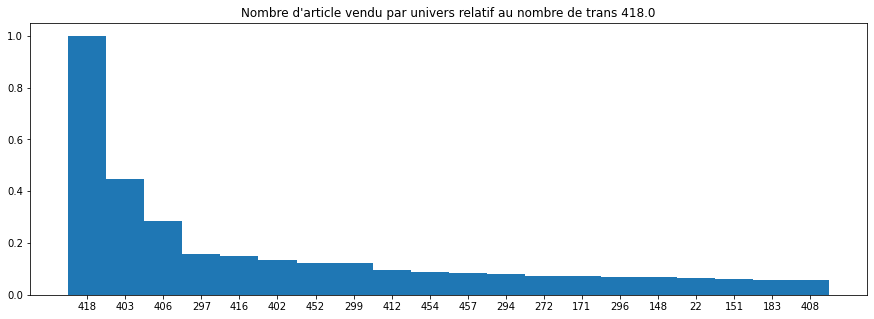

==============419.0===================
Proportion d'achat de univs 419.0 :  0.33 %
Nombre moyen d'achat en plus du univs 419.0 :  9.53
Proportion d'achat de univs 419.0 seul: 1.59 %
CA sans 419.0 :  230195.71
CA moyen sans 419.0 :  40.58
CA de 419.0 :  18564.72
CA moyen de 419.0 :  3.27


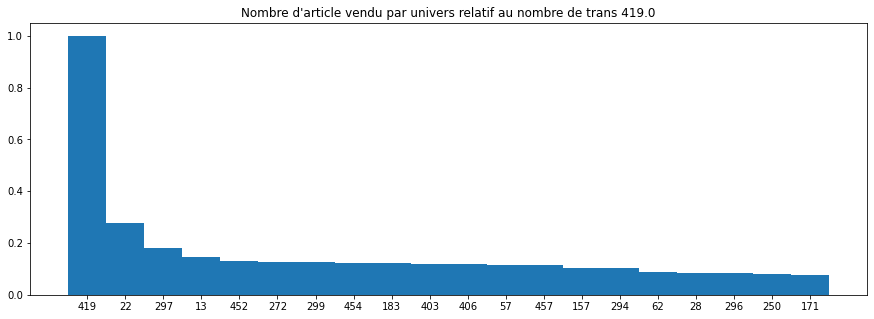

==============420.0===================
Proportion d'achat de univs 420.0 :  0.3 %
Nombre moyen d'achat en plus du univs 420.0 :  9.11
Proportion d'achat de univs 420.0 seul: 1.07 %
CA sans 420.0 :  211109.62
CA moyen sans 420.0 :  41.66
CA de 420.0 :  44477.29
CA moyen de 420.0 :  8.78


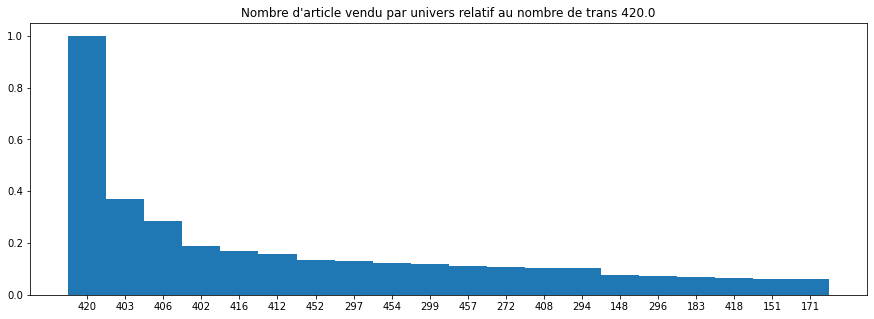

==============421.0===================
Proportion d'achat de univs 421.0 :  0.01 %
Nombre moyen d'achat en plus du univs 421.0 :  4.75
Proportion d'achat de univs 421.0 seul: 17.71 %
CA sans 421.0 :  5681.24
CA moyen sans 421.0 :  32.46
CA de 421.0 :  14605.17
CA moyen de 421.0 :  83.46


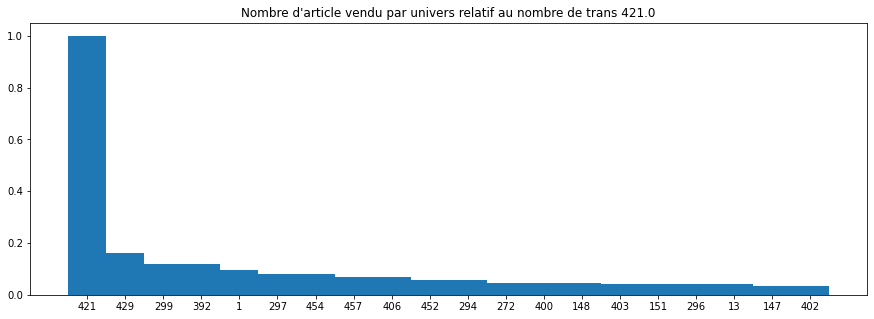

==============422.0===================
NO DATA 
==============425.0===================
NO DATA 
==============429.0===================
Proportion d'achat de univs 429.0 :  0.03 %
Nombre moyen d'achat en plus du univs 429.0 :  6.15
Proportion d'achat de univs 429.0 seul: 10.72 %
CA sans 429.0 :  16368.41
CA moyen sans 429.0 :  33.75
CA de 429.0 :  12518.83
CA moyen de 429.0 :  25.81


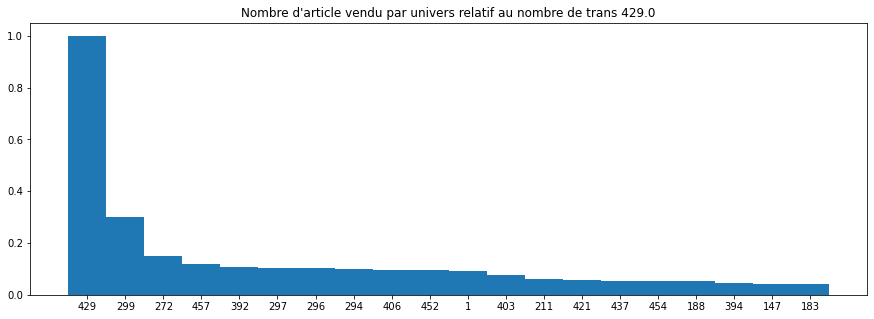

==============431.0===================
Proportion d'achat de univs 431.0 :  1.27 %
Nombre moyen d'achat en plus du univs 431.0 :  4.55
Proportion d'achat de univs 431.0 seul: 2.55 %
CA sans 431.0 :  373657.16
CA moyen sans 431.0 :  17.2
CA de 431.0 :  68967.26
CA moyen de 431.0 :  3.18


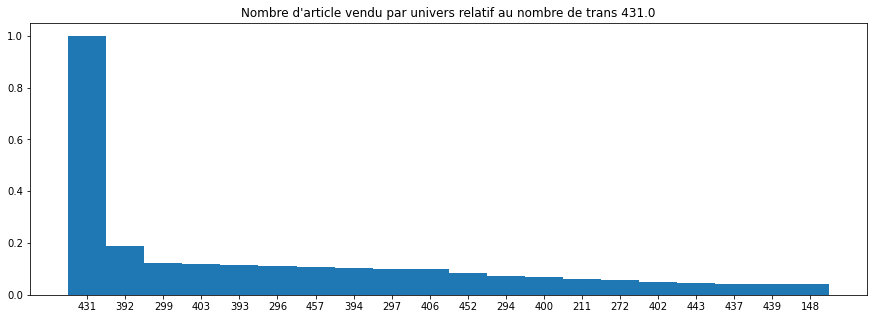

==============432.0===================
Proportion d'achat de univs 432.0 :  0.58 %
Nombre moyen d'achat en plus du univs 432.0 :  8.54
Proportion d'achat de univs 432.0 seul: 2.62 %
CA sans 432.0 :  343546.66
CA moyen sans 432.0 :  34.6
CA de 432.0 :  73713.87
CA moyen de 432.0 :  7.42


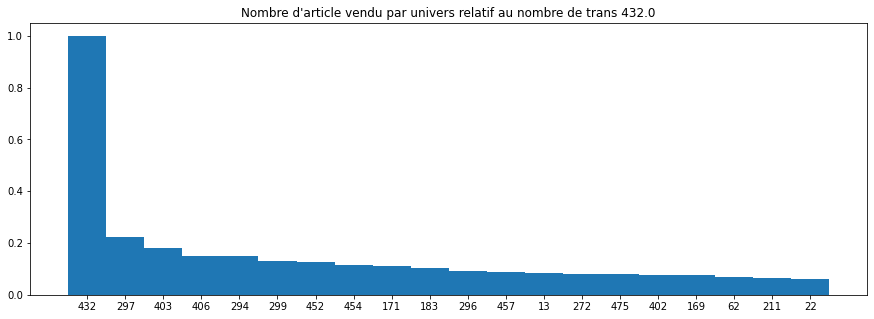

==============433.0===================
Proportion d'achat de univs 433.0 :  0.03 %
Nombre moyen d'achat en plus du univs 433.0 :  7.69
Proportion d'achat de univs 433.0 seul: 1.58 %
CA sans 433.0 :  12474.03
CA moyen sans 433.0 :  28.16
CA de 433.0 :  1566.61
CA moyen de 433.0 :  3.54


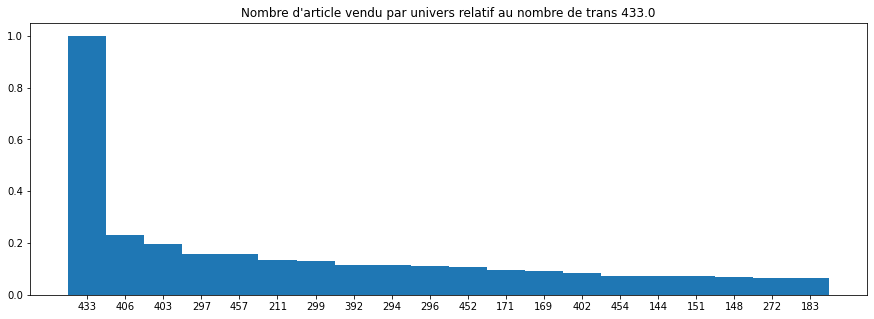

==============434.0===================
NO DATA 
==============435.0===================
Proportion d'achat de univs 435.0 :  1.85 %
Nombre moyen d'achat en plus du univs 435.0 :  6.27
Proportion d'achat de univs 435.0 seul: 6.9 %
CA sans 435.0 :  763382.73
CA moyen sans 435.0 :  24.21
CA de 435.0 :  230842.19
CA moyen de 435.0 :  7.32


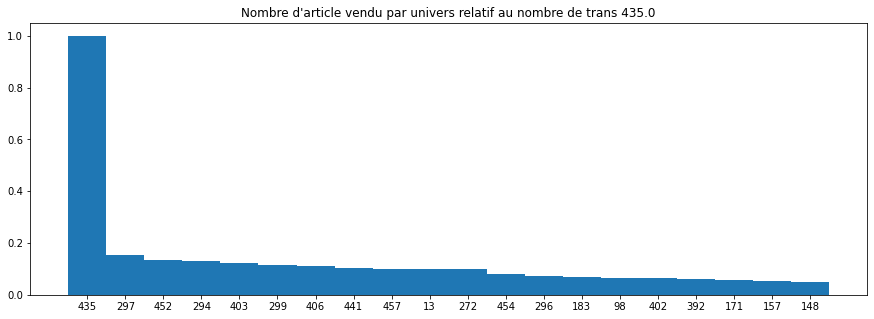

==============436.0===================
Proportion d'achat de univs 436.0 :  0.01 %
Nombre moyen d'achat en plus du univs 436.0 :  5.31
Proportion d'achat de univs 436.0 seul: 3.05 %
CA sans 436.0 :  3043.67
CA moyen sans 436.0 :  18.56
CA de 436.0 :  582.9
CA moyen de 436.0 :  3.55


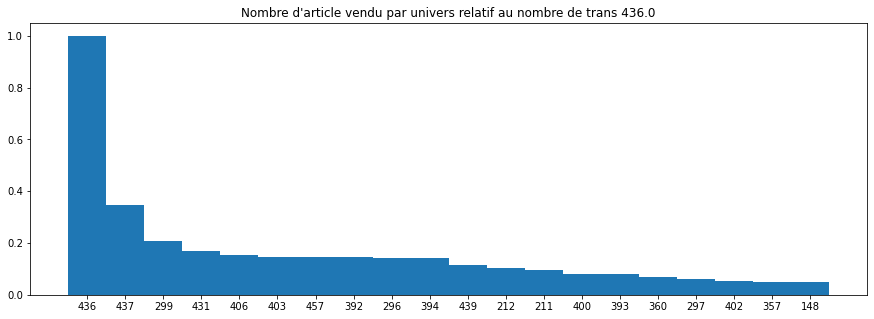

==============437.0===================
Proportion d'achat de univs 437.0 :  4.69 %
Nombre moyen d'achat en plus du univs 437.0 :  4.33
Proportion d'achat de univs 437.0 seul: 9.27 %
CA sans 437.0 :  1100229.03
CA moyen sans 437.0 :  13.74
CA de 437.0 :  195043.54
CA moyen de 437.0 :  2.44


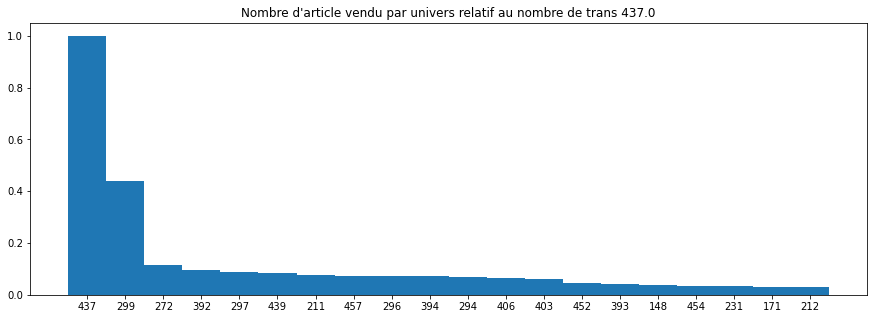

==============438.0===================
Proportion d'achat de univs 438.0 :  1.1 %
Nombre moyen d'achat en plus du univs 438.0 :  7.76
Proportion d'achat de univs 438.0 seul: 5.57 %
CA sans 438.0 :  492289.88
CA moyen sans 438.0 :  26.32
CA de 438.0 :  137738.07
CA moyen de 438.0 :  7.36


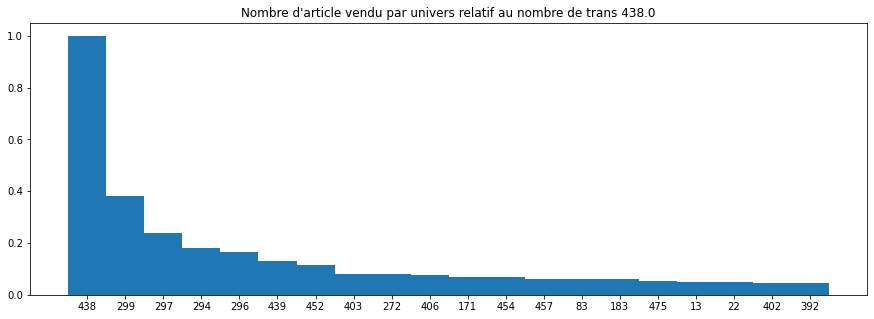

==============439.0===================
Proportion d'achat de univs 439.0 :  3.23 %
Nombre moyen d'achat en plus du univs 439.0 :  6.24
Proportion d'achat de univs 439.0 seul: 2.9 %
CA sans 439.0 :  1110391.02
CA moyen sans 439.0 :  20.14
CA de 439.0 :  204448.47
CA moyen de 439.0 :  3.71


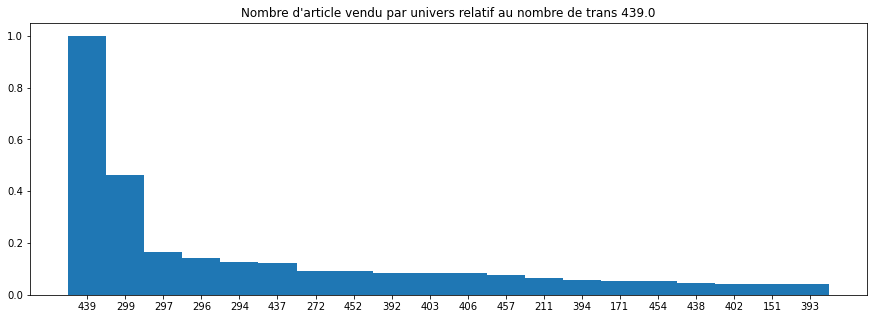

==============440.0===================
Proportion d'achat de univs 440.0 :  0.04 %
Nombre moyen d'achat en plus du univs 440.0 :  9.96
Proportion d'achat de univs 440.0 seul: 1.89 %
CA sans 440.0 :  25550.62
CA moyen sans 440.0 :  40.3
CA de 440.0 :  4479.8
CA moyen de 440.0 :  7.07


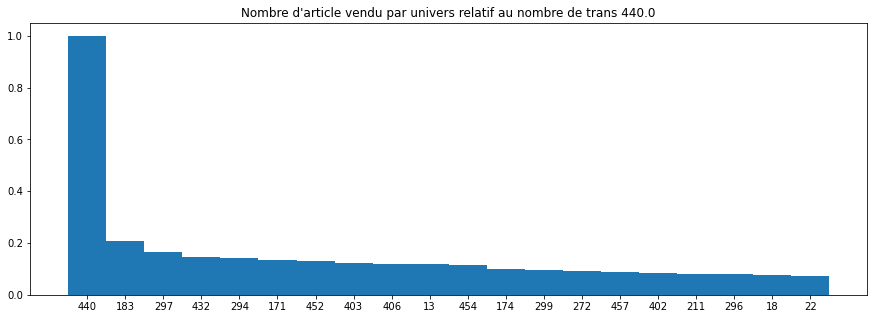

==============441.0===================
Proportion d'achat de univs 441.0 :  0.39 %
Nombre moyen d'achat en plus du univs 441.0 :  6.98
Proportion d'achat de univs 441.0 seul: 1.94 %
CA sans 441.0 :  190935.41
CA moyen sans 441.0 :  28.49
CA de 441.0 :  15911.35
CA moyen de 441.0 :  2.37


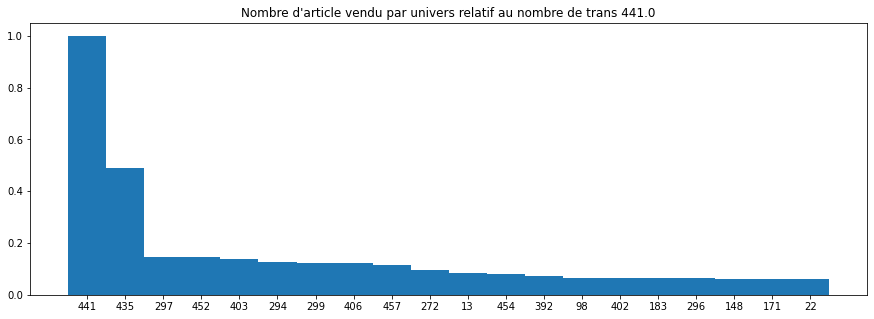

==============442.0===================
NO DATA 
==============443.0===================
Proportion d'achat de univs 443.0 :  1.67 %
Nombre moyen d'achat en plus du univs 443.0 :  5.06
Proportion d'achat de univs 443.0 seul: 2.69 %
CA sans 443.0 :  511660.35
CA moyen sans 443.0 :  17.92
CA de 443.0 :  79628.83
CA moyen de 443.0 :  2.79


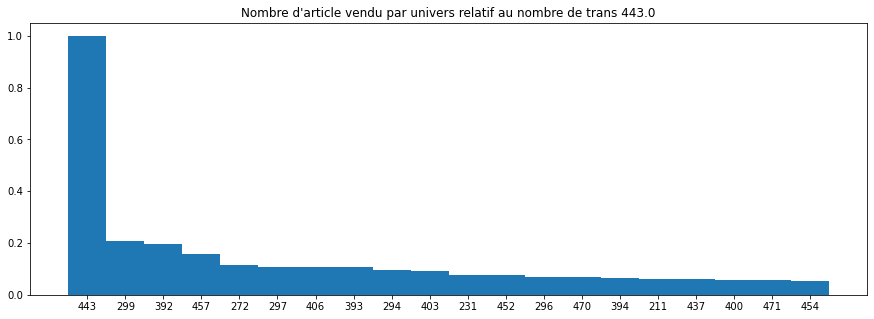

==============444.0===================
NO DATA 
==============445.0===================
NO DATA 
==============447.0===================
Proportion d'achat de univs 447.0 :  0.01 %
Nombre moyen d'achat en plus du univs 447.0 :  8.0
Proportion d'achat de univs 447.0 seul: 0.91 %
CA sans 447.0 :  7589.55
CA moyen sans 447.0 :  34.5
CA de 447.0 :  72.52
CA moyen de 447.0 :  0.33


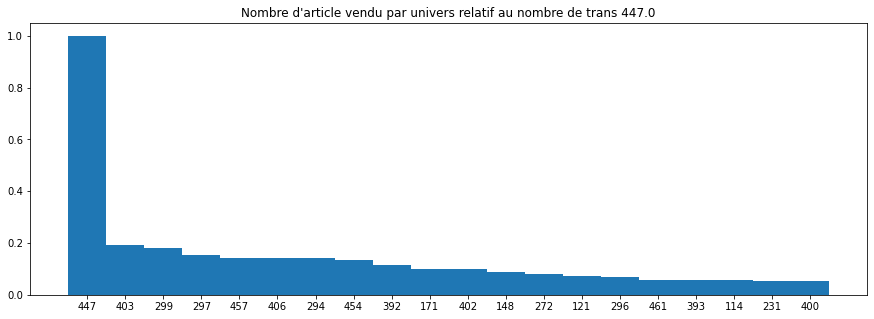

==============448.0===================
Proportion d'achat de univs 448.0 :  0.33 %
Nombre moyen d'achat en plus du univs 448.0 :  6.97
Proportion d'achat de univs 448.0 seul: 0.02 %
CA sans 448.0 :  147146.8
CA moyen sans 448.0 :  26.12
CA de 448.0 :  1234.56
CA moyen de 448.0 :  0.22


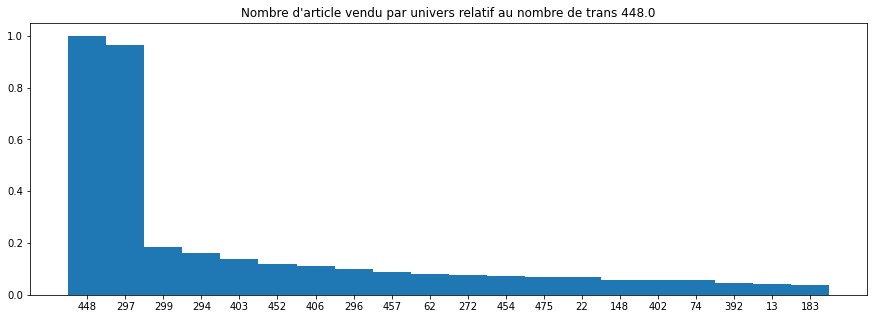

==============449.0===================
NO DATA 
==============450.0===================
Proportion d'achat de univs 450.0 :  0.0 %
Nombre moyen d'achat en plus du univs 450.0 :  8.87
Proportion d'achat de univs 450.0 seul: 3.77 %
CA sans 450.0 :  1826.36
CA moyen sans 450.0 :  34.46
CA de 450.0 :  276.92
CA moyen de 450.0 :  5.22


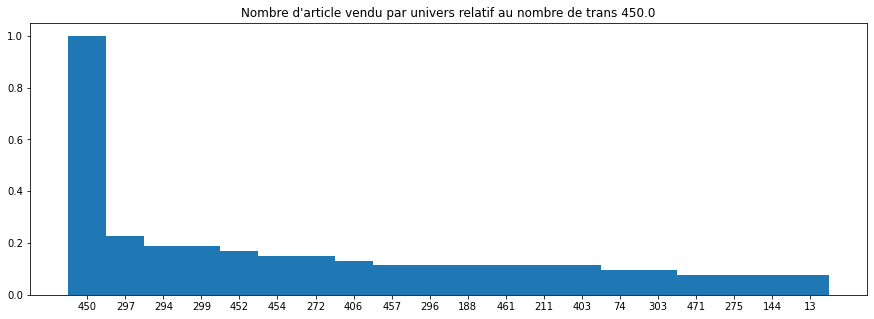

==============451.0===================
NO DATA 
==============452.0===================
Proportion d'achat de univs 452.0 :  6.54 %
Nombre moyen d'achat en plus du univs 452.0 :  9.26
Proportion d'achat de univs 452.0 seul: 0.1 %
CA sans 452.0 :  4271333.04
CA moyen sans 452.0 :  38.27
CA de 452.0 :  25939.32
CA moyen de 452.0 :  0.23


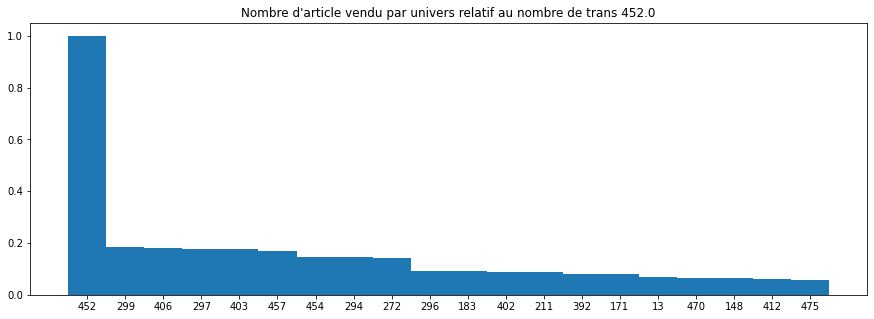

==============453.0===================
Proportion d'achat de univs 453.0 :  0.08 %
Nombre moyen d'achat en plus du univs 453.0 :  11.05
Proportion d'achat de univs 453.0 seul: 1.13 %
CA sans 453.0 :  56869.68
CA moyen sans 453.0 :  42.79
CA de 453.0 :  6449.77
CA moyen de 453.0 :  4.85


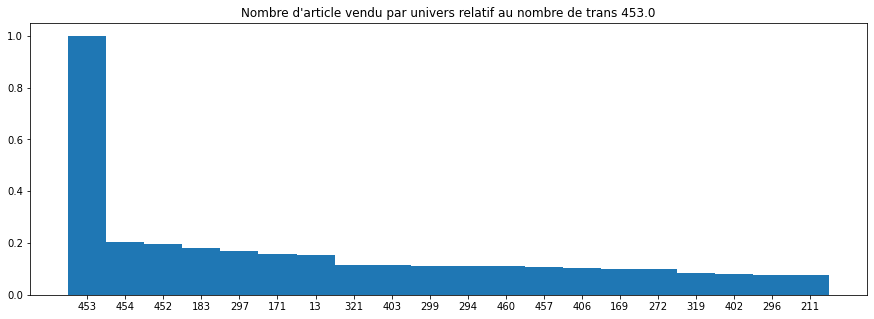

==============454.0===================
Proportion d'achat de univs 454.0 :  7.23 %
Nombre moyen d'achat en plus du univs 454.0 :  7.85
Proportion d'achat de univs 454.0 seul: 1.17 %
CA sans 454.0 :  4043818.55
CA moyen sans 454.0 :  32.76
CA de 454.0 :  430392.0
CA moyen de 454.0 :  3.49


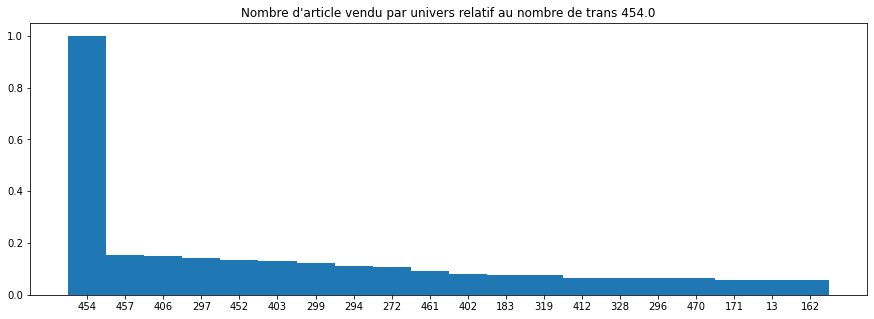

==============455.0===================
Proportion d'achat de univs 455.0 :  1.05 %
Nombre moyen d'achat en plus du univs 455.0 :  10.54
Proportion d'achat de univs 455.0 seul: 0.61 %
CA sans 455.0 :  713605.18
CA moyen sans 455.0 :  39.95
CA de 455.0 :  60017.48
CA moyen de 455.0 :  3.36


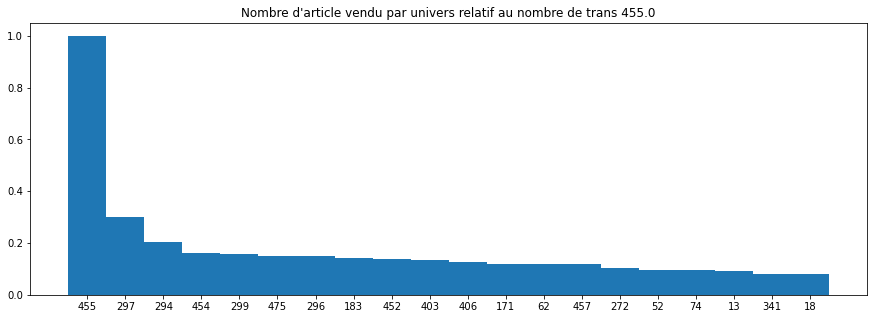

==============456.0===================
Proportion d'achat de univs 456.0 :  1.09 %
Nombre moyen d'achat en plus du univs 456.0 :  7.94
Proportion d'achat de univs 456.0 seul: 1.16 %
CA sans 456.0 :  562192.23
CA moyen sans 456.0 :  30.26
CA de 456.0 :  53970.7
CA moyen de 456.0 :  2.91


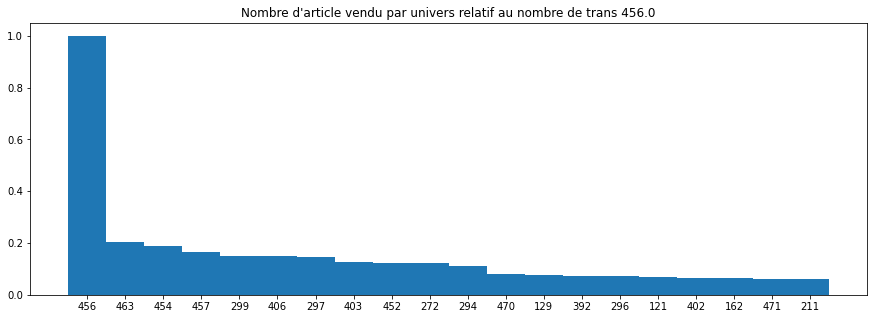

==============457.0===================
Proportion d'achat de univs 457.0 :  10.55 %
Nombre moyen d'achat en plus du univs 457.0 :  5.94
Proportion d'achat de univs 457.0 seul: 1.93 %
CA sans 457.0 :  4130869.45
CA moyen sans 457.0 :  22.96
CA de 457.0 :  497967.91
CA moyen de 457.0 :  2.77


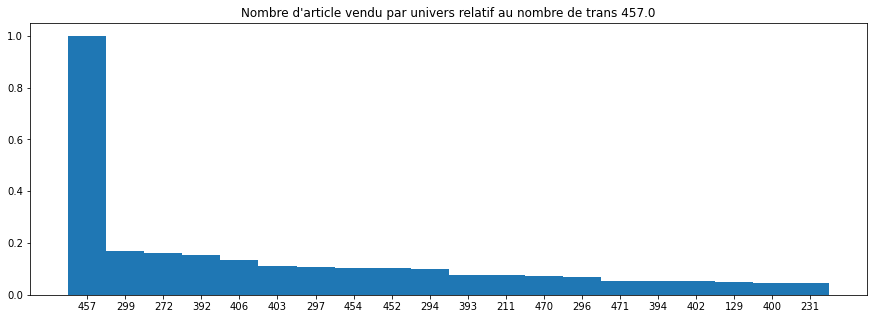

==============458.0===================
Proportion d'achat de univs 458.0 :  1.44 %
Nombre moyen d'achat en plus du univs 458.0 :  6.99
Proportion d'achat de univs 458.0 seul: 1.11 %
CA sans 458.0 :  634524.28
CA moyen sans 458.0 :  25.9
CA de 458.0 :  63941.48
CA moyen de 458.0 :  2.61


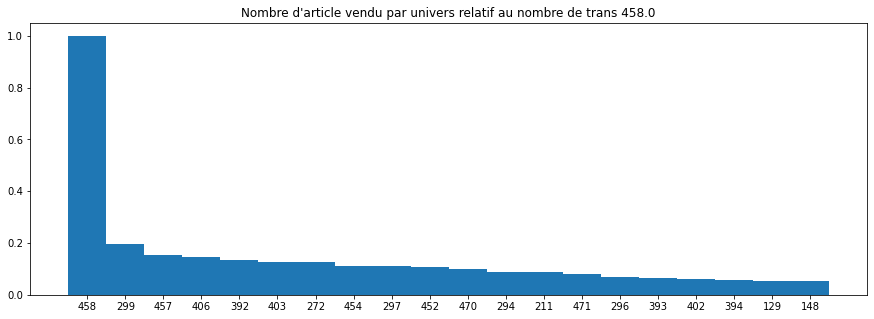

==============460.0===================
Proportion d'achat de univs 460.0 :  0.57 %
Nombre moyen d'achat en plus du univs 460.0 :  10.05
Proportion d'achat de univs 460.0 seul: 0.66 %
CA sans 460.0 :  402333.26
CA moyen sans 460.0 :  41.04
CA de 460.0 :  56333.85
CA moyen de 460.0 :  5.75


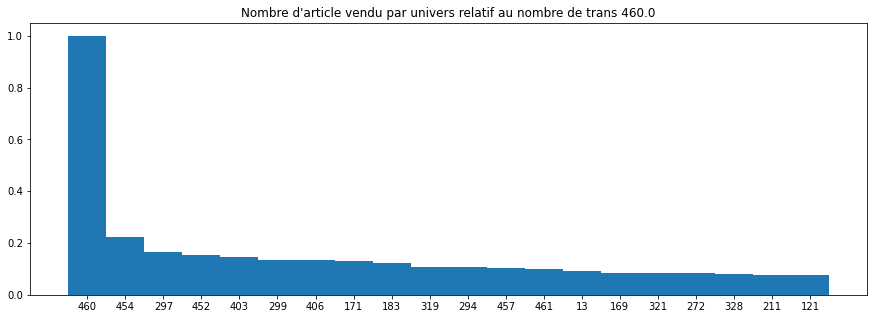

==============461.0===================
Proportion d'achat de univs 461.0 :  2.61 %
Nombre moyen d'achat en plus du univs 461.0 :  8.95
Proportion d'achat de univs 461.0 seul: 0.4 %
CA sans 461.0 :  1596170.61
CA moyen sans 461.0 :  35.87
CA de 461.0 :  174919.09
CA moyen de 461.0 :  3.93


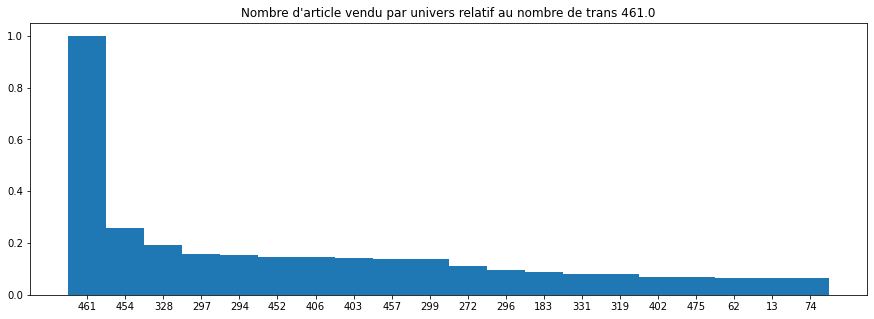

==============462.0===================
Proportion d'achat de univs 462.0 :  1.5 %
Nombre moyen d'achat en plus du univs 462.0 :  10.69
Proportion d'achat de univs 462.0 seul: 0.5 %
CA sans 462.0 :  1081945.22
CA moyen sans 462.0 :  42.17
CA de 462.0 :  149095.88
CA moyen de 462.0 :  5.81


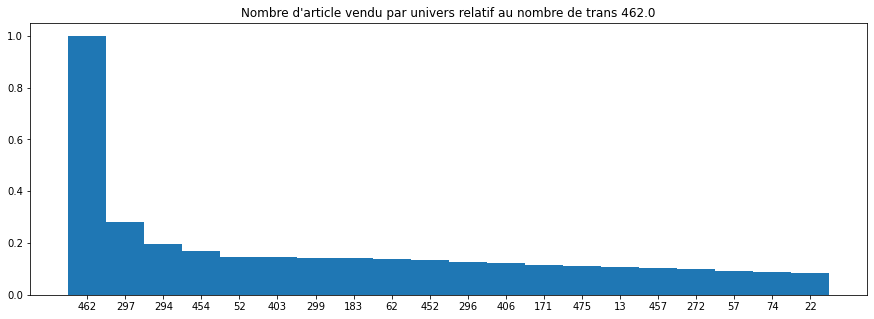

==============463.0===================
Proportion d'achat de univs 463.0 :  1.58 %
Nombre moyen d'achat en plus du univs 463.0 :  7.67
Proportion d'achat de univs 463.0 seul: 1.12 %
CA sans 463.0 :  778265.9
CA moyen sans 463.0 :  28.83
CA de 463.0 :  66948.69
CA moyen de 463.0 :  2.48


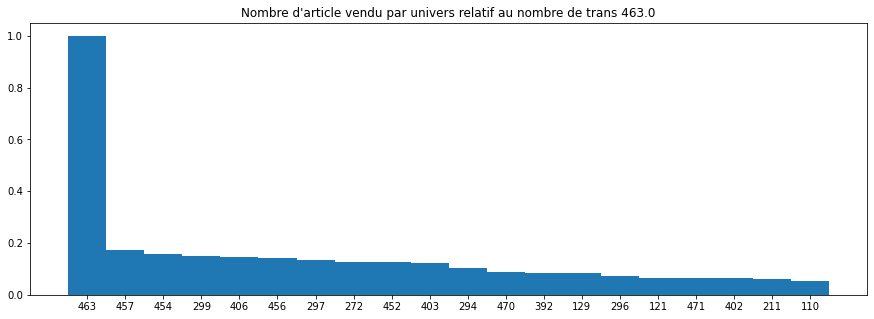

==============464.0===================
Proportion d'achat de univs 464.0 :  0.31 %
Nombre moyen d'achat en plus du univs 464.0 :  8.3
Proportion d'achat de univs 464.0 seul: 0.99 %
CA sans 464.0 :  175314.93
CA moyen sans 464.0 :  32.79
CA de 464.0 :  14916.72
CA moyen de 464.0 :  2.79


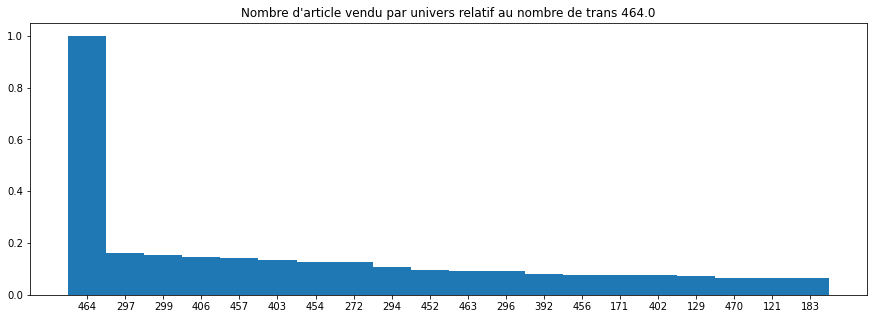

==============465.0===================
Proportion d'achat de univs 465.0 :  0.23 %
Nombre moyen d'achat en plus du univs 465.0 :  6.53
Proportion d'achat de univs 465.0 seul: 1.17 %
CA sans 465.0 :  100312.73
CA moyen sans 465.0 :  25.97
CA de 465.0 :  10886.1
CA moyen de 465.0 :  2.82


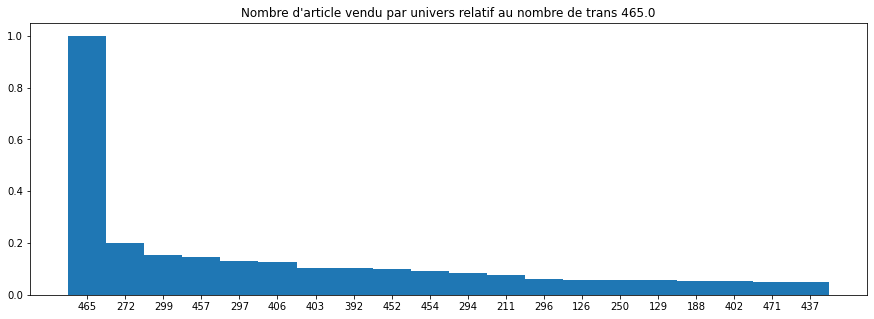

==============466.0===================
Proportion d'achat de univs 466.0 :  0.56 %
Nombre moyen d'achat en plus du univs 466.0 :  7.65
Proportion d'achat de univs 466.0 seul: 1.01 %
CA sans 466.0 :  265669.24
CA moyen sans 466.0 :  27.7
CA de 466.0 :  23508.22
CA moyen de 466.0 :  2.45


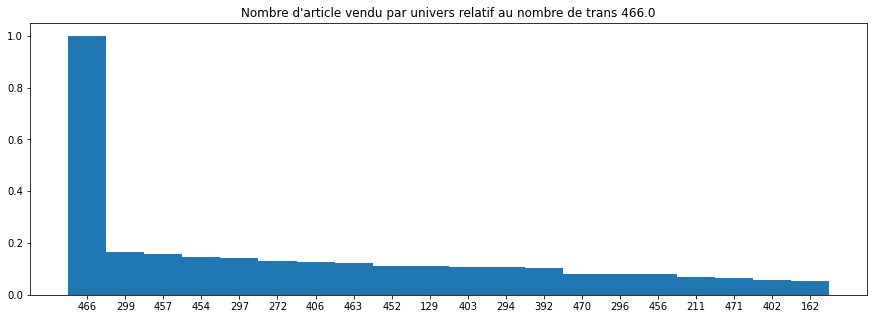

==============467.0===================
Proportion d'achat de univs 467.0 :  0.14 %
Nombre moyen d'achat en plus du univs 467.0 :  8.17
Proportion d'achat de univs 467.0 seul: 1.35 %
CA sans 467.0 :  77281.86
CA moyen sans 467.0 :  32.59
CA de 467.0 :  9681.11
CA moyen de 467.0 :  4.08


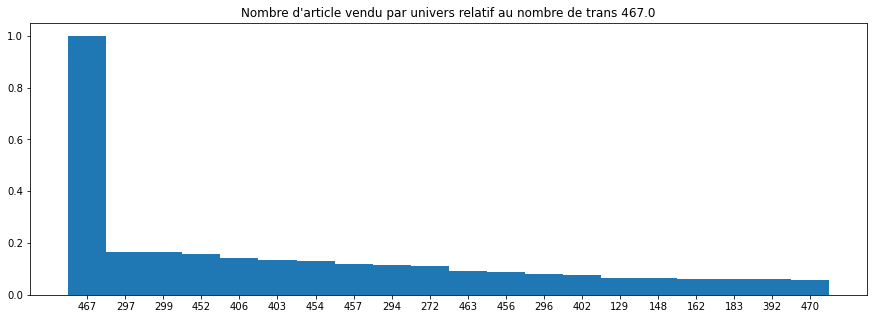

==============468.0===================
Proportion d'achat de univs 468.0 :  0.44 %
Nombre moyen d'achat en plus du univs 468.0 :  8.1
Proportion d'achat de univs 468.0 seul: 2.69 %
CA sans 468.0 :  258874.63
CA moyen sans 468.0 :  34.36
CA de 468.0 :  60642.36
CA moyen de 468.0 :  8.05


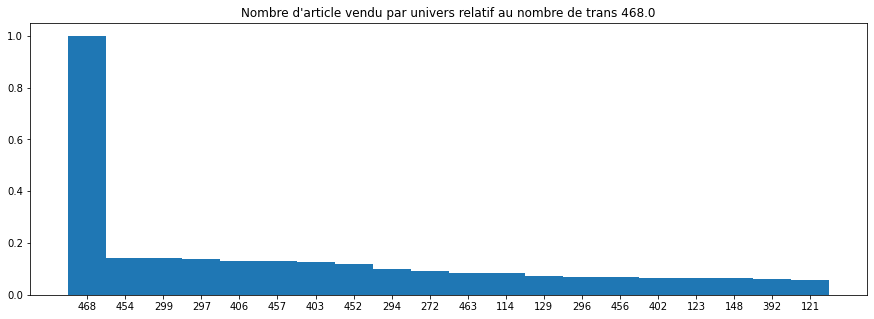

==============469.0===================
Proportion d'achat de univs 469.0 :  0.97 %
Nombre moyen d'achat en plus du univs 469.0 :  6.58
Proportion d'achat de univs 469.0 seul: 0.93 %
CA sans 469.0 :  399824.39
CA moyen sans 469.0 :  24.25
CA de 469.0 :  29384.24
CA moyen de 469.0 :  1.78


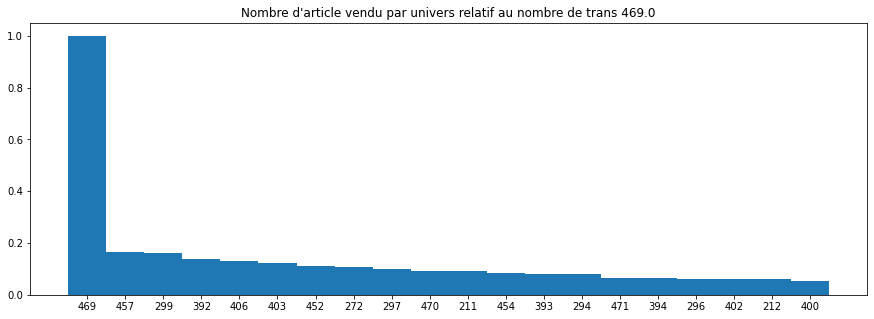

==============470.0===================
Proportion d'achat de univs 470.0 :  3.74 %
Nombre moyen d'achat en plus du univs 470.0 :  6.76
Proportion d'achat de univs 470.0 seul: 1.18 %
CA sans 470.0 :  1614972.71
CA moyen sans 470.0 :  25.34
CA de 470.0 :  147874.21
CA moyen de 470.0 :  2.32


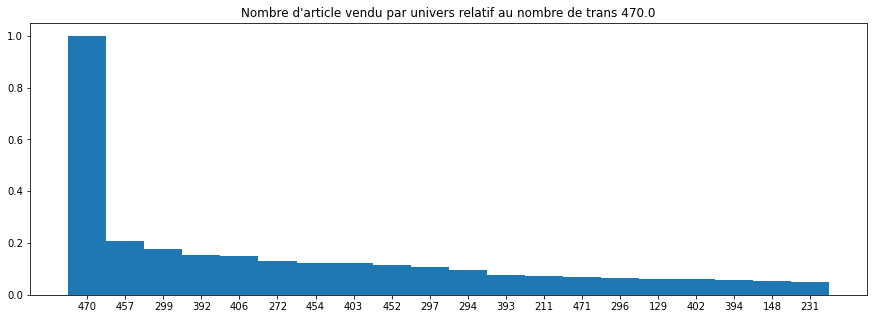

==============471.0===================
Proportion d'achat de univs 471.0 :  3.51 %
Nombre moyen d'achat en plus du univs 471.0 :  6.37
Proportion d'achat de univs 471.0 seul: 1.25 %
CA sans 471.0 :  1412927.3
CA moyen sans 471.0 :  23.58
CA de 471.0 :  158628.5
CA moyen de 471.0 :  2.65


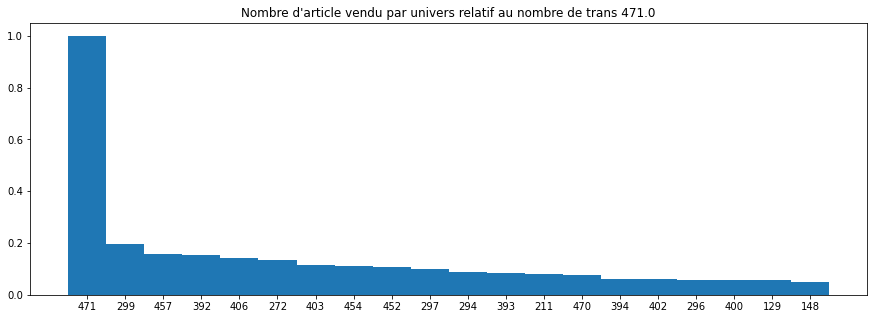

==============472.0===================
Proportion d'achat de univs 472.0 :  1.36 %
Nombre moyen d'achat en plus du univs 472.0 :  6.39
Proportion d'achat de univs 472.0 seul: 1.23 %
CA sans 472.0 :  535936.33
CA moyen sans 472.0 :  23.16
CA de 472.0 :  57180.37
CA moyen de 472.0 :  2.47


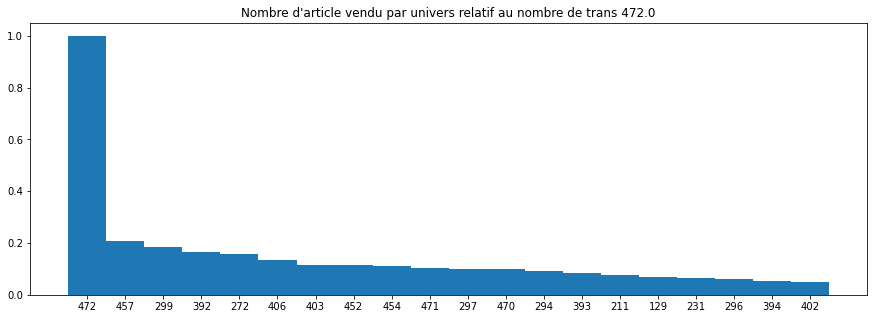

==============473.0===================
Proportion d'achat de univs 473.0 :  1.34 %
Nombre moyen d'achat en plus du univs 473.0 :  8.06
Proportion d'achat de univs 473.0 seul: 0.44 %
CA sans 473.0 :  716750.13
CA moyen sans 473.0 :  31.26
CA de 473.0 :  38458.24
CA moyen de 473.0 :  1.68


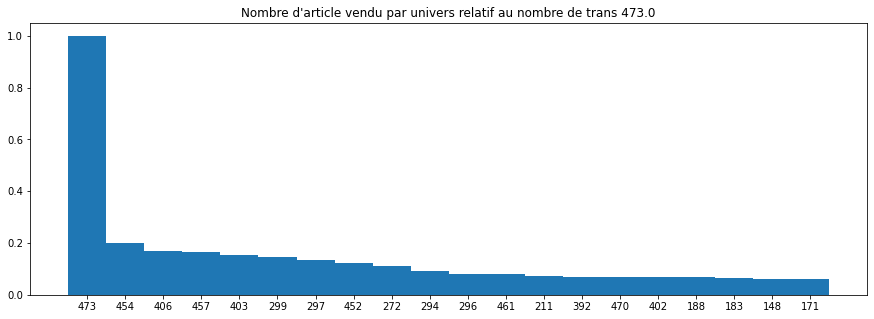

==============474.0===================
Proportion d'achat de univs 474.0 :  0.45 %
Nombre moyen d'achat en plus du univs 474.0 :  9.53
Proportion d'achat de univs 474.0 seul: 0.66 %
CA sans 474.0 :  305131.08
CA moyen sans 474.0 :  39.43
CA de 474.0 :  38522.97
CA moyen de 474.0 :  4.98


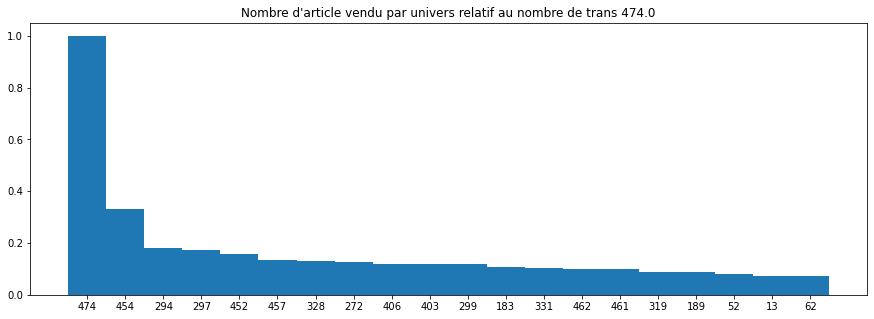

==============475.0===================
Proportion d'achat de univs 475.0 :  2.9 %
Nombre moyen d'achat en plus du univs 475.0 :  9.98
Proportion d'achat de univs 475.0 seul: 0.4 %
CA sans 475.0 :  1874663.88
CA moyen sans 475.0 :  37.87
CA de 475.0 :  211628.68
CA moyen de 475.0 :  4.27


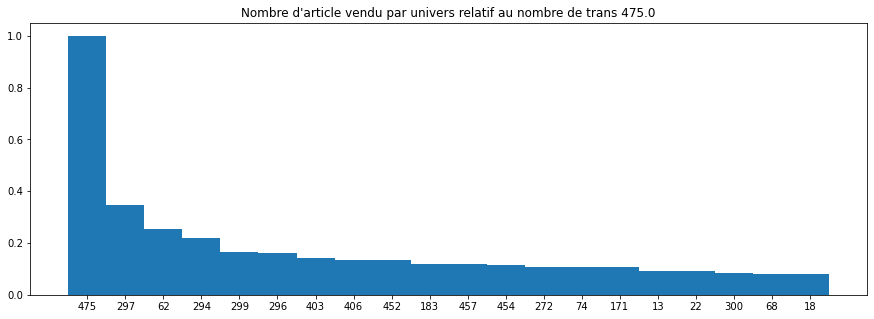

==============476.0===================
Proportion d'achat de univs 476.0 :  0.63 %
Nombre moyen d'achat en plus du univs 476.0 :  7.23
Proportion d'achat de univs 476.0 seul: 0.86 %
CA sans 476.0 :  287797.0
CA moyen sans 476.0 :  26.95
CA de 476.0 :  34453.51
CA moyen de 476.0 :  3.23


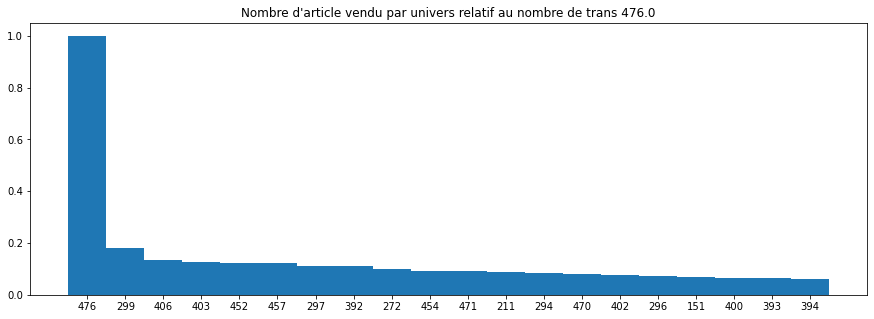

==============477.0===================
Proportion d'achat de univs 477.0 :  0.91 %
Nombre moyen d'achat en plus du univs 477.0 :  7.89
Proportion d'achat de univs 477.0 seul: 1.88 %
CA sans 477.0 :  523124.97
CA moyen sans 477.0 :  33.6
CA de 477.0 :  69734.96
CA moyen de 477.0 :  4.48


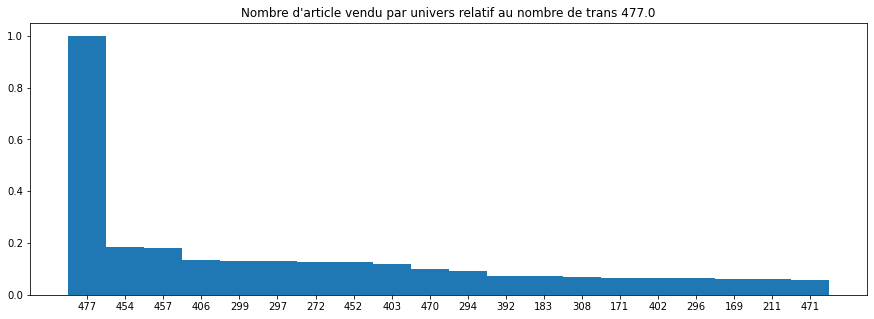

==============478.0===================
Proportion d'achat de univs 478.0 :  0.29 %
Nombre moyen d'achat en plus du univs 478.0 :  10.02
Proportion d'achat de univs 478.0 seul: 0.91 %
CA sans 478.0 :  194765.46
CA moyen sans 478.0 :  39.35
CA de 478.0 :  22734.1
CA moyen de 478.0 :  4.59


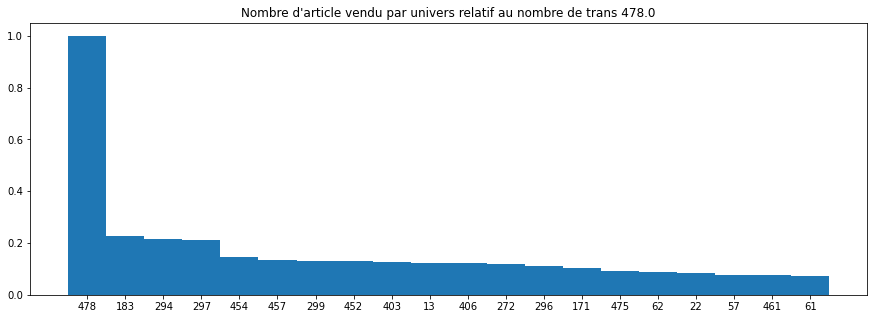

==============479.0===================
NO DATA 
==============481.0===================
Proportion d'achat de univs 481.0 :  0.26 %
Nombre moyen d'achat en plus du univs 481.0 :  6.05
Proportion d'achat de univs 481.0 seul: 4.54 %
CA sans 481.0 :  111718.33
CA moyen sans 481.0 :  25.09
CA de 481.0 :  31546.01
CA moyen de 481.0 :  7.09


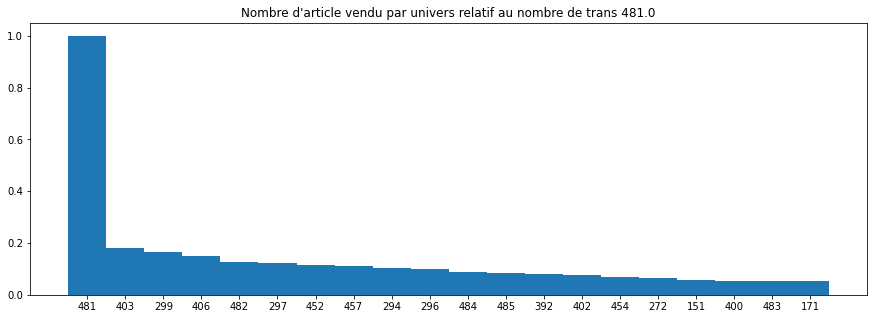

==============482.0===================
Proportion d'achat de univs 482.0 :  0.98 %
Nombre moyen d'achat en plus du univs 482.0 :  5.51
Proportion d'achat de univs 482.0 seul: 6.1 %
CA sans 482.0 :  366676.2
CA moyen sans 482.0 :  22.0
CA de 482.0 :  117424.12
CA moyen de 482.0 :  7.05


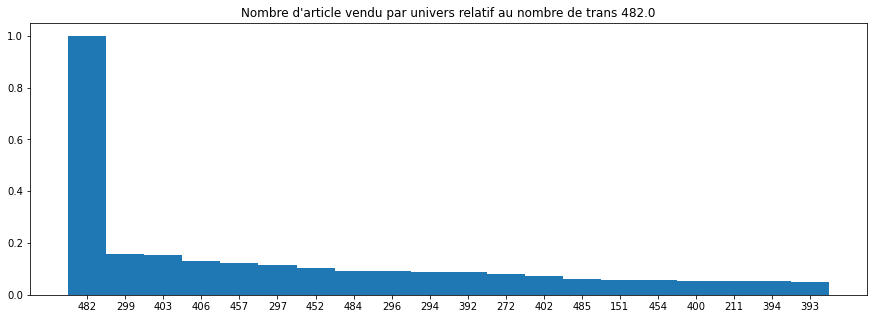

==============483.0===================
Proportion d'achat de univs 483.0 :  0.32 %
Nombre moyen d'achat en plus du univs 483.0 :  5.92
Proportion d'achat de univs 483.0 seul: 4.59 %
CA sans 483.0 :  133868.09
CA moyen sans 483.0 :  24.49
CA de 483.0 :  36273.38
CA moyen de 483.0 :  6.64


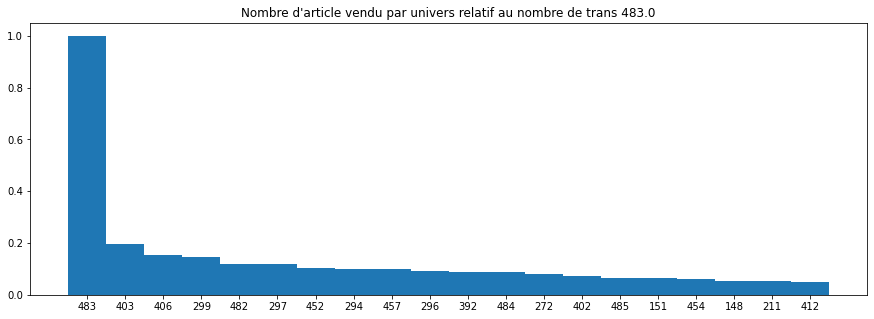

==============484.0===================
Proportion d'achat de univs 484.0 :  1.57 %
Nombre moyen d'achat en plus du univs 484.0 :  4.92
Proportion d'achat de univs 484.0 seul: 8.16 %
CA sans 484.0 :  510850.82
CA moyen sans 484.0 :  19.03
CA de 484.0 :  164228.85
CA moyen de 484.0 :  6.12


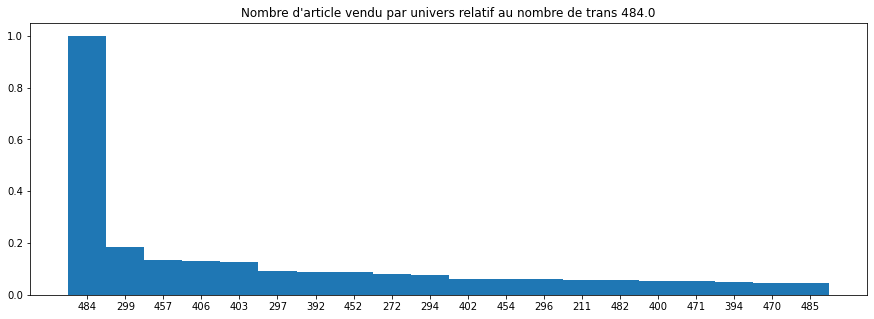

==============485.0===================
Proportion d'achat de univs 485.0 :  0.87 %
Nombre moyen d'achat en plus du univs 485.0 :  5.53
Proportion d'achat de univs 485.0 seul: 6.32 %
CA sans 485.0 :  326889.1
CA moyen sans 485.0 :  22.11
CA de 485.0 :  107263.76
CA moyen de 485.0 :  7.25


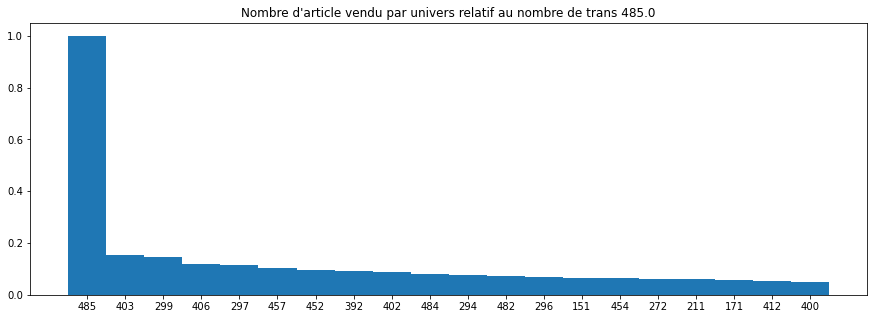

==============486.0===================
NO DATA 
==============487.0===================
Proportion d'achat de univs 487.0 :  0.38 %
Nombre moyen d'achat en plus du univs 487.0 :  9.38
Proportion d'achat de univs 487.0 seul: 0.47 %
CA sans 487.0 :  250941.47
CA moyen sans 487.0 :  38.94
CA de 487.0 :  31299.23
CA moyen de 487.0 :  4.86


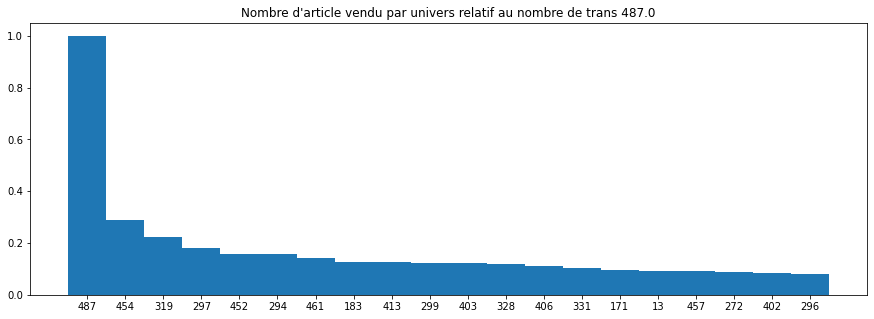

==============488.0===================
Proportion d'achat de univs 488.0 :  0.03 %
Nombre moyen d'achat en plus du univs 488.0 :  9.48
Proportion d'achat de univs 488.0 seul: 0.39 %
CA sans 488.0 :  20928.39
CA moyen sans 488.0 :  40.32
CA de 488.0 :  2061.78
CA moyen de 488.0 :  3.97


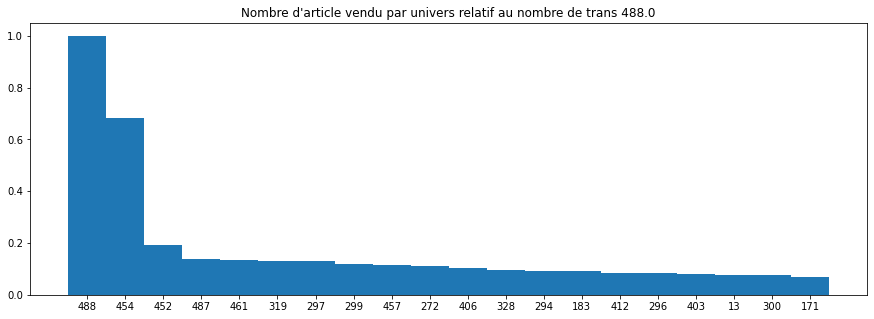

==============490.0===================
NO DATA 
Time Taken to load all metrics: ~135secondes


In [35]:
start = time()
for key in all_univ:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
        
    N = len(trans)
    if N <= 50:
        print("NO DATA ")
        continue
    
    nbr_article_sans_univ = [0 for _ in range(N)]
    for i in range(len(trans)):
        for item in trans[i]:
            if item != key:
                nbr_article_sans_univ[i] += 1

    print("Proportion d'achat de univs " + str(key) + " : ", end = ' ')
    print(round(N*100/len(transactions),2), '%')
    print("Nombre moyen d'achat en plus du univs " + str(key) + " : ", end = ' ')
    print(round(sum(nbr_article_sans_univ)/N, 2))
    print("Proportion d'achat de univs " + str(key) + " seul:", end = ' ')
    print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2), '%')
    
    print("CA sans " + str(key) + " : ", end = ' ')
    print(round(CA_without_univ,2))
    print("CA moyen sans " + str(key) + " : ", end = ' ')
    print(round(CA_without_univ/N,2))
    print("CA de " + str(key) + " : ", end = ' ')
    print(round(CA_univ,2))
    print("CA moyen de " + str(key) + " : ", end = ' ')
    print(round(CA_univ/N,2))
    
    rec_article = {}

    for t in trans:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1

    for k in rec_article.keys():
        rec_article[k]/= N


    fig = plt.figure(figsize=(15, 5))

    rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}

    nbr_univ = len(rec_article.keys())

    plt.bar(list(rec_article.keys())[:min(20, nbr_univ)]
                ,list(rec_article.values())[:min(20, nbr_univ)],1)

    plt.title("Nombre d'article vendu par univers relatif au nombre de trans " + str(key))

    # if save_fig:
    #     plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
    plt.show()
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 